### Target: Use Nidv onto random latent variable logits before Gumbel Sampling;

### To cancel the diversity loss, to that we can see the problem clearly;
 
### Notice: this version is different from version2, why did I use version2 in the first place ??

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch import optim
from collections import Counter
from NDiv.ndiv_pytorch import NDiv_loss

tensor([[1, 1],
        [3, 1],
        [1, 1],
        ...,
        [3, 3],
        [3, 1],
        [1, 2]])


([<matplotlib.axis.XTick at 0x7fb4fe726ba8>,
 <a list of 8 Text xticklabel objects>)

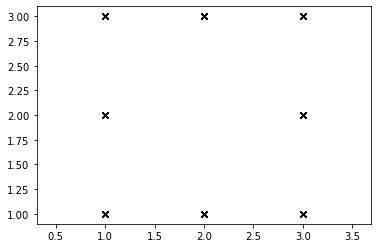

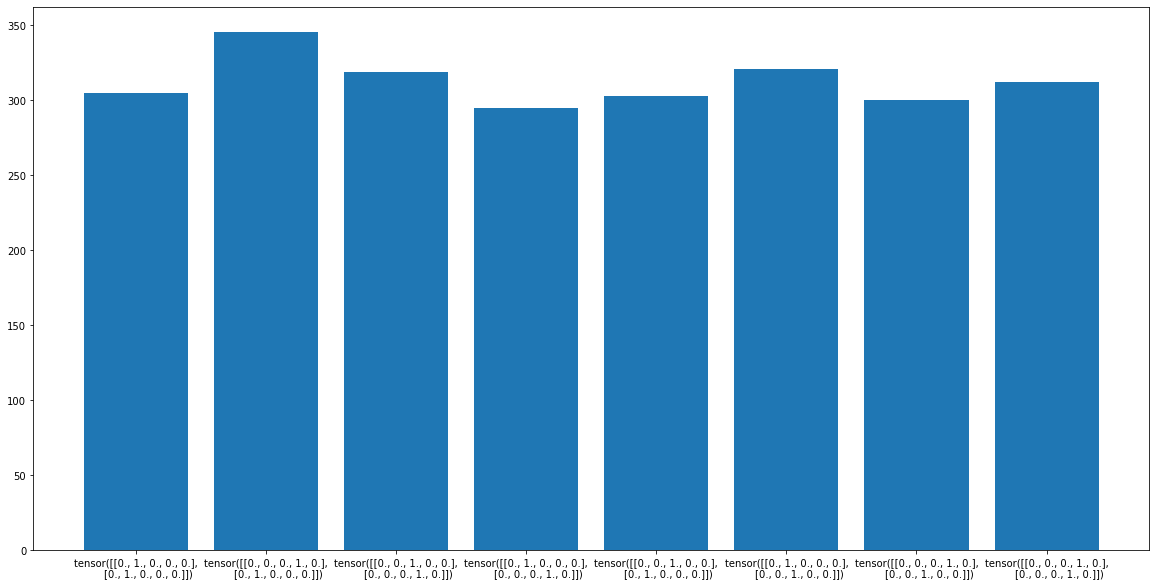

In [3]:
from loadDataset import *
from visualizer import *

data_config = {
    'name' : 'gaussian_grid',
    'n' : 5,
    'n_data' : 100,
    'sig' : 0.01
}

ds = getDataset(data_config)
dl = DataLoader(ds, batch_size=128, shuffle=True)

# gt data func, for train
def gen_real_data_onehot(dl, batch=128):

    real_samples = next(iter(dl))

    ''' delete adjacent modes from dataset '''
    mode_idx = [6,7, 8,11,13, 16, 17, 18]
    real_samples_new = [real_samples[i] for i in mode_idx]
    real_samples = real_samples_new
    
    ''' mix 25 modes '''
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2).long()

    ''' make dataset unbalanced '''
#     real_samples = real_samples[800:]
#     real_samples = real_samples[:-800]
    
    random_choice = torch.randint(0, real_samples.shape[0], (batch, )).long()
    data = real_samples[random_choice]
    data = torch.unsqueeze(data, -1)

    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

# data = gen_real_data_onehot(dl)

# gt data func, for test
def gen_real_data_test(dl, batch=128):

    real_samples = next(iter(dl))

    # mix 25 modes
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2)
    real_samples = torch.unsqueeze(real_samples, -1).long()
    
    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

def gen_input_data(batch=128):
    # https://pytorch.org/docs/stable/torch.html#torch.randn
    data = torch.zeros(int(batch/2), 2)
    data[:, 0] = 0.5
    data[:, 1] = -0.5
    return torch.cat((data, data), 0)

#     data = torch.randn(int(batch/ 2), 2)
#     return torch.cat((data, data), 0)

def gen_input_data_test(batch=128):
    return torch.randn(batch, 2)

''' Plot Distribution for Unbalanced Dataset '''

data = gen_real_data_onehot(dl, 2500)
print(torch.argmax(data,-1))
data_list = [str(x) for x in data]

# plot grid
plot_outputdata(torch.argmax(data, -1), dim1=0, dim2=1, marker='kx', alpha=0.1)

# plot bar chart
index = range(len(Counter(data_list).keys()))
plt.figure(figsize=(20,10))
plt.bar(index, Counter(data_list).values(), align='center')
plt.xticks(index, Counter(data_list).keys())

In [4]:
### Define Gumbel Function Utility

def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape).cuda()
    h = (g + logits) * temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [5]:
### G Network based on gumbel
class MLPG(nn.Module):
    
    def __init__(self, input_size, hidden_size, noise_size, output_size, temperature=1):
        super(MLPG, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3_1 = nn.Linear(hidden_size + noise_size, output_size) # x-axis
        self.map3_2 = nn.Linear(hidden_size + noise_size, output_size) # y-axis
        
        self.name = 'MLPG'
        self.noise_size = noise_size
        self.temp = temperature
        
    def forward(self, x, temperature=None):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size).cuda()

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # perform gumbel sampling
        if temperature is not None:
            x_coord = sample_gumbel_softmax(x_coord, temperature)
            y_coord = sample_gumbel_softmax(y_coord, temperature)
        else:
            x_coord = sample_gumbel_softmax(x_coord, self.temp)
            y_coord = sample_gumbel_softmax(y_coord, self.temp)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1), noise
    
    def checkLogits(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size)

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1)
    
### D Network to produce loss
class MLPD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPD, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, output_size)
        self.name = 'MLPD'
        
    def forward(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        return torch.sigmoid(self.map2(x))
    
### Create the overall network
class gumbel_gan(object):
    def __init__(self, temperature=1):
        self.g = MLPG(2, 128, 25, 5, temperature=temperature).cuda()
        self.d = MLPD(10, 128, 1).cuda()
        
        self.g_optim = optim.Adam(self.g.parameters(), lr=1e-4)
        self.d_optim = optim.Adam(self.d.parameters(), lr=1e-4)
        
        self.d_step = 3
#         self.g_step = 10
        self.g_step = 1
        self.g_NDiv = 2
        
        self.criterion = nn.BCELoss()
        
    def train(self, epoch, real_data, g_input):
        print("training start")
        pbar = range(epoch)
        batch = real_data.shape[0]
        
        for ep in pbar:
            for d_index in range(self.d_step):
                
                # Train D
                self.d.zero_grad()
                
                # Train D on real
                d_real_decision = self.d(real_data)
                labels = torch.ones(d_real_decision.shape, dtype=torch.float32).cuda()
                d_real_loss = self.criterion(d_real_decision, labels)
                
                # Train D on fake
                fake_data, latent_samples = self.g(g_input)
                d_fake_decision = self.d(fake_data.view(batch, -1))
                labels = torch.zeros(d_fake_decision.shape, dtype=torch.float32).cuda()
                
                d_fake_loss = self.criterion(d_fake_decision, labels)

                # calc loss for D
                d_loss = 0.5 * (d_real_loss + d_fake_loss)
#                 d_loss = 0.5 * (d_real_loss + d_fake_loss)
                d_loss.backward()
                d_loss_val = d_loss.item()
                
                # update D
                self.d_optim.step()
                
            """ optim NDiv diversity """
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                # print(latent_samples.shape)
                # raise
                div_loss = NDiv_loss(latent_samples, g_fake_data) * 1e2
                div_loss_val = div_loss.item()
                
                # update G w.r.t NDiv
#                 div_loss.backward()
#                 self.g_optim.step()
                
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                batch = g_fake_data.shape[0]
                
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                
                # G loss
                labels = torch.ones(g_fake_decision.shape, dtype=torch.float32).cuda()
                g_loss = -(g_fake_decision.log() * labels + (1-labels)*(1-g_fake_decision.log())).mean()
                
                g_loss_val = g_loss.item()
                
                g_loss.backward()
                
                # update G
                self.g_optim.step()
                
            print("Iteration {}, d real/fake loss {}/{} and g loss is {}, NDiv loss {}".format(ep, d_real_loss.item(), \
                                                                                 d_fake_loss.item(), g_loss, div_loss_val))            

In [6]:
## Init the simple Network
## Define temperature here
net = gumbel_gan(temperature=1000)
print(net.g, net.d)

MLPG(
  (map1): Linear(in_features=2, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=128, bias=True)
  (map3_1): Linear(in_features=153, out_features=5, bias=True)
  (map3_2): Linear(in_features=153, out_features=5, bias=True)
) MLPD(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=1, bias=True)
)


Processing Epoch 0
training start
Iteration 0, d real/fake loss 0.6439844369888306/0.7466598153114319 and g loss is 0.6437245011329651, NDiv loss 0.03130725771188736
Iteration 1, d real/fake loss 0.643059492111206/0.7504018545150757 and g loss is 0.6428119540214539, NDiv loss 0.03288140147924423
Iteration 2, d real/fake loss 0.6421133279800415/0.752418041229248 and g loss is 0.6441702842712402, NDiv loss 0.030010856688022614
Iteration 3, d real/fake loss 0.6411659121513367/0.7516496181488037 and g loss is 0.6420825719833374, NDiv loss 0.03299722820520401
Iteration 4, d real/fake loss 0.640141487121582/0.7489191293716431 and g loss is 0.6434578895568848, NDiv loss 0.033851273357868195


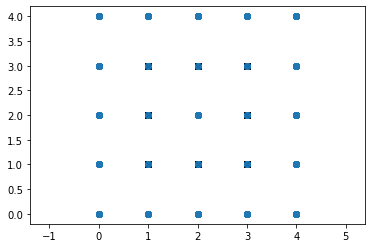

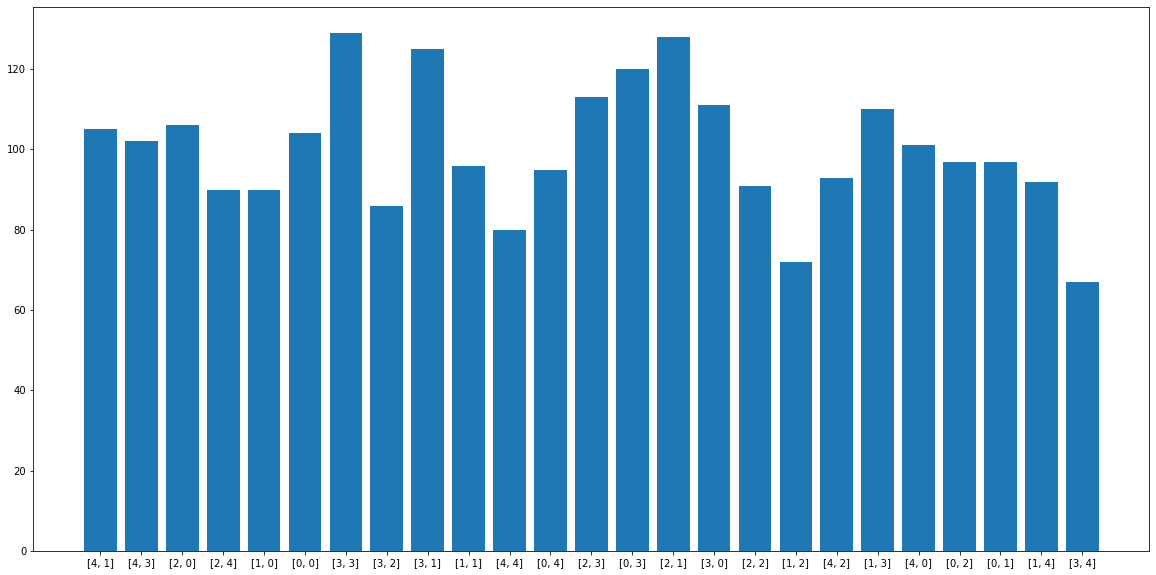

Processing Epoch 1
training start
Iteration 0, d real/fake loss 0.6403401494026184/0.747787594795227 and g loss is 0.6462411880493164, NDiv loss 0.035606708377599716
Iteration 1, d real/fake loss 0.6393252015113831/0.7504469156265259 and g loss is 0.6473644971847534, NDiv loss 0.0333239808678627
Iteration 2, d real/fake loss 0.6383457183837891/0.7466071248054504 and g loss is 0.6424791216850281, NDiv loss 0.03196124732494354
Iteration 3, d real/fake loss 0.6373687386512756/0.7437384724617004 and g loss is 0.6438869833946228, NDiv loss 0.031814347952604294
Iteration 4, d real/fake loss 0.6363391876220703/0.7500520944595337 and g loss is 0.6419252157211304, NDiv loss 0.031923048198223114


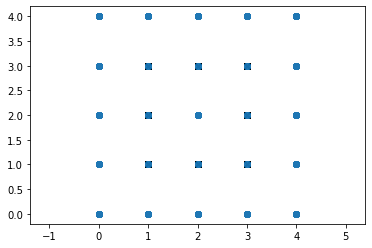

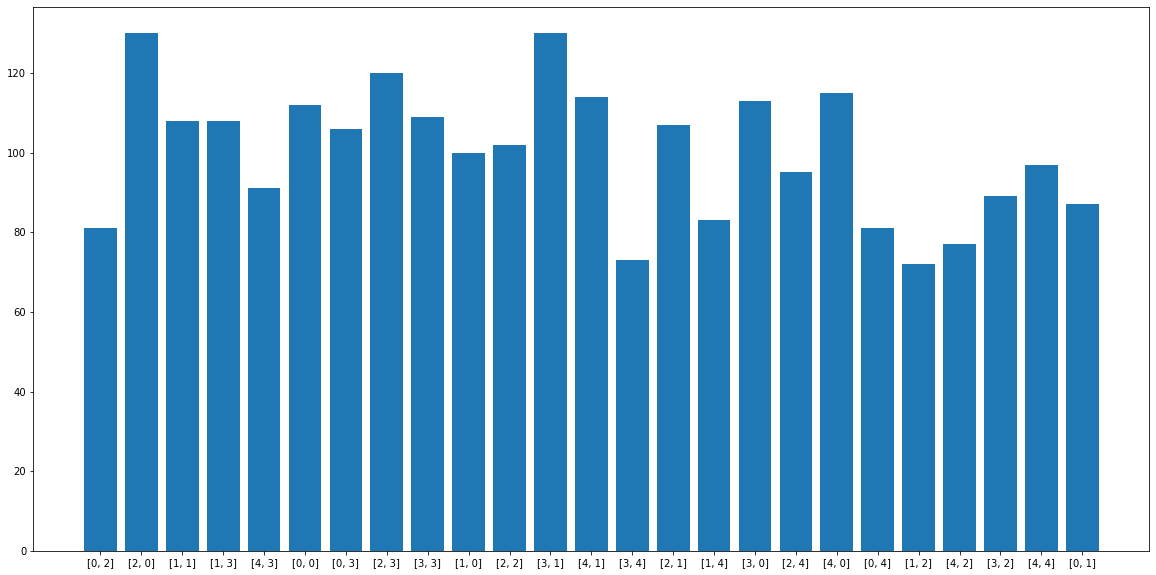

Processing Epoch 2
training start
Iteration 0, d real/fake loss 0.6332871913909912/0.744424045085907 and g loss is 0.646018385887146, NDiv loss 0.030945200473070145
Iteration 1, d real/fake loss 0.6322575807571411/0.7412899732589722 and g loss is 0.6543906927108765, NDiv loss 0.03550168499350548
Iteration 2, d real/fake loss 0.6312340497970581/0.7448992729187012 and g loss is 0.6498559713363647, NDiv loss 0.03116621822118759
Iteration 3, d real/fake loss 0.6302220821380615/0.7381672263145447 and g loss is 0.6405361890792847, NDiv loss 0.03145230934023857
Iteration 4, d real/fake loss 0.6292449235916138/0.7428114414215088 and g loss is 0.6489391326904297, NDiv loss 0.03068632446229458


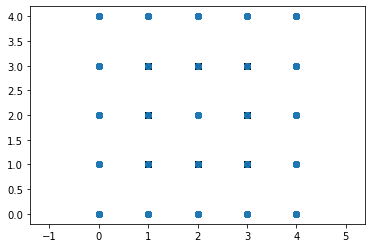

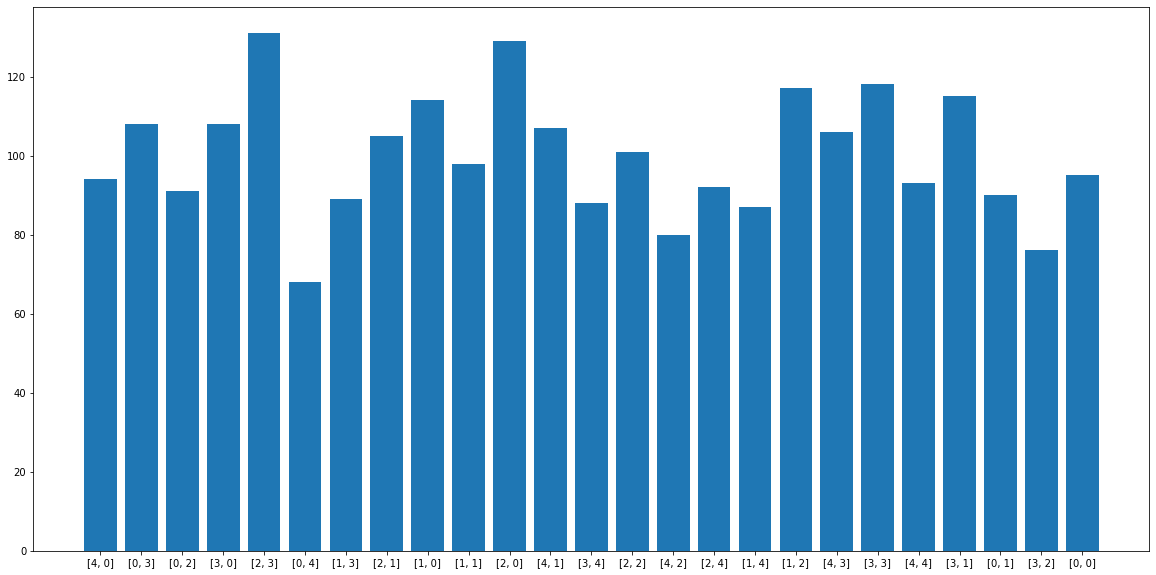

Processing Epoch 3
training start
Iteration 0, d real/fake loss 0.6307795643806458/0.7427148222923279 and g loss is 0.6521764993667603, NDiv loss 0.03130669146776199
Iteration 1, d real/fake loss 0.6297956705093384/0.7458886504173279 and g loss is 0.6474860310554504, NDiv loss 0.03326844424009323
Iteration 2, d real/fake loss 0.6288081407546997/0.7430883646011353 and g loss is 0.6488088965415955, NDiv loss 0.03276900202035904
Iteration 3, d real/fake loss 0.6278855800628662/0.7410528063774109 and g loss is 0.6517009735107422, NDiv loss 0.03160766139626503
Iteration 4, d real/fake loss 0.6269505023956299/0.7463394403457642 and g loss is 0.6402662992477417, NDiv loss 0.03199072927236557


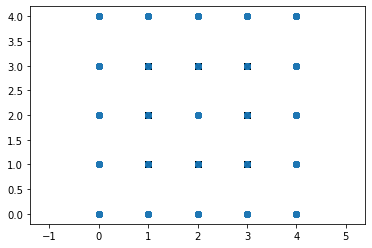

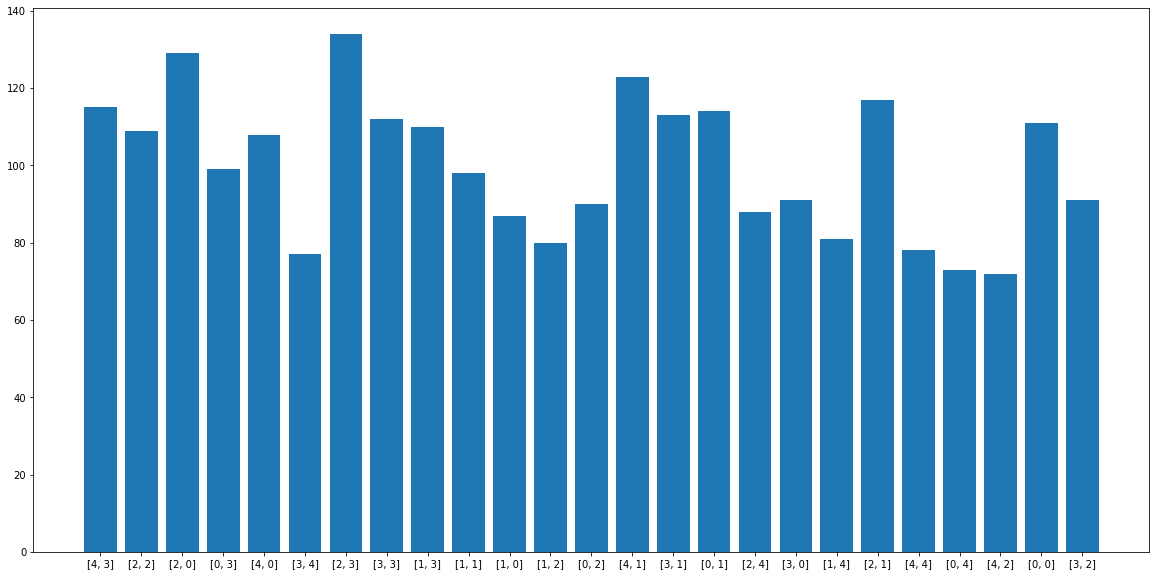

Processing Epoch 4
training start
Iteration 0, d real/fake loss 0.6266977190971375/0.7363897562026978 and g loss is 0.6469951868057251, NDiv loss 0.03360266238451004
Iteration 1, d real/fake loss 0.6258318424224854/0.7385669946670532 and g loss is 0.6488626003265381, NDiv loss 0.031342677772045135
Iteration 2, d real/fake loss 0.6249216794967651/0.7358838319778442 and g loss is 0.6471354961395264, NDiv loss 0.03219710662961006
Iteration 3, d real/fake loss 0.6239452362060547/0.7412360310554504 and g loss is 0.650719165802002, NDiv loss 0.031288597732782364
Iteration 4, d real/fake loss 0.6229495406150818/0.744377613067627 and g loss is 0.6548271775245667, NDiv loss 0.03377513587474823


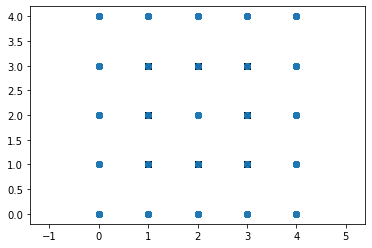

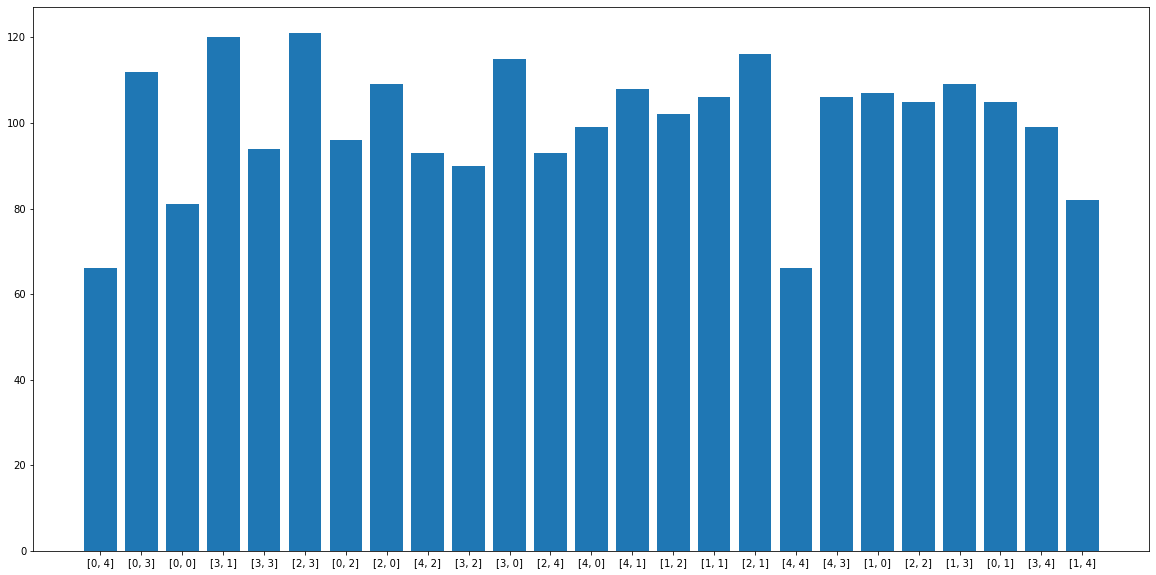

Processing Epoch 5
training start
Iteration 0, d real/fake loss 0.6207813024520874/0.7378710508346558 and g loss is 0.6488761901855469, NDiv loss 0.032968975603580475
Iteration 1, d real/fake loss 0.6199018955230713/0.7367825508117676 and g loss is 0.6564457416534424, NDiv loss 0.03353746607899666
Iteration 2, d real/fake loss 0.6190422177314758/0.7314928770065308 and g loss is 0.6531645059585571, NDiv loss 0.031072407960891724
Iteration 3, d real/fake loss 0.6181595921516418/0.737519383430481 and g loss is 0.6594222784042358, NDiv loss 0.031522009521722794
Iteration 4, d real/fake loss 0.6173014044761658/0.7388322353363037 and g loss is 0.6514807939529419, NDiv loss 0.03318381309509277


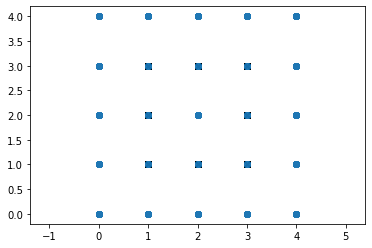

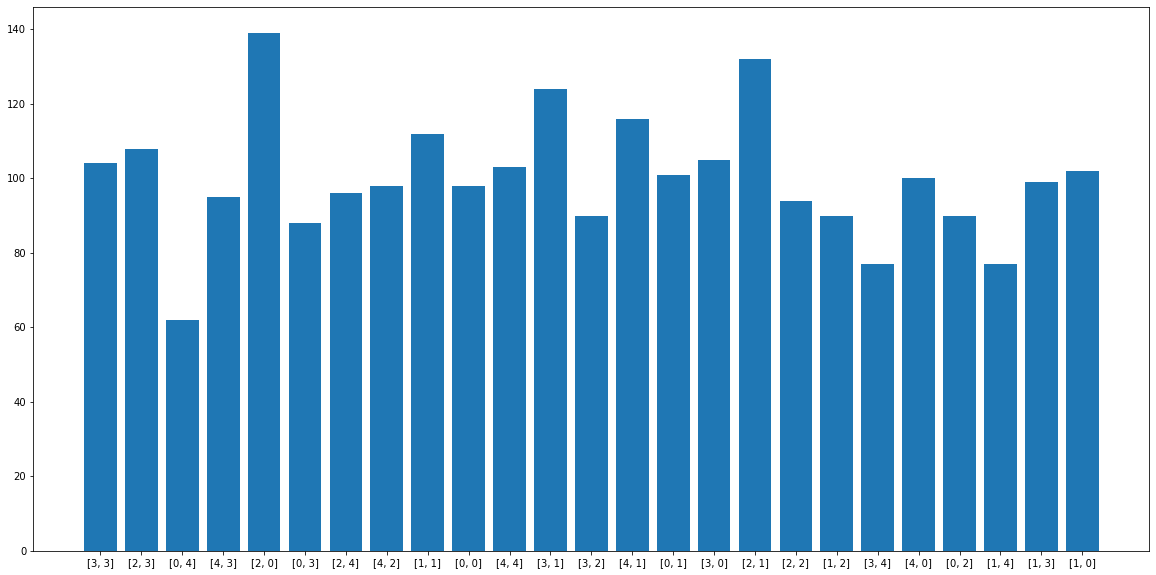

Processing Epoch 6
training start
Iteration 0, d real/fake loss 0.613960862159729/0.7414138913154602 and g loss is 0.650598406791687, NDiv loss 0.03378676995635033
Iteration 1, d real/fake loss 0.6131695508956909/0.733762264251709 and g loss is 0.6572936773300171, NDiv loss 0.03236708045005798
Iteration 2, d real/fake loss 0.6123532652854919/0.7355667352676392 and g loss is 0.6492815017700195, NDiv loss 0.032599639147520065
Iteration 3, d real/fake loss 0.6115434169769287/0.7368009090423584 and g loss is 0.6626256108283997, NDiv loss 0.030426878482103348
Iteration 4, d real/fake loss 0.6107677221298218/0.7357230186462402 and g loss is 0.6512049436569214, NDiv loss 0.03341691568493843


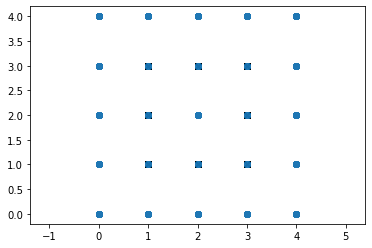

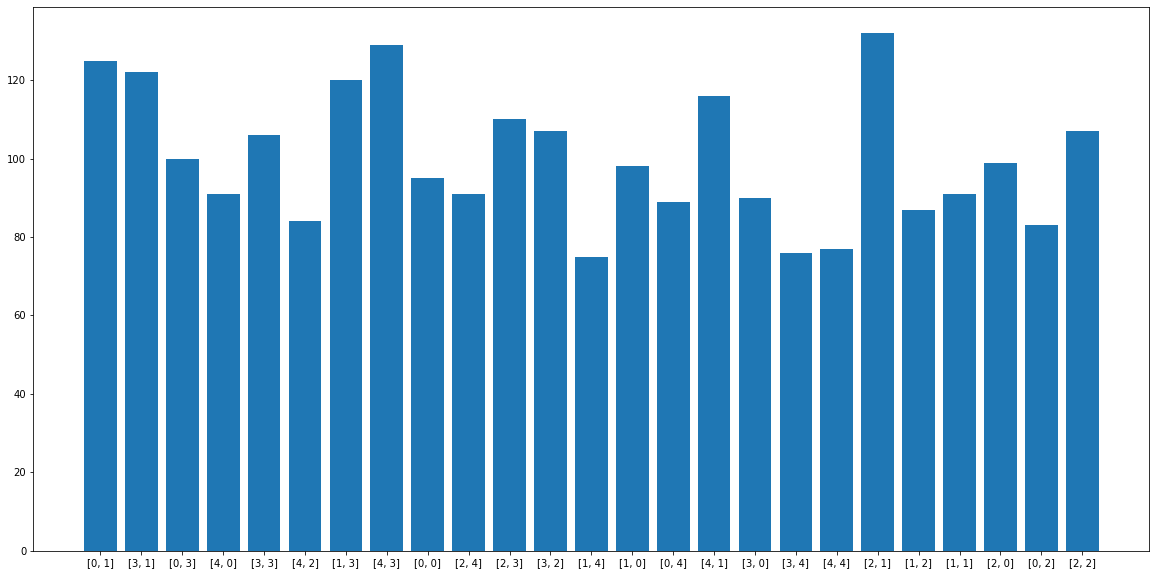

Processing Epoch 7
training start
Iteration 0, d real/fake loss 0.6158616542816162/0.7371119260787964 and g loss is 0.6621155738830566, NDiv loss 0.03404192253947258
Iteration 1, d real/fake loss 0.6150393486022949/0.7400757670402527 and g loss is 0.6573054790496826, NDiv loss 0.03132283315062523
Iteration 2, d real/fake loss 0.6142327785491943/0.7301499843597412 and g loss is 0.6567691564559937, NDiv loss 0.03210213780403137
Iteration 3, d real/fake loss 0.6134344339370728/0.7410778999328613 and g loss is 0.6558013558387756, NDiv loss 0.03505122289061546
Iteration 4, d real/fake loss 0.6126155853271484/0.723200798034668 and g loss is 0.6545918583869934, NDiv loss 0.03153472766280174


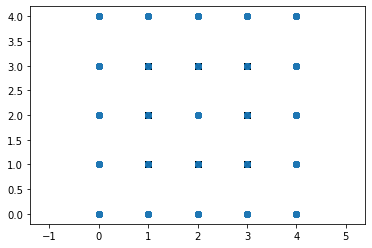

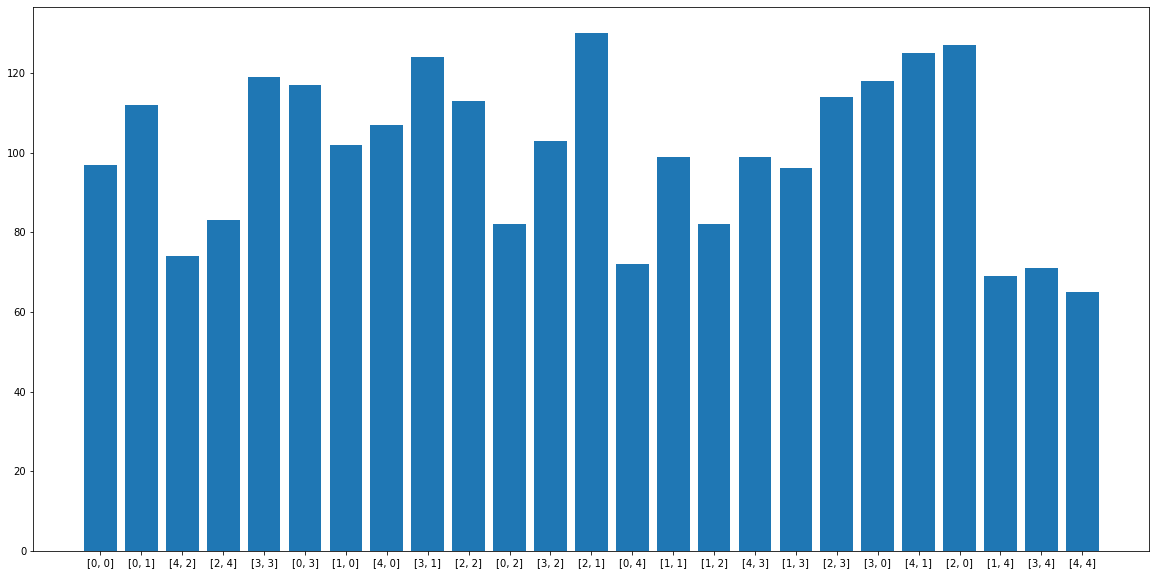

Processing Epoch 8
training start
Iteration 0, d real/fake loss 0.6065739393234253/0.7236822843551636 and g loss is 0.6626752614974976, NDiv loss 0.03315063565969467
Iteration 1, d real/fake loss 0.6057575345039368/0.7249725461006165 and g loss is 0.657354474067688, NDiv loss 0.03369426354765892
Iteration 2, d real/fake loss 0.6049251556396484/0.7313117980957031 and g loss is 0.6599080562591553, NDiv loss 0.030681444332003593
Iteration 3, d real/fake loss 0.6041086316108704/0.727451503276825 and g loss is 0.657859206199646, NDiv loss 0.033843714743852615
Iteration 4, d real/fake loss 0.603215217590332/0.7307089567184448 and g loss is 0.6502072811126709, NDiv loss 0.033959176391363144


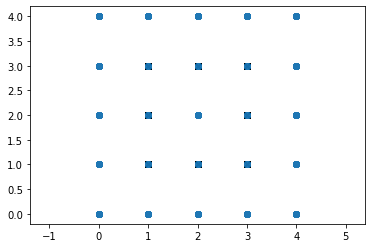

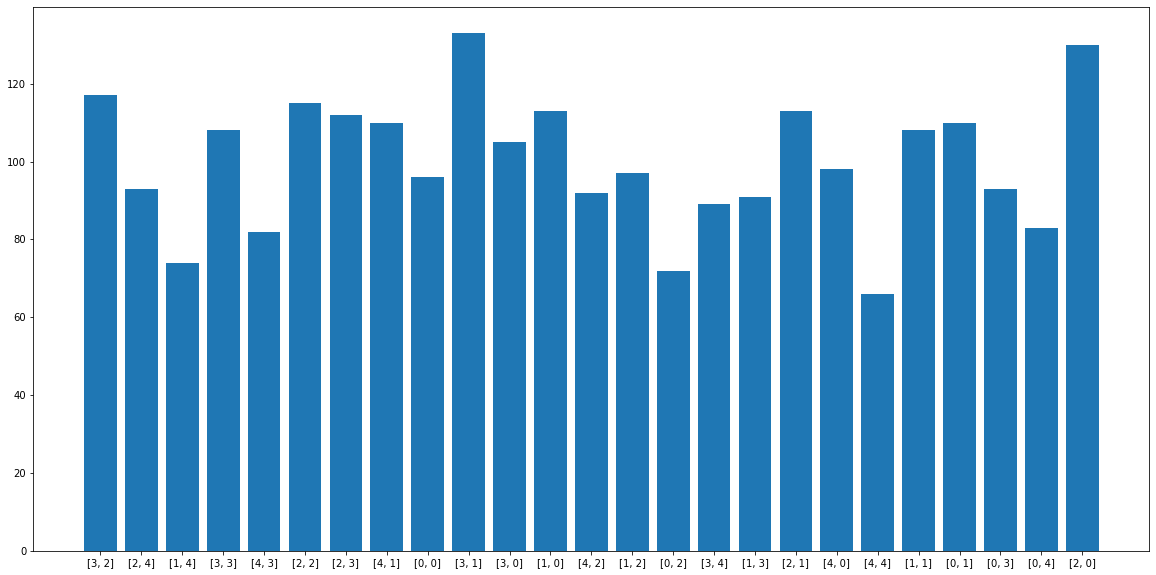

Processing Epoch 9
training start
Iteration 0, d real/fake loss 0.6055941581726074/0.7349022626876831 and g loss is 0.6610439419746399, NDiv loss 0.033053137362003326
Iteration 1, d real/fake loss 0.6047744750976562/0.7305247783660889 and g loss is 0.6492187976837158, NDiv loss 0.032110705971717834
Iteration 2, d real/fake loss 0.6039420366287231/0.7309436202049255 and g loss is 0.6710667610168457, NDiv loss 0.032789114862680435
Iteration 3, d real/fake loss 0.6030939817428589/0.7281976938247681 and g loss is 0.6590986251831055, NDiv loss 0.03324140980839729
Iteration 4, d real/fake loss 0.602289080619812/0.7232074737548828 and g loss is 0.657821536064148, NDiv loss 0.03115539811551571


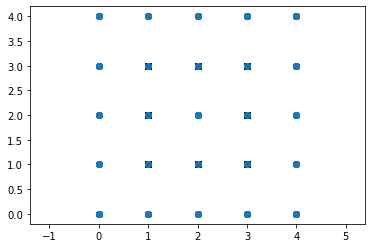

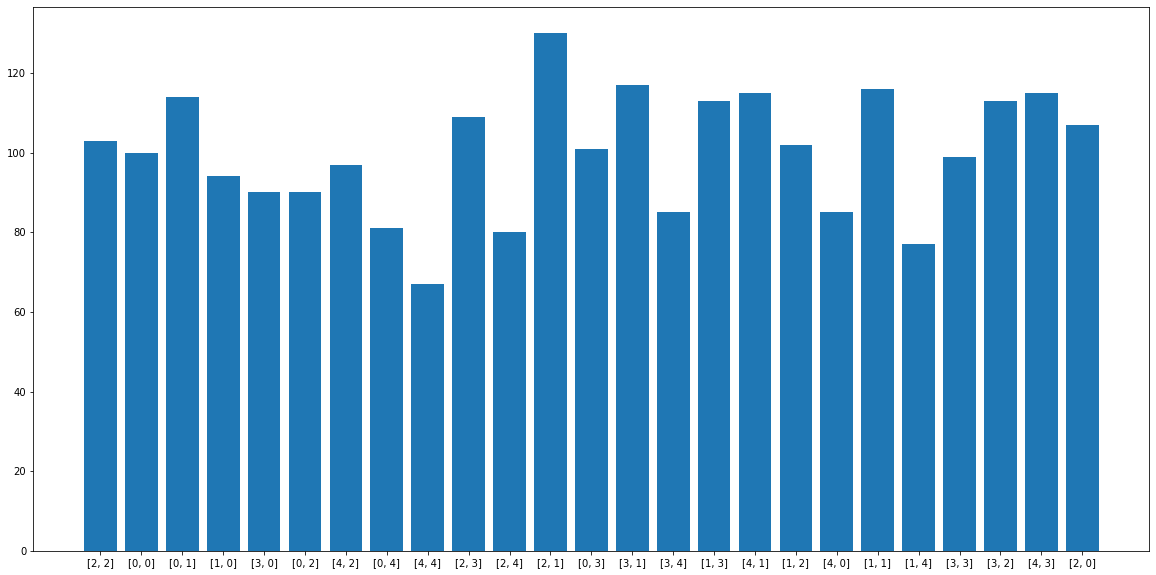

Processing Epoch 10
training start
Iteration 0, d real/fake loss 0.5957074165344238/0.7273931503295898 and g loss is 0.6632579565048218, NDiv loss 0.033598560839891434
Iteration 1, d real/fake loss 0.5949024558067322/0.7257997989654541 and g loss is 0.6530954837799072, NDiv loss 0.031150950118899345
Iteration 2, d real/fake loss 0.5940954089164734/0.7279654741287231 and g loss is 0.6620882153511047, NDiv loss 0.03074744902551174
Iteration 3, d real/fake loss 0.5932809114456177/0.7224159240722656 and g loss is 0.65395188331604, NDiv loss 0.03104965202510357
Iteration 4, d real/fake loss 0.5924385786056519/0.7311619520187378 and g loss is 0.6711956262588501, NDiv loss 0.03465883433818817


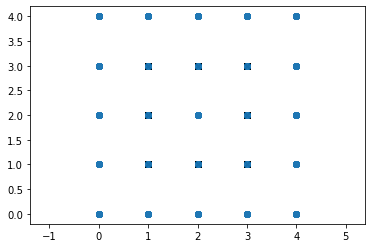

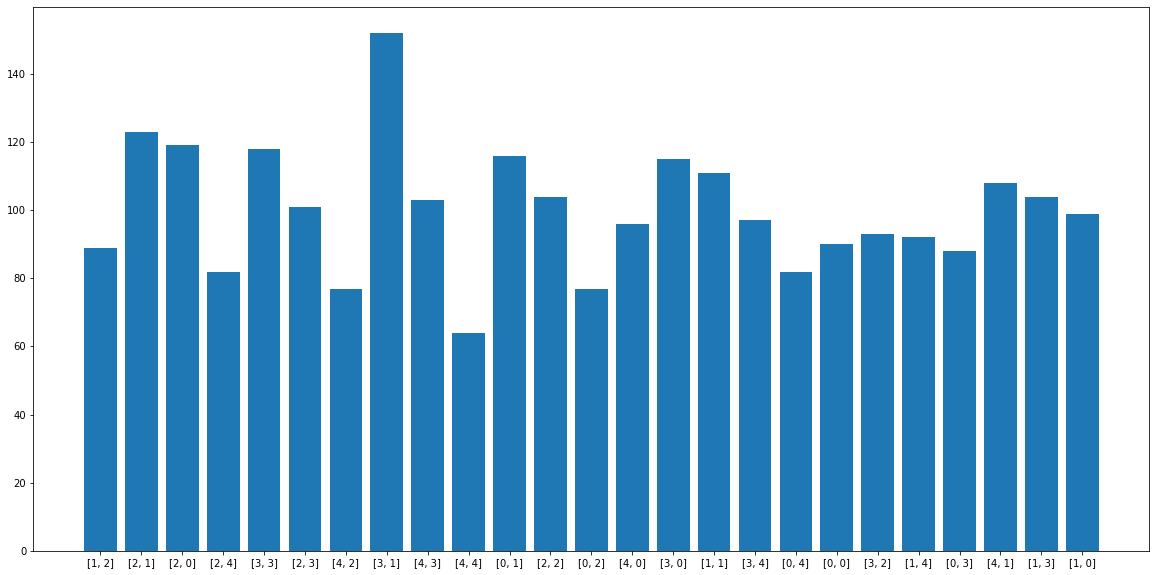

Processing Epoch 11
training start
Iteration 0, d real/fake loss 0.5988754034042358/0.7200590372085571 and g loss is 0.6661319732666016, NDiv loss 0.03328970819711685
Iteration 1, d real/fake loss 0.5982160568237305/0.7314299941062927 and g loss is 0.671363115310669, NDiv loss 0.03416110947728157
Iteration 2, d real/fake loss 0.5975561141967773/0.7323096990585327 and g loss is 0.6636010408401489, NDiv loss 0.03211306035518646
Iteration 3, d real/fake loss 0.5968328714370728/0.7216936945915222 and g loss is 0.6643314361572266, NDiv loss 0.030091222375631332
Iteration 4, d real/fake loss 0.5960636138916016/0.7190057039260864 and g loss is 0.6693666577339172, NDiv loss 0.03162626922130585


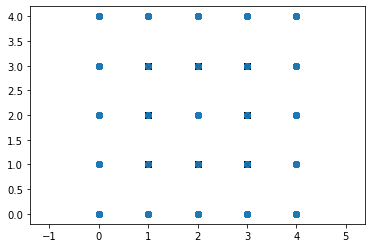

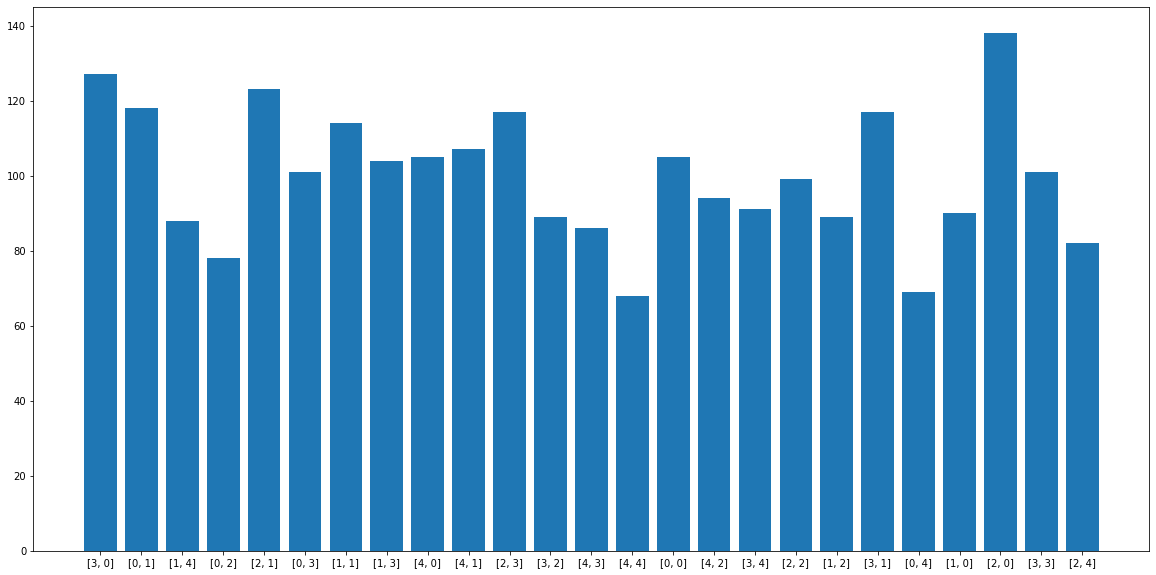

Processing Epoch 12
training start
Iteration 0, d real/fake loss 0.5948537588119507/0.7175997495651245 and g loss is 0.6719532012939453, NDiv loss 0.03287465497851372
Iteration 1, d real/fake loss 0.5940432548522949/0.726864755153656 and g loss is 0.6701940298080444, NDiv loss 0.031633663922548294
Iteration 2, d real/fake loss 0.5932415723800659/0.7209360599517822 and g loss is 0.6735793948173523, NDiv loss 0.030943088233470917
Iteration 3, d real/fake loss 0.5924411416053772/0.703636884689331 and g loss is 0.6677590608596802, NDiv loss 0.03110053576529026
Iteration 4, d real/fake loss 0.5915086269378662/0.730051577091217 and g loss is 0.6833912134170532, NDiv loss 0.03532135859131813


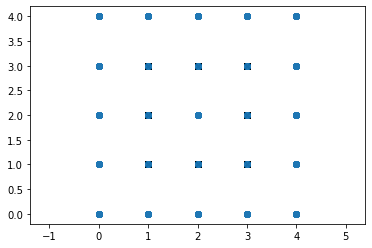

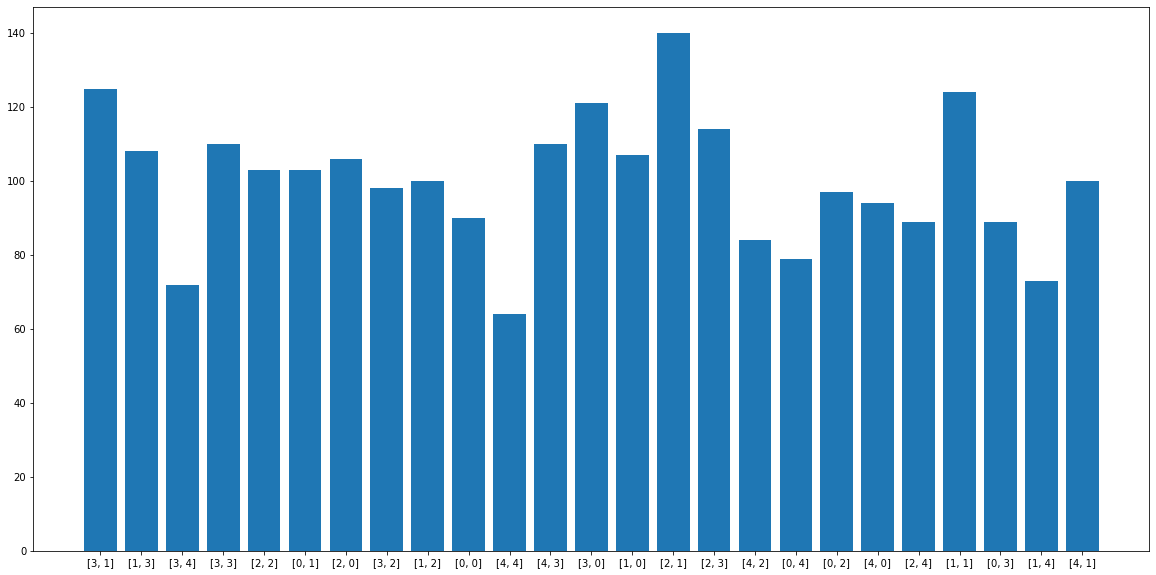

Processing Epoch 13
training start
Iteration 0, d real/fake loss 0.5895712375640869/0.7139765024185181 and g loss is 0.6695272922515869, NDiv loss 0.032641779631376266
Iteration 1, d real/fake loss 0.5887385010719299/0.7228951454162598 and g loss is 0.6767705678939819, NDiv loss 0.03231653571128845
Iteration 2, d real/fake loss 0.5879350304603577/0.7225084900856018 and g loss is 0.6789568662643433, NDiv loss 0.034515492618083954
Iteration 3, d real/fake loss 0.5871596336364746/0.7100263237953186 and g loss is 0.6725655794143677, NDiv loss 0.03252788633108139
Iteration 4, d real/fake loss 0.5863256454467773/0.720770537853241 and g loss is 0.6676251888275146, NDiv loss 0.031042926013469696


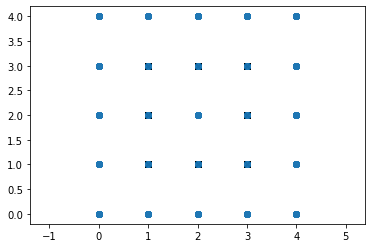

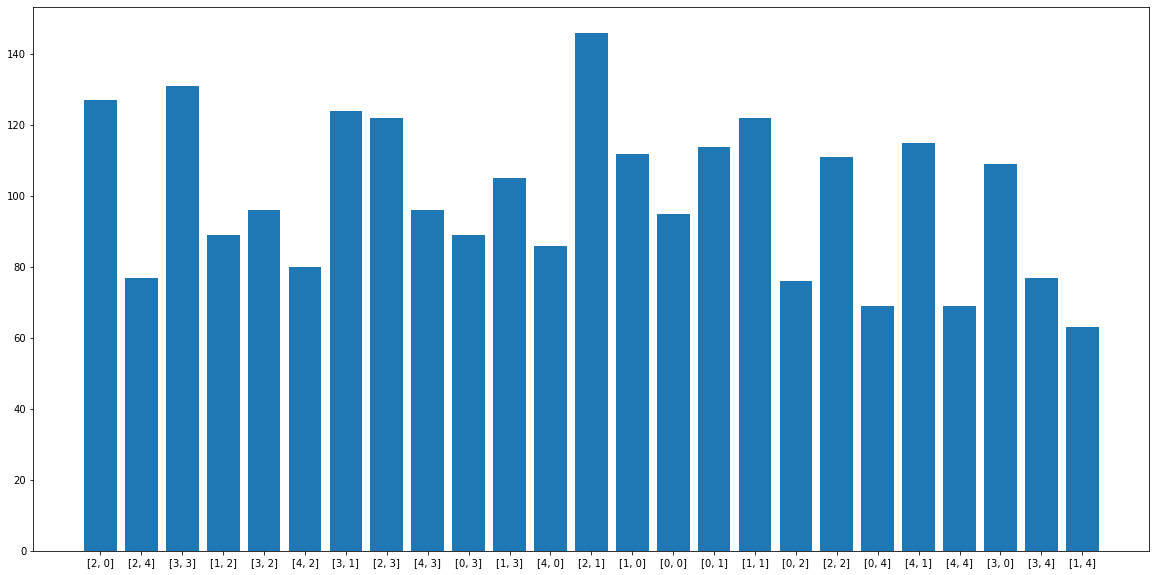

Processing Epoch 14
training start
Iteration 0, d real/fake loss 0.5896808505058289/0.7285788059234619 and g loss is 0.677707314491272, NDiv loss 0.03274264559149742
Iteration 1, d real/fake loss 0.5887987613677979/0.7069582939147949 and g loss is 0.6703883409500122, NDiv loss 0.03400310501456261
Iteration 2, d real/fake loss 0.5878843665122986/0.7260206937789917 and g loss is 0.6738167405128479, NDiv loss 0.03193706274032593
Iteration 3, d real/fake loss 0.5870316028594971/0.7254094481468201 and g loss is 0.6761887073516846, NDiv loss 0.032723262906074524
Iteration 4, d real/fake loss 0.586173415184021/0.7191823124885559 and g loss is 0.6850907802581787, NDiv loss 0.0328369140625


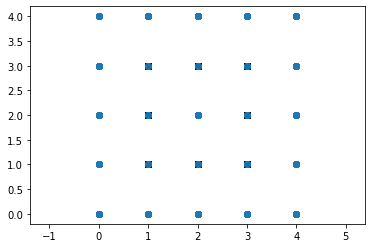

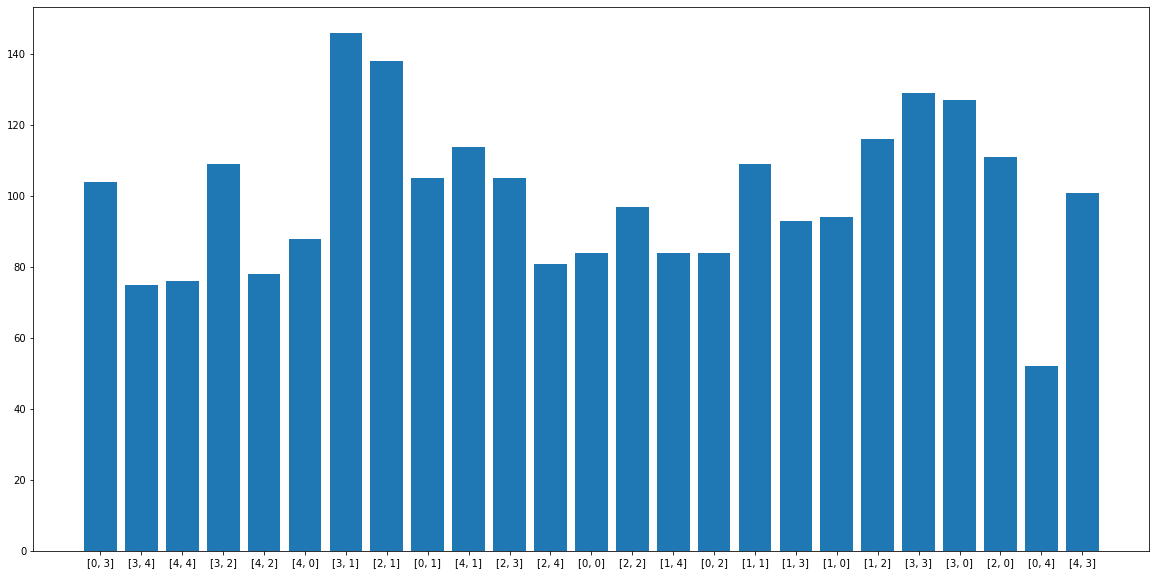

Processing Epoch 15
training start
Iteration 0, d real/fake loss 0.5791845917701721/0.7207971811294556 and g loss is 0.6669527292251587, NDiv loss 0.031713515520095825
Iteration 1, d real/fake loss 0.5785252451896667/0.7245304584503174 and g loss is 0.675856351852417, NDiv loss 0.03535555675625801
Iteration 2, d real/fake loss 0.5778807401657104/0.71544349193573 and g loss is 0.6751446723937988, NDiv loss 0.032470449805259705
Iteration 3, d real/fake loss 0.5772556662559509/0.7074357271194458 and g loss is 0.6876529455184937, NDiv loss 0.0315365195274353
Iteration 4, d real/fake loss 0.5765817165374756/0.702877402305603 and g loss is 0.669198751449585, NDiv loss 0.031045813113451004


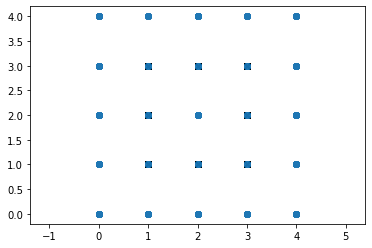

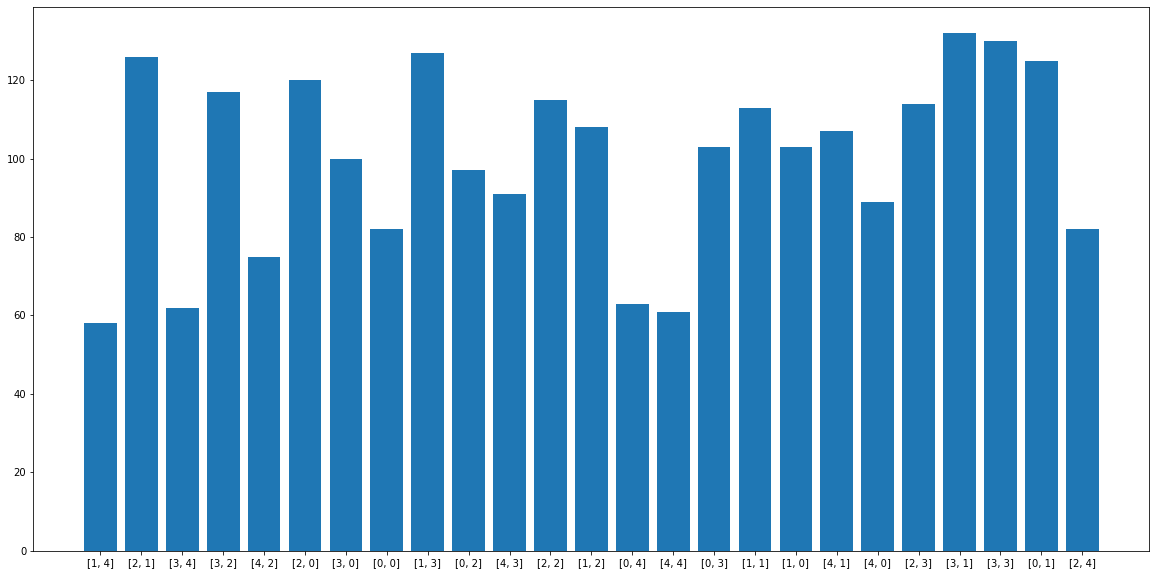

Processing Epoch 16
training start
Iteration 0, d real/fake loss 0.5762089490890503/0.7233302593231201 and g loss is 0.6946085691452026, NDiv loss 0.03168724849820137
Iteration 1, d real/fake loss 0.5756309032440186/0.7093841433525085 and g loss is 0.6818833351135254, NDiv loss 0.033365607261657715
Iteration 2, d real/fake loss 0.5749515295028687/0.71024489402771 and g loss is 0.6997054815292358, NDiv loss 0.030913379043340683
Iteration 3, d real/fake loss 0.5741580724716187/0.7187315225601196 and g loss is 0.6899206638336182, NDiv loss 0.035085976123809814
Iteration 4, d real/fake loss 0.5734573006629944/0.7193854451179504 and g loss is 0.6933507919311523, NDiv loss 0.03092327155172825


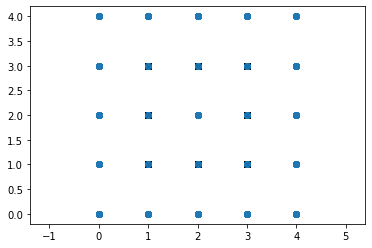

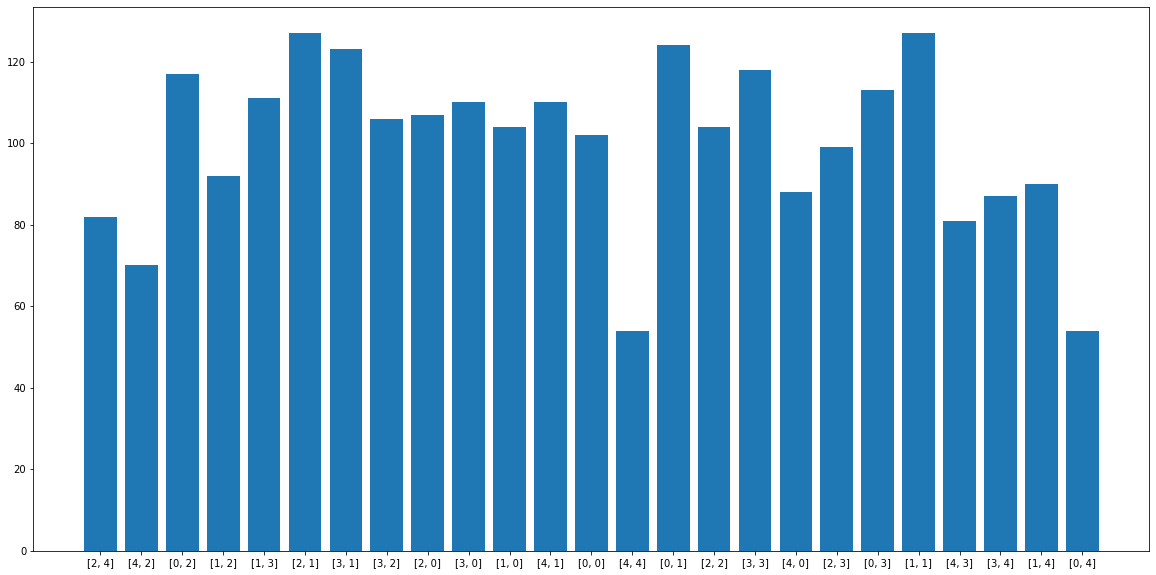

Processing Epoch 17
training start
Iteration 0, d real/fake loss 0.5786540508270264/0.720041036605835 and g loss is 0.691092848777771, NDiv loss 0.029384566470980644
Iteration 1, d real/fake loss 0.5779871940612793/0.7320910692214966 and g loss is 0.686631441116333, NDiv loss 0.03359786793589592
Iteration 2, d real/fake loss 0.5773544311523438/0.716952919960022 and g loss is 0.6891927719116211, NDiv loss 0.03258626535534859
Iteration 3, d real/fake loss 0.5766892433166504/0.7259439826011658 and g loss is 0.6912065744400024, NDiv loss 0.032149434089660645
Iteration 4, d real/fake loss 0.5760842561721802/0.7171940207481384 and g loss is 0.6646796464920044, NDiv loss 0.033095743507146835


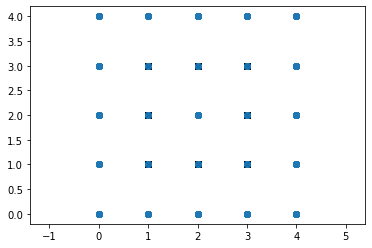

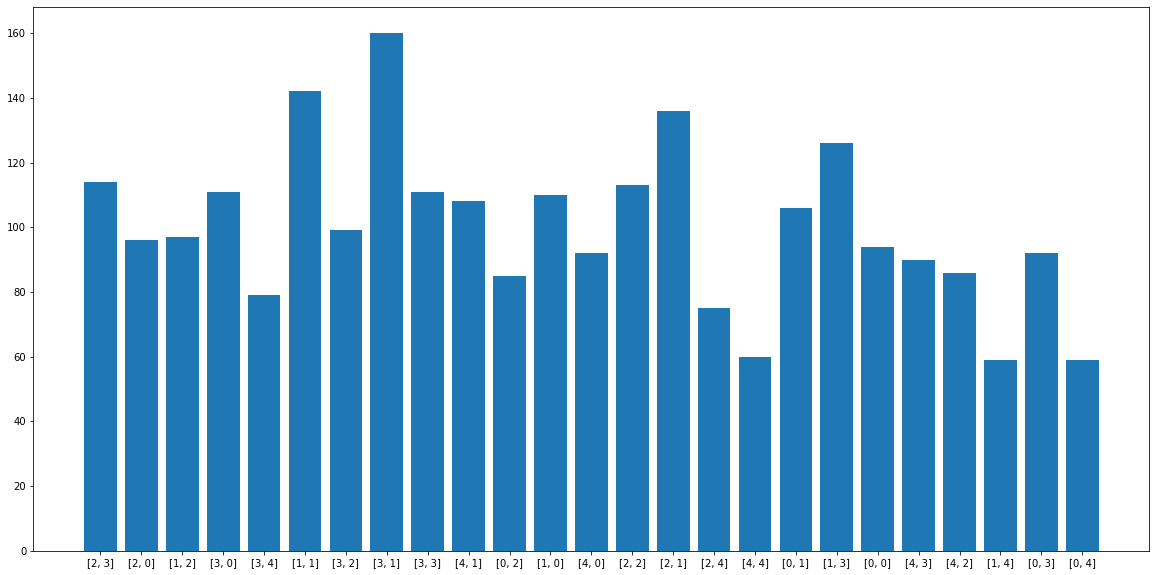

Processing Epoch 18
training start
Iteration 0, d real/fake loss 0.5763890743255615/0.7149893045425415 and g loss is 0.686841607093811, NDiv loss 0.03222116082906723
Iteration 1, d real/fake loss 0.5757343173027039/0.7153271436691284 and g loss is 0.6856883764266968, NDiv loss 0.031065665185451508
Iteration 2, d real/fake loss 0.5750477910041809/0.7054654359817505 and g loss is 0.6831206679344177, NDiv loss 0.032379403710365295
Iteration 3, d real/fake loss 0.5743628144264221/0.706432580947876 and g loss is 0.688766360282898, NDiv loss 0.03238134831190109
Iteration 4, d real/fake loss 0.5736876726150513/0.682993471622467 and g loss is 0.7093919515609741, NDiv loss 0.031250789761543274


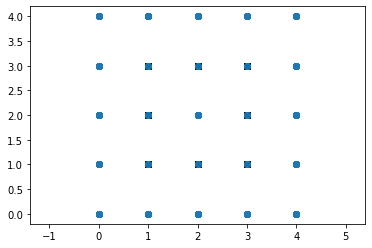

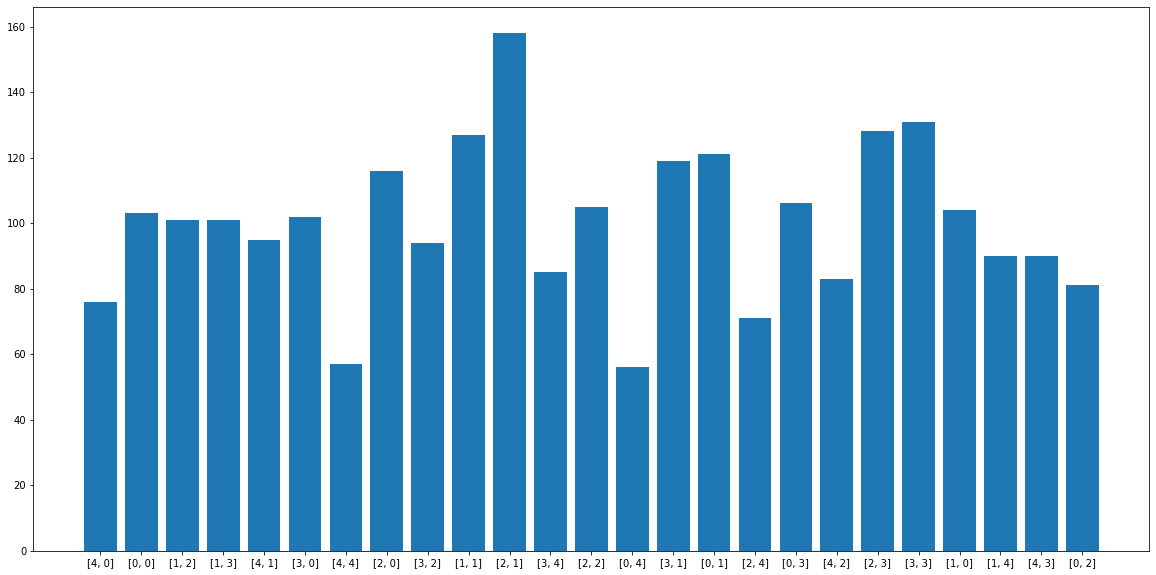

Processing Epoch 19
training start
Iteration 0, d real/fake loss 0.5749289989471436/0.7198288440704346 and g loss is 0.6894953846931458, NDiv loss 0.031325262039899826
Iteration 1, d real/fake loss 0.5741565227508545/0.6966722011566162 and g loss is 0.6870818138122559, NDiv loss 0.036491092294454575
Iteration 2, d real/fake loss 0.5733510851860046/0.7249287366867065 and g loss is 0.6976794004440308, NDiv loss 0.035141702741384506
Iteration 3, d real/fake loss 0.5726732015609741/0.7196319699287415 and g loss is 0.7096899747848511, NDiv loss 0.032143011689186096
Iteration 4, d real/fake loss 0.5719886422157288/0.6972136497497559 and g loss is 0.6955915689468384, NDiv loss 0.031101195141673088


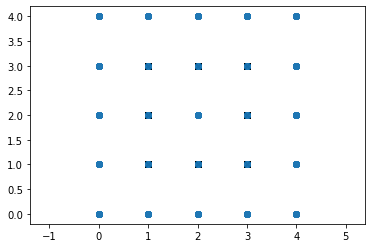

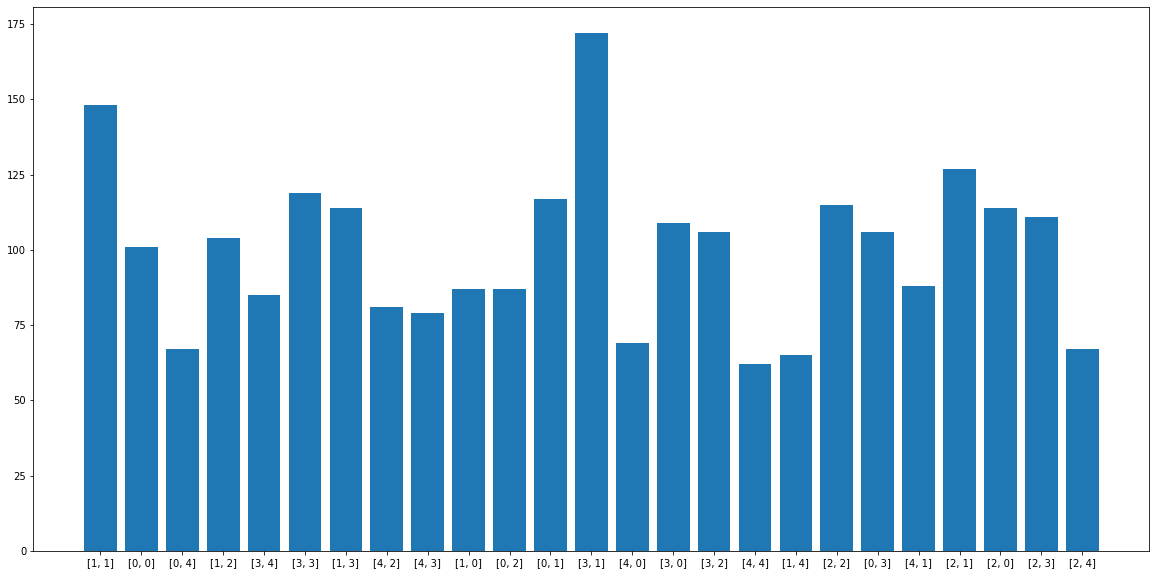

Processing Epoch 20
training start
Iteration 0, d real/fake loss 0.5653848648071289/0.6984561681747437 and g loss is 0.6702159643173218, NDiv loss 0.032844215631484985
Iteration 1, d real/fake loss 0.5647855997085571/0.7035563588142395 and g loss is 0.685536801815033, NDiv loss 0.03130856528878212
Iteration 2, d real/fake loss 0.5642674565315247/0.7170864343643188 and g loss is 0.6900449991226196, NDiv loss 0.032734423875808716
Iteration 3, d real/fake loss 0.5638157725334167/0.6846940517425537 and g loss is 0.6955479383468628, NDiv loss 0.03415354713797569
Iteration 4, d real/fake loss 0.5632979273796082/0.6909029483795166 and g loss is 0.7061371207237244, NDiv loss 0.03413904458284378


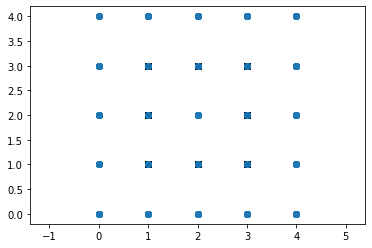

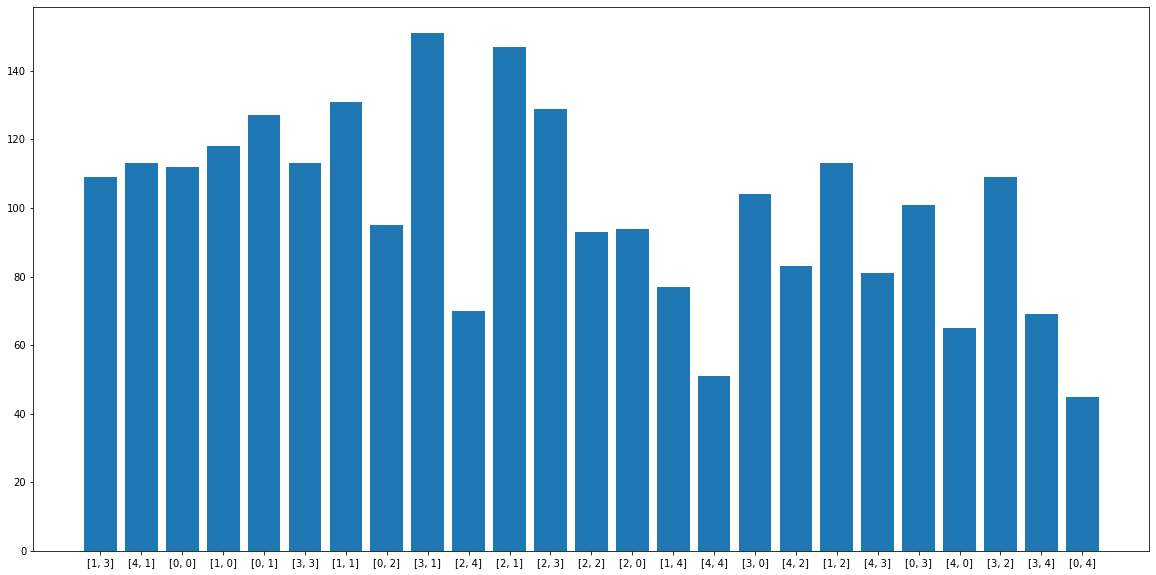

Processing Epoch 21
training start
Iteration 0, d real/fake loss 0.563697338104248/0.7056869864463806 and g loss is 0.7300581932067871, NDiv loss 0.031070495024323463
Iteration 1, d real/fake loss 0.563183605670929/0.7068415880203247 and g loss is 0.6827334761619568, NDiv loss 0.03239261358976364
Iteration 2, d real/fake loss 0.5626939535140991/0.6975748538970947 and g loss is 0.7032470703125, NDiv loss 0.031692616641521454
Iteration 3, d real/fake loss 0.562162458896637/0.7141237258911133 and g loss is 0.7058833241462708, NDiv loss 0.033991098403930664
Iteration 4, d real/fake loss 0.5616542100906372/0.7091062068939209 and g loss is 0.7150232195854187, NDiv loss 0.031093591824173927


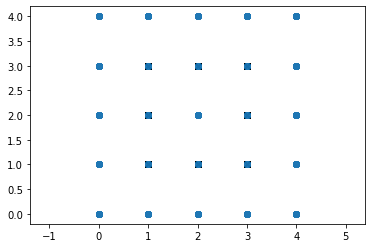

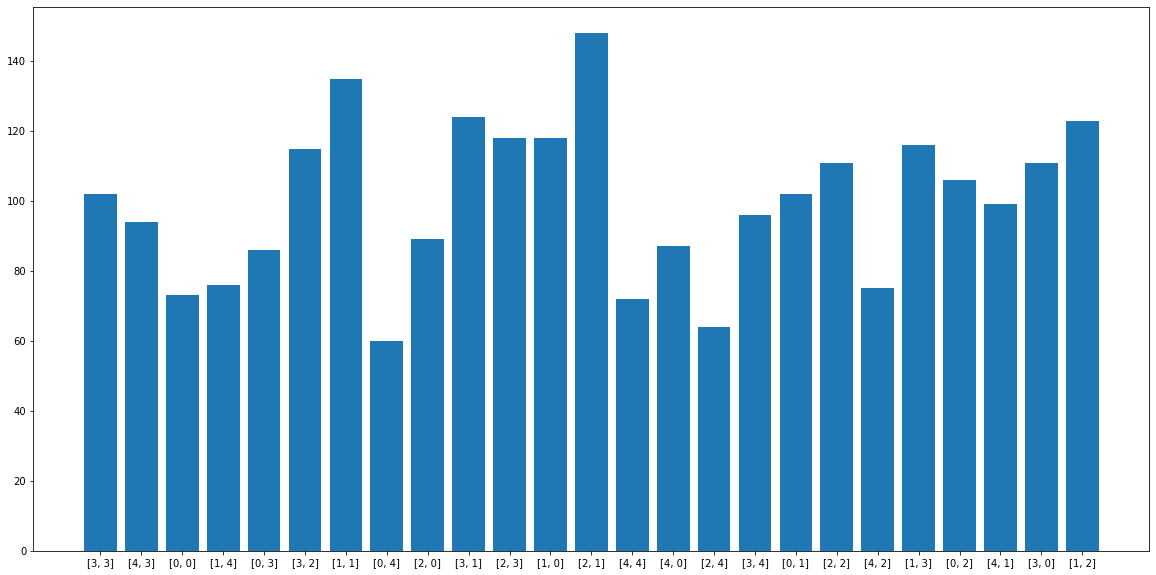

Processing Epoch 22
training start
Iteration 0, d real/fake loss 0.5561516284942627/0.6963979005813599 and g loss is 0.6904391050338745, NDiv loss 0.03688909113407135
Iteration 1, d real/fake loss 0.5556409955024719/0.7039852142333984 and g loss is 0.6935290098190308, NDiv loss 0.03594174236059189
Iteration 2, d real/fake loss 0.5552453398704529/0.7092869281768799 and g loss is 0.7043128609657288, NDiv loss 0.034223850816488266
Iteration 3, d real/fake loss 0.5548019409179688/0.7021825313568115 and g loss is 0.692561686038971, NDiv loss 0.033519111573696136
Iteration 4, d real/fake loss 0.5543729066848755/0.7131152749061584 and g loss is 0.7019999027252197, NDiv loss 0.032899510115385056


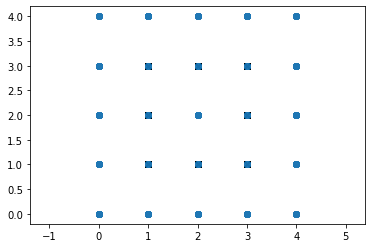

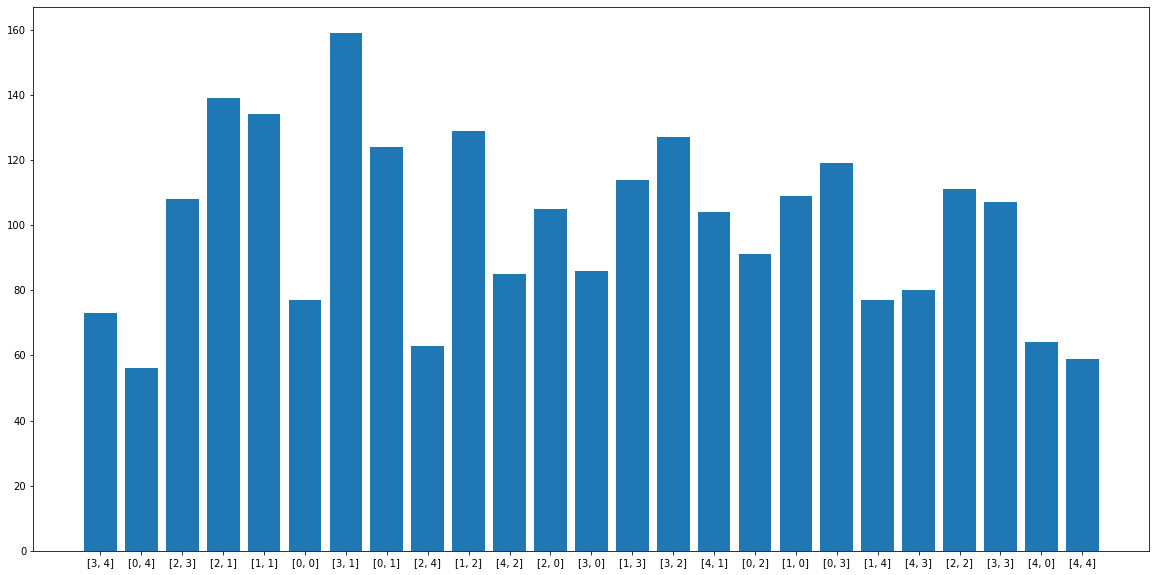

Processing Epoch 23
training start
Iteration 0, d real/fake loss 0.5670543909072876/0.6882680058479309 and g loss is 0.7313985228538513, NDiv loss 0.0336768701672554
Iteration 1, d real/fake loss 0.5667489767074585/0.6961808204650879 and g loss is 0.6960155963897705, NDiv loss 0.03474964201450348
Iteration 2, d real/fake loss 0.5662822127342224/0.691601574420929 and g loss is 0.7029767036437988, NDiv loss 0.0319376178085804
Iteration 3, d real/fake loss 0.5657958984375/0.6899892091751099 and g loss is 0.7171573638916016, NDiv loss 0.032612673938274384
Iteration 4, d real/fake loss 0.5652521252632141/0.7104822397232056 and g loss is 0.7091065645217896, NDiv loss 0.03279886767268181


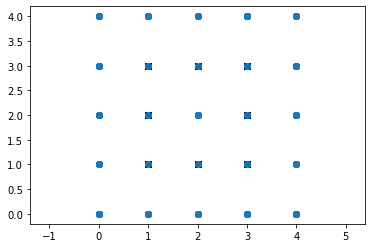

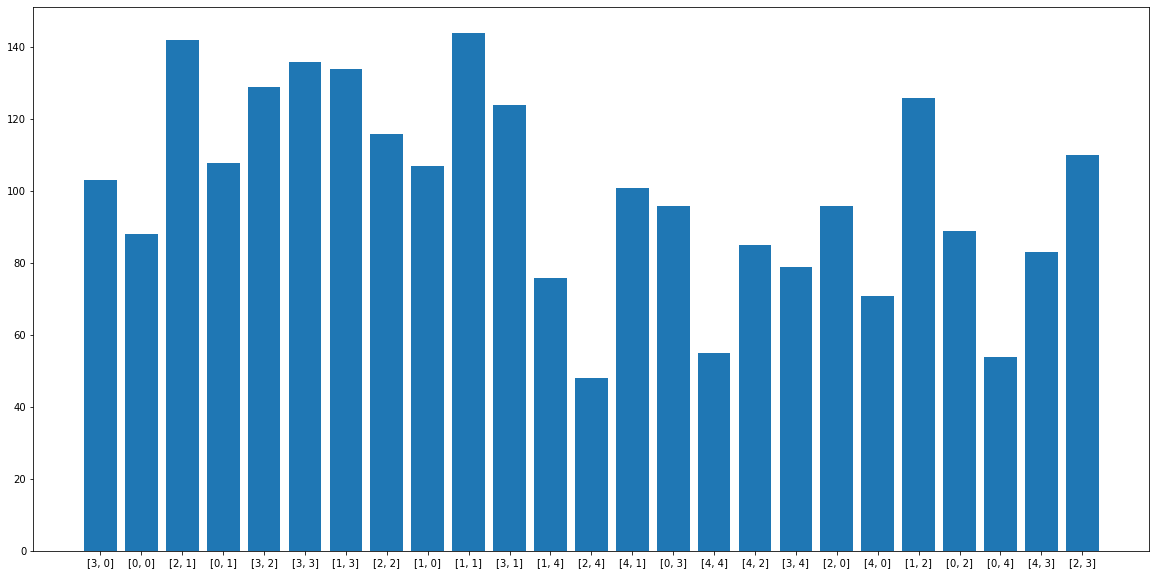

Processing Epoch 24
training start
Iteration 0, d real/fake loss 0.5606492757797241/0.7249087691307068 and g loss is 0.7070883512496948, NDiv loss 0.036932338029146194
Iteration 1, d real/fake loss 0.5603430867195129/0.6921018362045288 and g loss is 0.6907625198364258, NDiv loss 0.03347775340080261
Iteration 2, d real/fake loss 0.5600507259368896/0.7066835165023804 and g loss is 0.6949004530906677, NDiv loss 0.031419966369867325
Iteration 3, d real/fake loss 0.5598406195640564/0.6981871128082275 and g loss is 0.7221370339393616, NDiv loss 0.03602123633027077
Iteration 4, d real/fake loss 0.5595496892929077/0.6876437067985535 and g loss is 0.7187273502349854, NDiv loss 0.032233741134405136


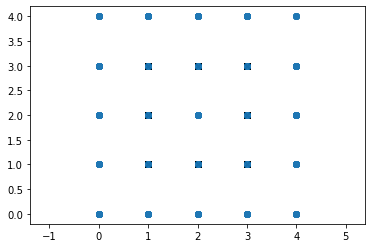

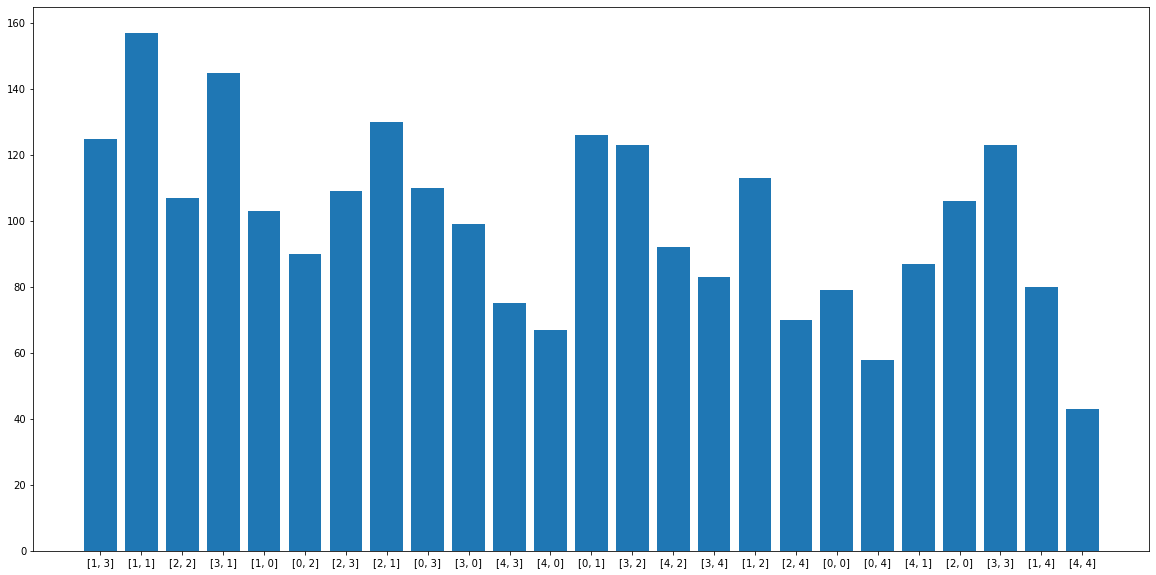

Processing Epoch 25
training start
Iteration 0, d real/fake loss 0.5570176243782043/0.6814117431640625 and g loss is 0.7101631164550781, NDiv loss 0.032265931367874146
Iteration 1, d real/fake loss 0.5564181804656982/0.6782256960868835 and g loss is 0.6985742449760437, NDiv loss 0.03368718922138214
Iteration 2, d real/fake loss 0.5556367635726929/0.6892173290252686 and g loss is 0.6859880685806274, NDiv loss 0.03194676339626312
Iteration 3, d real/fake loss 0.5548624992370605/0.6762075424194336 and g loss is 0.6989130973815918, NDiv loss 0.03319302201271057
Iteration 4, d real/fake loss 0.5541210174560547/0.6940988302230835 and g loss is 0.7018844485282898, NDiv loss 0.03385030850768089


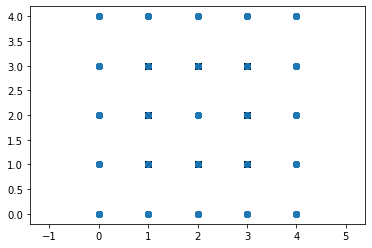

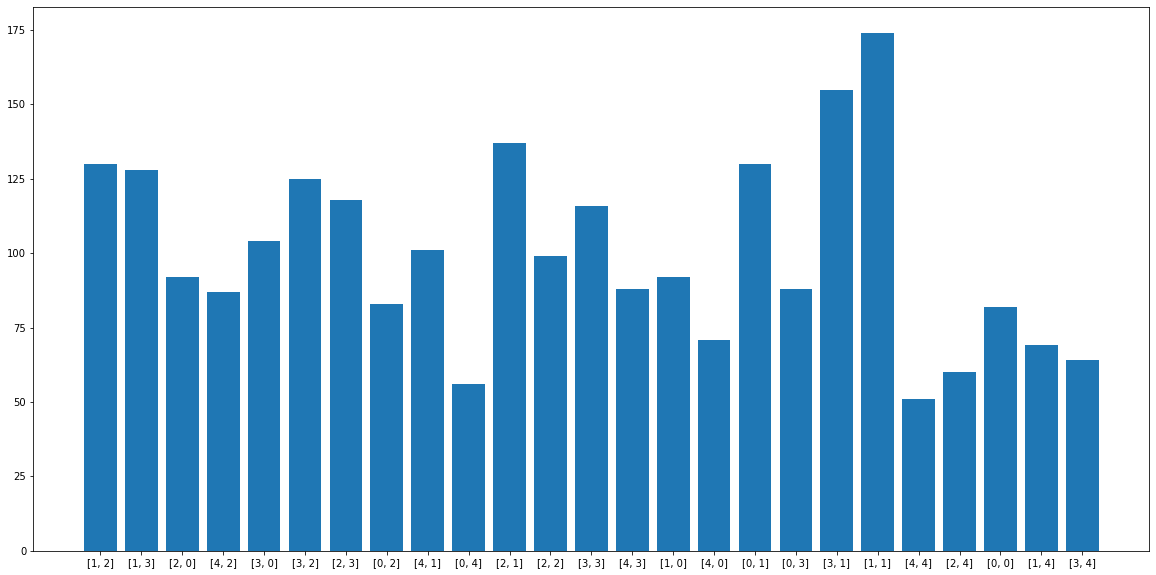

Processing Epoch 26
training start
Iteration 0, d real/fake loss 0.557998538017273/0.701621413230896 and g loss is 0.7085607051849365, NDiv loss 0.03342435508966446
Iteration 1, d real/fake loss 0.5574661493301392/0.6846533417701721 and g loss is 0.6998716592788696, NDiv loss 0.034600630402565
Iteration 2, d real/fake loss 0.5568702220916748/0.6960172057151794 and g loss is 0.7281455397605896, NDiv loss 0.03575168550014496
Iteration 3, d real/fake loss 0.5564154386520386/0.6755393743515015 and g loss is 0.7264150381088257, NDiv loss 0.035271089524030685
Iteration 4, d real/fake loss 0.5559811592102051/0.676118791103363 and g loss is 0.6983655095100403, NDiv loss 0.03170648217201233


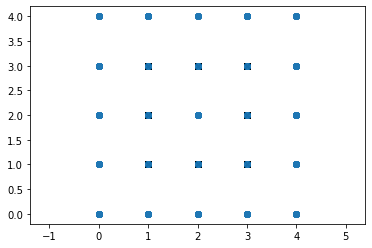

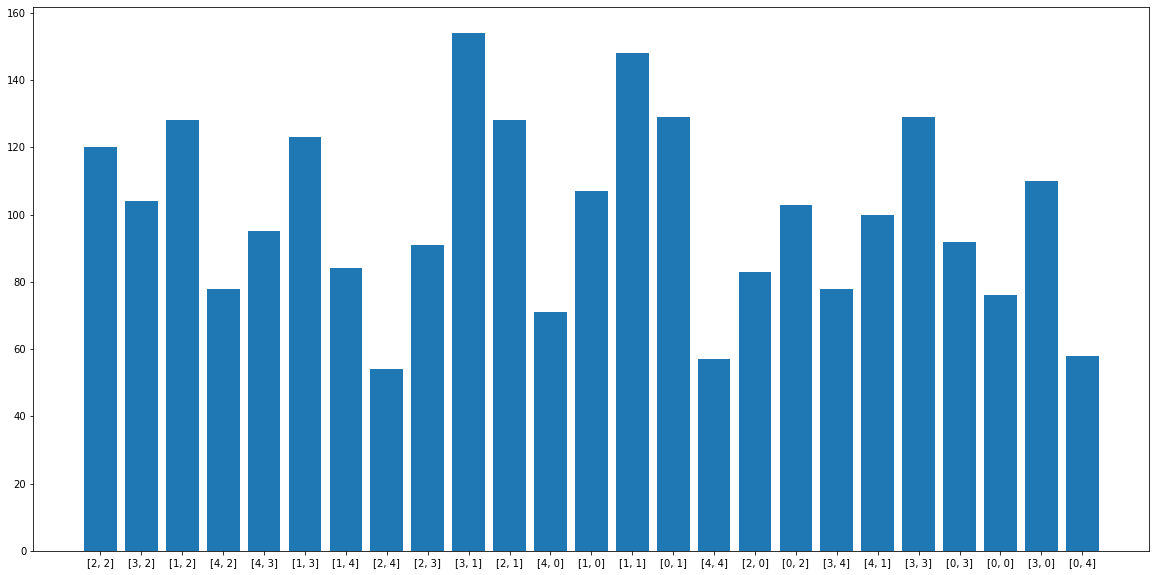

Processing Epoch 27
training start
Iteration 0, d real/fake loss 0.5512146353721619/0.6874386072158813 and g loss is 0.71446692943573, NDiv loss 0.033475857228040695
Iteration 1, d real/fake loss 0.5508043169975281/0.675094485282898 and g loss is 0.7285600900650024, NDiv loss 0.03399844467639923
Iteration 2, d real/fake loss 0.5503941774368286/0.6847769021987915 and g loss is 0.726949155330658, NDiv loss 0.03374579921364784
Iteration 3, d real/fake loss 0.5499117374420166/0.7005189061164856 and g loss is 0.7278141975402832, NDiv loss 0.03473340719938278
Iteration 4, d real/fake loss 0.5494031310081482/0.6961544156074524 and g loss is 0.7502357959747314, NDiv loss 0.03209458291530609


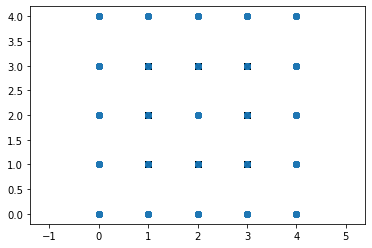

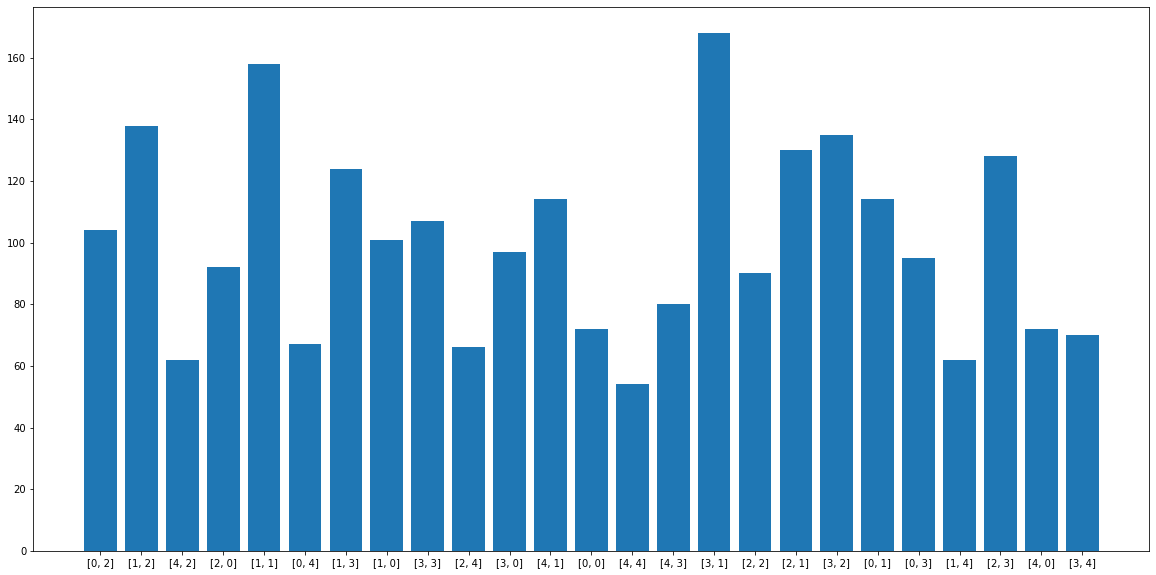

Processing Epoch 28
training start
Iteration 0, d real/fake loss 0.5524858236312866/0.706675112247467 and g loss is 0.7285938858985901, NDiv loss 0.03267717361450195
Iteration 1, d real/fake loss 0.5521758198738098/0.6812711358070374 and g loss is 0.7307323217391968, NDiv loss 0.037981946021318436
Iteration 2, d real/fake loss 0.5517738461494446/0.7143777012825012 and g loss is 0.7389726638793945, NDiv loss 0.03357937932014465
Iteration 3, d real/fake loss 0.5513838529586792/0.6886427402496338 and g loss is 0.7516464591026306, NDiv loss 0.034523386508226395
Iteration 4, d real/fake loss 0.5509572625160217/0.7150095701217651 and g loss is 0.7469481229782104, NDiv loss 0.033657316118478775


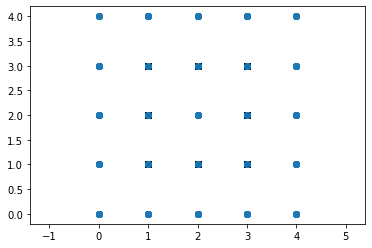

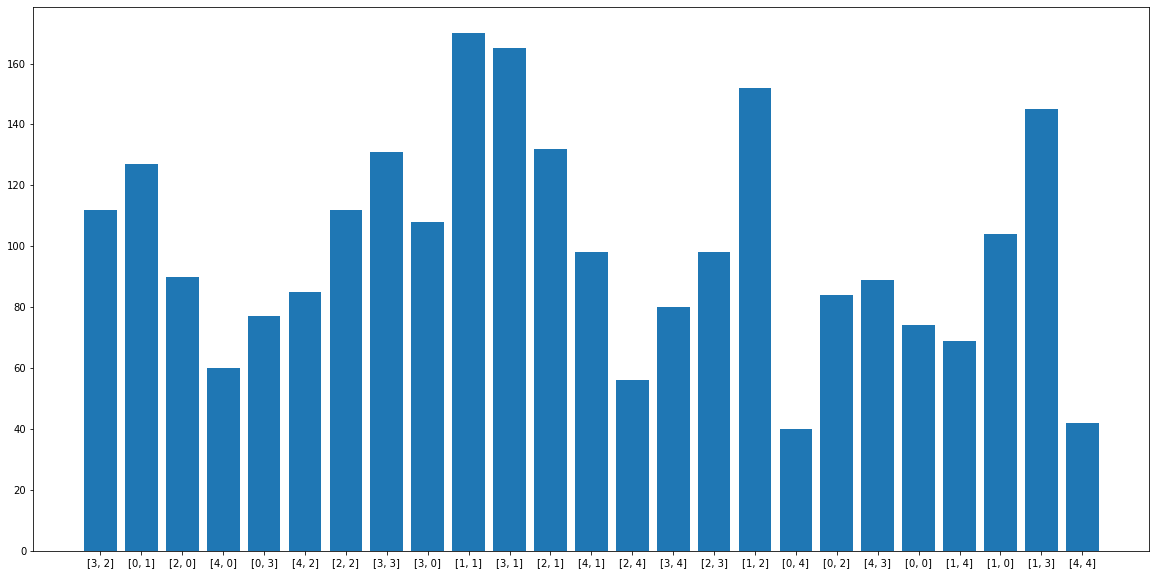

Processing Epoch 29
training start
Iteration 0, d real/fake loss 0.5517576336860657/0.6927826404571533 and g loss is 0.7316197156906128, NDiv loss 0.03403538838028908
Iteration 1, d real/fake loss 0.5513161420822144/0.6687761545181274 and g loss is 0.745032548904419, NDiv loss 0.03249955177307129
Iteration 2, d real/fake loss 0.5506523847579956/0.7002865672111511 and g loss is 0.746977686882019, NDiv loss 0.03277033939957619
Iteration 3, d real/fake loss 0.5499321818351746/0.671161413192749 and g loss is 0.704007089138031, NDiv loss 0.03267703577876091
Iteration 4, d real/fake loss 0.5492383241653442/0.7142640948295593 and g loss is 0.7479199767112732, NDiv loss 0.032994989305734634


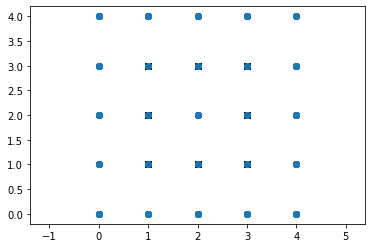

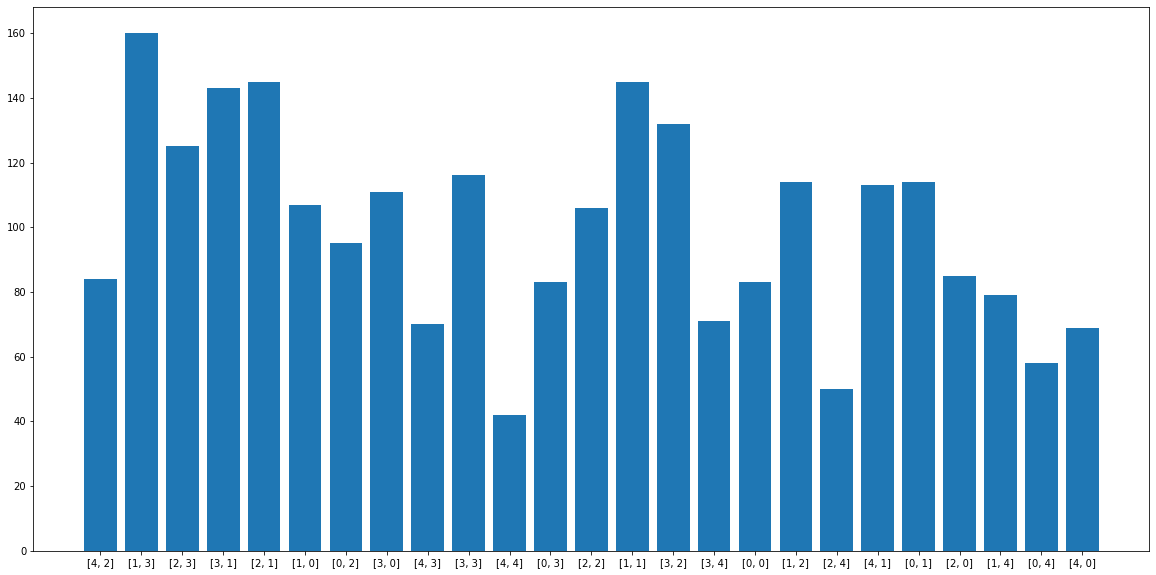

Processing Epoch 30
training start
Iteration 0, d real/fake loss 0.5472468733787537/0.6712703704833984 and g loss is 0.7274284362792969, NDiv loss 0.03281339630484581
Iteration 1, d real/fake loss 0.5467886924743652/0.6894797086715698 and g loss is 0.7300708293914795, NDiv loss 0.03367217630147934
Iteration 2, d real/fake loss 0.5462265014648438/0.6676405668258667 and g loss is 0.7580780982971191, NDiv loss 0.032664231956005096
Iteration 3, d real/fake loss 0.5456084609031677/0.7115424871444702 and g loss is 0.7016986608505249, NDiv loss 0.03346327319741249
Iteration 4, d real/fake loss 0.5451797246932983/0.6704769730567932 and g loss is 0.7561530470848083, NDiv loss 0.03479950875043869


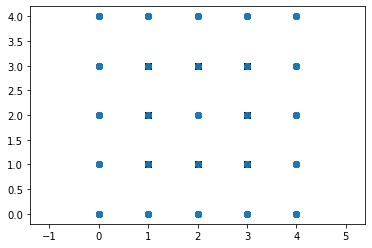

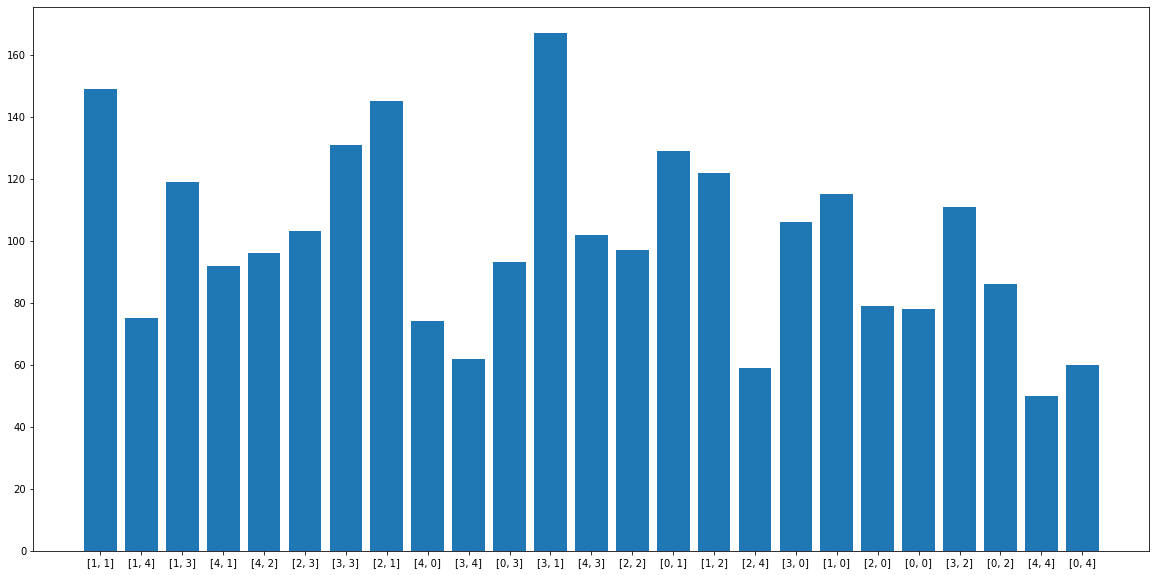

Processing Epoch 31
training start
Iteration 0, d real/fake loss 0.5420457124710083/0.6798655986785889 and g loss is 0.7375630140304565, NDiv loss 0.0329698845744133
Iteration 1, d real/fake loss 0.5415626764297485/0.6533896923065186 and g loss is 0.7337381839752197, NDiv loss 0.03322465717792511
Iteration 2, d real/fake loss 0.5409053564071655/0.7000614404678345 and g loss is 0.7991406321525574, NDiv loss 0.0352352112531662
Iteration 3, d real/fake loss 0.5402984619140625/0.6796844005584717 and g loss is 0.724599301815033, NDiv loss 0.03684940189123154
Iteration 4, d real/fake loss 0.5397511720657349/0.6404704451560974 and g loss is 0.748698890209198, NDiv loss 0.035379115492105484


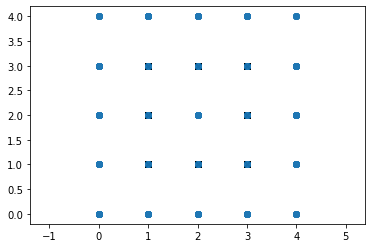

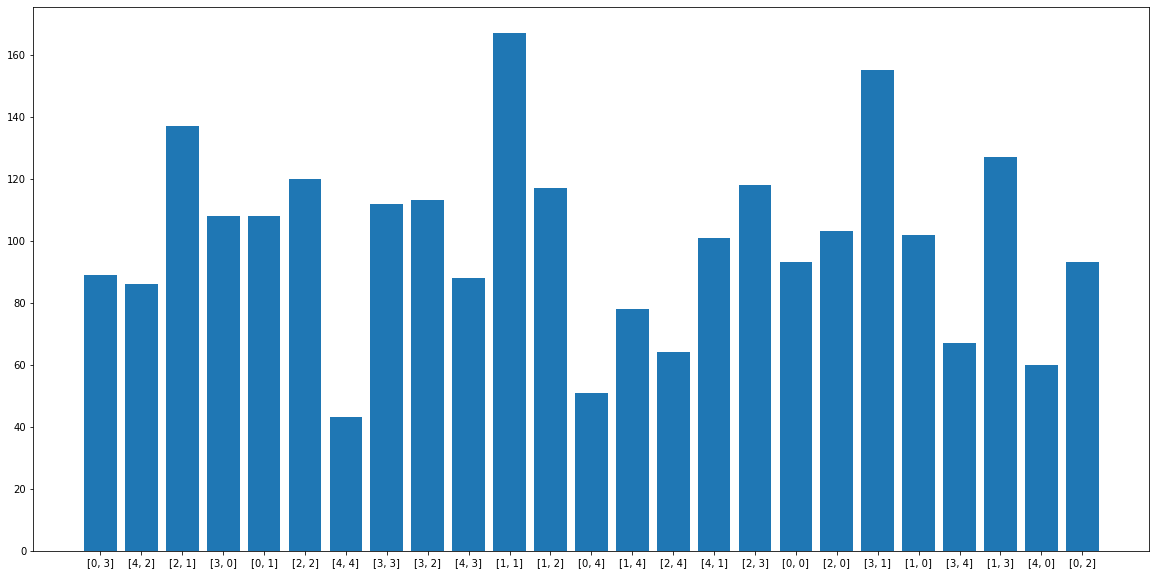

Processing Epoch 32
training start
Iteration 0, d real/fake loss 0.5491067171096802/0.6405140161514282 and g loss is 0.775556206703186, NDiv loss 0.0336102694272995
Iteration 1, d real/fake loss 0.5482900142669678/0.6811056137084961 and g loss is 0.7148083448410034, NDiv loss 0.034903280436992645
Iteration 2, d real/fake loss 0.5474714040756226/0.6500211358070374 and g loss is 0.7258039116859436, NDiv loss 0.033447954803705215
Iteration 3, d real/fake loss 0.5465583801269531/0.6783497929573059 and g loss is 0.7153961658477783, NDiv loss 0.03536973148584366
Iteration 4, d real/fake loss 0.54571533203125/0.7119006514549255 and g loss is 0.7250974178314209, NDiv loss 0.03332359343767166


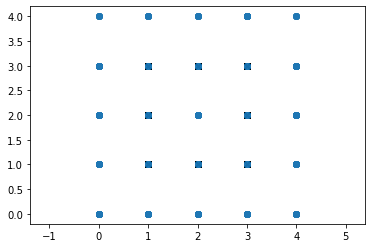

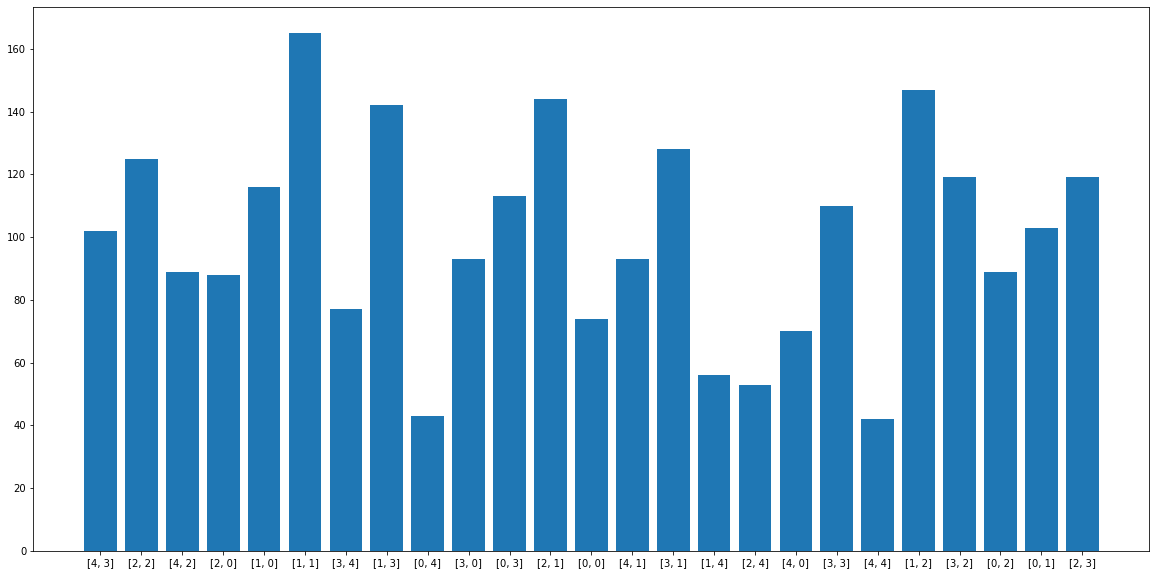

Processing Epoch 33
training start
Iteration 0, d real/fake loss 0.5430181622505188/0.6510820388793945 and g loss is 0.7422769069671631, NDiv loss 0.03392762690782547
Iteration 1, d real/fake loss 0.5424951910972595/0.6894638538360596 and g loss is 0.7619662284851074, NDiv loss 0.03264652192592621
Iteration 2, d real/fake loss 0.5420390367507935/0.6420193314552307 and g loss is 0.7153682112693787, NDiv loss 0.03324168547987938
Iteration 3, d real/fake loss 0.5413846373558044/0.6880737543106079 and g loss is 0.7823257446289062, NDiv loss 0.03389676287770271
Iteration 4, d real/fake loss 0.5407540202140808/0.6680020689964294 and g loss is 0.7557511329650879, NDiv loss 0.036435119807720184


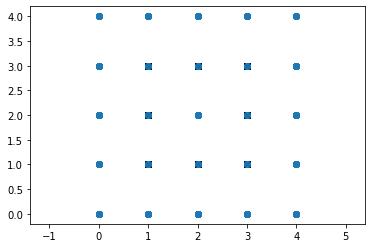

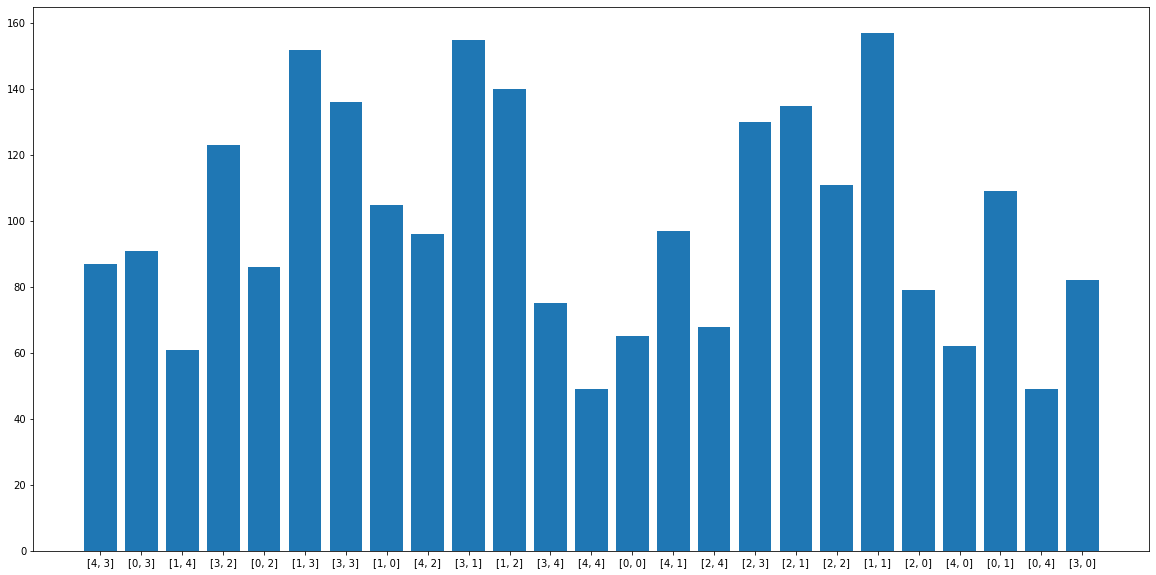

Processing Epoch 34
training start
Iteration 0, d real/fake loss 0.5385869145393372/0.6651530861854553 and g loss is 0.7559530735015869, NDiv loss 0.03330584987998009
Iteration 1, d real/fake loss 0.5379658937454224/0.6659578084945679 and g loss is 0.7461625337600708, NDiv loss 0.03553912788629532
Iteration 2, d real/fake loss 0.5372841358184814/0.6649446487426758 and g loss is 0.74366295337677, NDiv loss 0.03652004897594452
Iteration 3, d real/fake loss 0.536554217338562/0.666427493095398 and g loss is 0.774215579032898, NDiv loss 0.0332162082195282
Iteration 4, d real/fake loss 0.5357407331466675/0.6782388687133789 and g loss is 0.7561392784118652, NDiv loss 0.03600892424583435


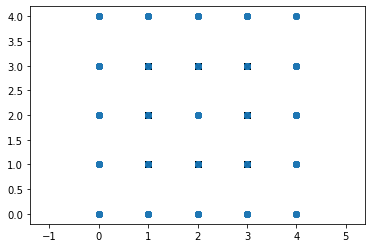

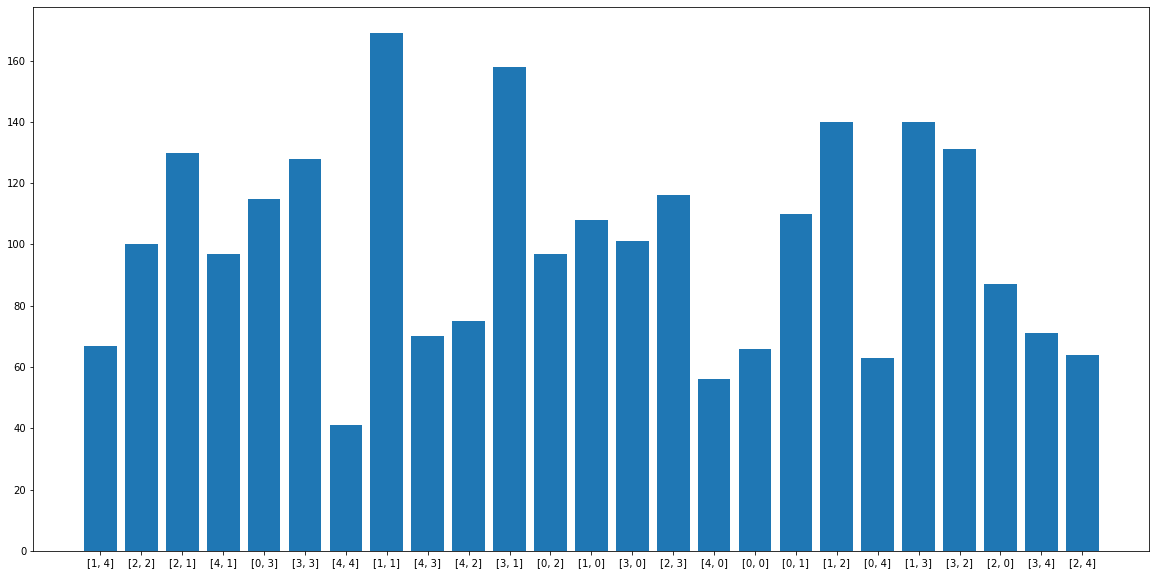

Processing Epoch 35
training start
Iteration 0, d real/fake loss 0.5355607271194458/0.6706184148788452 and g loss is 0.7530026435852051, NDiv loss 0.036310553550720215
Iteration 1, d real/fake loss 0.5350469350814819/0.6901702880859375 and g loss is 0.7543449997901917, NDiv loss 0.03502785414457321
Iteration 2, d real/fake loss 0.5346051454544067/0.6729108095169067 and g loss is 0.7465963363647461, NDiv loss 0.03294657543301582
Iteration 3, d real/fake loss 0.534083366394043/0.6474227905273438 and g loss is 0.7720291614532471, NDiv loss 0.03771106153726578
Iteration 4, d real/fake loss 0.533475399017334/0.6728553771972656 and g loss is 0.8055412769317627, NDiv loss 0.03390511870384216


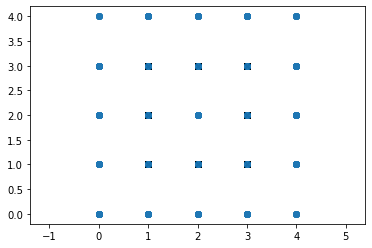

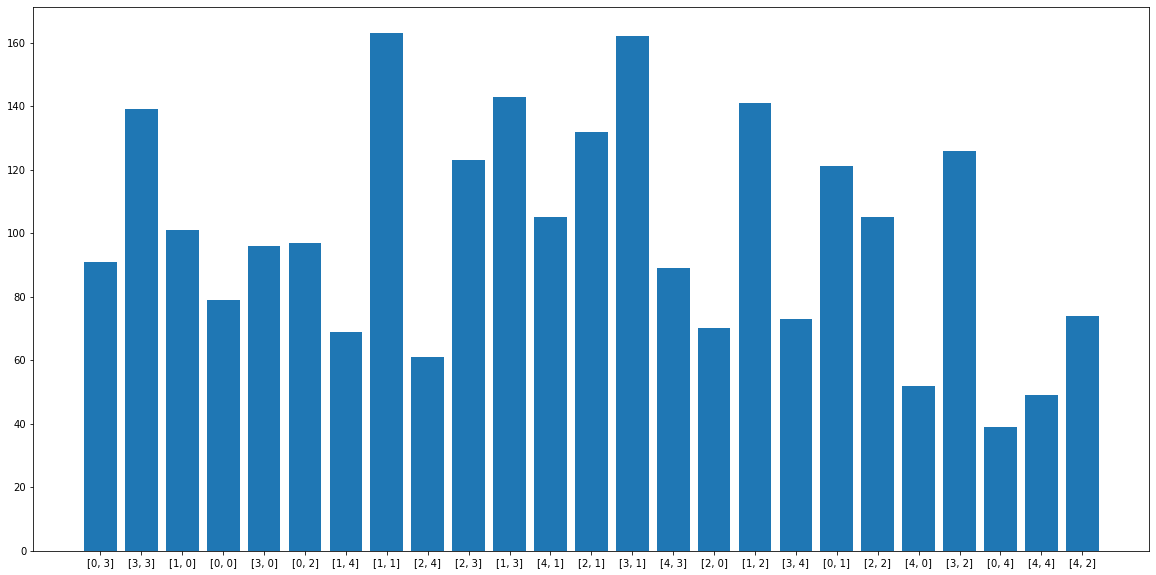

Processing Epoch 36
training start
Iteration 0, d real/fake loss 0.5345862507820129/0.6646794080734253 and g loss is 0.7679961919784546, NDiv loss 0.03188623860478401
Iteration 1, d real/fake loss 0.5341413617134094/0.6612577438354492 and g loss is 0.7990835905075073, NDiv loss 0.03586062788963318
Iteration 2, d real/fake loss 0.5337399840354919/0.687128484249115 and g loss is 0.7287657260894775, NDiv loss 0.036132462322711945
Iteration 3, d real/fake loss 0.5335535407066345/0.6321749687194824 and g loss is 0.7547927498817444, NDiv loss 0.03340013325214386
Iteration 4, d real/fake loss 0.5331707000732422/0.6522918343544006 and g loss is 0.749655544757843, NDiv loss 0.03408488258719444


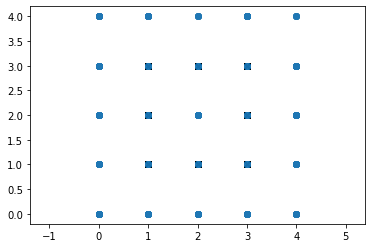

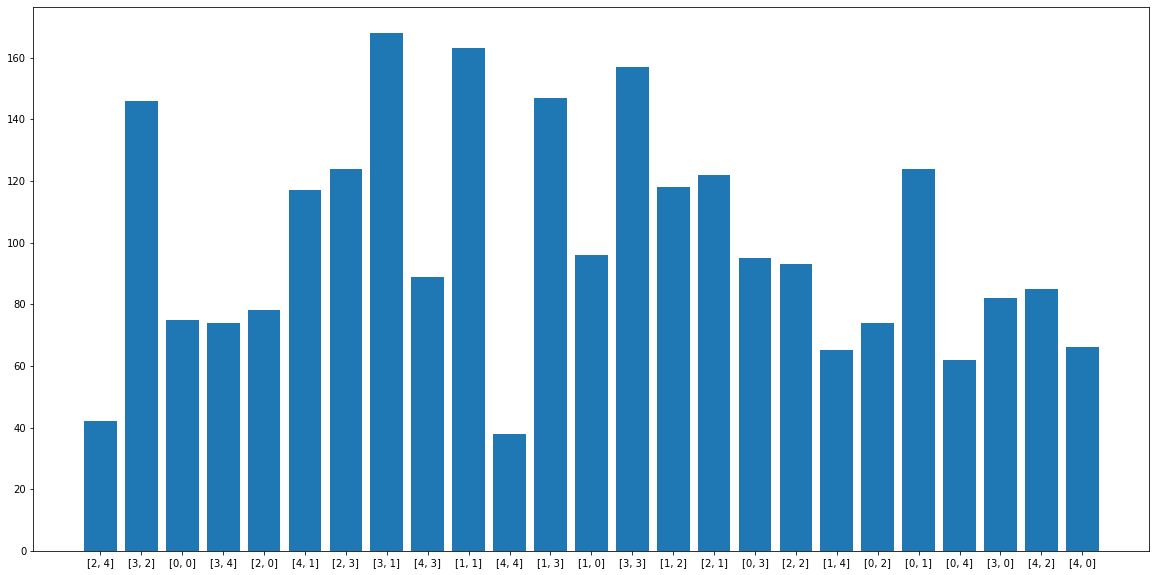

Processing Epoch 37
training start
Iteration 0, d real/fake loss 0.5268269777297974/0.6928082704544067 and g loss is 0.7628263831138611, NDiv loss 0.03337539732456207
Iteration 1, d real/fake loss 0.526427149772644/0.6618540287017822 and g loss is 0.7962146997451782, NDiv loss 0.03452654182910919
Iteration 2, d real/fake loss 0.5260697603225708/0.6730836629867554 and g loss is 0.7956340312957764, NDiv loss 0.03513817489147186
Iteration 3, d real/fake loss 0.5257437825202942/0.6770370006561279 and g loss is 0.7273815274238586, NDiv loss 0.03387792408466339
Iteration 4, d real/fake loss 0.5254900455474854/0.6784446835517883 and g loss is 0.757996678352356, NDiv loss 0.03461826220154762


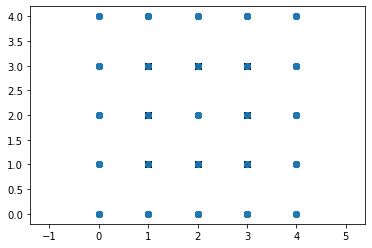

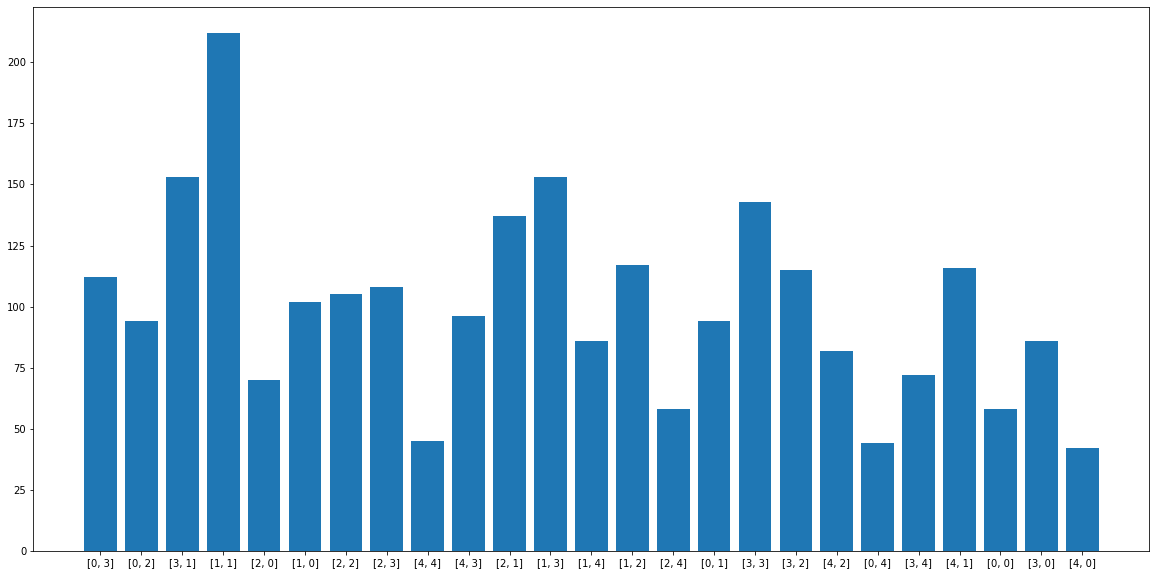

Processing Epoch 38
training start
Iteration 0, d real/fake loss 0.528225302696228/0.6818576455116272 and g loss is 0.7853732705116272, NDiv loss 0.03592502698302269
Iteration 1, d real/fake loss 0.5283548831939697/0.6471883654594421 and g loss is 0.7343345284461975, NDiv loss 0.03546474128961563
Iteration 2, d real/fake loss 0.5284683704376221/0.6731107234954834 and g loss is 0.7641897201538086, NDiv loss 0.03401973843574524
Iteration 3, d real/fake loss 0.5285735726356506/0.6797009706497192 and g loss is 0.737263560295105, NDiv loss 0.04094440117478371
Iteration 4, d real/fake loss 0.5286751985549927/0.6490025520324707 and g loss is 0.7213248014450073, NDiv loss 0.034390050917863846


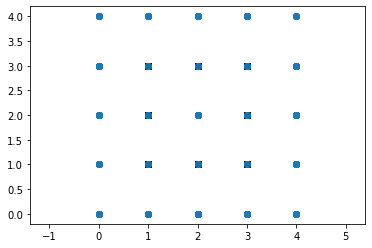

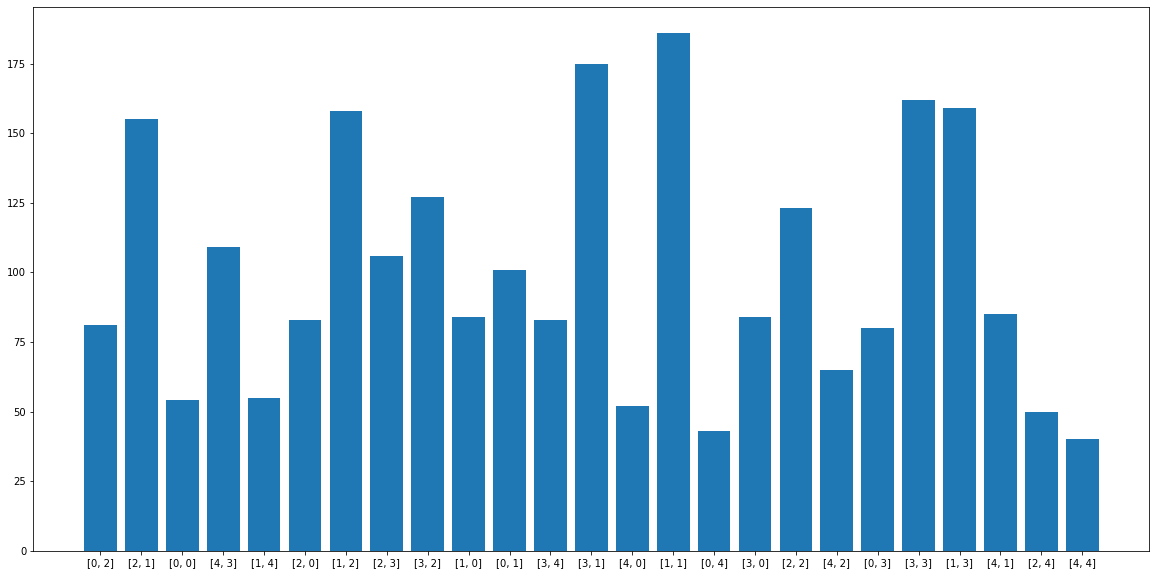

Processing Epoch 39
training start
Iteration 0, d real/fake loss 0.5265479683876038/0.6639673709869385 and g loss is 0.7899460792541504, NDiv loss 0.035488661378622055
Iteration 1, d real/fake loss 0.5266685485839844/0.6728777289390564 and g loss is 0.7817599773406982, NDiv loss 0.036412373185157776
Iteration 2, d real/fake loss 0.5268113613128662/0.69402015209198 and g loss is 0.8017277121543884, NDiv loss 0.03222266212105751
Iteration 3, d real/fake loss 0.5269845724105835/0.6658426523208618 and g loss is 0.7942203879356384, NDiv loss 0.037638645619153976
Iteration 4, d real/fake loss 0.5270351767539978/0.6988340020179749 and g loss is 0.7819351553916931, NDiv loss 0.03762487322092056


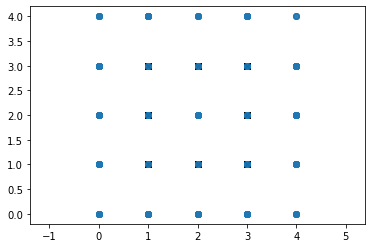

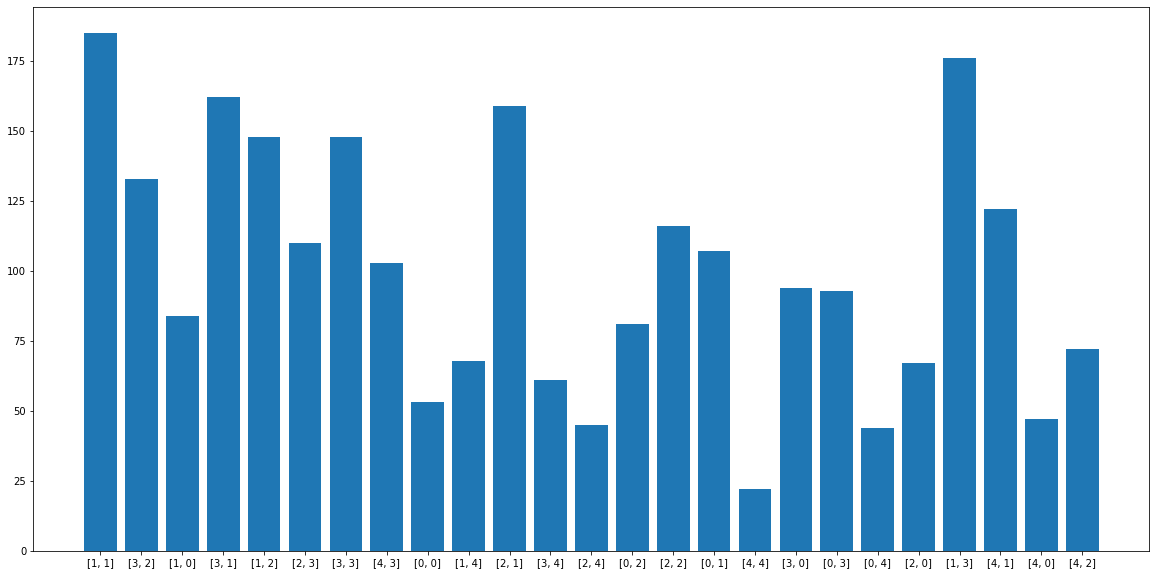

Processing Epoch 40
training start
Iteration 0, d real/fake loss 0.5240694284439087/0.6844016313552856 and g loss is 0.7739952206611633, NDiv loss 0.03433005139231682
Iteration 1, d real/fake loss 0.5242950320243835/0.6466168165206909 and g loss is 0.81850665807724, NDiv loss 0.036796022206544876
Iteration 2, d real/fake loss 0.5243947505950928/0.6755923628807068 and g loss is 0.800423800945282, NDiv loss 0.034025851637125015
Iteration 3, d real/fake loss 0.5245441794395447/0.6466017961502075 and g loss is 0.7680364847183228, NDiv loss 0.037334561347961426
Iteration 4, d real/fake loss 0.5246233940124512/0.6901493072509766 and g loss is 0.7647707462310791, NDiv loss 0.033188484609127045


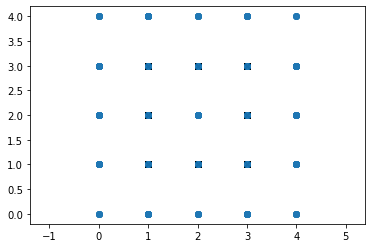

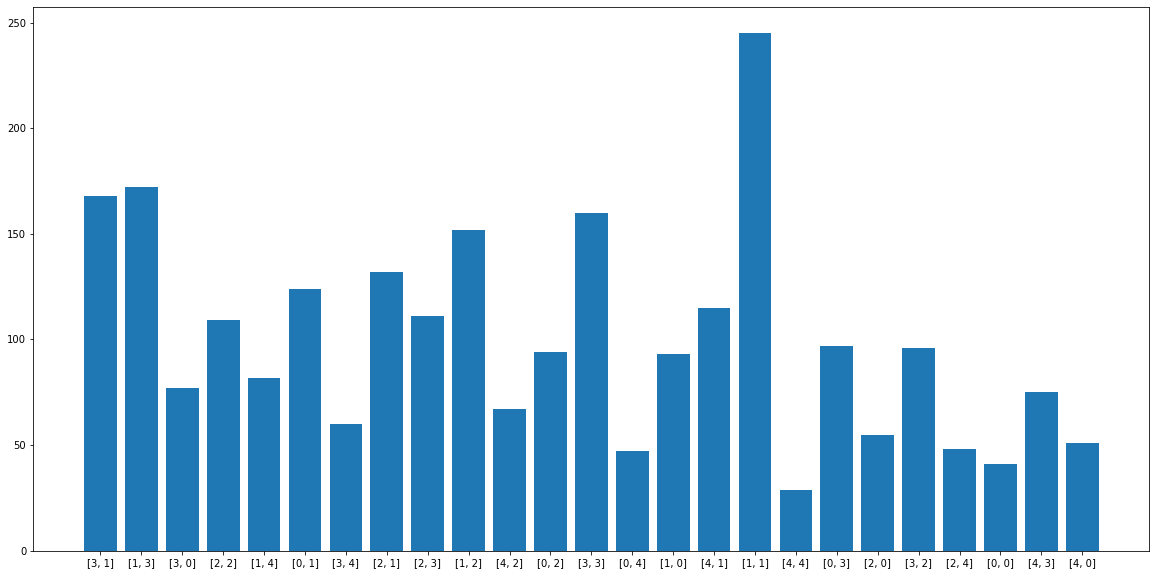

Processing Epoch 41
training start
Iteration 0, d real/fake loss 0.5333714485168457/0.6545666456222534 and g loss is 0.8142191767692566, NDiv loss 0.03796038031578064
Iteration 1, d real/fake loss 0.5333859324455261/0.6447625756263733 and g loss is 0.764085054397583, NDiv loss 0.035503700375556946
Iteration 2, d real/fake loss 0.5333330631256104/0.664451539516449 and g loss is 0.7793748378753662, NDiv loss 0.033730752766132355
Iteration 3, d real/fake loss 0.5333657264709473/0.642395555973053 and g loss is 0.7909605503082275, NDiv loss 0.037738848477602005
Iteration 4, d real/fake loss 0.5334299802780151/0.6699780821800232 and g loss is 0.8031309843063354, NDiv loss 0.03607483208179474


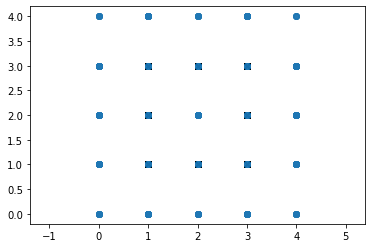

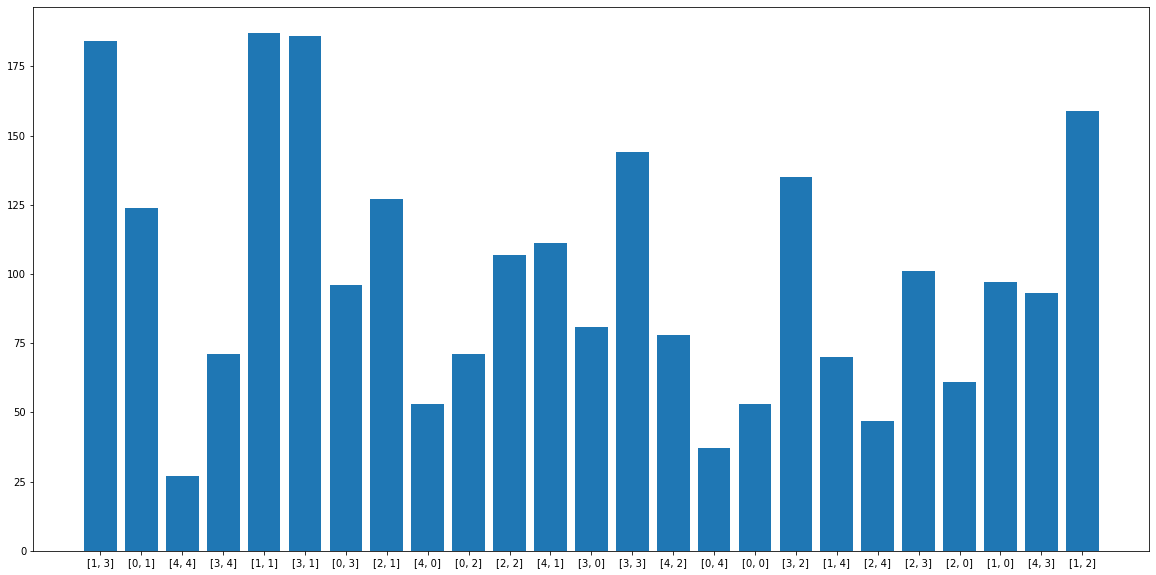

Processing Epoch 42
training start
Iteration 0, d real/fake loss 0.5325770974159241/0.6733117699623108 and g loss is 0.7618758678436279, NDiv loss 0.03560807555913925
Iteration 1, d real/fake loss 0.532941460609436/0.6999742984771729 and g loss is 0.7705066204071045, NDiv loss 0.03548188880085945
Iteration 2, d real/fake loss 0.5334922075271606/0.6592113971710205 and g loss is 0.7922590374946594, NDiv loss 0.03762483969330788
Iteration 3, d real/fake loss 0.5338277220726013/0.6593009233474731 and g loss is 0.7932693362236023, NDiv loss 0.036738332360982895
Iteration 4, d real/fake loss 0.5341013669967651/0.6629438400268555 and g loss is 0.7860044836997986, NDiv loss 0.03853174299001694


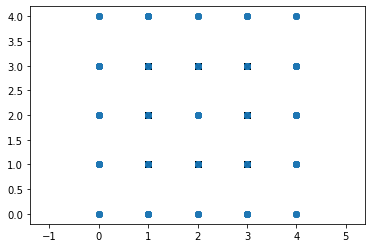

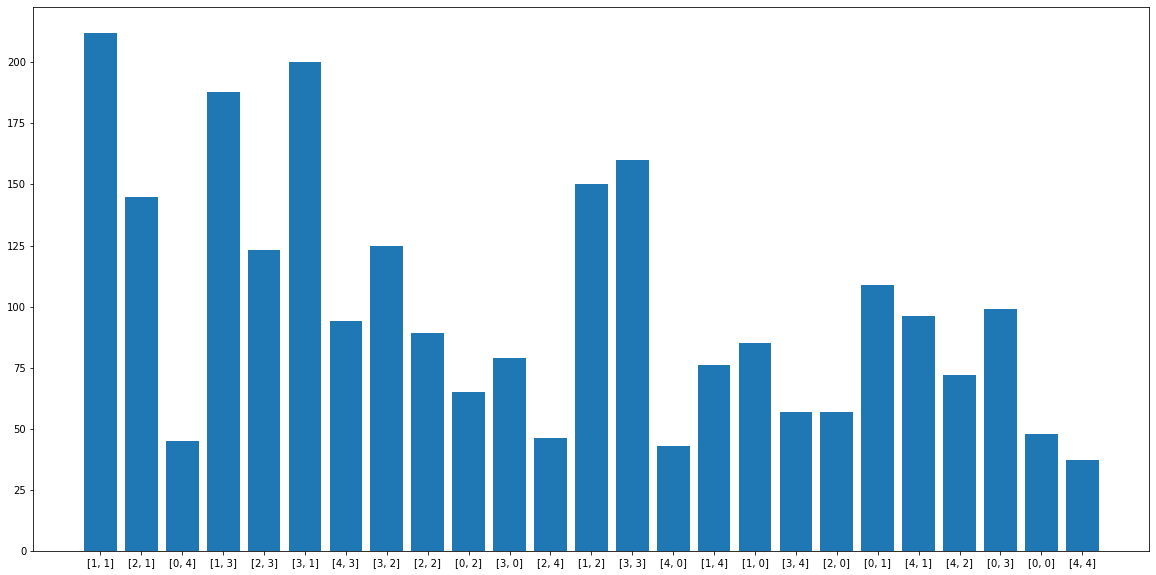

Processing Epoch 43
training start
Iteration 0, d real/fake loss 0.5306596159934998/0.6696187257766724 and g loss is 0.7991586923599243, NDiv loss 0.03521987423300743
Iteration 1, d real/fake loss 0.5308281779289246/0.659733772277832 and g loss is 0.7757686376571655, NDiv loss 0.03331780433654785
Iteration 2, d real/fake loss 0.5308524370193481/0.6681402921676636 and g loss is 0.7727997303009033, NDiv loss 0.03932400047779083
Iteration 3, d real/fake loss 0.5308083295822144/0.6472455263137817 and g loss is 0.8526546955108643, NDiv loss 0.03885336220264435
Iteration 4, d real/fake loss 0.5306872725486755/0.6336985230445862 and g loss is 0.7430702447891235, NDiv loss 0.03947082534432411


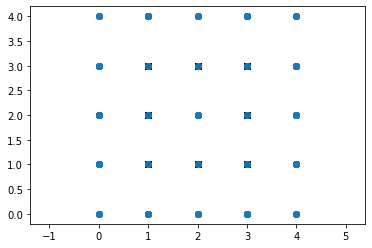

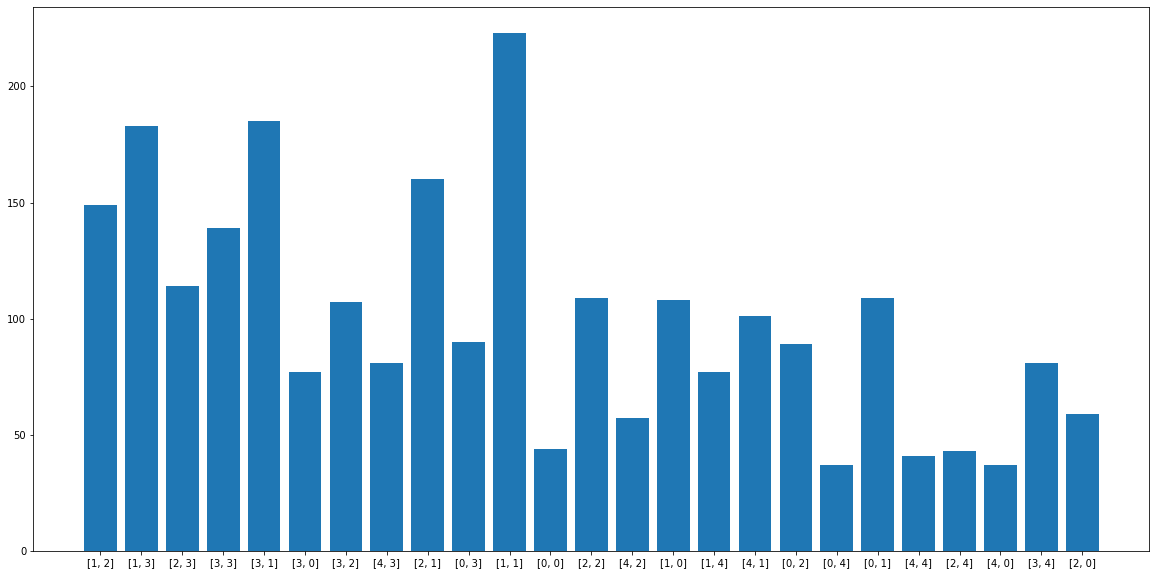

Processing Epoch 44
training start
Iteration 0, d real/fake loss 0.5289597511291504/0.6600456833839417 and g loss is 0.8013519048690796, NDiv loss 0.03643304109573364
Iteration 1, d real/fake loss 0.5290047526359558/0.6554691195487976 and g loss is 0.7612788677215576, NDiv loss 0.0385979525744915
Iteration 2, d real/fake loss 0.5291829109191895/0.6382110118865967 and g loss is 0.7804913520812988, NDiv loss 0.03703600540757179
Iteration 3, d real/fake loss 0.5293611288070679/0.6858002543449402 and g loss is 0.7832810282707214, NDiv loss 0.0341920480132103
Iteration 4, d real/fake loss 0.5297461748123169/0.6513531804084778 and g loss is 0.8219072222709656, NDiv loss 0.04085063189268112


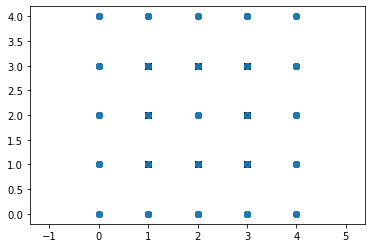

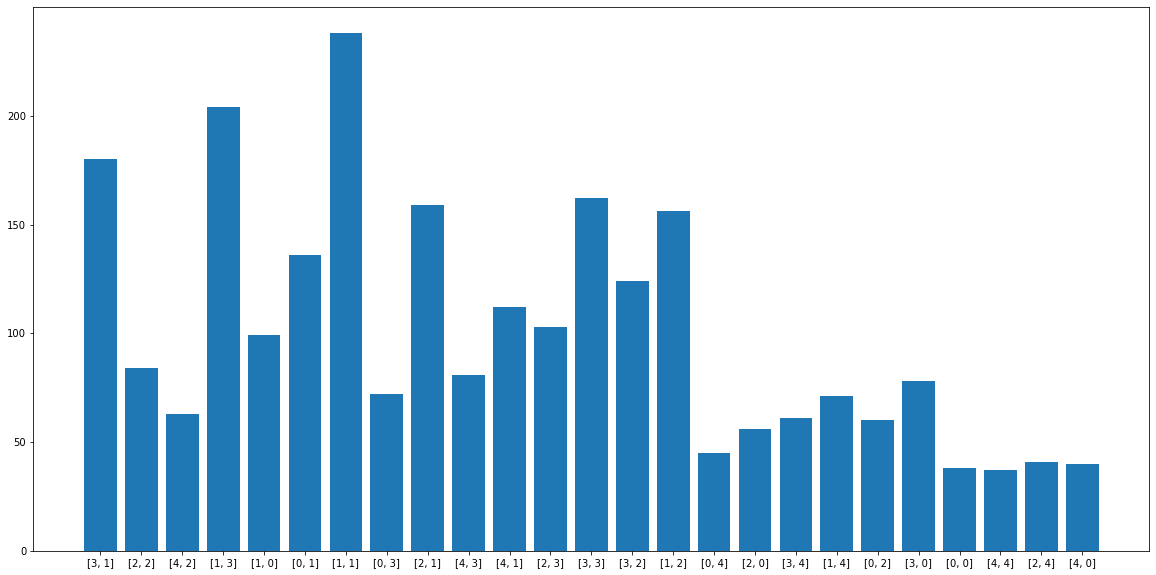

Processing Epoch 45
training start
Iteration 0, d real/fake loss 0.5383185148239136/0.6301800012588501 and g loss is 0.824547529220581, NDiv loss 0.03647305443882942
Iteration 1, d real/fake loss 0.5381708741188049/0.655276358127594 and g loss is 0.7625288963317871, NDiv loss 0.0382029265165329
Iteration 2, d real/fake loss 0.5377757549285889/0.6734534502029419 and g loss is 0.8375133275985718, NDiv loss 0.037418432533741
Iteration 3, d real/fake loss 0.5373656153678894/0.6656674146652222 and g loss is 0.8220721483230591, NDiv loss 0.040451016277074814
Iteration 4, d real/fake loss 0.5371302962303162/0.6441463232040405 and g loss is 0.812697172164917, NDiv loss 0.03858254477381706


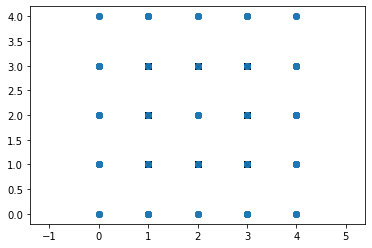

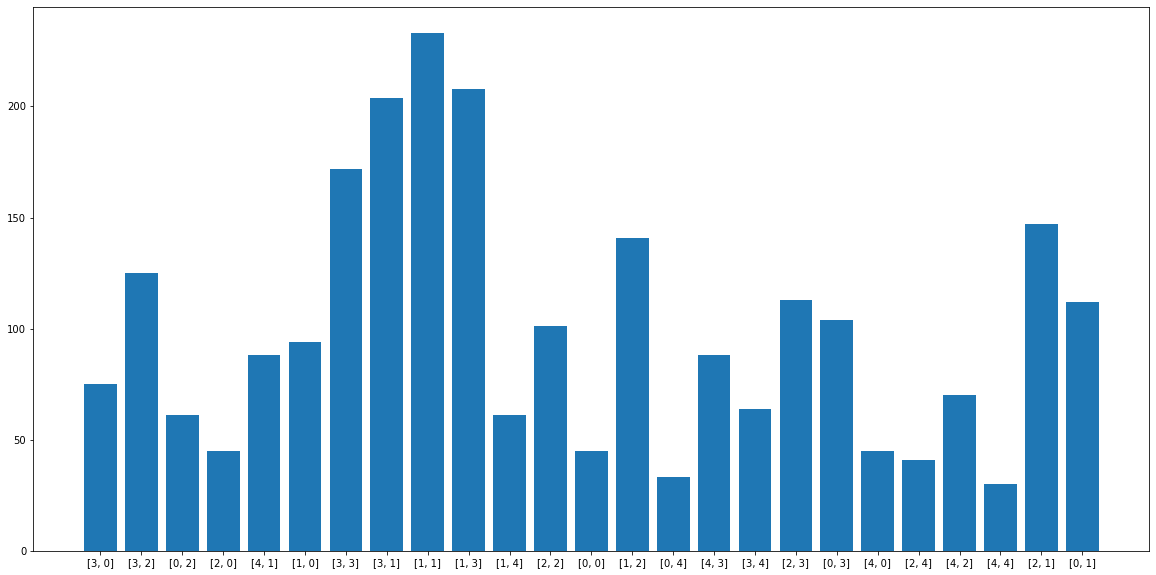

Processing Epoch 46
training start
Iteration 0, d real/fake loss 0.5354980230331421/0.6742132902145386 and g loss is 0.8365182280540466, NDiv loss 0.0398254431784153
Iteration 1, d real/fake loss 0.5353279709815979/0.683478593826294 and g loss is 0.7288203239440918, NDiv loss 0.050544481724500656
Iteration 2, d real/fake loss 0.5352087020874023/0.6522746682167053 and g loss is 0.7566888332366943, NDiv loss 0.03807935118675232
Iteration 3, d real/fake loss 0.5351112484931946/0.6957809925079346 and g loss is 0.8042470812797546, NDiv loss 0.03410809859633446
Iteration 4, d real/fake loss 0.535152018070221/0.7115362286567688 and g loss is 0.8655510544776917, NDiv loss 0.038334138691425323


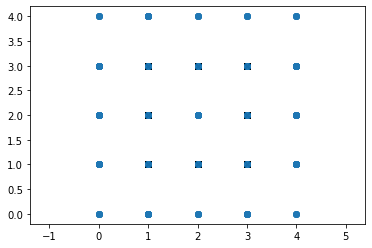

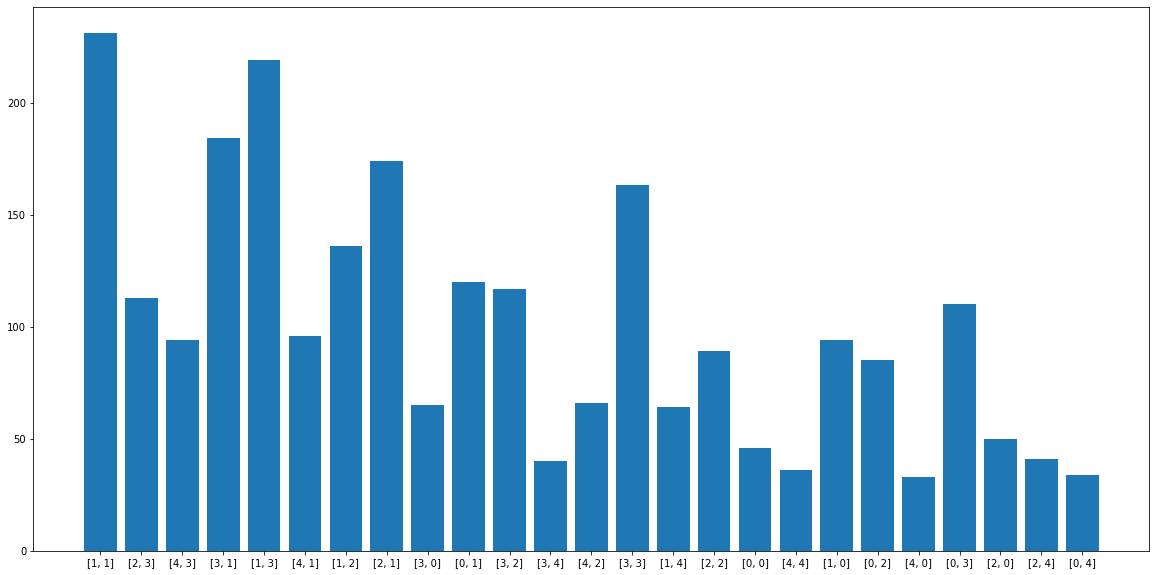

Processing Epoch 47
training start
Iteration 0, d real/fake loss 0.5441362857818604/0.6679064631462097 and g loss is 0.7892266511917114, NDiv loss 0.039788298308849335
Iteration 1, d real/fake loss 0.5442084074020386/0.6443556547164917 and g loss is 0.8216831684112549, NDiv loss 0.03462919965386391
Iteration 2, d real/fake loss 0.5441735982894897/0.6489256620407104 and g loss is 0.8004868030548096, NDiv loss 0.0446476973593235
Iteration 3, d real/fake loss 0.5438010096549988/0.6775919198989868 and g loss is 0.8312538862228394, NDiv loss 0.03953154385089874
Iteration 4, d real/fake loss 0.5433331727981567/0.6744167804718018 and g loss is 0.8040482997894287, NDiv loss 0.035607315599918365


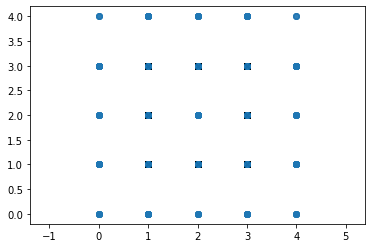

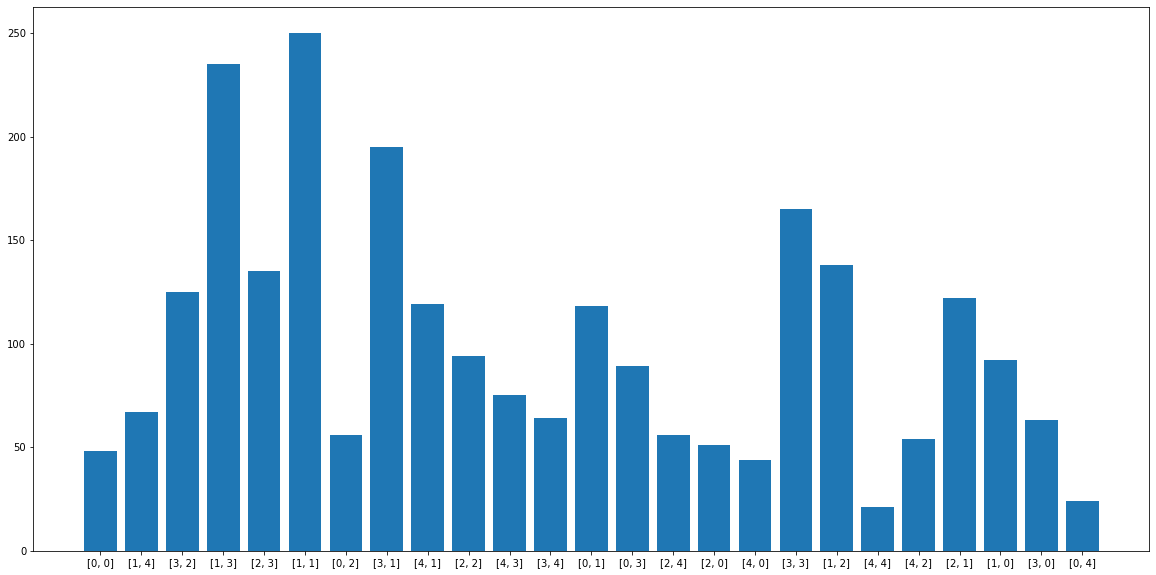

Processing Epoch 48
training start
Iteration 0, d real/fake loss 0.5361153483390808/0.6909400224685669 and g loss is 0.7762508392333984, NDiv loss 0.04207826405763626
Iteration 1, d real/fake loss 0.5361942052841187/0.6751991510391235 and g loss is 0.818926990032196, NDiv loss 0.037368860095739365
Iteration 2, d real/fake loss 0.5364009141921997/0.6466024518013 and g loss is 0.7758705019950867, NDiv loss 0.041680749505758286
Iteration 3, d real/fake loss 0.536544680595398/0.6498206853866577 and g loss is 0.8505926728248596, NDiv loss 0.03759311884641647
Iteration 4, d real/fake loss 0.5367282629013062/0.7084386348724365 and g loss is 0.7920132279396057, NDiv loss 0.03655984625220299


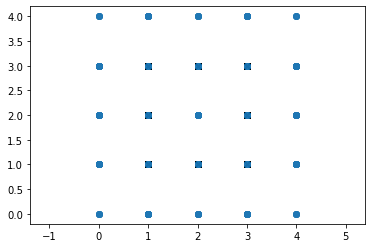

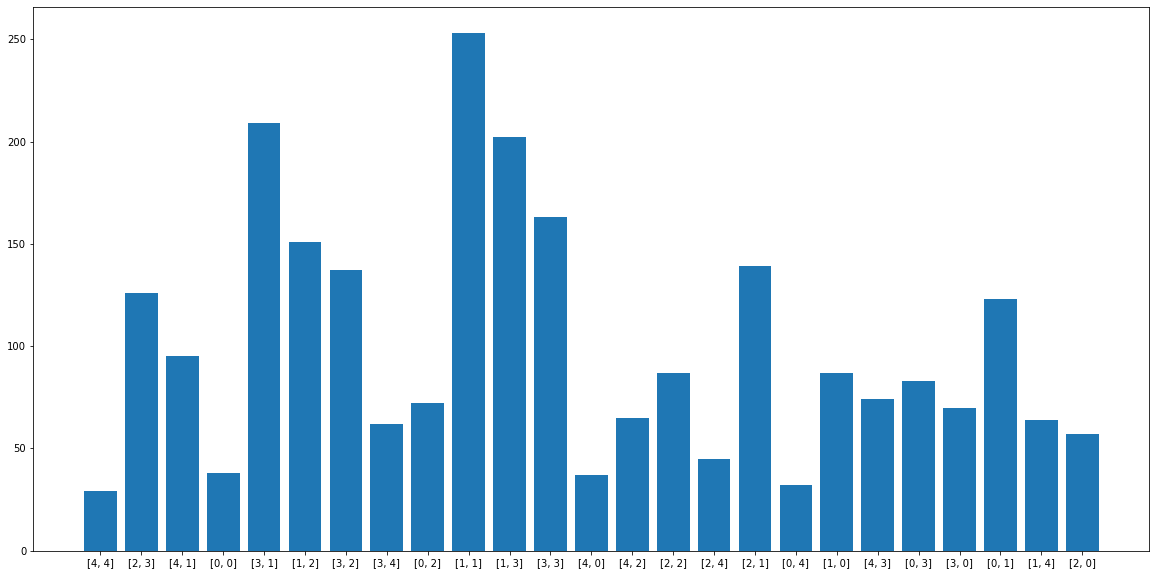

Processing Epoch 49
training start
Iteration 0, d real/fake loss 0.5363190770149231/0.6596574783325195 and g loss is 0.7799367308616638, NDiv loss 0.034406743943691254
Iteration 1, d real/fake loss 0.5367502570152283/0.6196046471595764 and g loss is 0.8201506733894348, NDiv loss 0.03989101201295853
Iteration 2, d real/fake loss 0.5368949174880981/0.6721199750900269 and g loss is 0.8163961172103882, NDiv loss 0.04020737111568451
Iteration 3, d real/fake loss 0.53700852394104/0.6746764183044434 and g loss is 0.8123010993003845, NDiv loss 0.03986232727766037
Iteration 4, d real/fake loss 0.5372722148895264/0.6605120301246643 and g loss is 0.7944451570510864, NDiv loss 0.03872695192694664


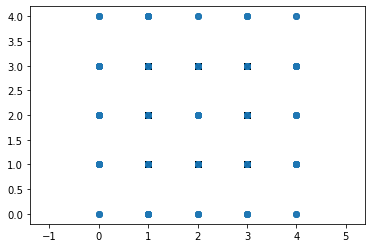

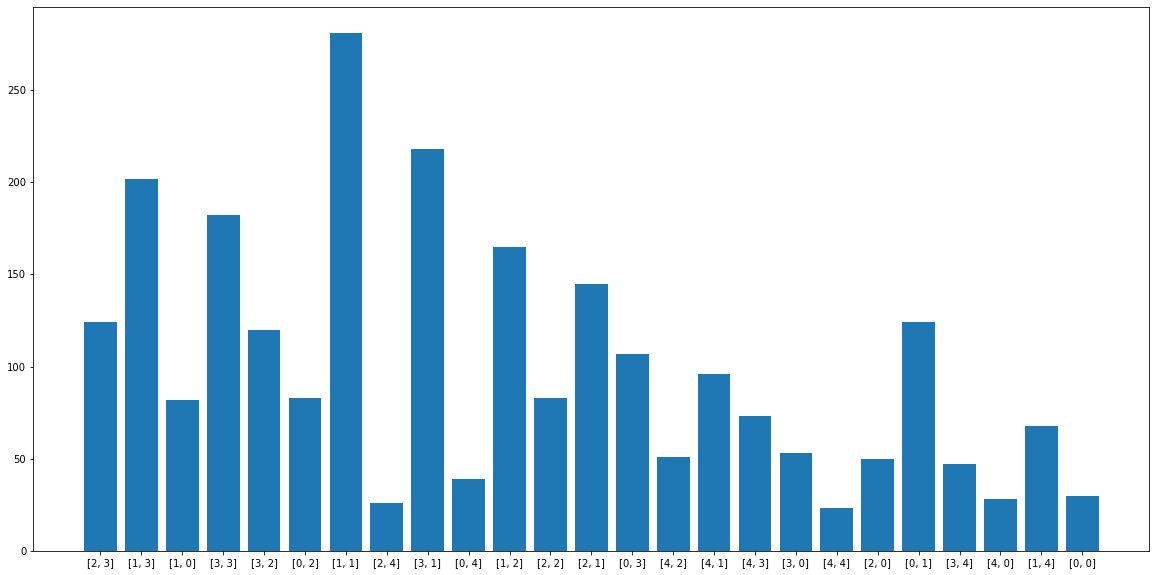

Processing Epoch 50
training start
Iteration 0, d real/fake loss 0.5399057865142822/0.6455972790718079 and g loss is 0.8568098545074463, NDiv loss 0.04011909291148186
Iteration 1, d real/fake loss 0.5404443740844727/0.6629080772399902 and g loss is 0.855941891670227, NDiv loss 0.03374595567584038
Iteration 2, d real/fake loss 0.5408942699432373/0.6172716617584229 and g loss is 0.7802727222442627, NDiv loss 0.03925953805446625
Iteration 3, d real/fake loss 0.5411519408226013/0.6040093898773193 and g loss is 0.8148962259292603, NDiv loss 0.04228508844971657
Iteration 4, d real/fake loss 0.5412477254867554/0.6809940338134766 and g loss is 0.8388473987579346, NDiv loss 0.0402265265583992


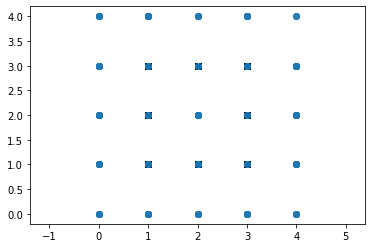

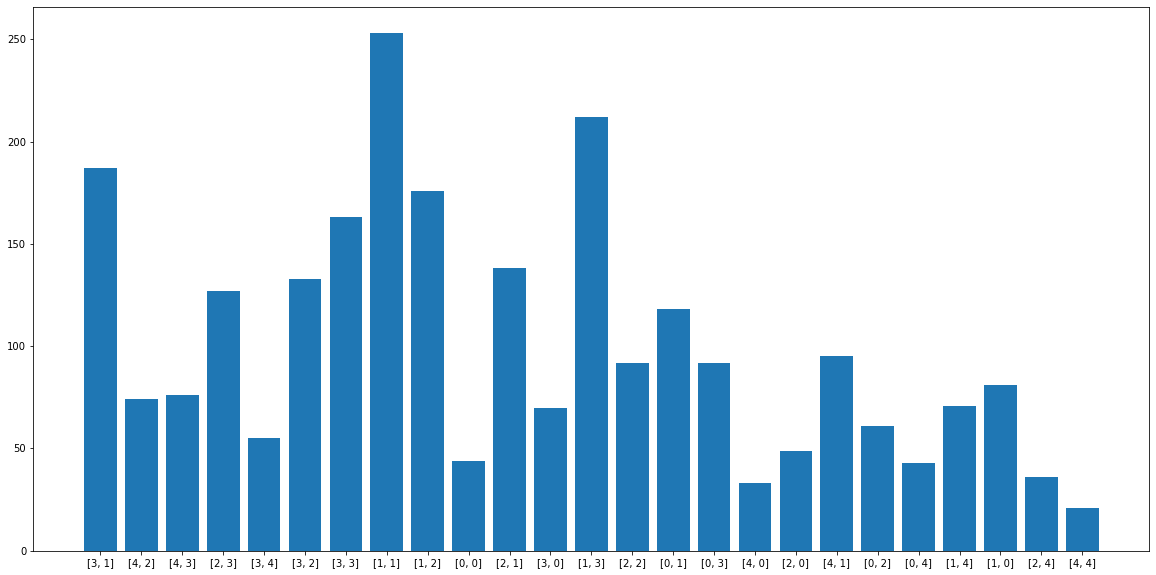

Processing Epoch 51
training start
Iteration 0, d real/fake loss 0.5399693846702576/0.6608948707580566 and g loss is 0.9493061304092407, NDiv loss 0.042195290327072144
Iteration 1, d real/fake loss 0.5405054092407227/0.65286785364151 and g loss is 0.8084984421730042, NDiv loss 0.03792219236493111
Iteration 2, d real/fake loss 0.5408438444137573/0.6558316349983215 and g loss is 0.8668813705444336, NDiv loss 0.03759835287928581
Iteration 3, d real/fake loss 0.5410756468772888/0.6415650844573975 and g loss is 0.8658661246299744, NDiv loss 0.044638898223638535
Iteration 4, d real/fake loss 0.5412582159042358/0.631472110748291 and g loss is 0.8464416265487671, NDiv loss 0.04547502472996712


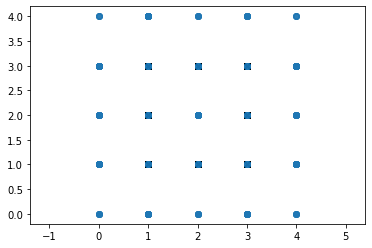

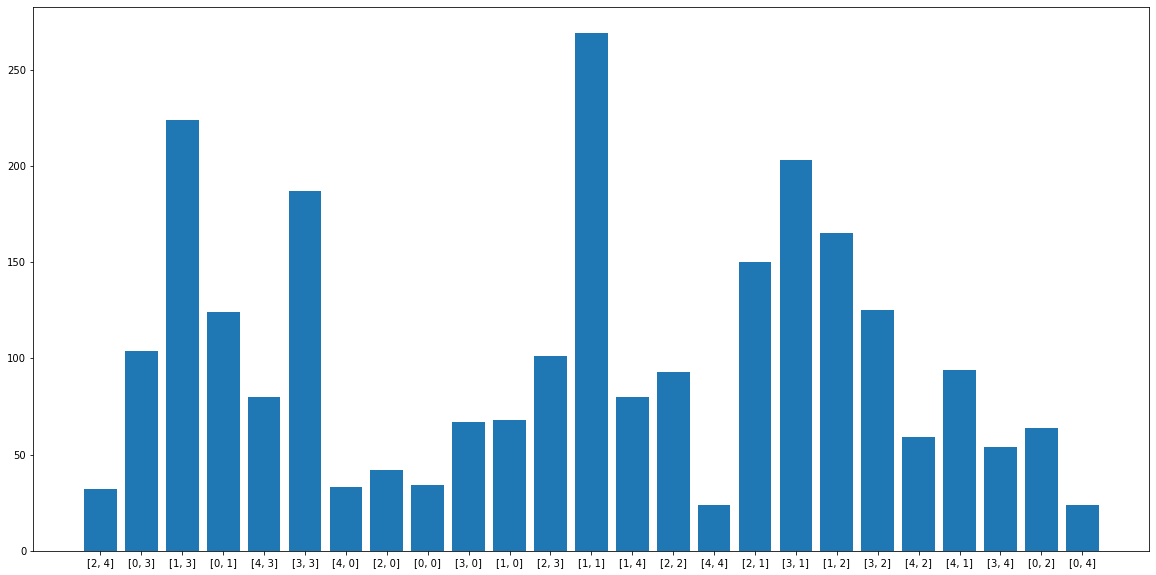

Processing Epoch 52
training start
Iteration 0, d real/fake loss 0.5392311811447144/0.6483322978019714 and g loss is 0.8287558555603027, NDiv loss 0.041420482099056244
Iteration 1, d real/fake loss 0.5391690731048584/0.6838009357452393 and g loss is 0.8114651441574097, NDiv loss 0.03686494007706642
Iteration 2, d real/fake loss 0.539138674736023/0.6628068089485168 and g loss is 0.8275155425071716, NDiv loss 0.04488407075405121
Iteration 3, d real/fake loss 0.5390671491622925/0.6145588159561157 and g loss is 0.7922945618629456, NDiv loss 0.03801993280649185
Iteration 4, d real/fake loss 0.5388156771659851/0.6806132793426514 and g loss is 0.8541041016578674, NDiv loss 0.03833020478487015


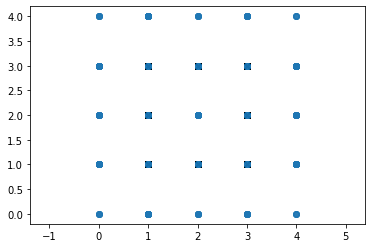

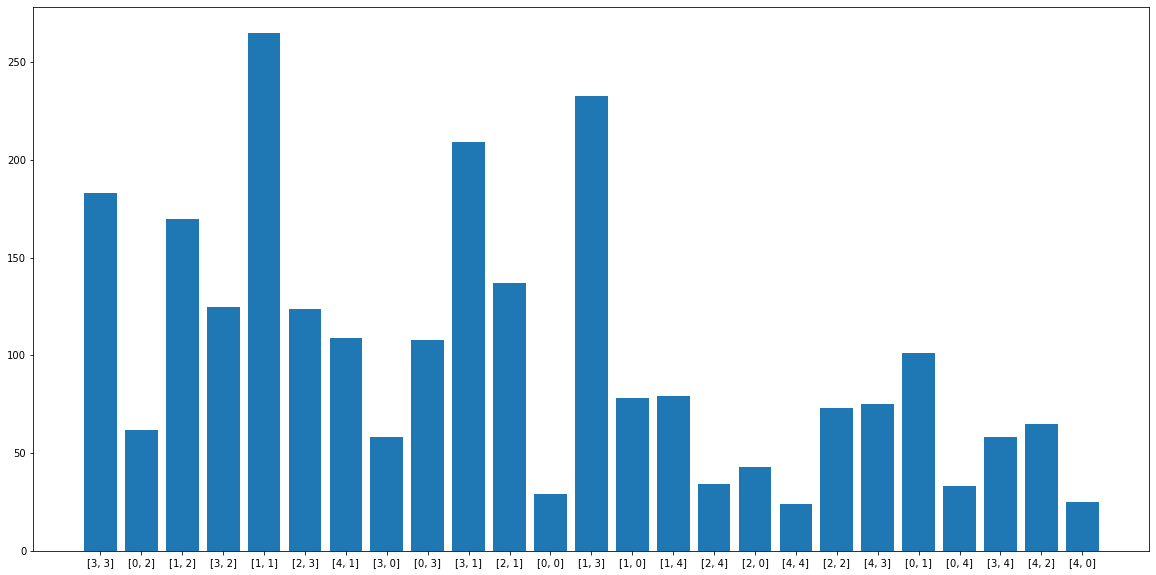

Processing Epoch 53
training start
Iteration 0, d real/fake loss 0.5441815257072449/0.6637933254241943 and g loss is 0.7711142301559448, NDiv loss 0.040589168667793274
Iteration 1, d real/fake loss 0.5444104671478271/0.6649693250656128 and g loss is 0.8324133157730103, NDiv loss 0.042895495891571045
Iteration 2, d real/fake loss 0.5447739958763123/0.6088854670524597 and g loss is 0.8235483169555664, NDiv loss 0.04592418670654297
Iteration 3, d real/fake loss 0.544696569442749/0.6687531471252441 and g loss is 0.8195525407791138, NDiv loss 0.04357822611927986
Iteration 4, d real/fake loss 0.5444759726524353/0.6431690454483032 and g loss is 0.8049863576889038, NDiv loss 0.04551117122173309


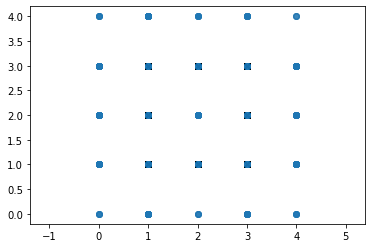

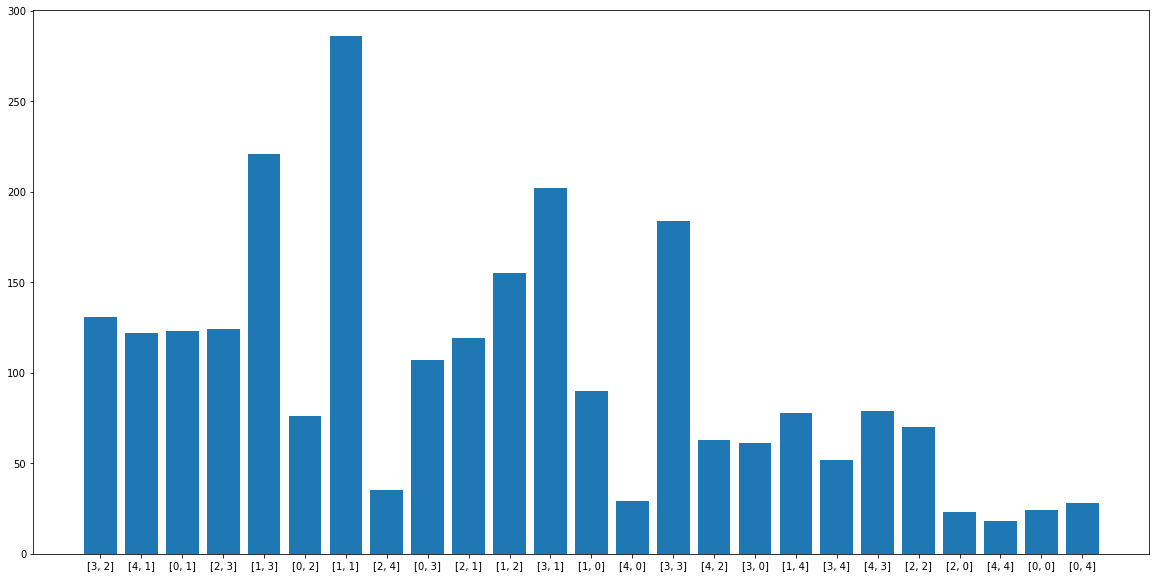

Processing Epoch 54
training start
Iteration 0, d real/fake loss 0.5473018288612366/0.659915030002594 and g loss is 0.7897894382476807, NDiv loss 0.045187778770923615
Iteration 1, d real/fake loss 0.5471233129501343/0.6549027562141418 and g loss is 0.8494925498962402, NDiv loss 0.038822248578071594
Iteration 2, d real/fake loss 0.5468277931213379/0.6727957725524902 and g loss is 0.9082130193710327, NDiv loss 0.04324333742260933
Iteration 3, d real/fake loss 0.5467489361763/0.6234980821609497 and g loss is 0.7984952926635742, NDiv loss 0.04882897436618805
Iteration 4, d real/fake loss 0.5466898679733276/0.6432875394821167 and g loss is 0.8290486335754395, NDiv loss 0.04019927978515625


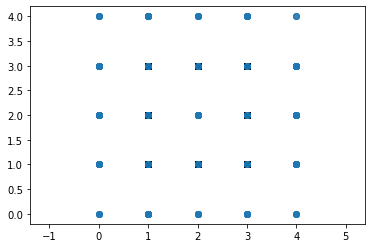

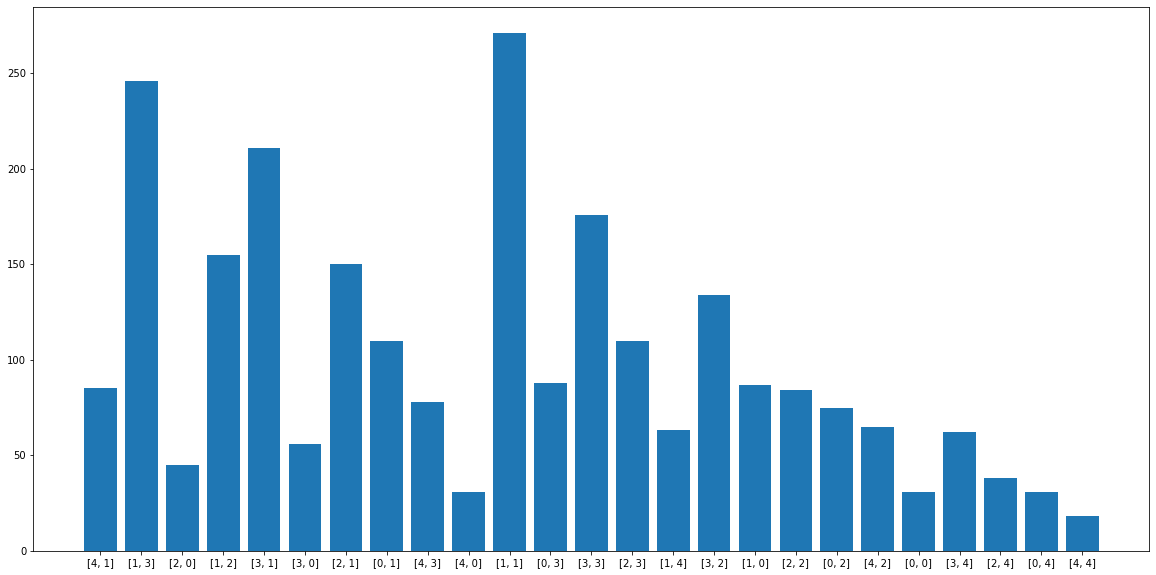

Processing Epoch 55
training start
Iteration 0, d real/fake loss 0.5479412078857422/0.7096052169799805 and g loss is 0.782967209815979, NDiv loss 0.04302612319588661
Iteration 1, d real/fake loss 0.5480172038078308/0.649988055229187 and g loss is 0.8431110382080078, NDiv loss 0.04869227856397629
Iteration 2, d real/fake loss 0.5479387044906616/0.6608139276504517 and g loss is 0.8547379970550537, NDiv loss 0.04272263124585152
Iteration 3, d real/fake loss 0.5477444529533386/0.6372365355491638 and g loss is 0.8358675241470337, NDiv loss 0.036209750920534134
Iteration 4, d real/fake loss 0.5472992658615112/0.6675418615341187 and g loss is 0.831292450428009, NDiv loss 0.03664155676960945


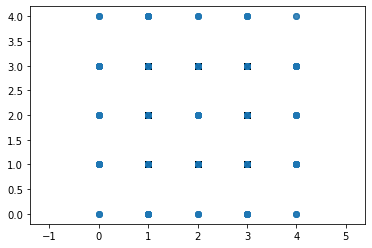

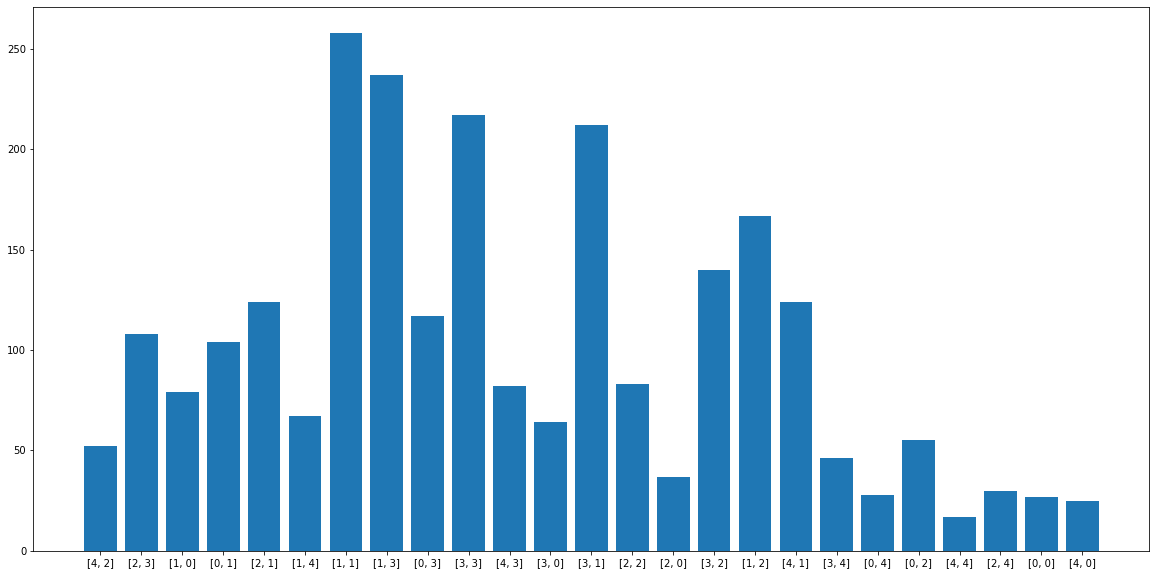

Processing Epoch 56
training start
Iteration 0, d real/fake loss 0.5513063073158264/0.6229994297027588 and g loss is 0.8549845814704895, NDiv loss 0.04609183594584465
Iteration 1, d real/fake loss 0.5506784915924072/0.6551000475883484 and g loss is 0.784218966960907, NDiv loss 0.03909815102815628
Iteration 2, d real/fake loss 0.5501694679260254/0.6575838923454285 and g loss is 0.8125028014183044, NDiv loss 0.04131694138050079
Iteration 3, d real/fake loss 0.5497915744781494/0.6488139629364014 and g loss is 0.8285463452339172, NDiv loss 0.0395822711288929
Iteration 4, d real/fake loss 0.5495092868804932/0.6755622625350952 and g loss is 0.8357475996017456, NDiv loss 0.04433803632855415


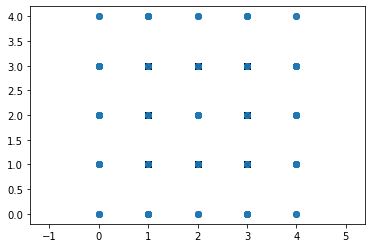

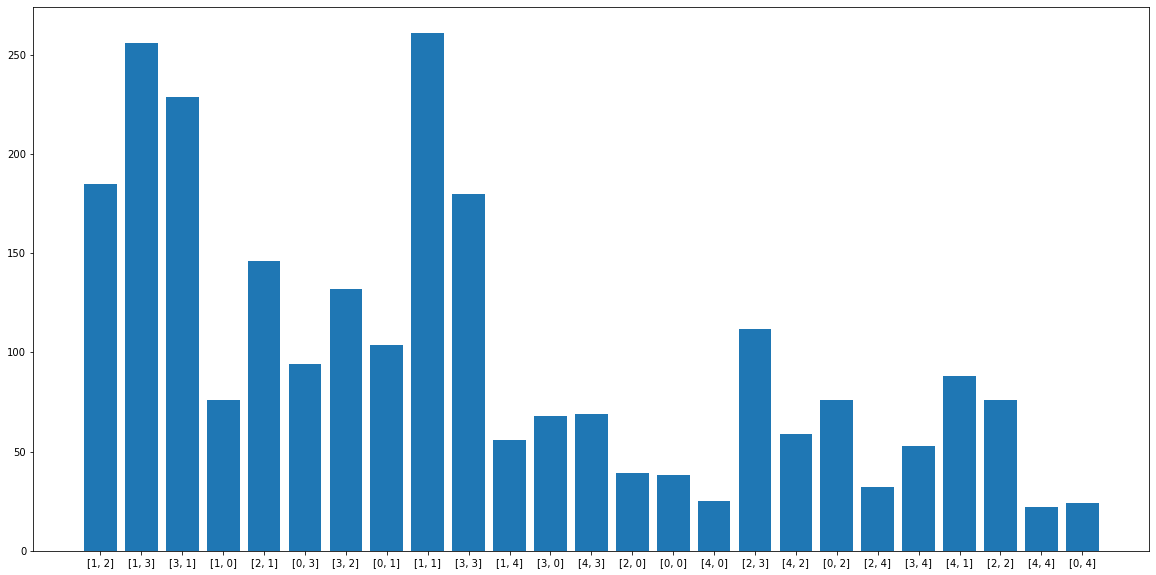

Processing Epoch 57
training start
Iteration 0, d real/fake loss 0.5413988828659058/0.671509861946106 and g loss is 0.7971467971801758, NDiv loss 0.038162507116794586
Iteration 1, d real/fake loss 0.5421549081802368/0.685363233089447 and g loss is 0.8036566972732544, NDiv loss 0.04200052097439766
Iteration 2, d real/fake loss 0.5430689454078674/0.6215839982032776 and g loss is 0.8494755029678345, NDiv loss 0.04707976058125496
Iteration 3, d real/fake loss 0.5436476469039917/0.6789262890815735 and g loss is 0.8964428901672363, NDiv loss 0.043847598135471344
Iteration 4, d real/fake loss 0.5445331931114197/0.6995726227760315 and g loss is 0.8612160682678223, NDiv loss 0.0424906387925148


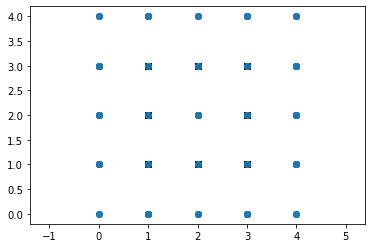

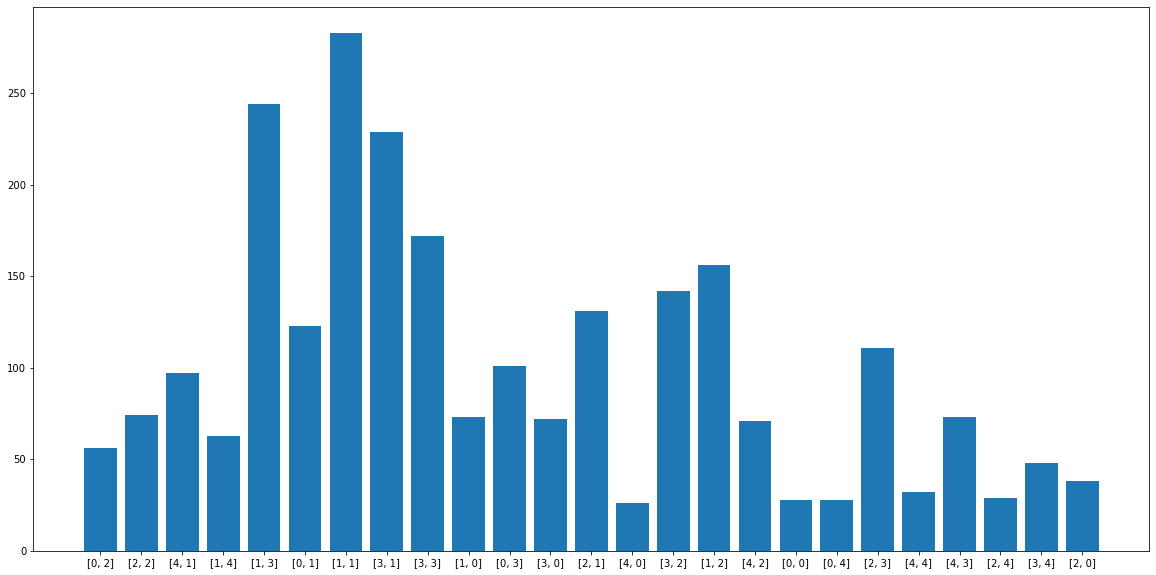

Processing Epoch 58
training start
Iteration 0, d real/fake loss 0.5440791249275208/0.6779749989509583 and g loss is 0.793295681476593, NDiv loss 0.04175432398915291
Iteration 1, d real/fake loss 0.5452122688293457/0.6530699729919434 and g loss is 0.8487895727157593, NDiv loss 0.04397512972354889
Iteration 2, d real/fake loss 0.5461954474449158/0.649262011051178 and g loss is 0.9380499124526978, NDiv loss 0.04684803634881973
Iteration 3, d real/fake loss 0.5468114018440247/0.6646206974983215 and g loss is 0.8645391464233398, NDiv loss 0.04475638270378113
Iteration 4, d real/fake loss 0.547382116317749/0.6790856719017029 and g loss is 0.8270556330680847, NDiv loss 0.04543662816286087


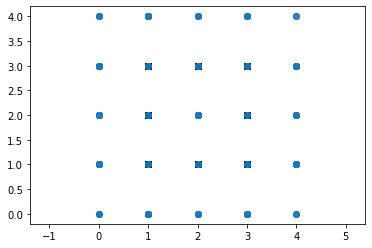

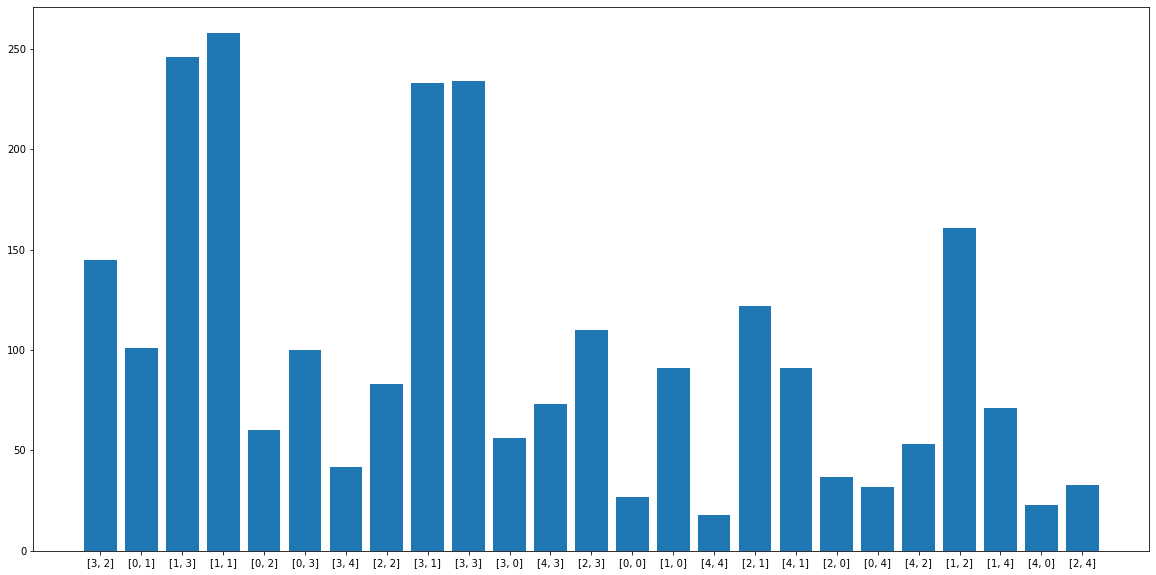

Processing Epoch 59
training start
Iteration 0, d real/fake loss 0.5496879816055298/0.6645832657814026 and g loss is 0.7949517965316772, NDiv loss 0.040402140468358994
Iteration 1, d real/fake loss 0.5503349304199219/0.6747806072235107 and g loss is 0.8296230435371399, NDiv loss 0.04389474168419838
Iteration 2, d real/fake loss 0.5509697794914246/0.6588311195373535 and g loss is 0.854120135307312, NDiv loss 0.04289267584681511
Iteration 3, d real/fake loss 0.5514464378356934/0.6392939686775208 and g loss is 0.8556133508682251, NDiv loss 0.04109455272555351
Iteration 4, d real/fake loss 0.5517311096191406/0.6206992864608765 and g loss is 0.8704655766487122, NDiv loss 0.043893277645111084


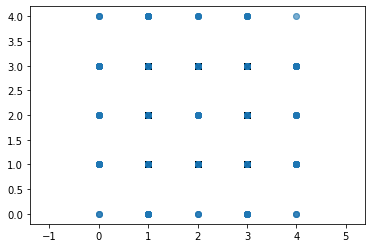

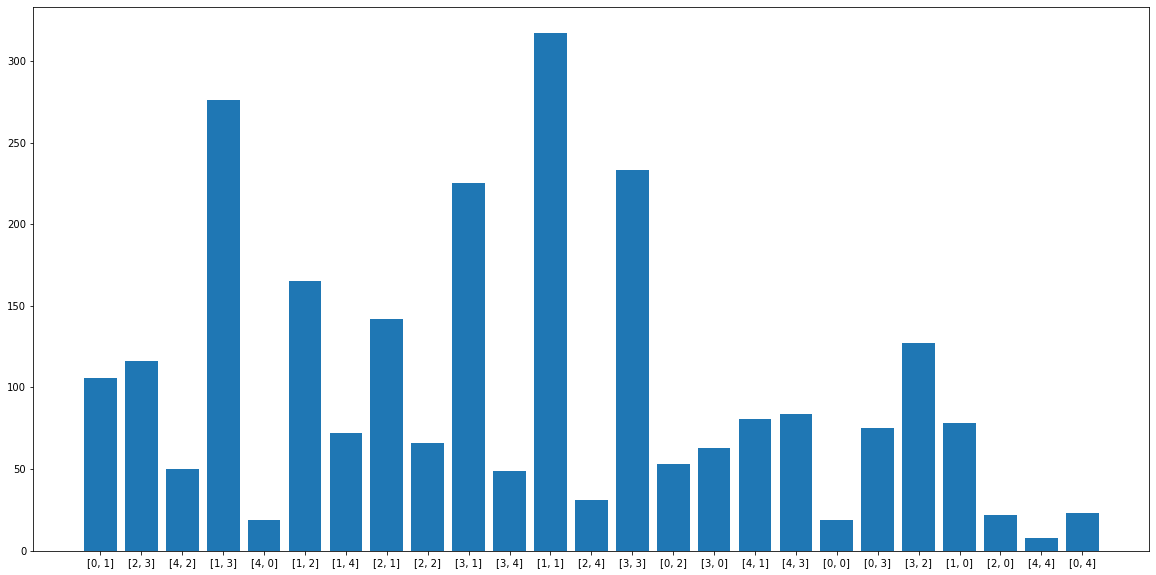

Processing Epoch 60
training start
Iteration 0, d real/fake loss 0.5634654760360718/0.6642732620239258 and g loss is 0.8750295639038086, NDiv loss 0.038239527493715286
Iteration 1, d real/fake loss 0.5637864470481873/0.6473491191864014 and g loss is 0.8138871192932129, NDiv loss 0.0431048758327961
Iteration 2, d real/fake loss 0.5640459656715393/0.6400730609893799 and g loss is 0.8356589078903198, NDiv loss 0.04632783681154251
Iteration 3, d real/fake loss 0.5642184019088745/0.6567344069480896 and g loss is 0.8866153955459595, NDiv loss 0.04316847771406174
Iteration 4, d real/fake loss 0.5639494061470032/0.6183605790138245 and g loss is 0.8550524711608887, NDiv loss 0.03972700983285904


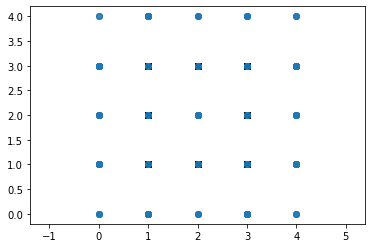

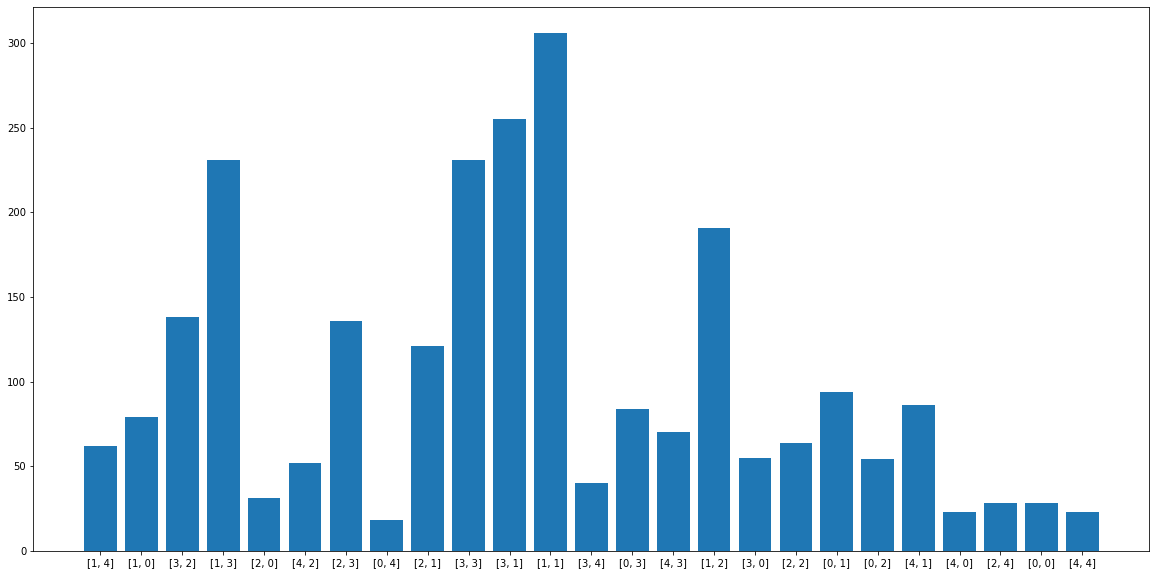

Processing Epoch 61
training start
Iteration 0, d real/fake loss 0.5562442541122437/0.6974301338195801 and g loss is 0.8668904304504395, NDiv loss 0.04044725000858307
Iteration 1, d real/fake loss 0.5562111735343933/0.6593620777130127 and g loss is 0.9086390733718872, NDiv loss 0.04915245249867439
Iteration 2, d real/fake loss 0.5561554431915283/0.633057713508606 and g loss is 0.9111559987068176, NDiv loss 0.0462595671415329
Iteration 3, d real/fake loss 0.5559158325195312/0.6903942823410034 and g loss is 0.8657361268997192, NDiv loss 0.04398610442876816
Iteration 4, d real/fake loss 0.5560325980186462/0.642572283744812 and g loss is 0.8562617897987366, NDiv loss 0.03882746770977974


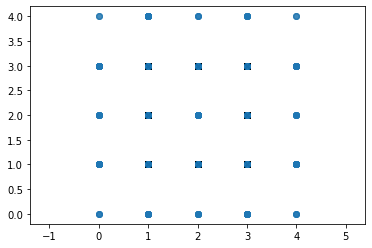

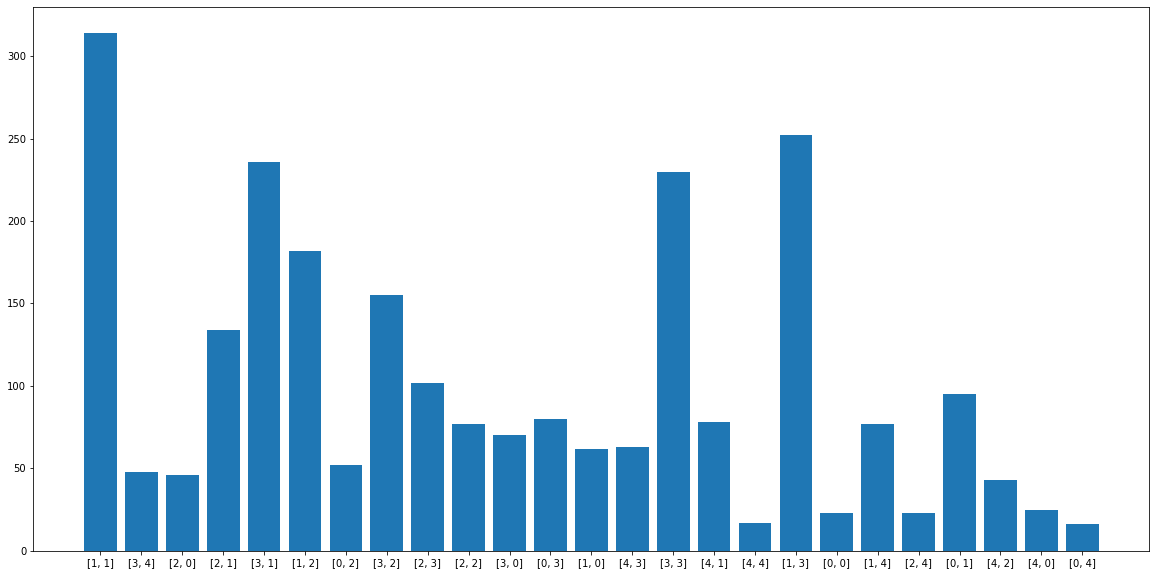

Processing Epoch 62
training start
Iteration 0, d real/fake loss 0.5563278794288635/0.6493441462516785 and g loss is 0.8176240921020508, NDiv loss 0.051356300711631775
Iteration 1, d real/fake loss 0.5564552545547485/0.6632659435272217 and g loss is 0.7854889631271362, NDiv loss 0.05283321440219879
Iteration 2, d real/fake loss 0.5567504167556763/0.6473889350891113 and g loss is 0.8541720509529114, NDiv loss 0.05261300876736641
Iteration 3, d real/fake loss 0.5571111440658569/0.6365092992782593 and g loss is 0.8454768657684326, NDiv loss 0.04977969080209732
Iteration 4, d real/fake loss 0.557342529296875/0.6261258721351624 and g loss is 0.9353477954864502, NDiv loss 0.048305392265319824


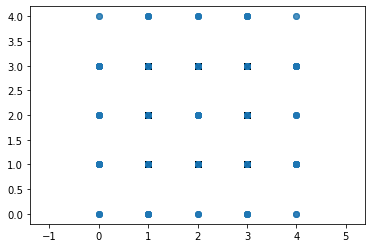

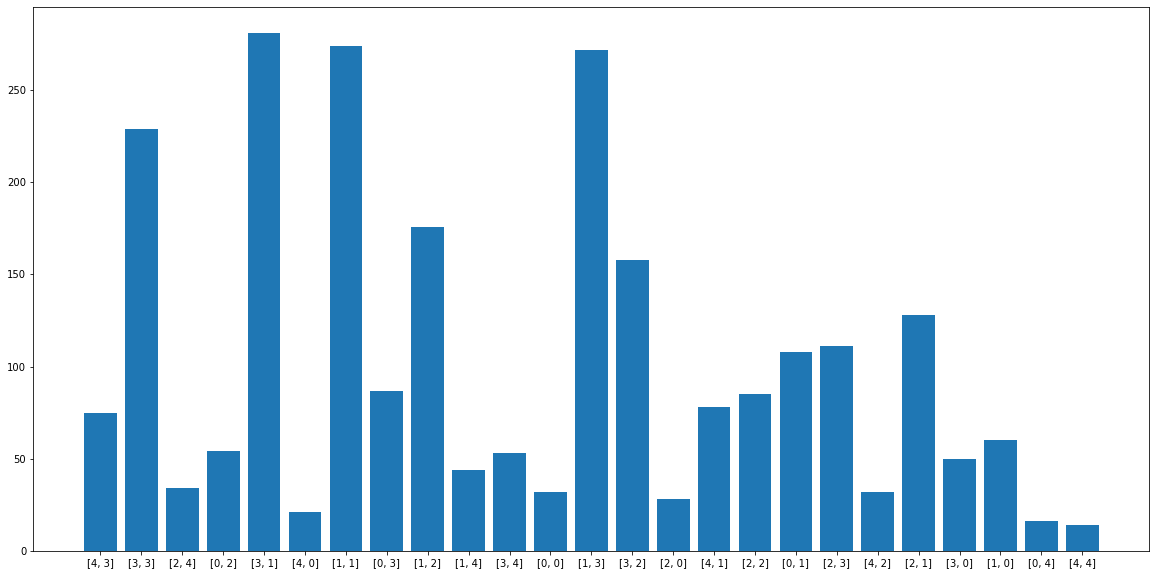

Processing Epoch 63
training start
Iteration 0, d real/fake loss 0.5569729804992676/0.6581003665924072 and g loss is 0.8621609807014465, NDiv loss 0.048029471188783646
Iteration 1, d real/fake loss 0.5569162368774414/0.668234646320343 and g loss is 0.819555938243866, NDiv loss 0.04433751478791237
Iteration 2, d real/fake loss 0.5571231245994568/0.6825064420700073 and g loss is 0.8459784388542175, NDiv loss 0.050425972789525986
Iteration 3, d real/fake loss 0.5574504733085632/0.6549180746078491 and g loss is 0.8569790124893188, NDiv loss 0.051886484026908875
Iteration 4, d real/fake loss 0.5577808618545532/0.6811656951904297 and g loss is 0.8663803339004517, NDiv loss 0.061810366809368134


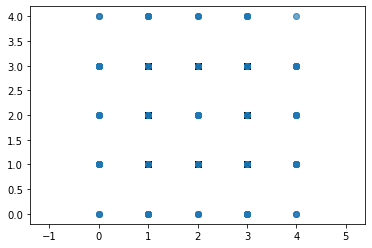

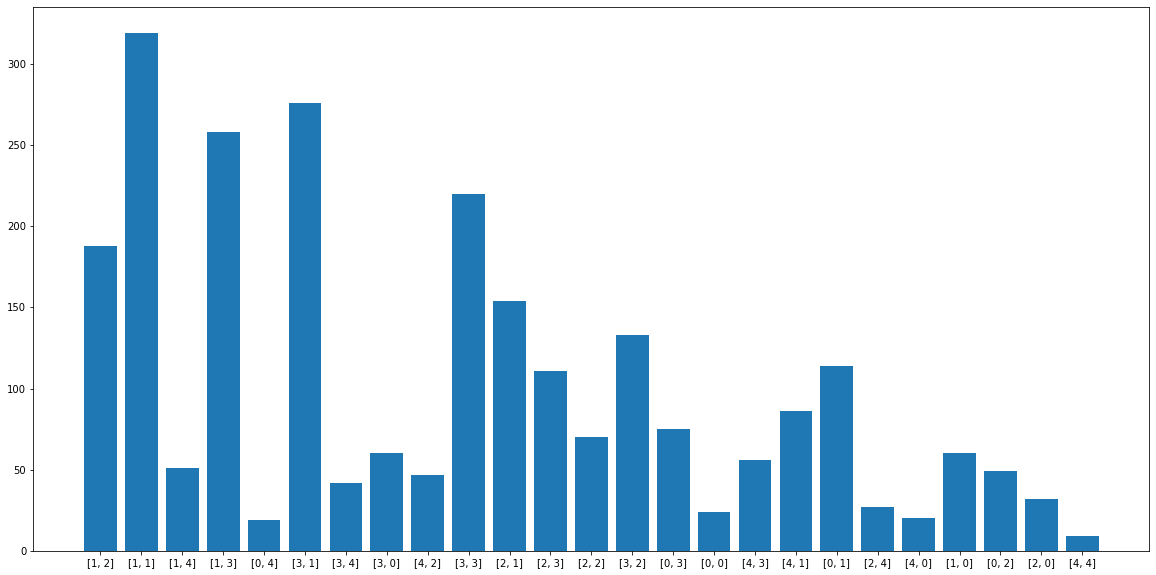

Processing Epoch 64
training start
Iteration 0, d real/fake loss 0.5635484457015991/0.661941409111023 and g loss is 0.8166894912719727, NDiv loss 0.05337134748697281
Iteration 1, d real/fake loss 0.563700795173645/0.6227984428405762 and g loss is 0.8773874044418335, NDiv loss 0.048557933419942856
Iteration 2, d real/fake loss 0.5637094974517822/0.6519342660903931 and g loss is 0.8152947425842285, NDiv loss 0.04392796754837036
Iteration 3, d real/fake loss 0.5638532638549805/0.6504191160202026 and g loss is 0.8905290961265564, NDiv loss 0.052763406187295914
Iteration 4, d real/fake loss 0.5640174746513367/0.6810235977172852 and g loss is 0.8749069571495056, NDiv loss 0.0589936263859272


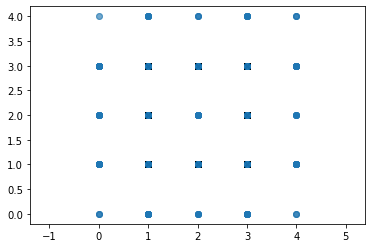

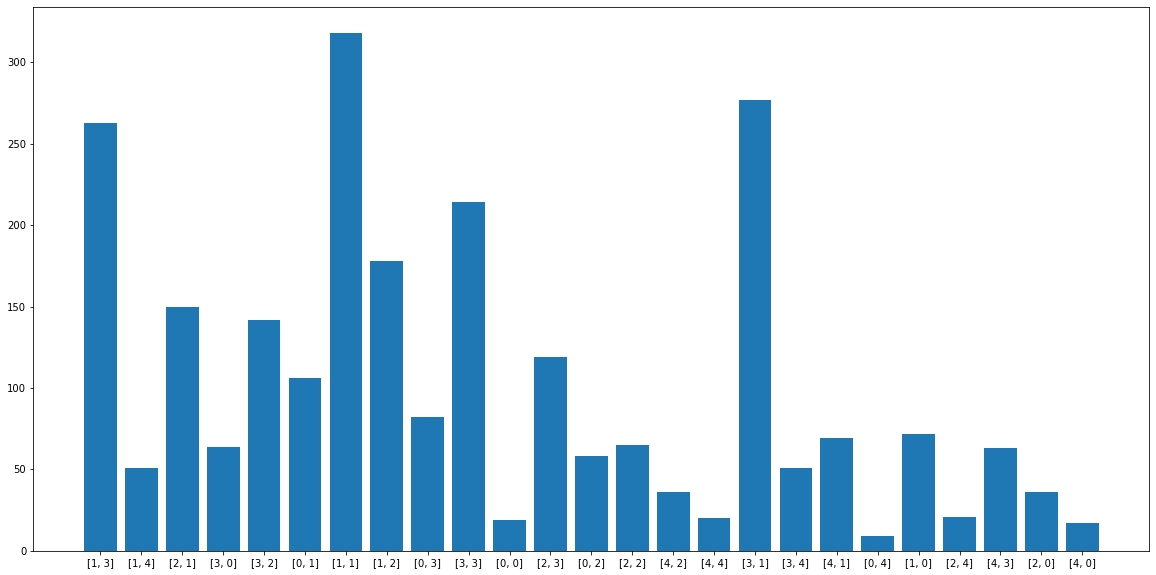

Processing Epoch 65
training start
Iteration 0, d real/fake loss 0.5531197786331177/0.6431261301040649 and g loss is 0.8844186663627625, NDiv loss 0.04006531462073326
Iteration 1, d real/fake loss 0.5538662672042847/0.6566428542137146 and g loss is 0.8908948302268982, NDiv loss 0.04595828428864479
Iteration 2, d real/fake loss 0.5545253753662109/0.675269365310669 and g loss is 0.833209216594696, NDiv loss 0.05058871582150459
Iteration 3, d real/fake loss 0.5550844073295593/0.629926323890686 and g loss is 0.8740251064300537, NDiv loss 0.0473904050886631
Iteration 4, d real/fake loss 0.5553219318389893/0.6449888348579407 and g loss is 0.901450514793396, NDiv loss 0.04357161000370979


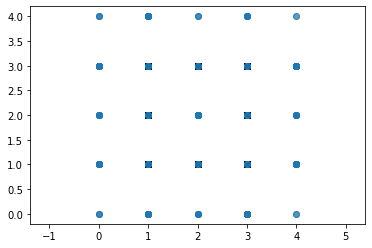

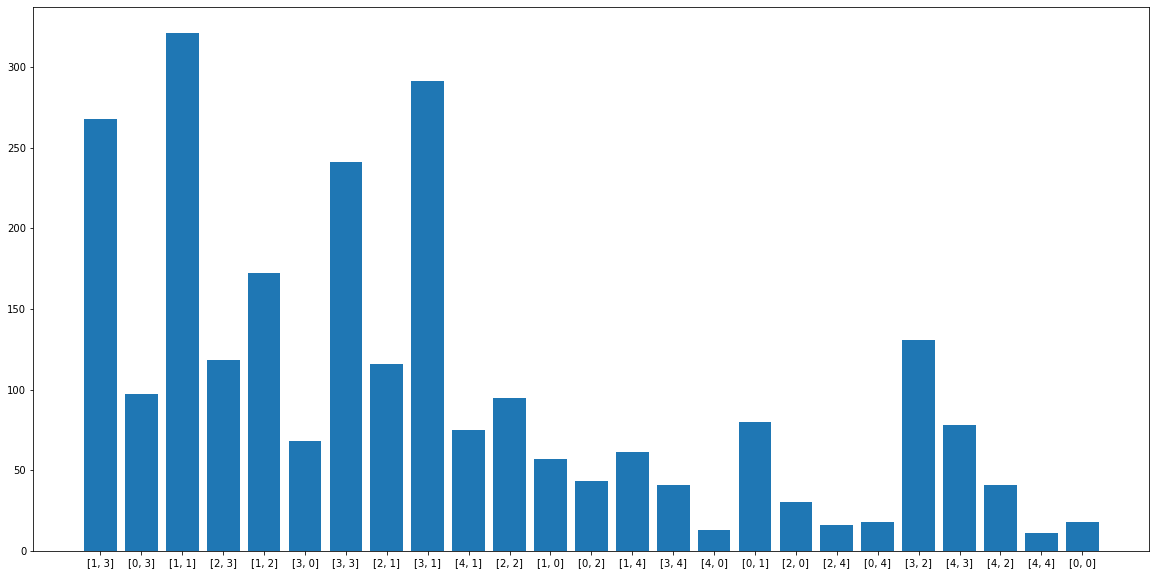

Processing Epoch 66
training start
Iteration 0, d real/fake loss 0.5575175285339355/0.6731929779052734 and g loss is 0.8497281074523926, NDiv loss 0.058194611221551895
Iteration 1, d real/fake loss 0.5581352114677429/0.6477023363113403 and g loss is 0.8142760396003723, NDiv loss 0.0422409325838089
Iteration 2, d real/fake loss 0.5585582256317139/0.6358654499053955 and g loss is 0.8529834747314453, NDiv loss 0.05526696890592575
Iteration 3, d real/fake loss 0.5590521097183228/0.6213233470916748 and g loss is 0.812335729598999, NDiv loss 0.05179973691701889
Iteration 4, d real/fake loss 0.5595165491104126/0.632207453250885 and g loss is 0.8297692537307739, NDiv loss 0.05186823010444641


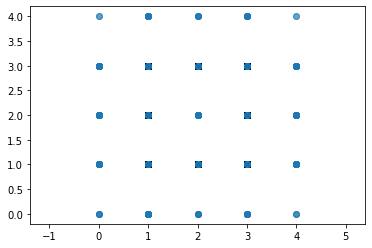

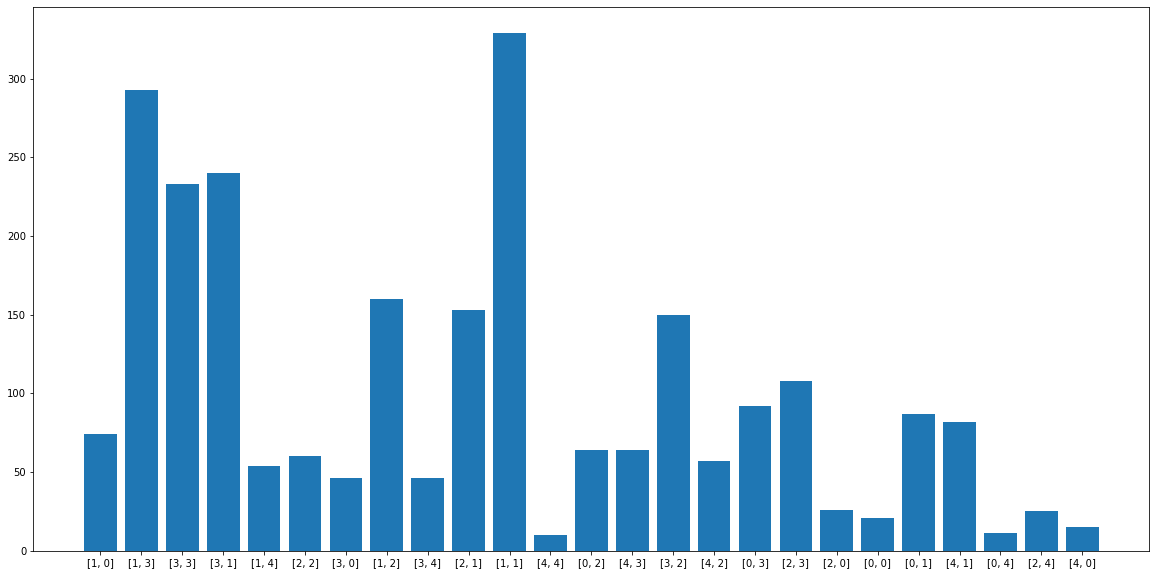

Processing Epoch 67
training start
Iteration 0, d real/fake loss 0.5652689933776855/0.6234142780303955 and g loss is 0.8726285099983215, NDiv loss 0.04718833789229393
Iteration 1, d real/fake loss 0.5656667947769165/0.6308417320251465 and g loss is 0.8895785808563232, NDiv loss 0.05033547803759575
Iteration 2, d real/fake loss 0.5659854412078857/0.6352390050888062 and g loss is 0.8594115972518921, NDiv loss 0.04657619073987007
Iteration 3, d real/fake loss 0.5659834146499634/0.6392999291419983 and g loss is 0.8660486936569214, NDiv loss 0.04886776953935623
Iteration 4, d real/fake loss 0.5657326579093933/0.6636549234390259 and g loss is 0.7876128554344177, NDiv loss 0.05330173298716545


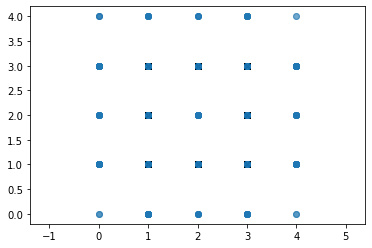

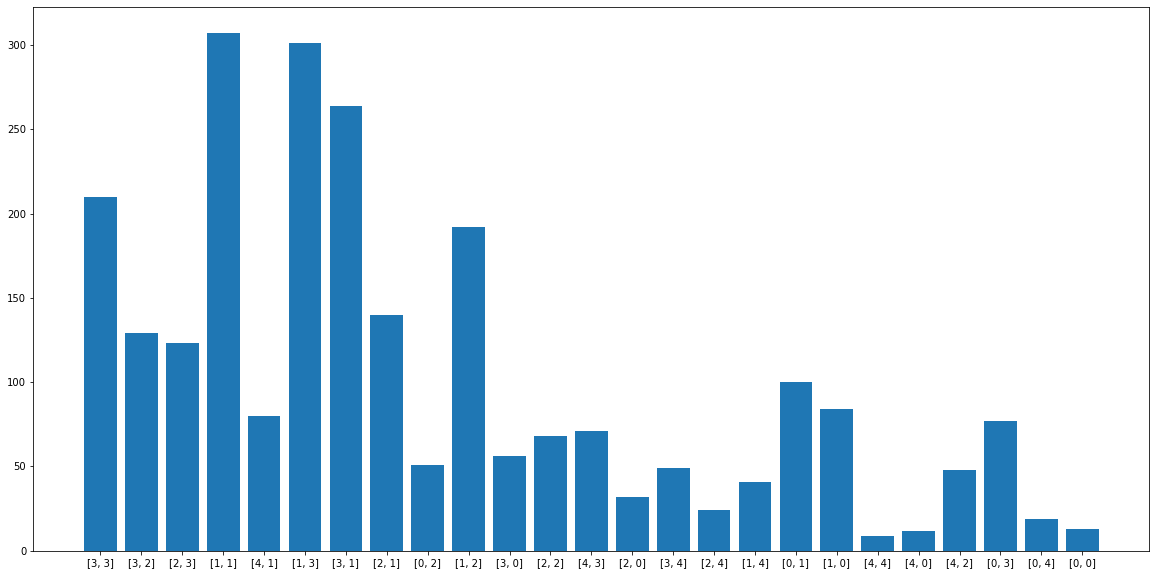

Processing Epoch 68
training start
Iteration 0, d real/fake loss 0.5661429166793823/0.6690762042999268 and g loss is 0.8263130187988281, NDiv loss 0.055612578988075256
Iteration 1, d real/fake loss 0.5661873817443848/0.651086151599884 and g loss is 0.8034756183624268, NDiv loss 0.04829617589712143
Iteration 2, d real/fake loss 0.5663406252861023/0.6472705006599426 and g loss is 0.8025599122047424, NDiv loss 0.04025676101446152
Iteration 3, d real/fake loss 0.566520094871521/0.6545512080192566 and g loss is 0.893937349319458, NDiv loss 0.05016515031456947
Iteration 4, d real/fake loss 0.566802442073822/0.6439972519874573 and g loss is 0.8504061698913574, NDiv loss 0.052571315318346024


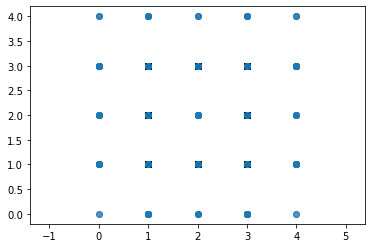

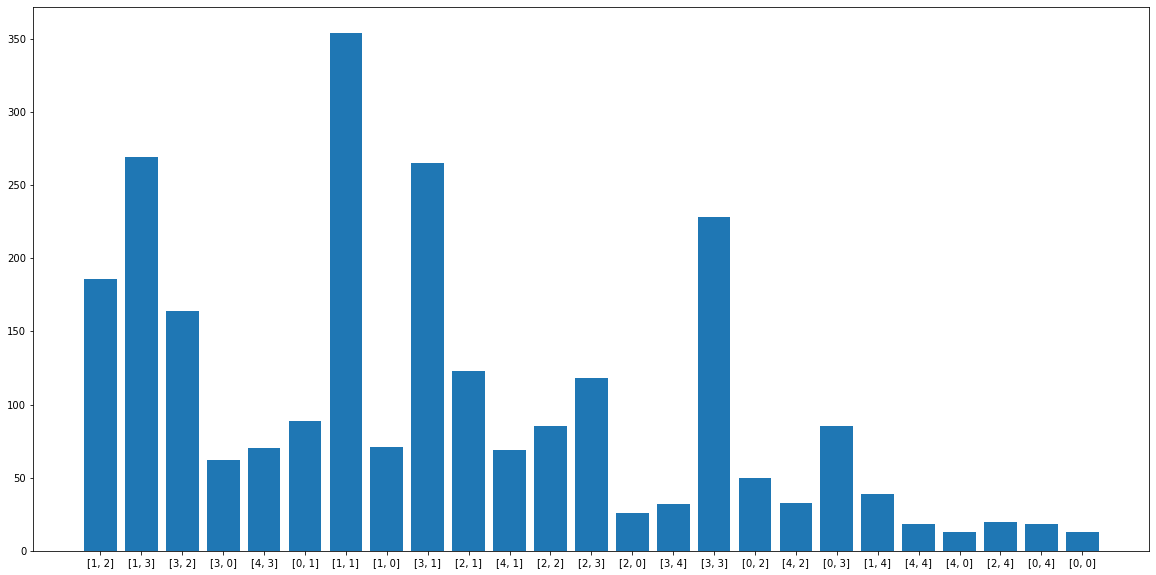

Processing Epoch 69
training start
Iteration 0, d real/fake loss 0.5804071426391602/0.6441255211830139 and g loss is 0.8150259852409363, NDiv loss 0.04369935020804405
Iteration 1, d real/fake loss 0.5802035331726074/0.6613351702690125 and g loss is 0.8856523036956787, NDiv loss 0.053257063031196594
Iteration 2, d real/fake loss 0.5797311663627625/0.6649825572967529 and g loss is 0.8833794593811035, NDiv loss 0.0554032102227211
Iteration 3, d real/fake loss 0.5794750452041626/0.628787100315094 and g loss is 0.8937661051750183, NDiv loss 0.050469156354665756
Iteration 4, d real/fake loss 0.5789411664009094/0.6372866034507751 and g loss is 0.8068829774856567, NDiv loss 0.04418355971574783


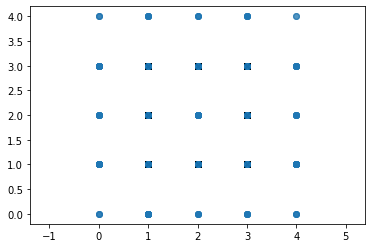

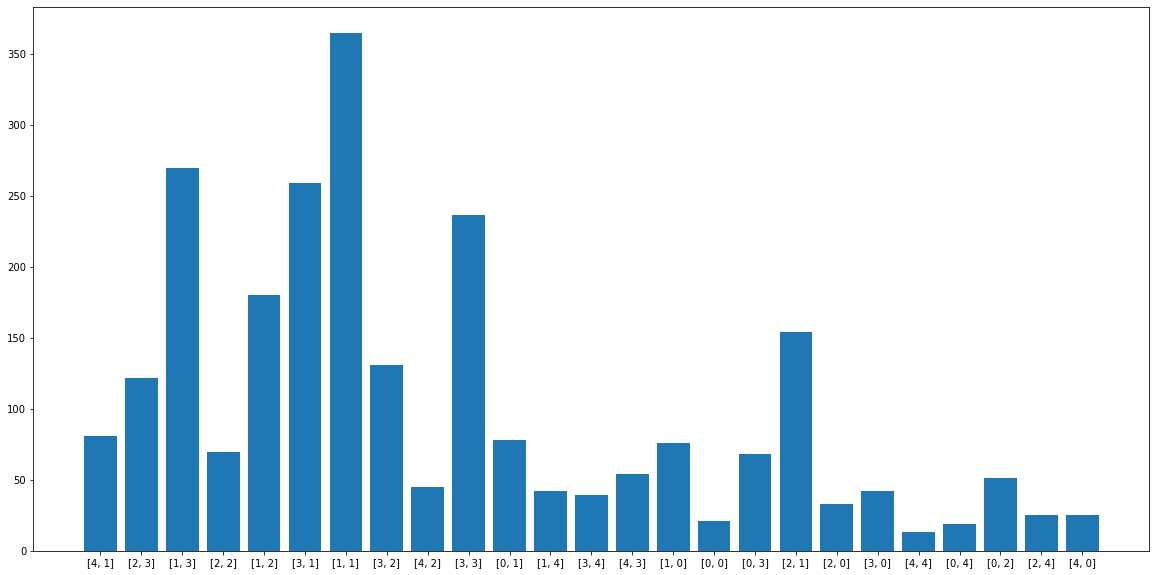

Processing Epoch 70
training start
Iteration 0, d real/fake loss 0.5730125904083252/0.6081771850585938 and g loss is 0.9164594411849976, NDiv loss 0.050902508199214935
Iteration 1, d real/fake loss 0.5721510052680969/0.6722111701965332 and g loss is 0.9039812684059143, NDiv loss 0.04737723246216774
Iteration 2, d real/fake loss 0.5714359283447266/0.7012386322021484 and g loss is 0.920901358127594, NDiv loss 0.04879656061530113
Iteration 3, d real/fake loss 0.5708866119384766/0.660306990146637 and g loss is 0.8850167989730835, NDiv loss 0.06041377782821655
Iteration 4, d real/fake loss 0.5705299377441406/0.693627655506134 and g loss is 0.8470801711082458, NDiv loss 0.04351650923490524


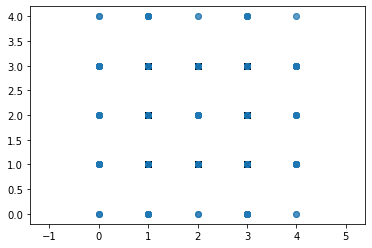

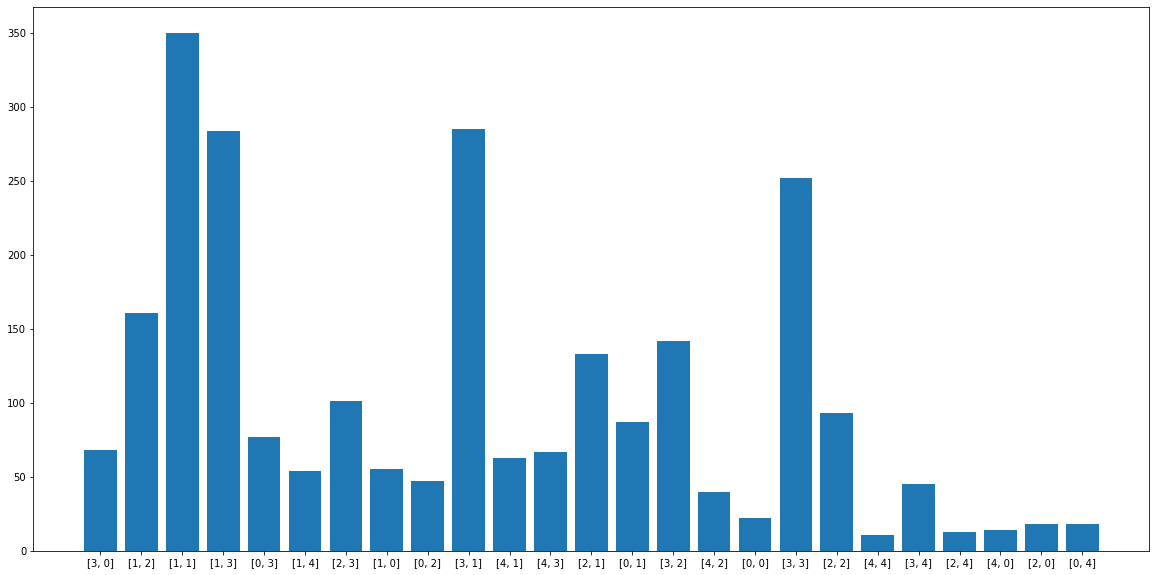

Processing Epoch 71
training start
Iteration 0, d real/fake loss 0.5633963346481323/0.6551002860069275 and g loss is 0.8822429180145264, NDiv loss 0.052366893738508224
Iteration 1, d real/fake loss 0.5637646913528442/0.6450755000114441 and g loss is 0.8676630854606628, NDiv loss 0.04847510904073715
Iteration 2, d real/fake loss 0.5639201402664185/0.6452981233596802 and g loss is 0.9008734226226807, NDiv loss 0.04360688477754593
Iteration 3, d real/fake loss 0.563958466053009/0.6650134921073914 and g loss is 0.8490855693817139, NDiv loss 0.04371887072920799
Iteration 4, d real/fake loss 0.5640087127685547/0.6071709990501404 and g loss is 0.8812796473503113, NDiv loss 0.04886077344417572


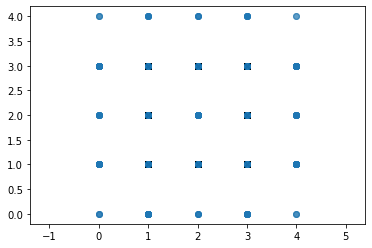

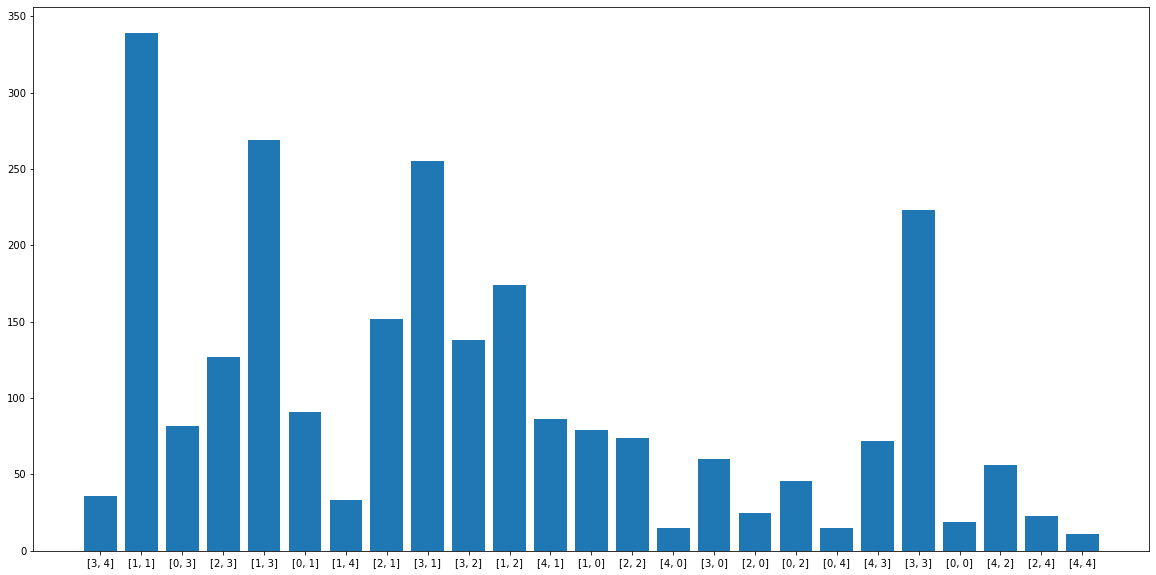

Processing Epoch 72
training start
Iteration 0, d real/fake loss 0.5681836605072021/0.6879532337188721 and g loss is 0.9479682445526123, NDiv loss 0.0485653318464756
Iteration 1, d real/fake loss 0.5688438415527344/0.662420392036438 and g loss is 0.9505683183670044, NDiv loss 0.04479752853512764
Iteration 2, d real/fake loss 0.569439172744751/0.6054553985595703 and g loss is 0.859552264213562, NDiv loss 0.05353757366538048
Iteration 3, d real/fake loss 0.569922924041748/0.6781044602394104 and g loss is 0.9935572147369385, NDiv loss 0.05162622407078743
Iteration 4, d real/fake loss 0.5702793598175049/0.6404716968536377 and g loss is 0.92816162109375, NDiv loss 0.05342719331383705


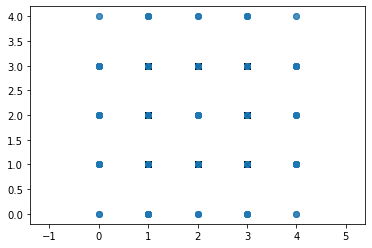

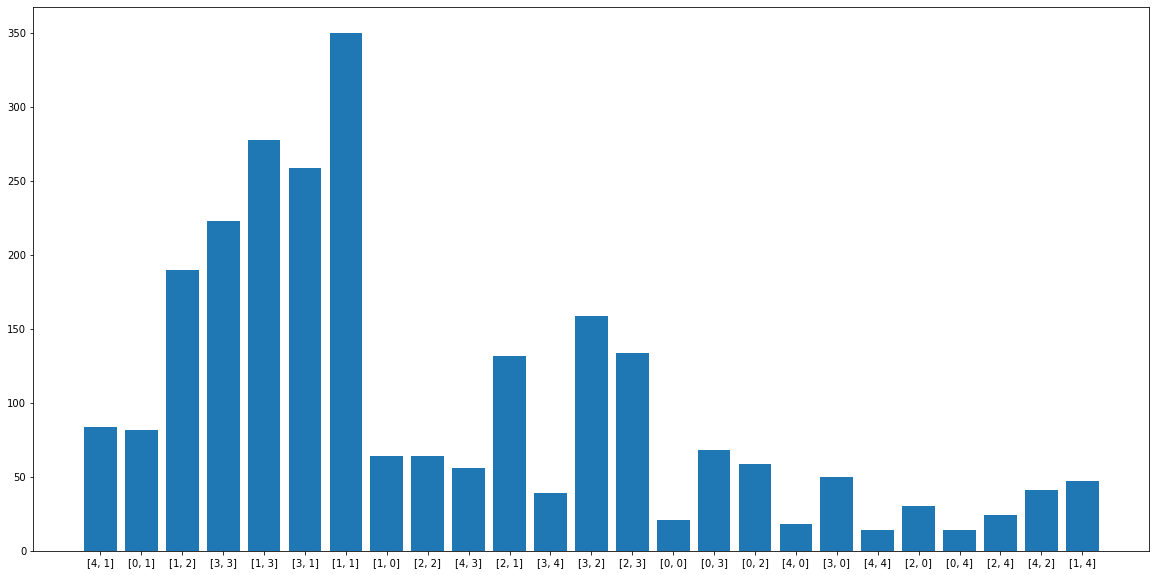

Processing Epoch 73
training start
Iteration 0, d real/fake loss 0.5893297791481018/0.646206259727478 and g loss is 0.7849931716918945, NDiv loss 0.04435714706778526
Iteration 1, d real/fake loss 0.5887420773506165/0.6276017427444458 and g loss is 0.884831428527832, NDiv loss 0.046506617218256
Iteration 2, d real/fake loss 0.5877308249473572/0.6151231527328491 and g loss is 0.860204815864563, NDiv loss 0.052188143134117126
Iteration 3, d real/fake loss 0.5864832997322083/0.6495429277420044 and g loss is 1.0028862953186035, NDiv loss 0.050419215112924576
Iteration 4, d real/fake loss 0.5851779580116272/0.6798885464668274 and g loss is 0.8437142968177795, NDiv loss 0.06295844912528992


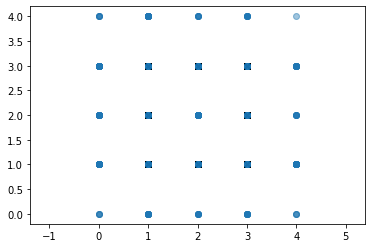

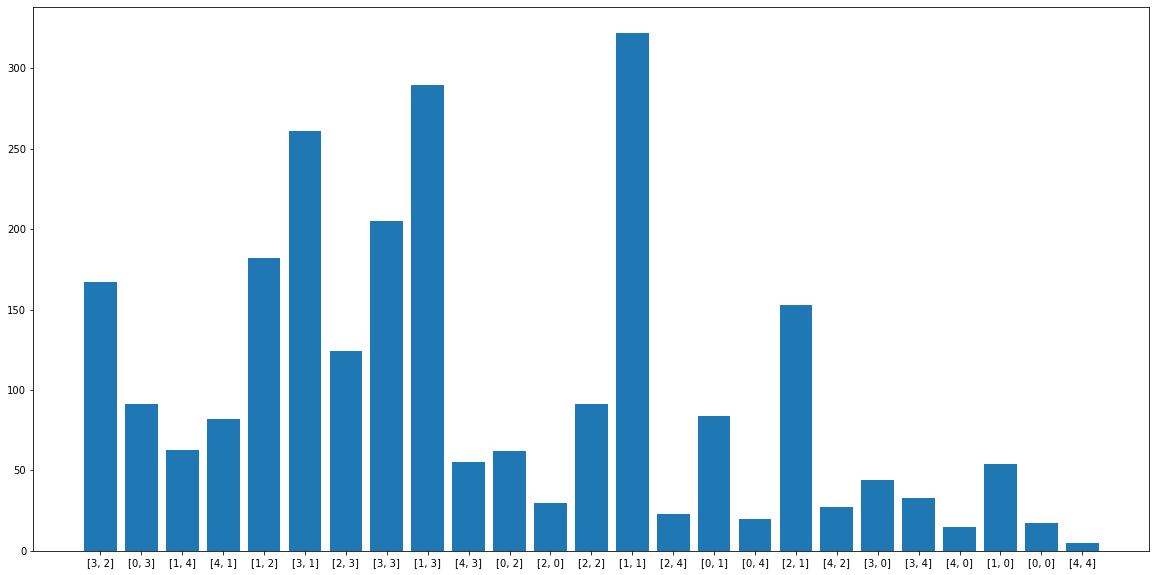

Processing Epoch 74
training start
Iteration 0, d real/fake loss 0.5686661005020142/0.6485996246337891 and g loss is 0.8264123201370239, NDiv loss 0.05041319131851196
Iteration 1, d real/fake loss 0.5680410861968994/0.6352956295013428 and g loss is 0.8905190229415894, NDiv loss 0.05412916839122772
Iteration 2, d real/fake loss 0.5675526857376099/0.6630470752716064 and g loss is 0.8571273684501648, NDiv loss 0.049032583832740784
Iteration 3, d real/fake loss 0.5676305294036865/0.6780848503112793 and g loss is 0.9615302085876465, NDiv loss 0.05243831127882004
Iteration 4, d real/fake loss 0.5681135654449463/0.6570647358894348 and g loss is 0.8486917018890381, NDiv loss 0.051539838314056396


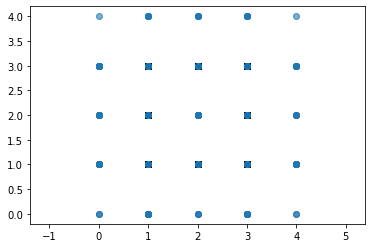

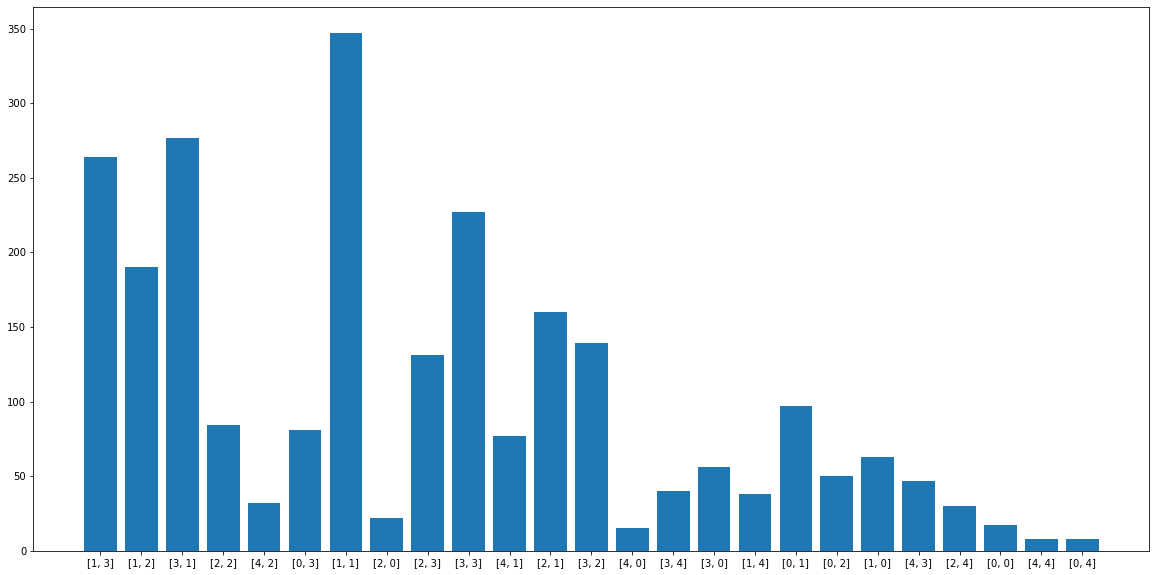

Processing Epoch 75
training start
Iteration 0, d real/fake loss 0.5698359608650208/0.6544402241706848 and g loss is 0.8495507836341858, NDiv loss 0.0616924948990345
Iteration 1, d real/fake loss 0.5705549716949463/0.6331098675727844 and g loss is 0.7961863875389099, NDiv loss 0.04937263950705528
Iteration 2, d real/fake loss 0.571050763130188/0.6239231824874878 and g loss is 0.9038124680519104, NDiv loss 0.05353253334760666
Iteration 3, d real/fake loss 0.5715044140815735/0.6512347459793091 and g loss is 0.8997067213058472, NDiv loss 0.04835310950875282
Iteration 4, d real/fake loss 0.5723502039909363/0.616129457950592 and g loss is 0.9053608179092407, NDiv loss 0.05032883584499359


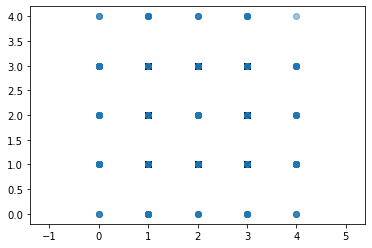

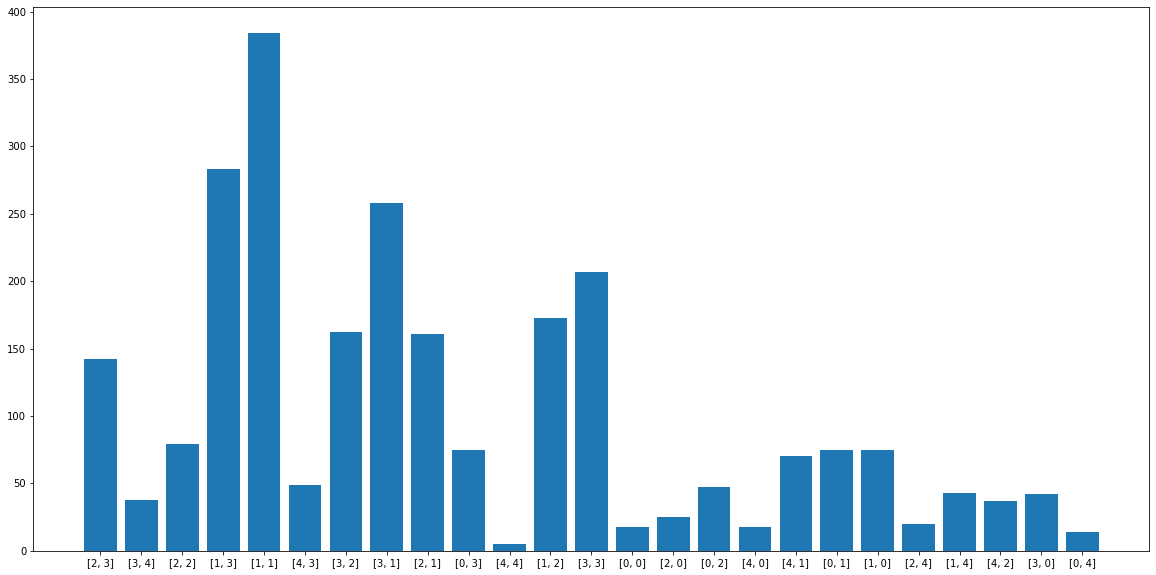

Processing Epoch 76
training start
Iteration 0, d real/fake loss 0.5698828101158142/0.6229987740516663 and g loss is 0.9398345351219177, NDiv loss 0.05172054469585419
Iteration 1, d real/fake loss 0.5705481767654419/0.6759607195854187 and g loss is 0.832900881767273, NDiv loss 0.05053379386663437
Iteration 2, d real/fake loss 0.571034848690033/0.6636126637458801 and g loss is 0.8555812239646912, NDiv loss 0.050794292241334915
Iteration 3, d real/fake loss 0.5714688301086426/0.5946410894393921 and g loss is 0.8447723388671875, NDiv loss 0.06264038383960724
Iteration 4, d real/fake loss 0.5715303421020508/0.6128727197647095 and g loss is 0.8432753682136536, NDiv loss 0.05376976355910301


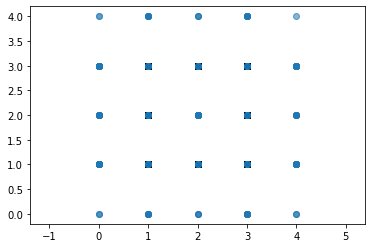

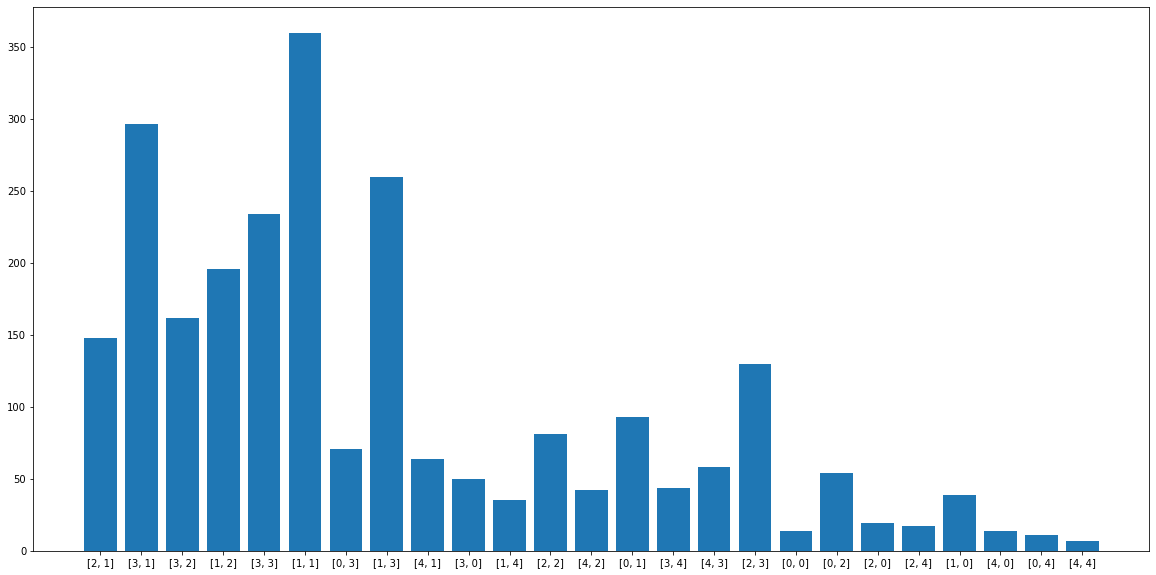

Processing Epoch 77
training start
Iteration 0, d real/fake loss 0.5691922307014465/0.6593769192695618 and g loss is 0.8623300790786743, NDiv loss 0.044537436217069626
Iteration 1, d real/fake loss 0.5695664882659912/0.6400453448295593 and g loss is 0.9160612225532532, NDiv loss 0.04605776071548462
Iteration 2, d real/fake loss 0.5695728063583374/0.627074658870697 and g loss is 0.8762584924697876, NDiv loss 0.06093506142497063
Iteration 3, d real/fake loss 0.5695364475250244/0.6731017827987671 and g loss is 0.8741337060928345, NDiv loss 0.05409780889749527
Iteration 4, d real/fake loss 0.5697845816612244/0.630624532699585 and g loss is 0.8691373467445374, NDiv loss 0.057140324264764786


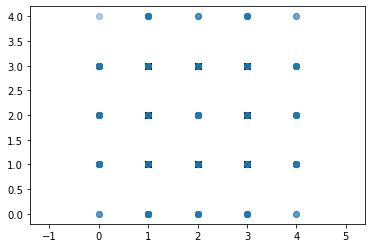

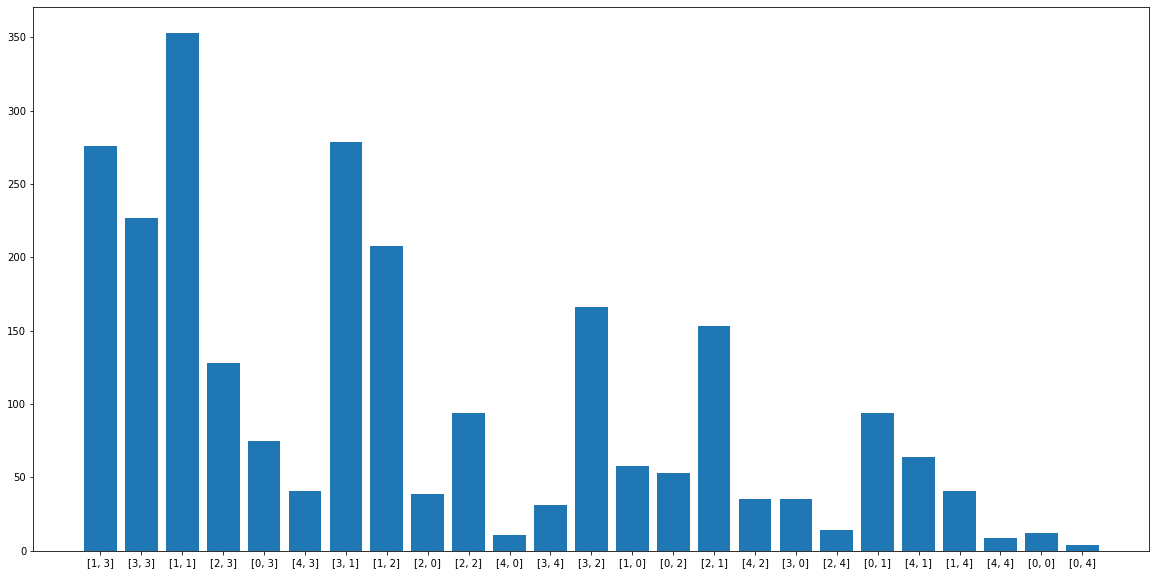

Processing Epoch 78
training start
Iteration 0, d real/fake loss 0.5775488018989563/0.6370348930358887 and g loss is 0.9239673018455505, NDiv loss 0.051350630819797516
Iteration 1, d real/fake loss 0.577788233757019/0.6556175947189331 and g loss is 0.9573373794555664, NDiv loss 0.04517562687397003
Iteration 2, d real/fake loss 0.5780340433120728/0.6361393332481384 and g loss is 0.9424766302108765, NDiv loss 0.05348530411720276
Iteration 3, d real/fake loss 0.5781004428863525/0.6602441072463989 and g loss is 0.8942893743515015, NDiv loss 0.04708439111709595
Iteration 4, d real/fake loss 0.5780526995658875/0.651710033416748 and g loss is 0.860159158706665, NDiv loss 0.0468563511967659


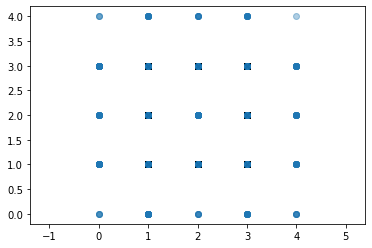

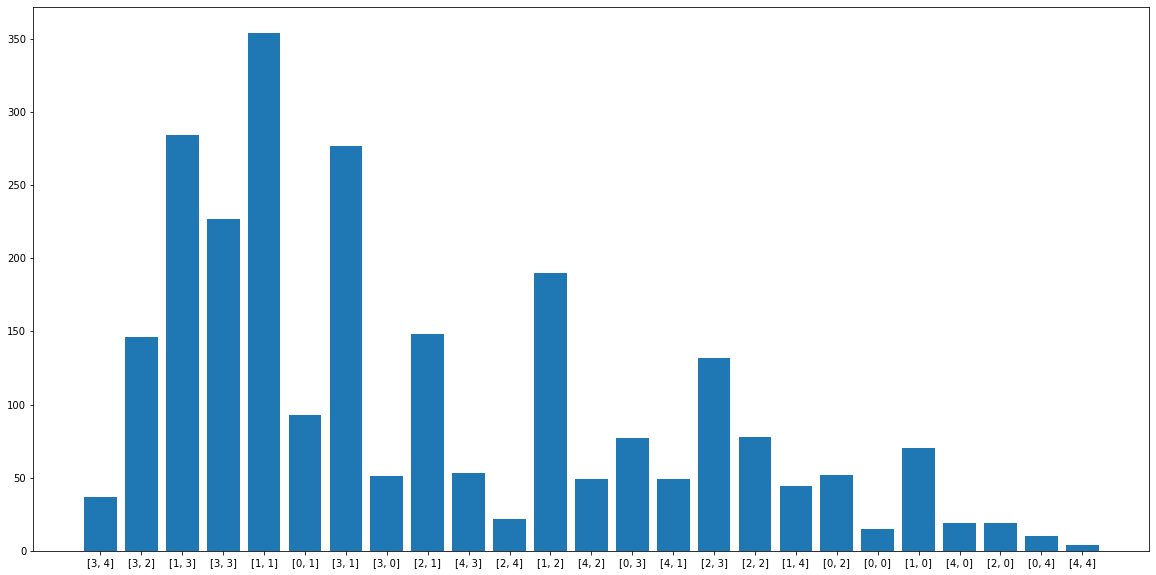

Processing Epoch 79
training start
Iteration 0, d real/fake loss 0.5866667032241821/0.6370512247085571 and g loss is 0.9278102517127991, NDiv loss 0.051306601613759995
Iteration 1, d real/fake loss 0.5867056846618652/0.6305468678474426 and g loss is 0.8478454351425171, NDiv loss 0.04714963585138321
Iteration 2, d real/fake loss 0.5867007970809937/0.6298897862434387 and g loss is 0.8032010793685913, NDiv loss 0.0516185462474823
Iteration 3, d real/fake loss 0.5863966345787048/0.6343515515327454 and g loss is 0.8902992010116577, NDiv loss 0.04404518008232117
Iteration 4, d real/fake loss 0.5859642028808594/0.6706088781356812 and g loss is 0.8087205290794373, NDiv loss 0.04831497743725777


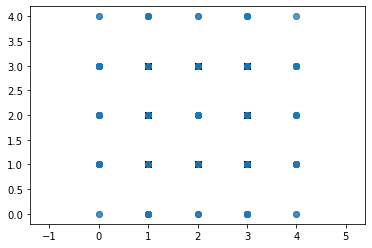

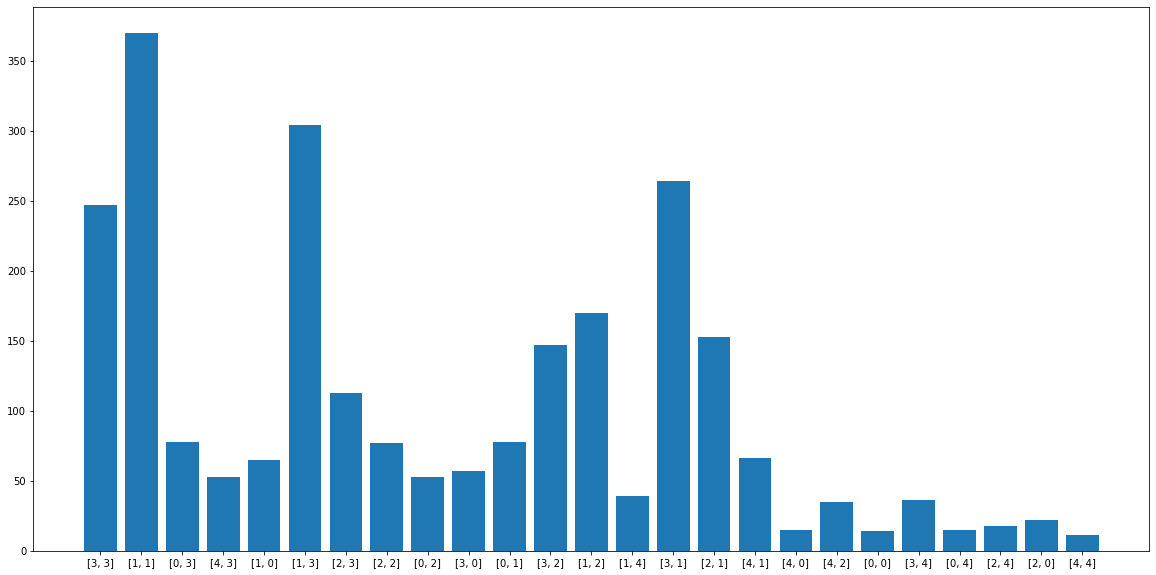

Processing Epoch 80
training start
Iteration 0, d real/fake loss 0.5830138921737671/0.6506716012954712 and g loss is 0.9071224927902222, NDiv loss 0.04829660803079605
Iteration 1, d real/fake loss 0.5826519131660461/0.6310428380966187 and g loss is 0.8469176292419434, NDiv loss 0.047372665256261826
Iteration 2, d real/fake loss 0.5820000171661377/0.6290196776390076 and g loss is 0.906059980392456, NDiv loss 0.057653192430734634
Iteration 3, d real/fake loss 0.5812851190567017/0.6337001919746399 and g loss is 0.9329556226730347, NDiv loss 0.052507687360048294
Iteration 4, d real/fake loss 0.5809957385063171/0.6458145976066589 and g loss is 0.8382292985916138, NDiv loss 0.046905457973480225


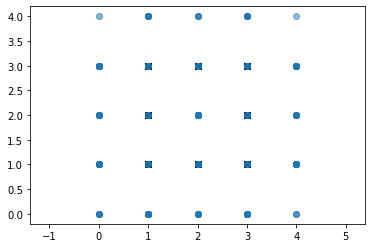

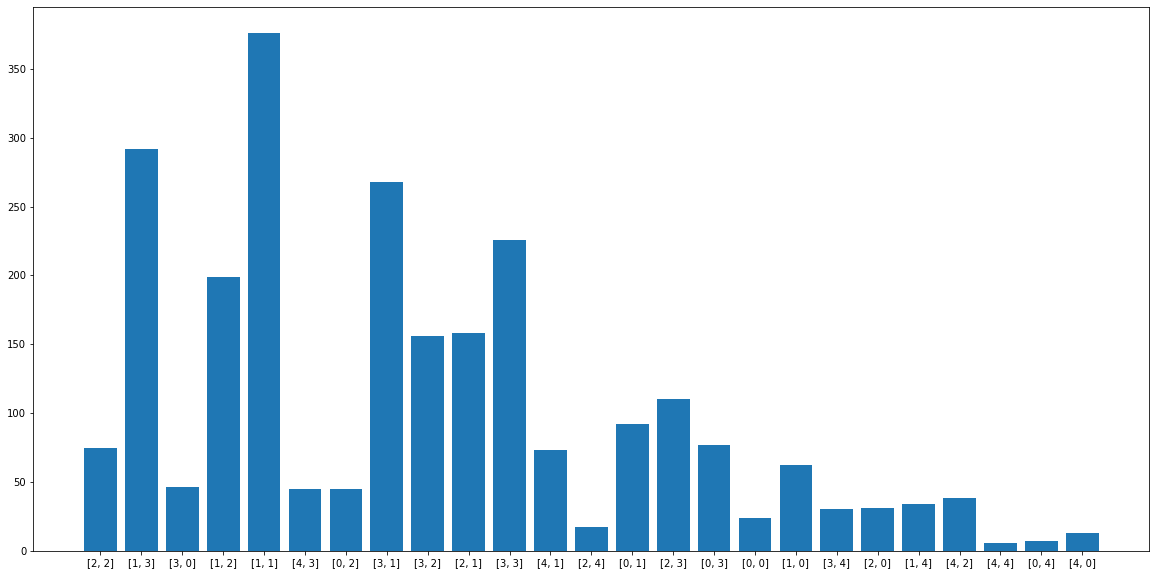

Processing Epoch 81
training start
Iteration 0, d real/fake loss 0.5761594772338867/0.6775593757629395 and g loss is 0.892056941986084, NDiv loss 0.04873386025428772
Iteration 1, d real/fake loss 0.5768495798110962/0.6064444184303284 and g loss is 0.8165270686149597, NDiv loss 0.05579628795385361
Iteration 2, d real/fake loss 0.5771369934082031/0.6166806817054749 and g loss is 1.0330073833465576, NDiv loss 0.04732094705104828
Iteration 3, d real/fake loss 0.5774047374725342/0.628743588924408 and g loss is 0.8633413910865784, NDiv loss 0.050489429384469986
Iteration 4, d real/fake loss 0.5775911808013916/0.6811574101448059 and g loss is 0.9851300716400146, NDiv loss 0.058920618146657944


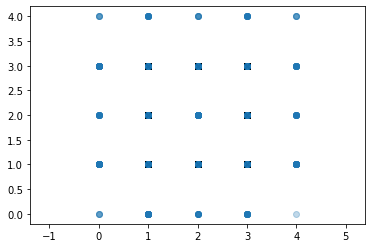

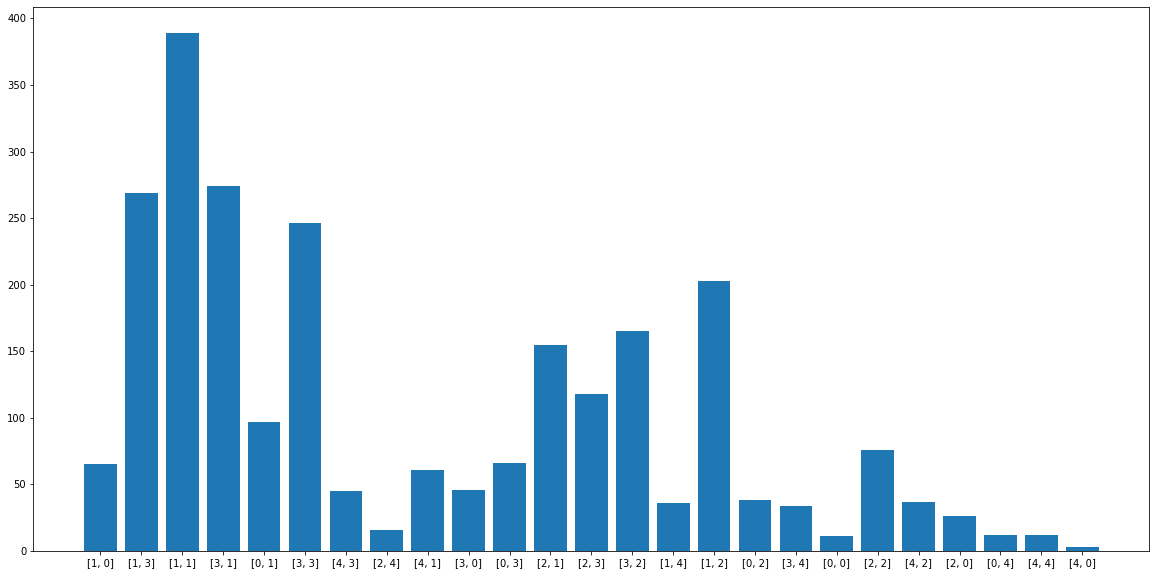

Processing Epoch 82
training start
Iteration 0, d real/fake loss 0.5816487669944763/0.5927541255950928 and g loss is 0.9451022148132324, NDiv loss 0.056820183992385864
Iteration 1, d real/fake loss 0.5813104510307312/0.6625699400901794 and g loss is 0.8903653621673584, NDiv loss 0.0567396804690361
Iteration 2, d real/fake loss 0.5807805061340332/0.6429171562194824 and g loss is 0.8763939738273621, NDiv loss 0.050390489399433136
Iteration 3, d real/fake loss 0.5802581310272217/0.6530891060829163 and g loss is 0.9299905300140381, NDiv loss 0.042202211916446686
Iteration 4, d real/fake loss 0.5798625946044922/0.6324858069419861 and g loss is 0.9102891683578491, NDiv loss 0.046321332454681396


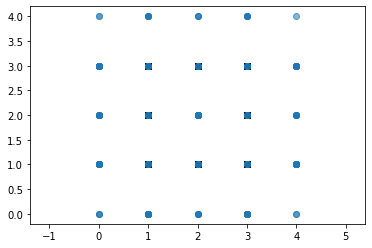

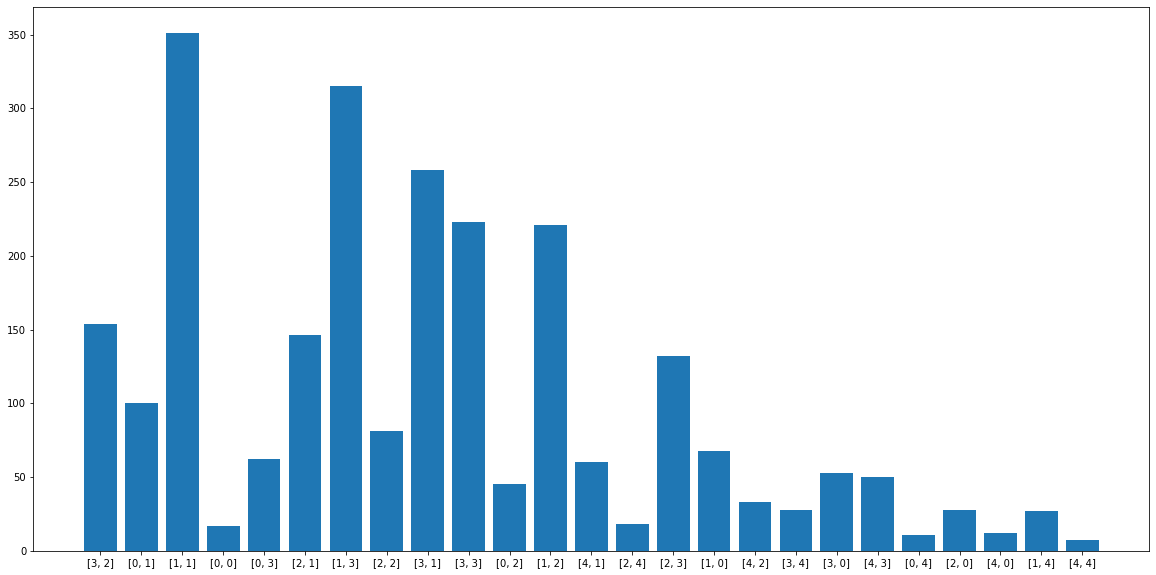

Processing Epoch 83
training start
Iteration 0, d real/fake loss 0.5816452503204346/0.6900800466537476 and g loss is 0.8901848793029785, NDiv loss 0.053958192467689514
Iteration 1, d real/fake loss 0.5810938477516174/0.6230093836784363 and g loss is 0.8884216547012329, NDiv loss 0.047428715974092484
Iteration 2, d real/fake loss 0.5801582932472229/0.6493878960609436 and g loss is 0.8640651106834412, NDiv loss 0.05815717577934265
Iteration 3, d real/fake loss 0.57943195104599/0.6058584451675415 and g loss is 0.9369734525680542, NDiv loss 0.060764130204916
Iteration 4, d real/fake loss 0.5788372755050659/0.6546114683151245 and g loss is 0.8459939360618591, NDiv loss 0.05223751813173294


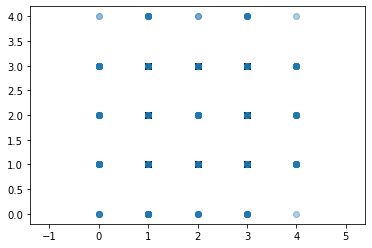

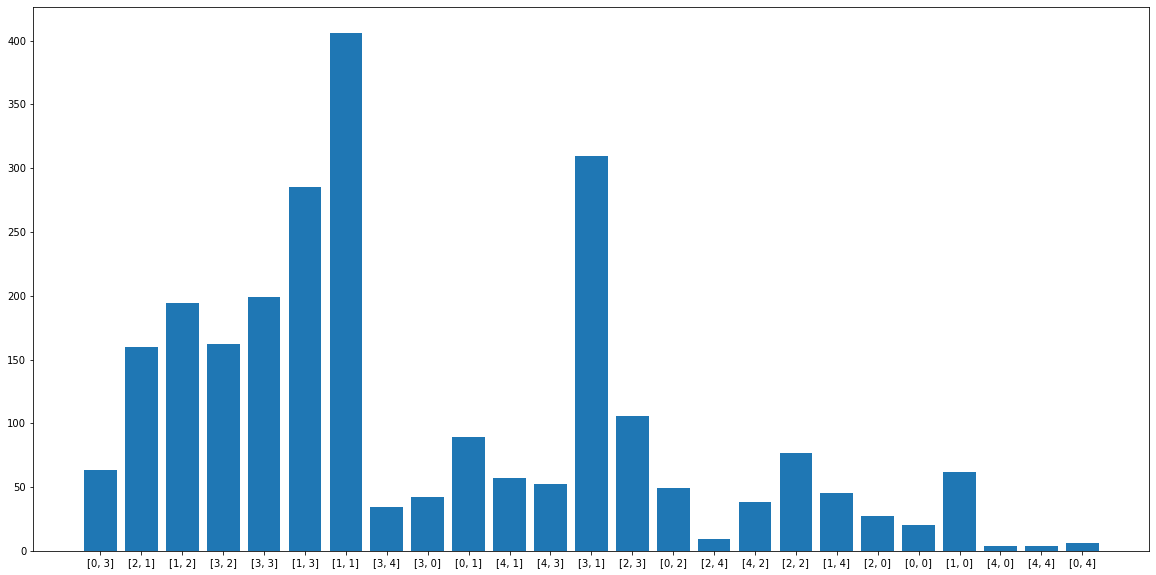

Processing Epoch 84
training start
Iteration 0, d real/fake loss 0.5872195959091187/0.6501185894012451 and g loss is 0.926551342010498, NDiv loss 0.046717043966054916
Iteration 1, d real/fake loss 0.586561918258667/0.6568417549133301 and g loss is 0.8892733454704285, NDiv loss 0.05076387897133827
Iteration 2, d real/fake loss 0.5858321189880371/0.6425724625587463 and g loss is 0.8416628837585449, NDiv loss 0.05119785666465759
Iteration 3, d real/fake loss 0.5850503444671631/0.6657906770706177 and g loss is 0.9059792757034302, NDiv loss 0.04375613480806351
Iteration 4, d real/fake loss 0.5847467184066772/0.6614547967910767 and g loss is 0.9531071186065674, NDiv loss 0.054911356419324875


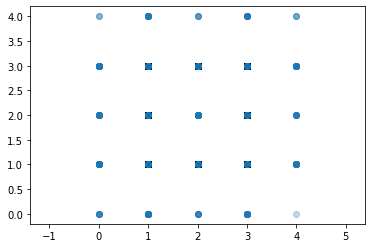

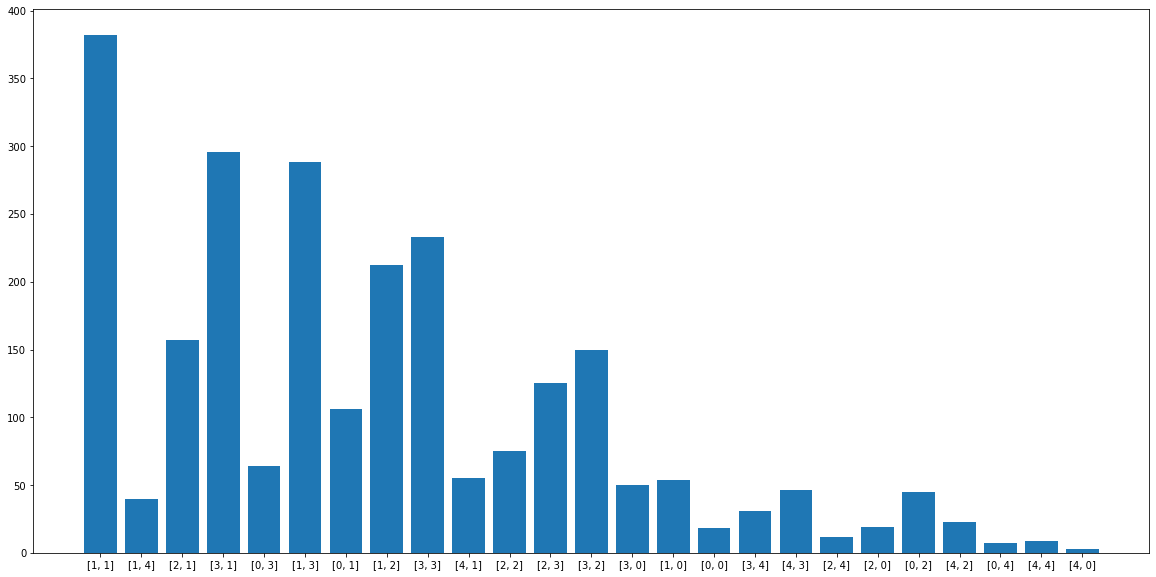

Processing Epoch 85
training start
Iteration 0, d real/fake loss 0.5667918920516968/0.6433984041213989 and g loss is 0.8794081807136536, NDiv loss 0.061934057623147964
Iteration 1, d real/fake loss 0.5672304630279541/0.6577202081680298 and g loss is 0.8586294054985046, NDiv loss 0.05328662320971489
Iteration 2, d real/fake loss 0.5680437684059143/0.6989083886146545 and g loss is 0.9379786252975464, NDiv loss 0.06068800389766693
Iteration 3, d real/fake loss 0.5695184469223022/0.6748096346855164 and g loss is 0.8923952579498291, NDiv loss 0.05411417782306671
Iteration 4, d real/fake loss 0.571219801902771/0.6403836011886597 and g loss is 0.8819330930709839, NDiv loss 0.06405233591794968


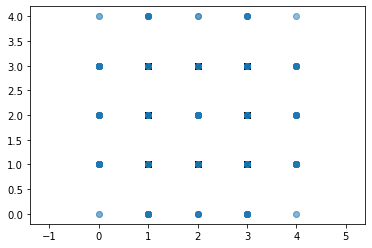

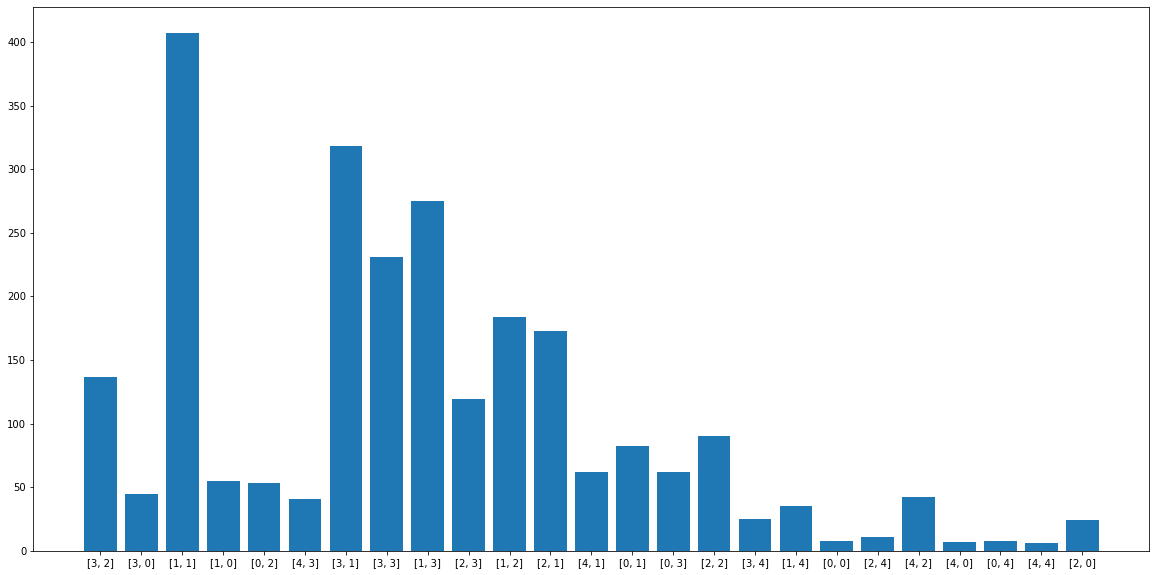

Processing Epoch 86
training start
Iteration 0, d real/fake loss 0.5897448062896729/0.6657373905181885 and g loss is 0.9276925325393677, NDiv loss 0.05656058341264725
Iteration 1, d real/fake loss 0.5907092094421387/0.6669781804084778 and g loss is 0.8519260883331299, NDiv loss 0.0503702275454998
Iteration 2, d real/fake loss 0.5910548567771912/0.6379544734954834 and g loss is 0.9093483686447144, NDiv loss 0.05564961954951286
Iteration 3, d real/fake loss 0.5911864042282104/0.6786878108978271 and g loss is 0.8961420655250549, NDiv loss 0.059905506670475006
Iteration 4, d real/fake loss 0.5912003517150879/0.6487616300582886 and g loss is 0.9473398327827454, NDiv loss 0.05804182216525078


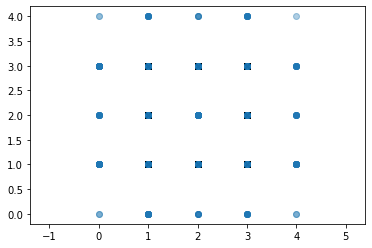

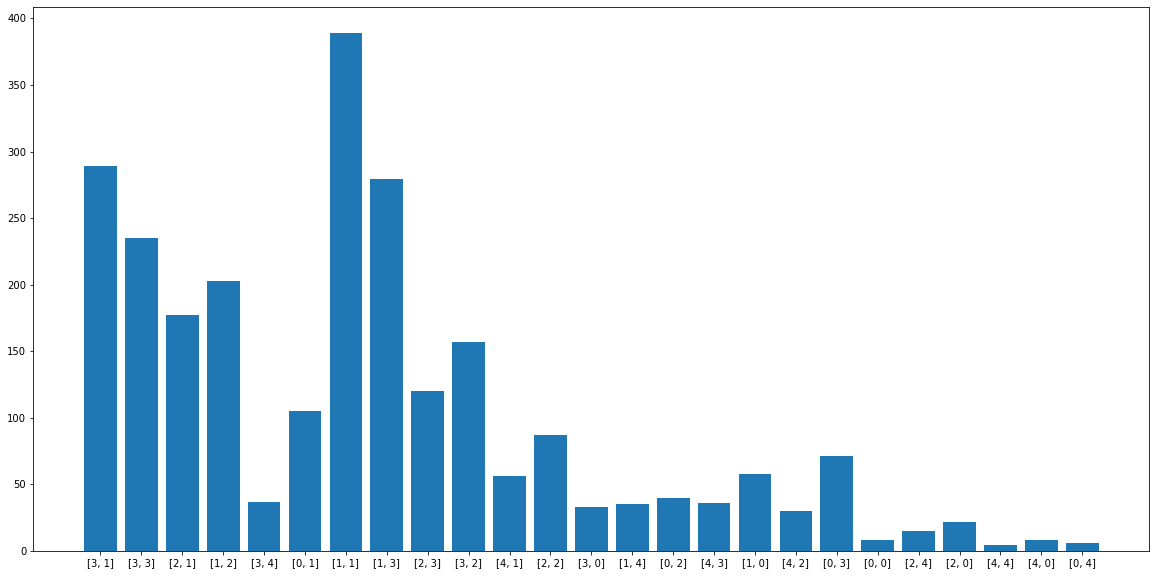

Processing Epoch 87
training start
Iteration 0, d real/fake loss 0.5837658643722534/0.6523703336715698 and g loss is 0.9143167734146118, NDiv loss 0.057032059878110886
Iteration 1, d real/fake loss 0.5839970111846924/0.6182414293289185 and g loss is 0.9210621118545532, NDiv loss 0.05385658144950867
Iteration 2, d real/fake loss 0.5842574238777161/0.6238226890563965 and g loss is 0.8649123311042786, NDiv loss 0.058288395404815674
Iteration 3, d real/fake loss 0.584507405757904/0.6607721447944641 and g loss is 0.9471821784973145, NDiv loss 0.057438138872385025
Iteration 4, d real/fake loss 0.5849207639694214/0.6586428284645081 and g loss is 0.9017617702484131, NDiv loss 0.06831760704517365


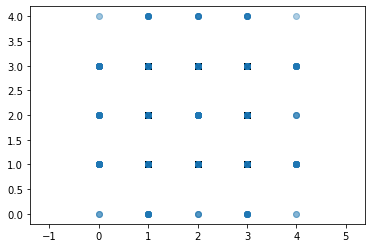

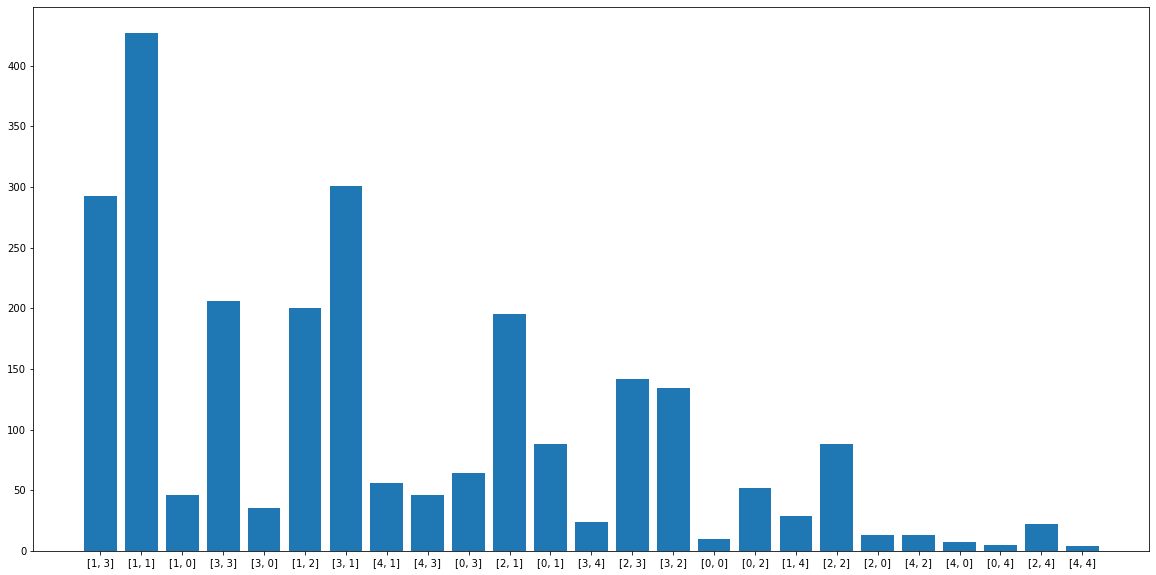

Processing Epoch 88
training start
Iteration 0, d real/fake loss 0.5785648822784424/0.6727596521377563 and g loss is 0.977131724357605, NDiv loss 0.06782522052526474
Iteration 1, d real/fake loss 0.5793777704238892/0.6234549880027771 and g loss is 0.9397417902946472, NDiv loss 0.05413798987865448
Iteration 2, d real/fake loss 0.5800288915634155/0.6526104807853699 and g loss is 0.8315494656562805, NDiv loss 0.06124250963330269
Iteration 3, d real/fake loss 0.5806922912597656/0.6521981954574585 and g loss is 0.9280202388763428, NDiv loss 0.0544695183634758
Iteration 4, d real/fake loss 0.581479549407959/0.6162062883377075 and g loss is 0.9677704572677612, NDiv loss 0.06277506053447723


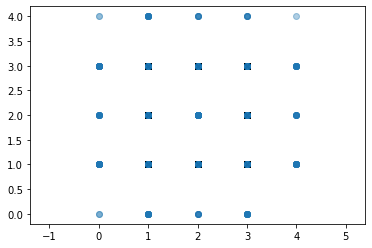

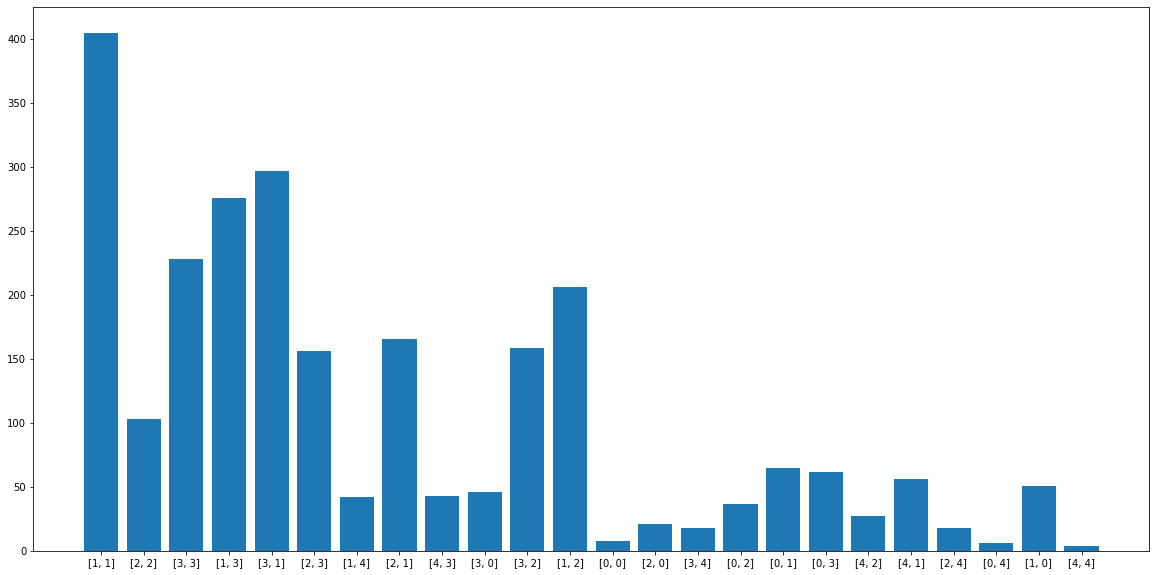

Processing Epoch 89
training start
Iteration 0, d real/fake loss 0.5783981680870056/0.6352077722549438 and g loss is 0.8667618036270142, NDiv loss 0.0650034099817276
Iteration 1, d real/fake loss 0.5789905190467834/0.6700146794319153 and g loss is 0.8817176818847656, NDiv loss 0.04807918518781662
Iteration 2, d real/fake loss 0.5799247622489929/0.675516664981842 and g loss is 0.8446539640426636, NDiv loss 0.05858803167939186
Iteration 3, d real/fake loss 0.5812722444534302/0.6915223002433777 and g loss is 0.9229623079299927, NDiv loss 0.062495842576026917
Iteration 4, d real/fake loss 0.5828877687454224/0.6842030882835388 and g loss is 0.855425238609314, NDiv loss 0.06400638073682785


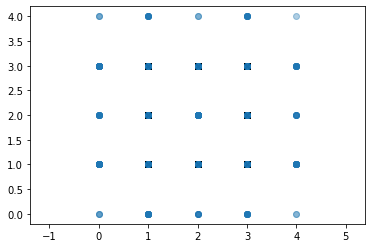

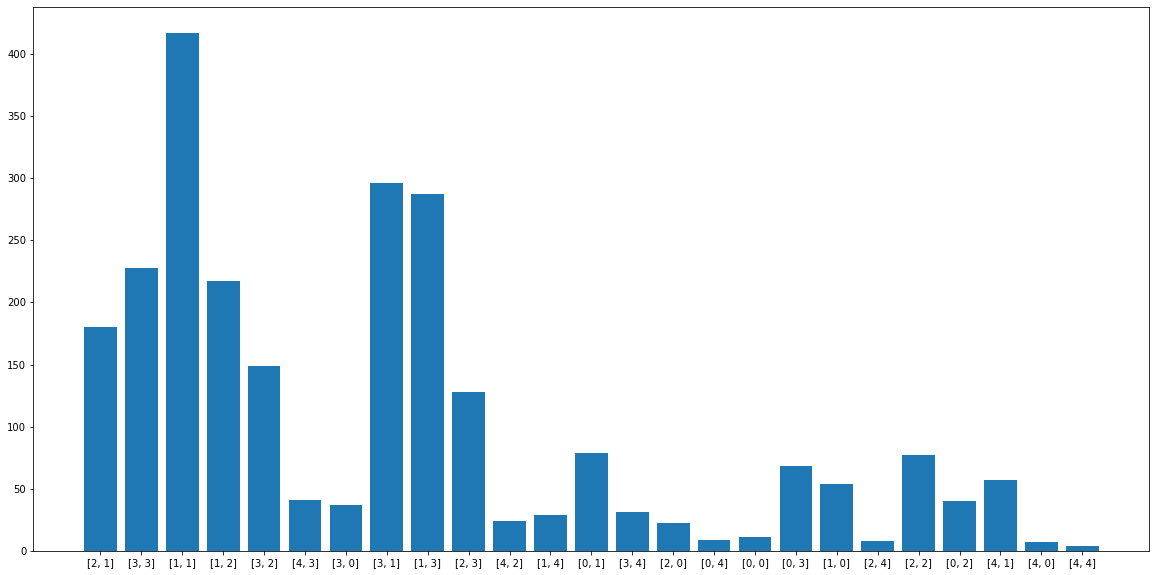

Processing Epoch 90
training start
Iteration 0, d real/fake loss 0.5978908538818359/0.6453754901885986 and g loss is 0.8843128681182861, NDiv loss 0.05834982544183731
Iteration 1, d real/fake loss 0.5989521741867065/0.6643989682197571 and g loss is 0.8942223191261292, NDiv loss 0.05361643433570862
Iteration 2, d real/fake loss 0.5997664928436279/0.6166703701019287 and g loss is 0.9082070589065552, NDiv loss 0.054543379694223404
Iteration 3, d real/fake loss 0.6001183986663818/0.6828889846801758 and g loss is 0.9341514110565186, NDiv loss 0.059859029948711395
Iteration 4, d real/fake loss 0.6002916693687439/0.5900158286094666 and g loss is 0.9090816974639893, NDiv loss 0.05704961344599724


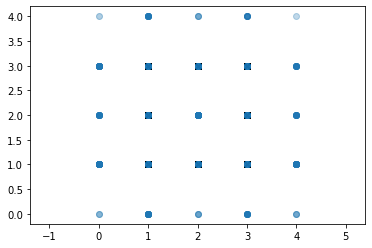

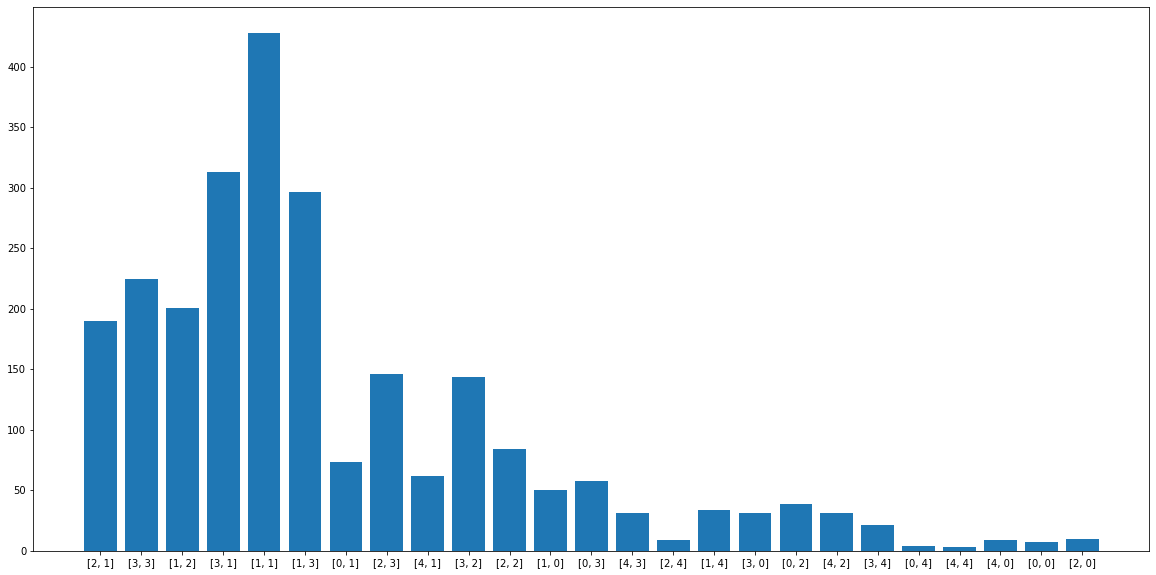

Processing Epoch 91
training start
Iteration 0, d real/fake loss 0.5933050513267517/0.6568493843078613 and g loss is 0.8573763370513916, NDiv loss 0.058123696595430374
Iteration 1, d real/fake loss 0.5930795073509216/0.6177762746810913 and g loss is 0.8614917993545532, NDiv loss 0.0656759962439537
Iteration 2, d real/fake loss 0.5925907492637634/0.6584594249725342 and g loss is 0.9222285747528076, NDiv loss 0.06268782168626785
Iteration 3, d real/fake loss 0.5922213196754456/0.6345865726470947 and g loss is 0.8507698178291321, NDiv loss 0.05882202088832855
Iteration 4, d real/fake loss 0.591673731803894/0.6678638458251953 and g loss is 0.8925769329071045, NDiv loss 0.057689350098371506


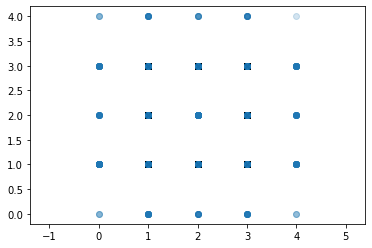

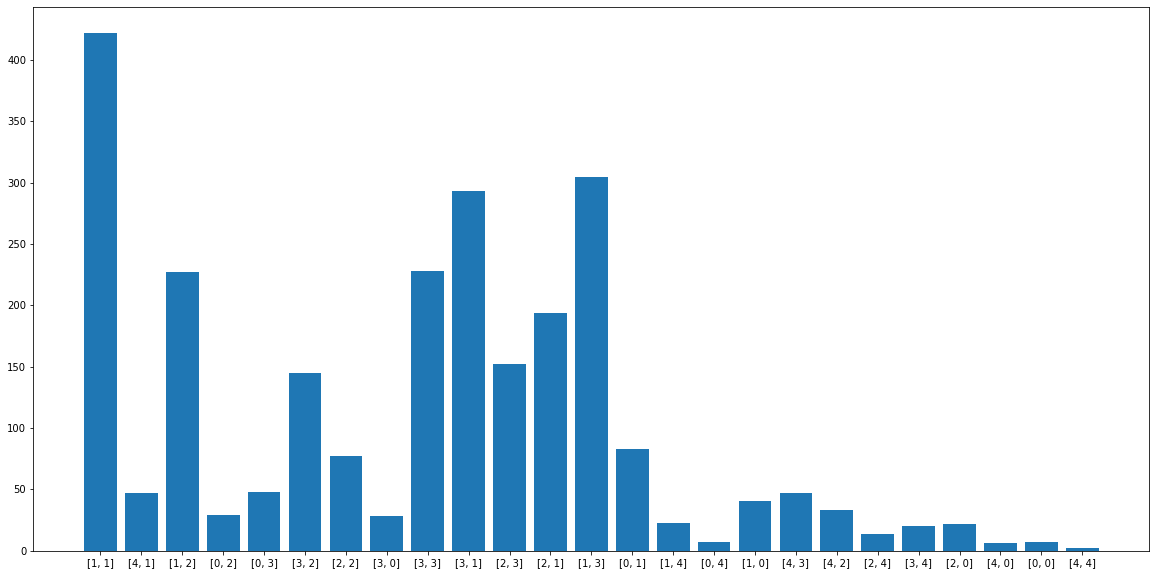

Processing Epoch 92
training start
Iteration 0, d real/fake loss 0.597028374671936/0.6590126752853394 and g loss is 0.8458787798881531, NDiv loss 0.0519476942718029
Iteration 1, d real/fake loss 0.5973519086837769/0.6769385933876038 and g loss is 0.894630491733551, NDiv loss 0.05793201923370361
Iteration 2, d real/fake loss 0.5977357029914856/0.6611006855964661 and g loss is 0.930016279220581, NDiv loss 0.06408437341451645
Iteration 3, d real/fake loss 0.5979952812194824/0.6349188089370728 and g loss is 0.9212065935134888, NDiv loss 0.05834636837244034
Iteration 4, d real/fake loss 0.5981103777885437/0.6204123497009277 and g loss is 0.9211058616638184, NDiv loss 0.05940975248813629


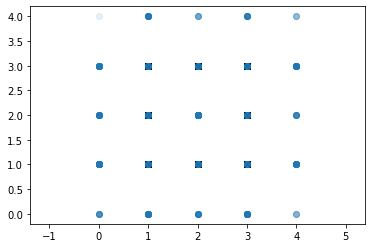

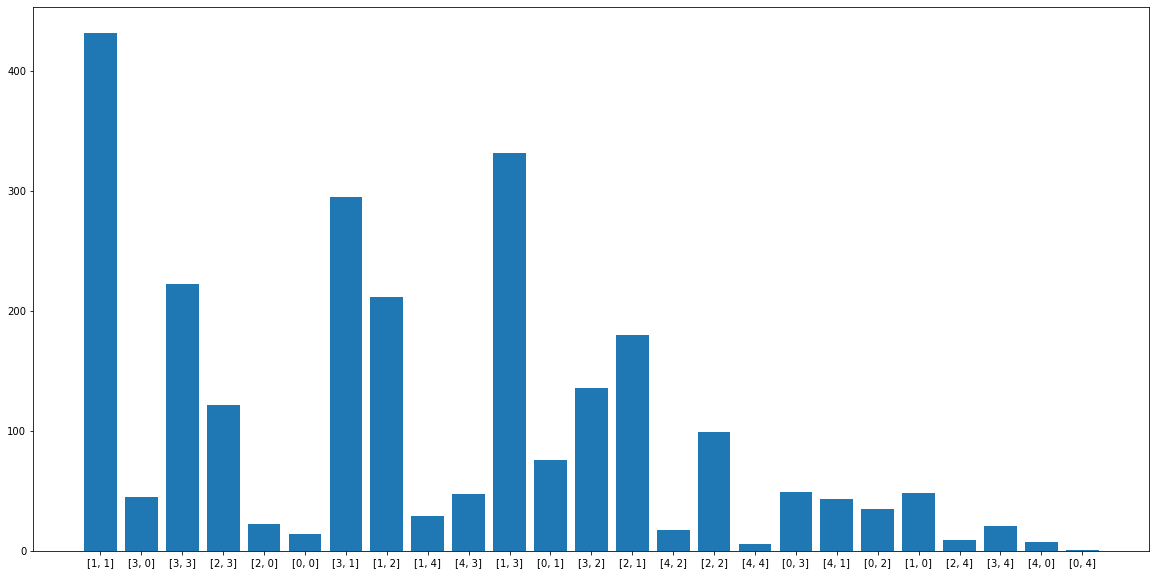

Processing Epoch 93
training start
Iteration 0, d real/fake loss 0.6053591370582581/0.6470952033996582 and g loss is 0.9046181440353394, NDiv loss 0.0538097620010376
Iteration 1, d real/fake loss 0.6048598289489746/0.6353263258934021 and g loss is 0.857308030128479, NDiv loss 0.07179927080869675
Iteration 2, d real/fake loss 0.6044116616249084/0.5753515958786011 and g loss is 0.8154884576797485, NDiv loss 0.06543255597352982
Iteration 3, d real/fake loss 0.6035255193710327/0.6968755125999451 and g loss is 0.9053565263748169, NDiv loss 0.060850247740745544
Iteration 4, d real/fake loss 0.6030033826828003/0.6497105360031128 and g loss is 0.8831729888916016, NDiv loss 0.06639978289604187


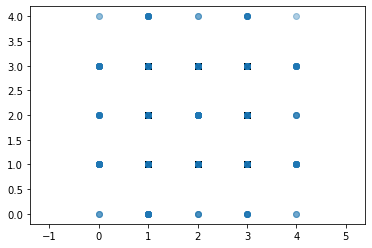

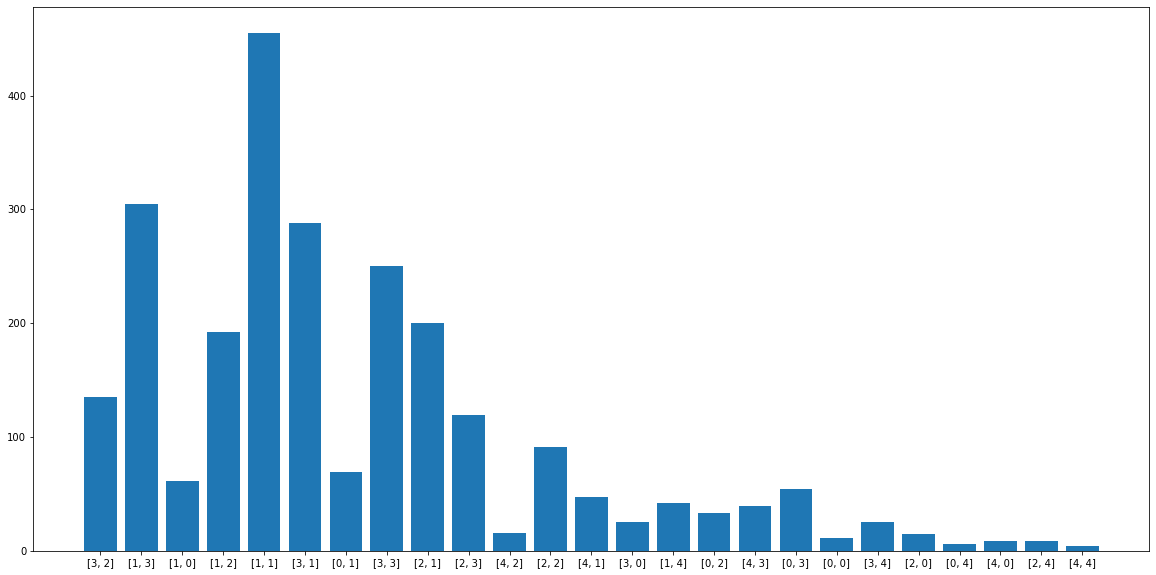

Processing Epoch 94
training start
Iteration 0, d real/fake loss 0.5984062552452087/0.6558800935745239 and g loss is 0.9516116380691528, NDiv loss 0.05299295485019684
Iteration 1, d real/fake loss 0.5983368158340454/0.6737453937530518 and g loss is 0.8755520582199097, NDiv loss 0.05913061276078224
Iteration 2, d real/fake loss 0.5983555316925049/0.6181163191795349 and g loss is 0.7831964492797852, NDiv loss 0.05420142412185669
Iteration 3, d real/fake loss 0.598299503326416/0.6862146258354187 and g loss is 0.9042633771896362, NDiv loss 0.058194972574710846
Iteration 4, d real/fake loss 0.5983296036720276/0.633635938167572 and g loss is 0.9528659582138062, NDiv loss 0.05605965107679367


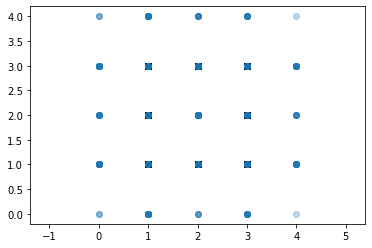

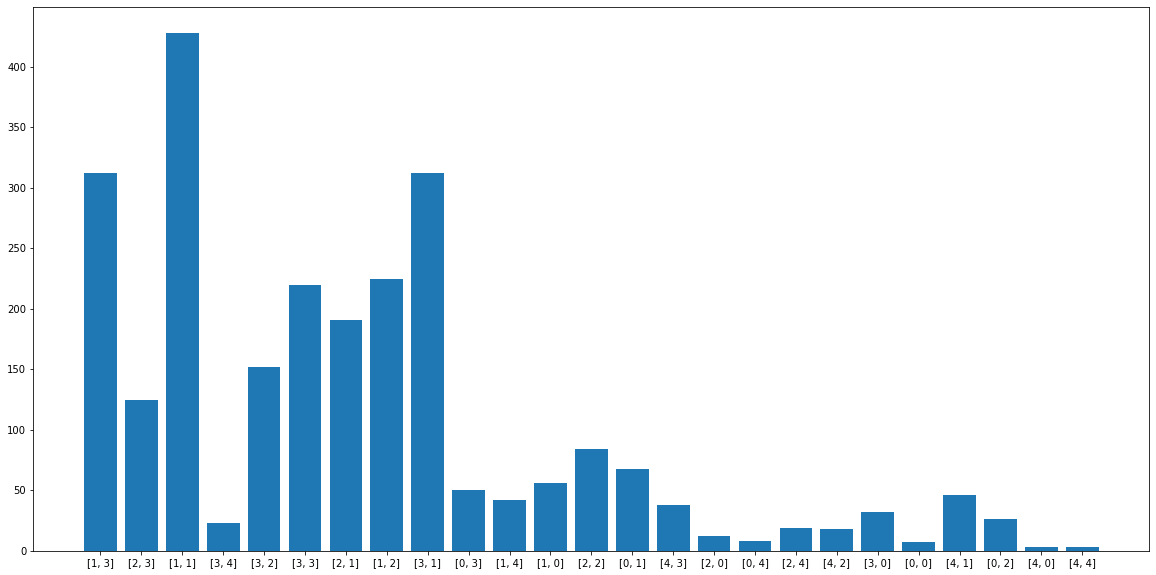

Processing Epoch 95
training start
Iteration 0, d real/fake loss 0.6054164171218872/0.6119740605354309 and g loss is 0.8696163892745972, NDiv loss 0.06262976676225662
Iteration 1, d real/fake loss 0.6055612564086914/0.6662992238998413 and g loss is 0.95319664478302, NDiv loss 0.06204650178551674
Iteration 2, d real/fake loss 0.605538547039032/0.6491754055023193 and g loss is 0.888311505317688, NDiv loss 0.06166855990886688
Iteration 3, d real/fake loss 0.6053114533424377/0.6531400084495544 and g loss is 0.8963195085525513, NDiv loss 0.06375033408403397
Iteration 4, d real/fake loss 0.6051627397537231/0.6453657150268555 and g loss is 0.8923038840293884, NDiv loss 0.06896022707223892


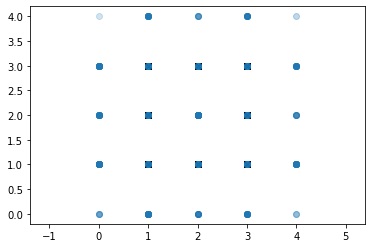

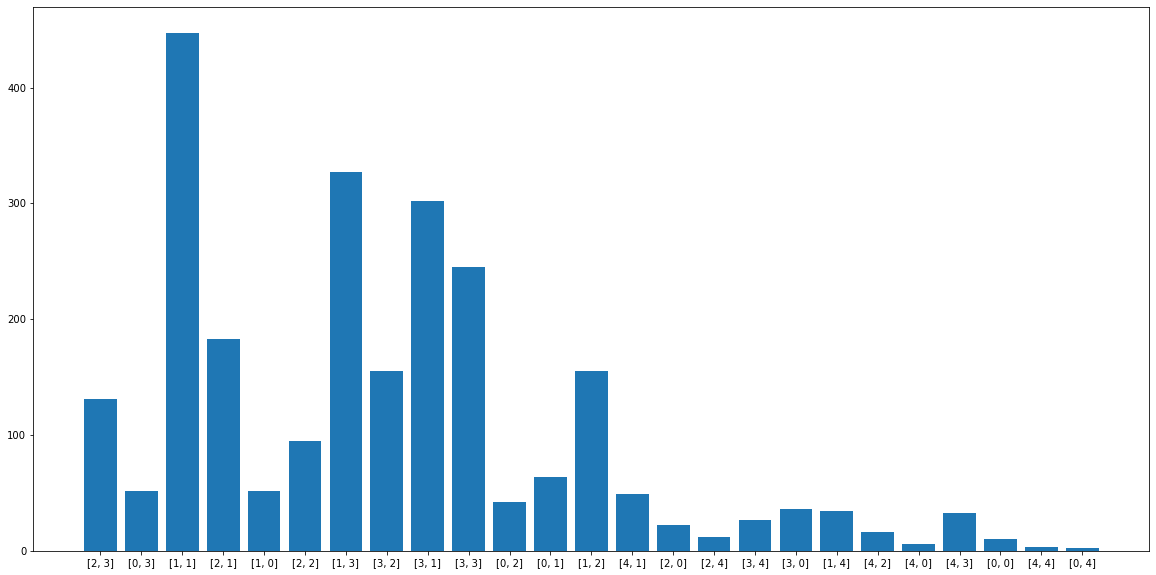

Processing Epoch 96
training start
Iteration 0, d real/fake loss 0.6158477067947388/0.6522002220153809 and g loss is 0.8896582126617432, NDiv loss 0.05841829627752304
Iteration 1, d real/fake loss 0.6154798865318298/0.6519471406936646 and g loss is 0.8401902914047241, NDiv loss 0.05707872286438942
Iteration 2, d real/fake loss 0.614883303642273/0.6166797876358032 and g loss is 0.9232261180877686, NDiv loss 0.05993543937802315
Iteration 3, d real/fake loss 0.6138598322868347/0.6555932760238647 and g loss is 0.8797708749771118, NDiv loss 0.05862487480044365
Iteration 4, d real/fake loss 0.6131194829940796/0.6793769598007202 and g loss is 0.9280961155891418, NDiv loss 0.06641782820224762


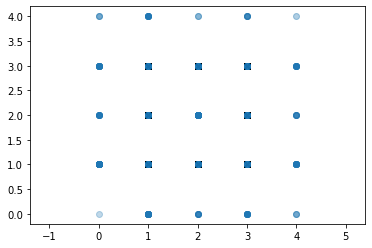

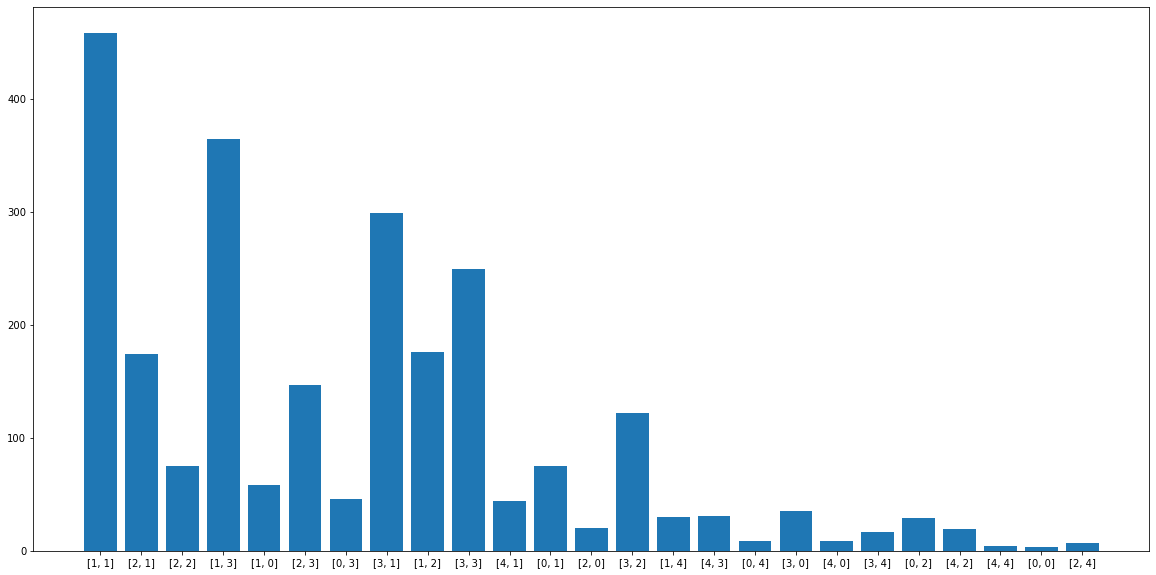

Processing Epoch 97
training start
Iteration 0, d real/fake loss 0.5985472202301025/0.6416065692901611 and g loss is 0.8673635721206665, NDiv loss 0.058279529213905334
Iteration 1, d real/fake loss 0.5983583927154541/0.6405936479568481 and g loss is 0.8528600931167603, NDiv loss 0.06990371644496918
Iteration 2, d real/fake loss 0.59819096326828/0.6187345385551453 and g loss is 0.8251829743385315, NDiv loss 0.06470625847578049
Iteration 3, d real/fake loss 0.5979008674621582/0.6460720896720886 and g loss is 0.8354126214981079, NDiv loss 0.0707455649971962
Iteration 4, d real/fake loss 0.5975927114486694/0.6417312026023865 and g loss is 0.8449826240539551, NDiv loss 0.06062472239136696


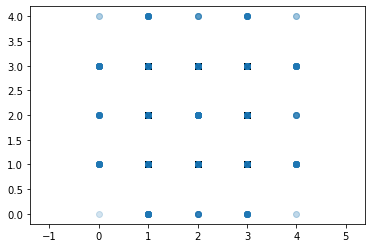

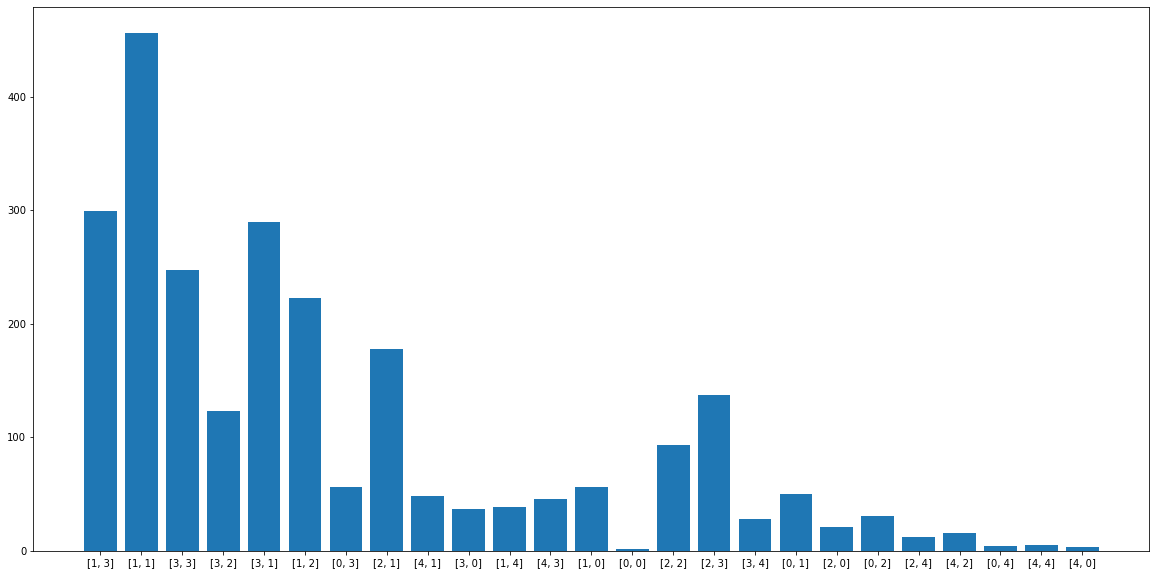

Processing Epoch 98
training start
Iteration 0, d real/fake loss 0.5856630802154541/0.6727794408798218 and g loss is 0.8409754037857056, NDiv loss 0.06991609930992126
Iteration 1, d real/fake loss 0.5860820412635803/0.6554513573646545 and g loss is 0.921684741973877, NDiv loss 0.06692343950271606
Iteration 2, d real/fake loss 0.5865435600280762/0.6000168323516846 and g loss is 0.9083915948867798, NDiv loss 0.058935292065143585
Iteration 3, d real/fake loss 0.586553692817688/0.6484309434890747 and g loss is 0.8732988834381104, NDiv loss 0.056952401995658875
Iteration 4, d real/fake loss 0.5866798162460327/0.6792647838592529 and g loss is 0.9164493083953857, NDiv loss 0.06064244732260704


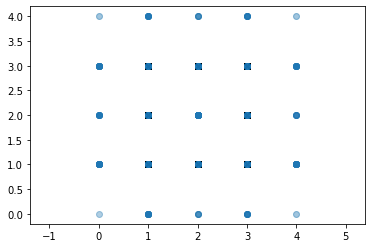

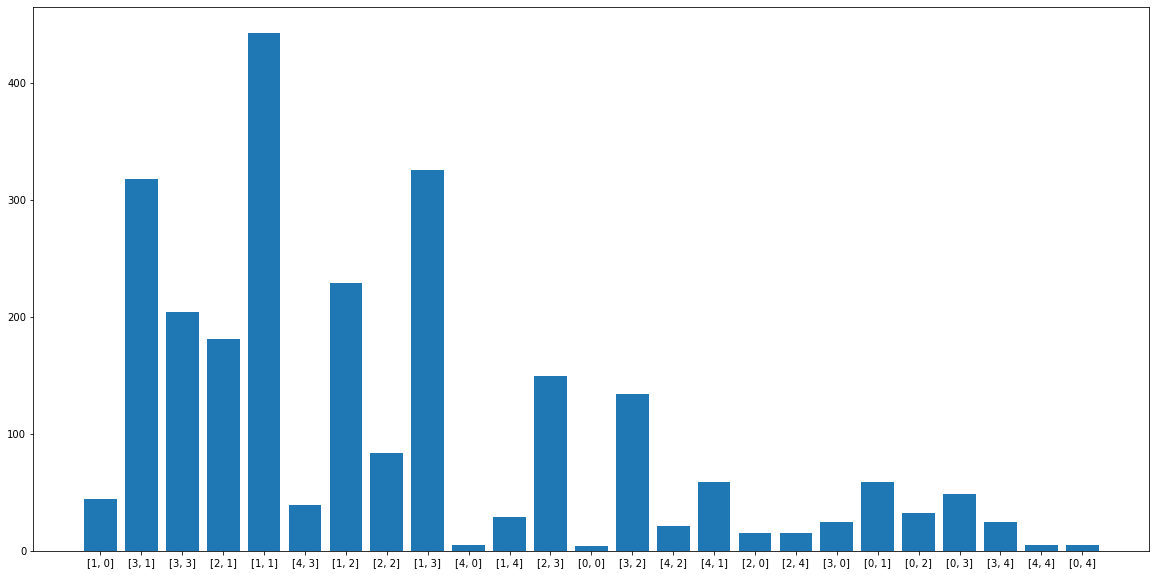

Processing Epoch 99
training start
Iteration 0, d real/fake loss 0.5825043320655823/0.6649621725082397 and g loss is 0.8714182376861572, NDiv loss 0.06642238795757294
Iteration 1, d real/fake loss 0.5834218263626099/0.6251065731048584 and g loss is 0.7983540892601013, NDiv loss 0.0644955113530159
Iteration 2, d real/fake loss 0.5844725370407104/0.6497700810432434 and g loss is 0.9058306217193604, NDiv loss 0.06472624093294144
Iteration 3, d real/fake loss 0.5858412384986877/0.6411698460578918 and g loss is 0.8446199893951416, NDiv loss 0.05600305646657944
Iteration 4, d real/fake loss 0.5872197151184082/0.6186870336532593 and g loss is 0.921981692314148, NDiv loss 0.05632127448916435


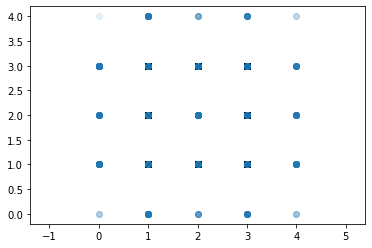

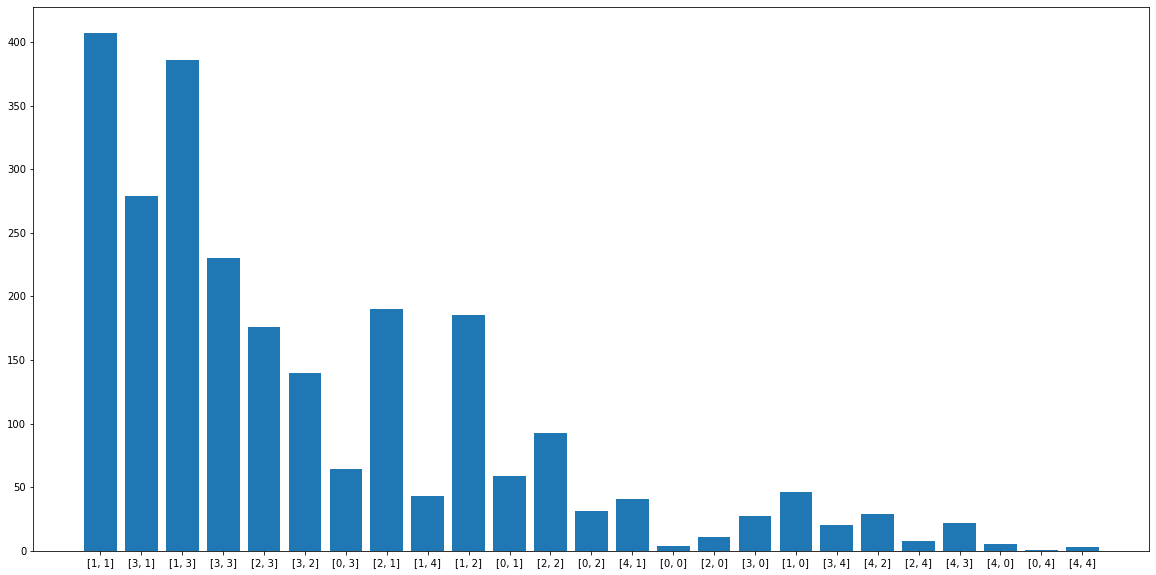

Processing Epoch 100
training start
Iteration 0, d real/fake loss 0.5906363725662231/0.6123043298721313 and g loss is 0.8924879431724548, NDiv loss 0.055810749530792236
Iteration 1, d real/fake loss 0.5911154747009277/0.6377604603767395 and g loss is 0.9122415781021118, NDiv loss 0.06078695133328438
Iteration 2, d real/fake loss 0.5915107727050781/0.6659574508666992 and g loss is 0.9371593594551086, NDiv loss 0.06984235346317291
Iteration 3, d real/fake loss 0.5923663377761841/0.6335809230804443 and g loss is 0.793956458568573, NDiv loss 0.06346528977155685
Iteration 4, d real/fake loss 0.5932459235191345/0.6479571461677551 and g loss is 0.9165144562721252, NDiv loss 0.062378741800785065


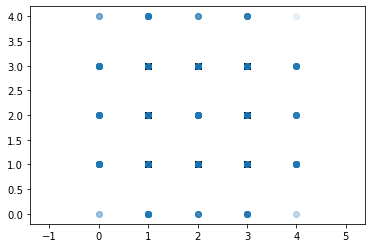

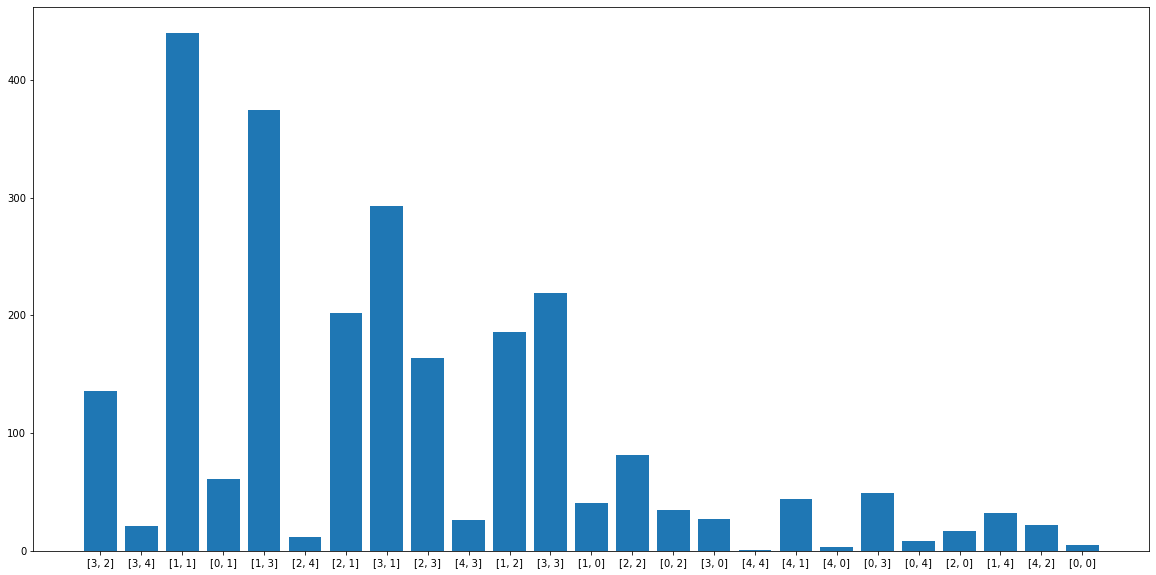

Processing Epoch 101
training start
Iteration 0, d real/fake loss 0.6037367582321167/0.6517422795295715 and g loss is 0.9153188467025757, NDiv loss 0.06462334096431732
Iteration 1, d real/fake loss 0.6044541597366333/0.6183091998100281 and g loss is 0.8547987341880798, NDiv loss 0.06424166262149811
Iteration 2, d real/fake loss 0.604806661605835/0.6717075109481812 and g loss is 0.8767010569572449, NDiv loss 0.06767150014638901
Iteration 3, d real/fake loss 0.6053218245506287/0.6304598450660706 and g loss is 0.8913887739181519, NDiv loss 0.07012012600898743
Iteration 4, d real/fake loss 0.6055130958557129/0.6782789826393127 and g loss is 0.8464365005493164, NDiv loss 0.058798741549253464


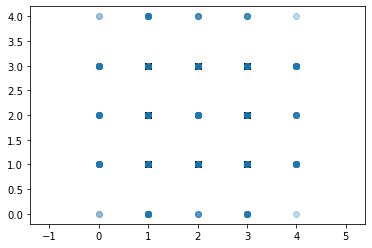

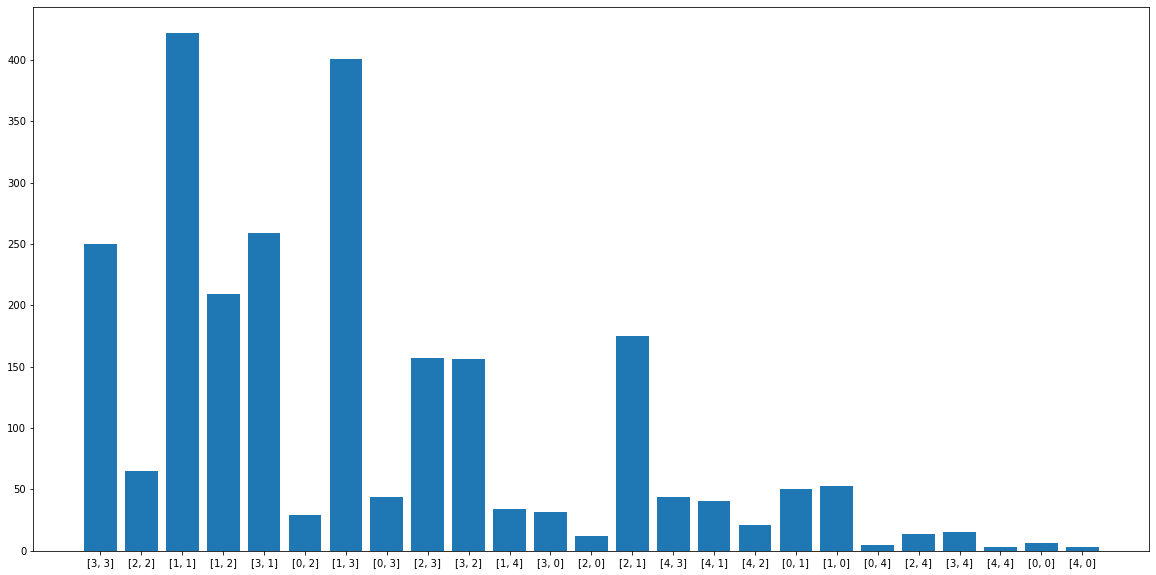

Processing Epoch 102
training start
Iteration 0, d real/fake loss 0.6269312500953674/0.6259315013885498 and g loss is 0.812210202217102, NDiv loss 0.06392104178667068
Iteration 1, d real/fake loss 0.6270622611045837/0.635612964630127 and g loss is 0.8740682601928711, NDiv loss 0.07188515365123749
Iteration 2, d real/fake loss 0.6268223524093628/0.6378450393676758 and g loss is 0.8440859317779541, NDiv loss 0.05738488957285881
Iteration 3, d real/fake loss 0.6260461807250977/0.6463178396224976 and g loss is 0.8299679160118103, NDiv loss 0.06479738652706146
Iteration 4, d real/fake loss 0.6250580549240112/0.6209659576416016 and g loss is 0.846137523651123, NDiv loss 0.06453944742679596


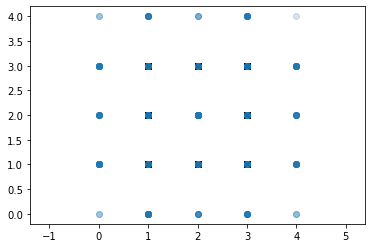

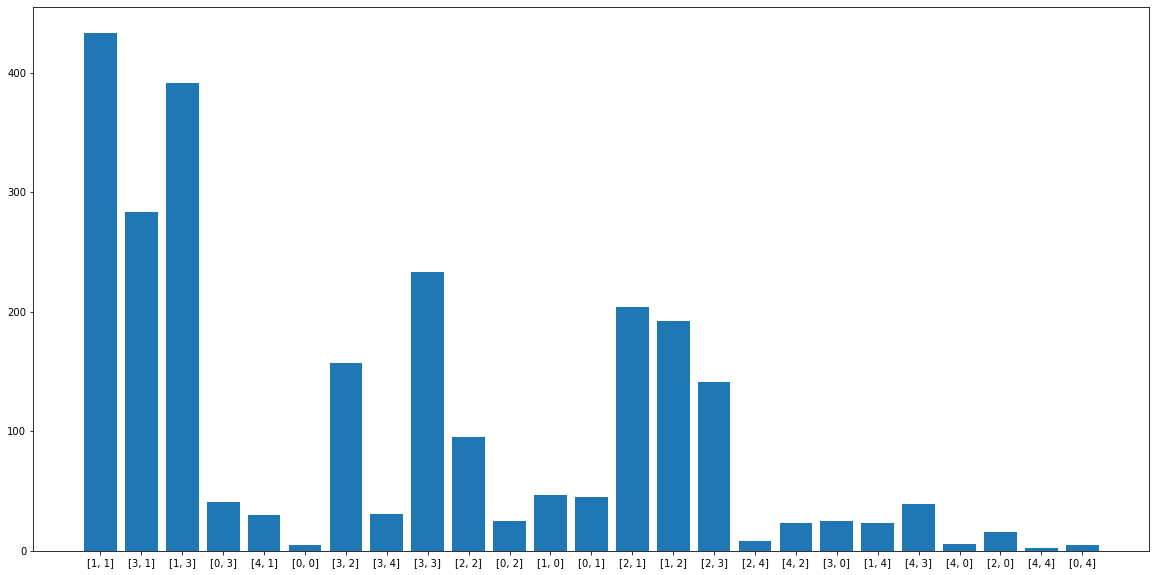

Processing Epoch 103
training start
Iteration 0, d real/fake loss 0.6164487600326538/0.648184597492218 and g loss is 0.8830841779708862, NDiv loss 0.06294550001621246
Iteration 1, d real/fake loss 0.6154425740242004/0.6581867933273315 and g loss is 0.8971047401428223, NDiv loss 0.06683657318353653
Iteration 2, d real/fake loss 0.6146924495697021/0.6660131812095642 and g loss is 0.8769010305404663, NDiv loss 0.06439299881458282
Iteration 3, d real/fake loss 0.6140735149383545/0.6358305215835571 and g loss is 0.8304243683815002, NDiv loss 0.06544167548418045
Iteration 4, d real/fake loss 0.6132992506027222/0.6547753810882568 and g loss is 0.9459455609321594, NDiv loss 0.06517907977104187


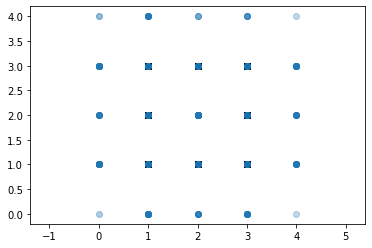

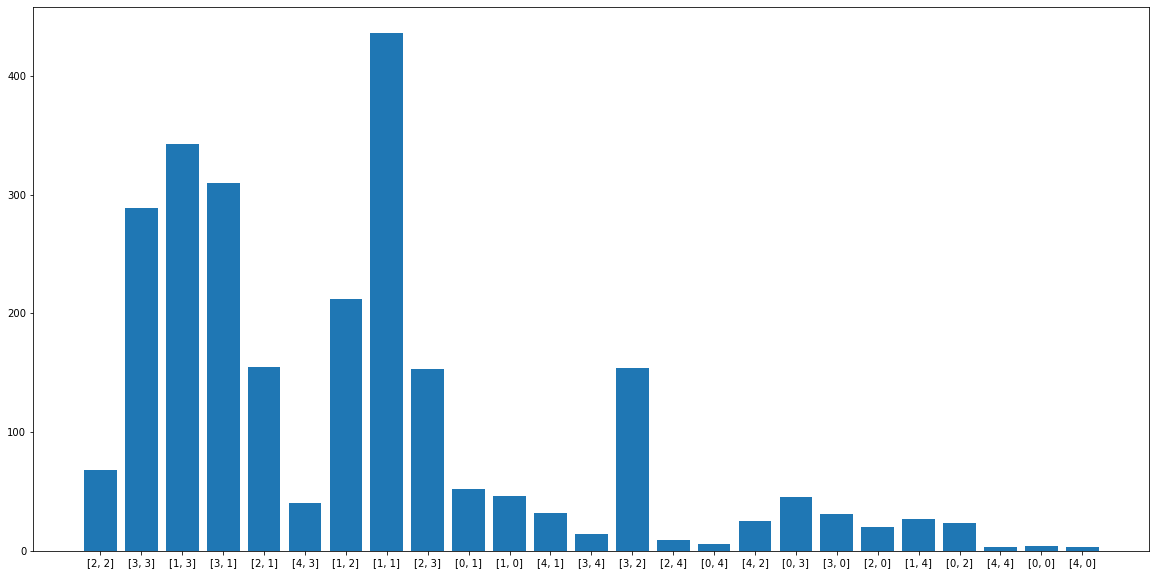

Processing Epoch 104
training start
Iteration 0, d real/fake loss 0.6157324910163879/0.64920973777771 and g loss is 0.9003072381019592, NDiv loss 0.054958149790763855
Iteration 1, d real/fake loss 0.6142997741699219/0.6554961204528809 and g loss is 0.8647074103355408, NDiv loss 0.060267653316259384
Iteration 2, d real/fake loss 0.6128978729248047/0.6661107540130615 and g loss is 0.9009676575660706, NDiv loss 0.08095023036003113
Iteration 3, d real/fake loss 0.6118437051773071/0.6694678068161011 and g loss is 0.8493854999542236, NDiv loss 0.07492026686668396
Iteration 4, d real/fake loss 0.6112396121025085/0.6691713333129883 and g loss is 0.905052900314331, NDiv loss 0.06471690535545349


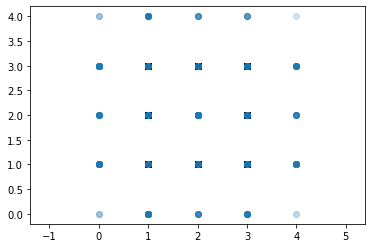

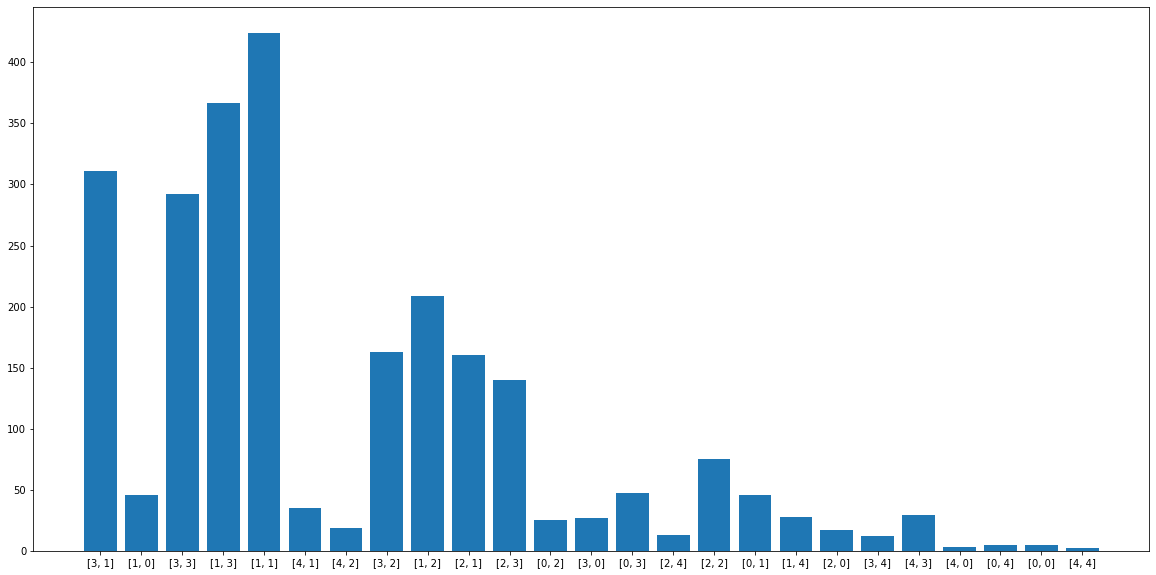

Processing Epoch 105
training start
Iteration 0, d real/fake loss 0.6147156357765198/0.6086054444313049 and g loss is 0.9272822141647339, NDiv loss 0.07315167784690857
Iteration 1, d real/fake loss 0.6151138544082642/0.6752563714981079 and g loss is 0.8276100158691406, NDiv loss 0.06443174183368683
Iteration 2, d real/fake loss 0.6152219772338867/0.6227407455444336 and g loss is 0.9090590476989746, NDiv loss 0.061742473393678665
Iteration 3, d real/fake loss 0.6148880124092102/0.6748441457748413 and g loss is 0.8120044469833374, NDiv loss 0.0611194483935833
Iteration 4, d real/fake loss 0.6148546934127808/0.6632839441299438 and g loss is 0.8092103004455566, NDiv loss 0.07604680955410004


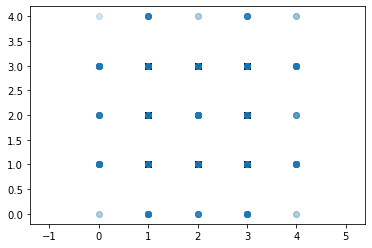

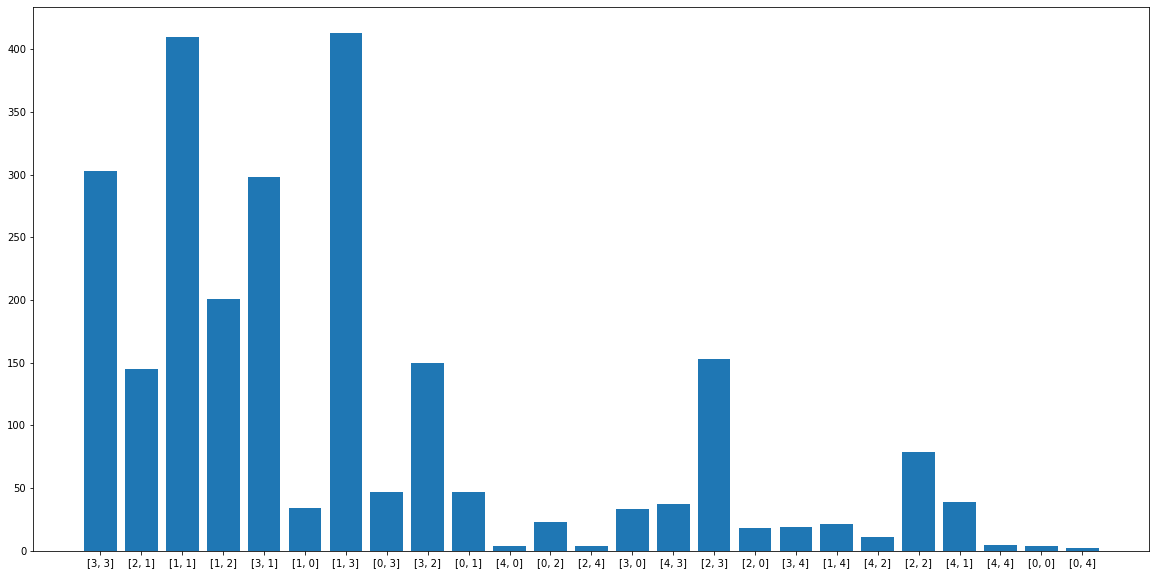

Processing Epoch 106
training start
Iteration 0, d real/fake loss 0.6076138019561768/0.6887602806091309 and g loss is 0.8332275152206421, NDiv loss 0.06585659831762314
Iteration 1, d real/fake loss 0.6082525253295898/0.7015596032142639 and g loss is 0.8959924578666687, NDiv loss 0.06748668849468231
Iteration 2, d real/fake loss 0.6094576716423035/0.668920636177063 and g loss is 0.9801641702651978, NDiv loss 0.06879806518554688
Iteration 3, d real/fake loss 0.6106399297714233/0.6774339079856873 and g loss is 0.8347376585006714, NDiv loss 0.05912531539797783
Iteration 4, d real/fake loss 0.6117134094238281/0.6656415462493896 and g loss is 0.7795789241790771, NDiv loss 0.0616048239171505


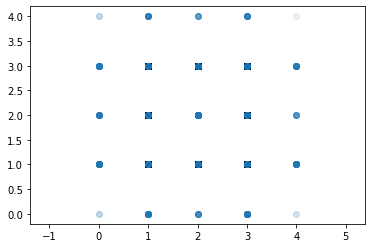

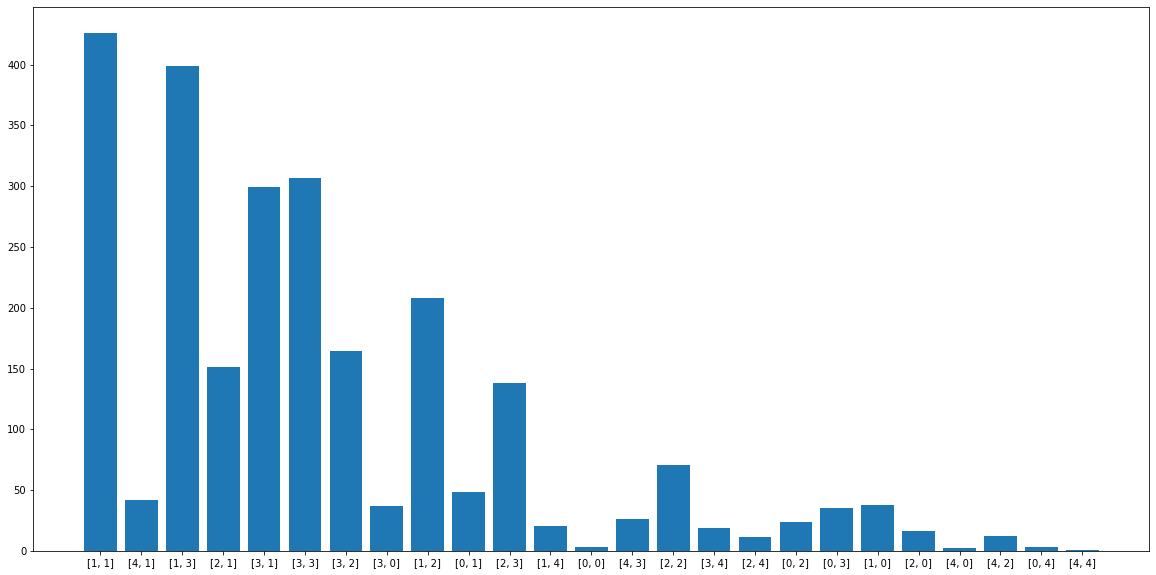

Processing Epoch 107
training start
Iteration 0, d real/fake loss 0.6266219615936279/0.6272597312927246 and g loss is 0.8480061292648315, NDiv loss 0.07213670015335083
Iteration 1, d real/fake loss 0.6265889406204224/0.6582909226417542 and g loss is 0.8163876533508301, NDiv loss 0.0651465356349945
Iteration 2, d real/fake loss 0.6262608170509338/0.6499418020248413 and g loss is 0.8042195439338684, NDiv loss 0.06948082894086838
Iteration 3, d real/fake loss 0.6256163120269775/0.6748207211494446 and g loss is 0.8817821145057678, NDiv loss 0.061894144862890244
Iteration 4, d real/fake loss 0.6248563528060913/0.6556987762451172 and g loss is 0.8042510747909546, NDiv loss 0.06649577617645264


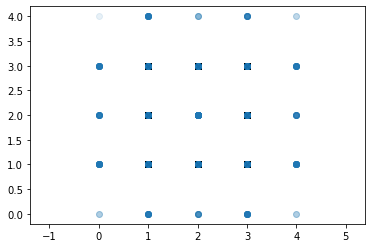

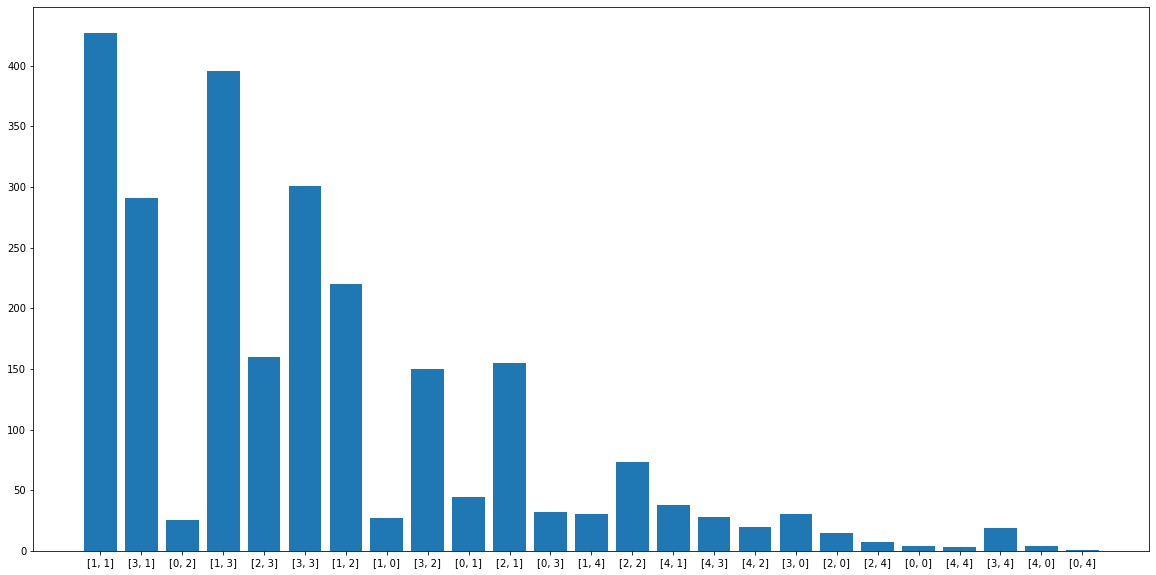

Processing Epoch 108
training start
Iteration 0, d real/fake loss 0.6173021793365479/0.6830472946166992 and g loss is 0.8726465702056885, NDiv loss 0.07025377452373505
Iteration 1, d real/fake loss 0.6172233819961548/0.629353404045105 and g loss is 0.8817881941795349, NDiv loss 0.06939293444156647
Iteration 2, d real/fake loss 0.6167950630187988/0.6733165979385376 and g loss is 0.9123439788818359, NDiv loss 0.071336530148983
Iteration 3, d real/fake loss 0.616483211517334/0.6461772918701172 and g loss is 0.8152206540107727, NDiv loss 0.06206190586090088
Iteration 4, d real/fake loss 0.6162163019180298/0.6497653722763062 and g loss is 0.9378408193588257, NDiv loss 0.06421001255512238


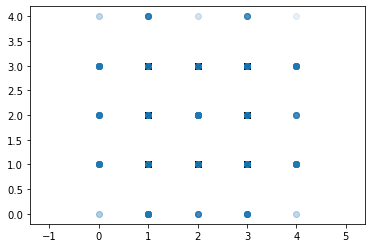

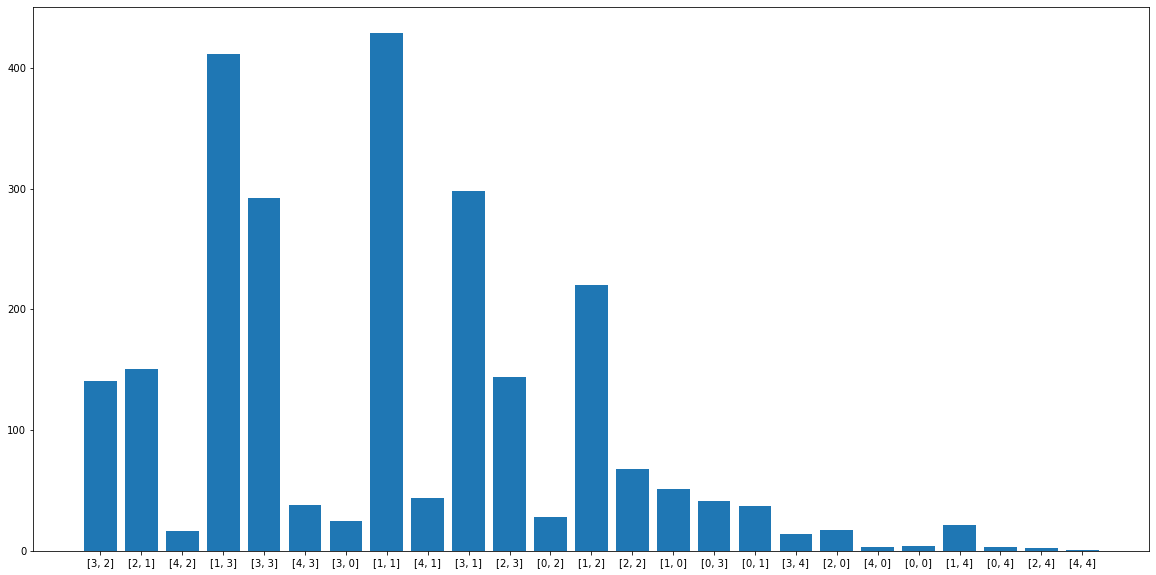

Processing Epoch 109
training start
Iteration 0, d real/fake loss 0.6058019399642944/0.660887598991394 and g loss is 0.8714708089828491, NDiv loss 0.05822194367647171
Iteration 1, d real/fake loss 0.606069803237915/0.6877800226211548 and g loss is 0.8566151857376099, NDiv loss 0.07131685316562653
Iteration 2, d real/fake loss 0.6069517731666565/0.6643085479736328 and g loss is 0.8417938947677612, NDiv loss 0.06620850414037704
Iteration 3, d real/fake loss 0.6077609062194824/0.6788613796234131 and g loss is 0.875913143157959, NDiv loss 0.0674104243516922
Iteration 4, d real/fake loss 0.6087713837623596/0.6537430882453918 and g loss is 0.7984699606895447, NDiv loss 0.06427863240242004


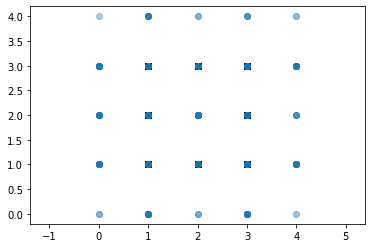

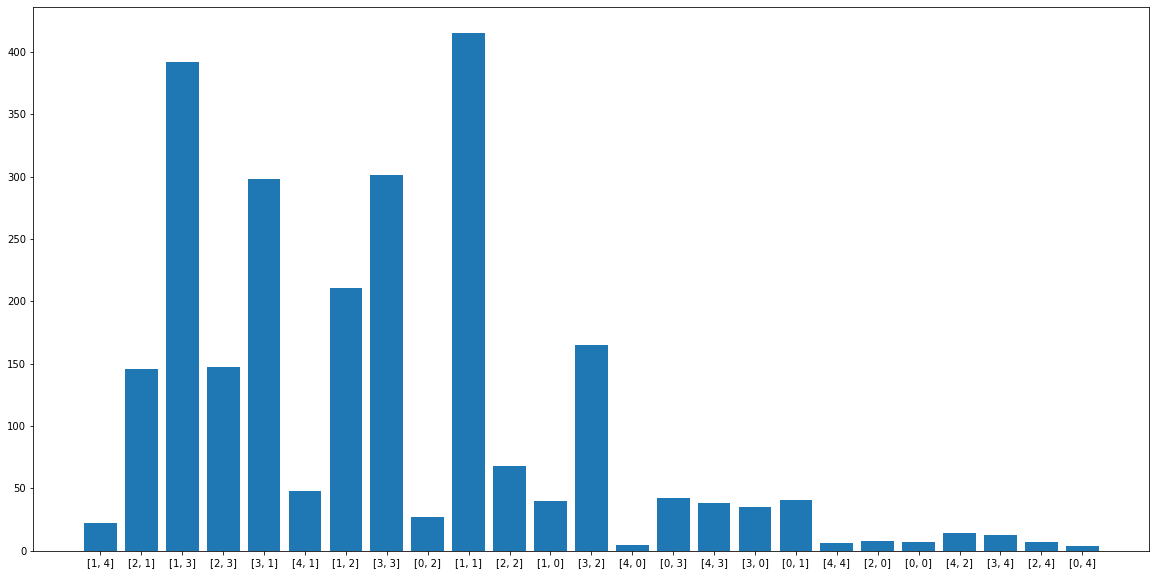

Processing Epoch 110
training start
Iteration 0, d real/fake loss 0.6290563344955444/0.6703146696090698 and g loss is 0.8484585285186768, NDiv loss 0.0604531429708004
Iteration 1, d real/fake loss 0.6291772127151489/0.6647737622261047 and g loss is 0.9119104743003845, NDiv loss 0.07704721391201019
Iteration 2, d real/fake loss 0.6288219690322876/0.6736746430397034 and g loss is 0.8746907711029053, NDiv loss 0.06697005778551102
Iteration 3, d real/fake loss 0.6283007860183716/0.6570627689361572 and g loss is 0.8005335330963135, NDiv loss 0.06669814884662628
Iteration 4, d real/fake loss 0.627597987651825/0.6261780858039856 and g loss is 0.90196293592453, NDiv loss 0.07099972665309906


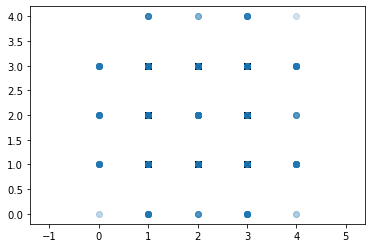

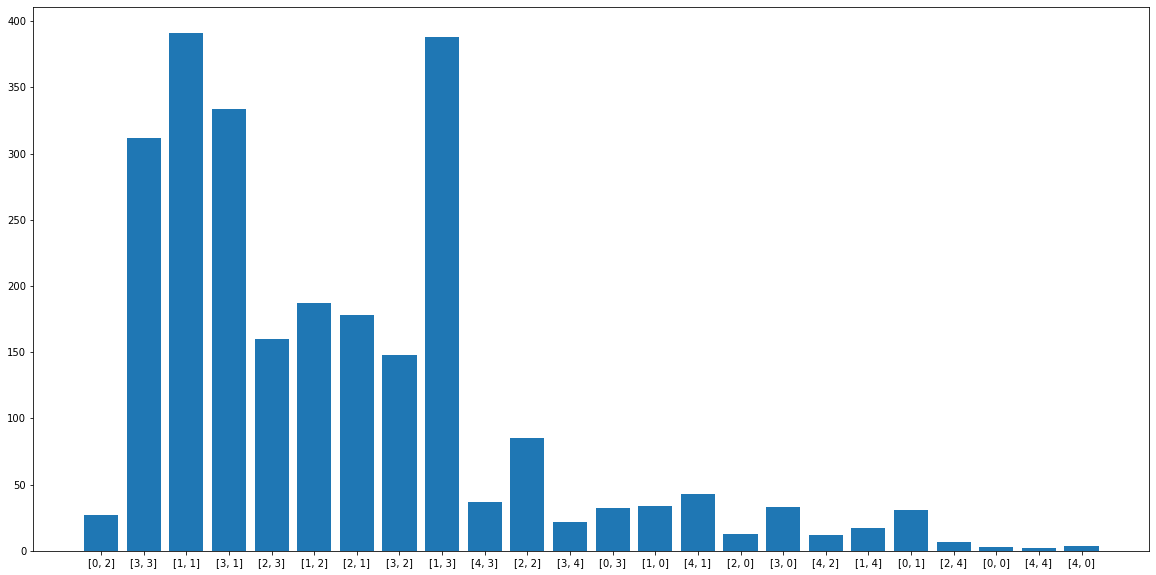

Processing Epoch 111
training start
Iteration 0, d real/fake loss 0.6080764532089233/0.6592012047767639 and g loss is 0.9211204648017883, NDiv loss 0.05673421546816826
Iteration 1, d real/fake loss 0.6080923676490784/0.668450117111206 and g loss is 0.9890252351760864, NDiv loss 0.058525606989860535
Iteration 2, d real/fake loss 0.6086158752441406/0.65404212474823 and g loss is 0.9008008241653442, NDiv loss 0.06460639089345932
Iteration 3, d real/fake loss 0.6093710660934448/0.6657596230506897 and g loss is 0.8432872295379639, NDiv loss 0.07042106986045837
Iteration 4, d real/fake loss 0.610140323638916/0.6817269325256348 and g loss is 0.8867276906967163, NDiv loss 0.06481511890888214


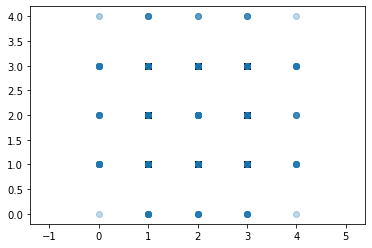

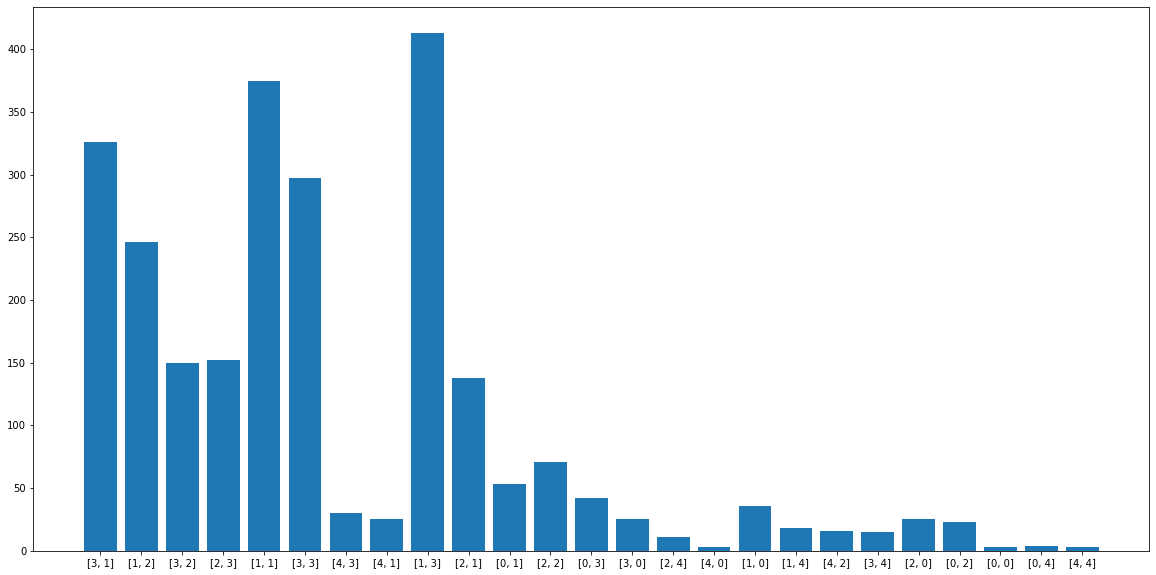

Processing Epoch 112
training start
Iteration 0, d real/fake loss 0.6514248847961426/0.6570267677307129 and g loss is 0.8986552357673645, NDiv loss 0.06572863459587097
Iteration 1, d real/fake loss 0.6514098644256592/0.672527551651001 and g loss is 0.8583873510360718, NDiv loss 0.06062529236078262
Iteration 2, d real/fake loss 0.650632381439209/0.6564707159996033 and g loss is 0.7794733047485352, NDiv loss 0.05630321055650711
Iteration 3, d real/fake loss 0.6494576930999756/0.6774572134017944 and g loss is 0.995873749256134, NDiv loss 0.07095476984977722
Iteration 4, d real/fake loss 0.6477607488632202/0.6480717658996582 and g loss is 0.9094033241271973, NDiv loss 0.0691804438829422


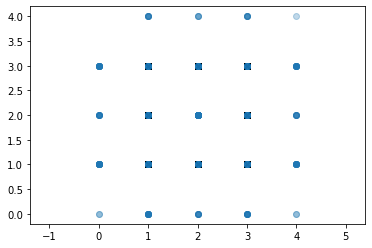

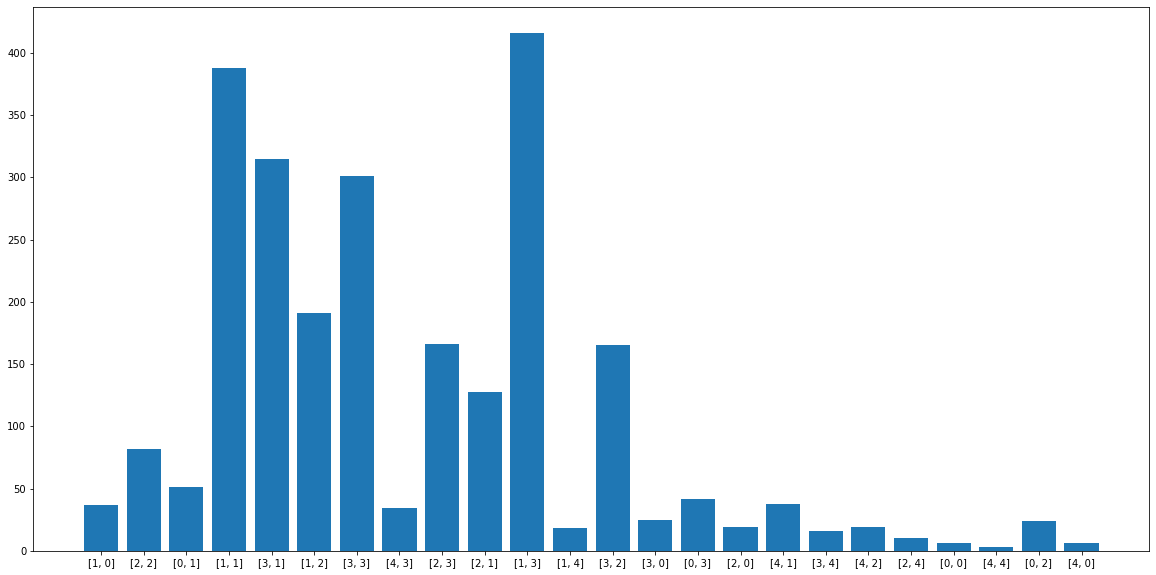

Processing Epoch 113
training start
Iteration 0, d real/fake loss 0.6135796308517456/0.6663577556610107 and g loss is 0.8087674975395203, NDiv loss 0.06556573510169983
Iteration 1, d real/fake loss 0.6126976609230042/0.628690779209137 and g loss is 0.8720558285713196, NDiv loss 0.06679196655750275
Iteration 2, d real/fake loss 0.6121834516525269/0.6615586280822754 and g loss is 0.8690401315689087, NDiv loss 0.06628691405057907
Iteration 3, d real/fake loss 0.6120385527610779/0.6377000212669373 and g loss is 0.7884081602096558, NDiv loss 0.06038709729909897
Iteration 4, d real/fake loss 0.6120176315307617/0.6889913082122803 and g loss is 0.8127442002296448, NDiv loss 0.06709255278110504


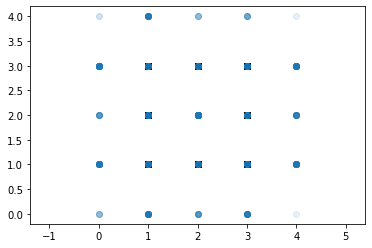

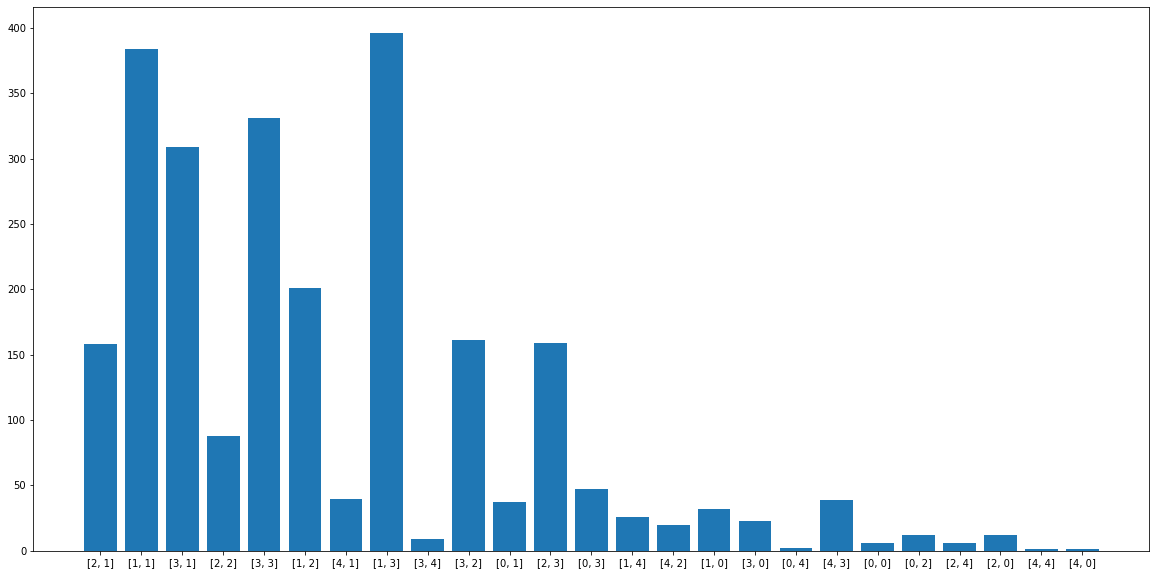

Processing Epoch 114
training start
Iteration 0, d real/fake loss 0.6114157438278198/0.6607645750045776 and g loss is 0.8912166357040405, NDiv loss 0.07024537771940231
Iteration 1, d real/fake loss 0.6118896007537842/0.6737388372421265 and g loss is 0.825151264667511, NDiv loss 0.05996256321668625
Iteration 2, d real/fake loss 0.6127572655677795/0.6571748852729797 and g loss is 0.9288821220397949, NDiv loss 0.06378711014986038
Iteration 3, d real/fake loss 0.613939106464386/0.6439098119735718 and g loss is 0.8757733702659607, NDiv loss 0.060706254094839096
Iteration 4, d real/fake loss 0.6147904396057129/0.6560872793197632 and g loss is 0.9173640012741089, NDiv loss 0.06337621062994003


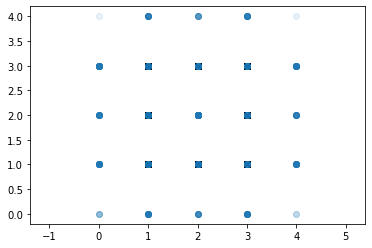

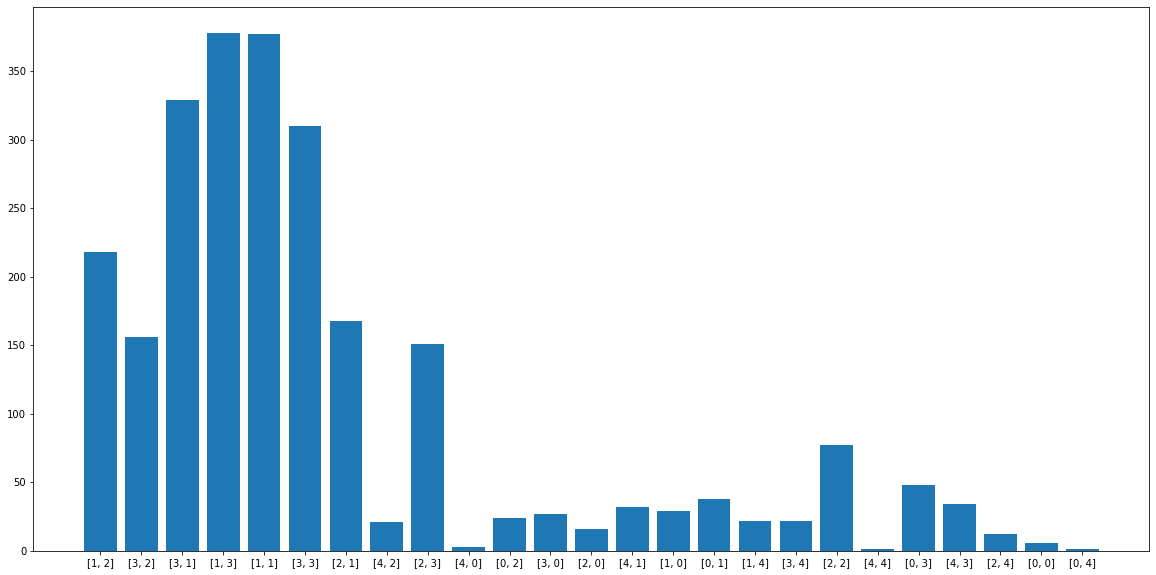

Processing Epoch 115
training start
Iteration 0, d real/fake loss 0.6285075545310974/0.6716324090957642 and g loss is 0.9602417945861816, NDiv loss 0.07805648446083069
Iteration 1, d real/fake loss 0.6291017532348633/0.642338752746582 and g loss is 0.8166696429252625, NDiv loss 0.06645630300045013
Iteration 2, d real/fake loss 0.6293061971664429/0.6552807092666626 and g loss is 0.8689040541648865, NDiv loss 0.05996951833367348
Iteration 3, d real/fake loss 0.6293942928314209/0.696410059928894 and g loss is 0.8484459519386292, NDiv loss 0.06310505419969559
Iteration 4, d real/fake loss 0.629642128944397/0.6235191226005554 and g loss is 0.8497041463851929, NDiv loss 0.08097553253173828


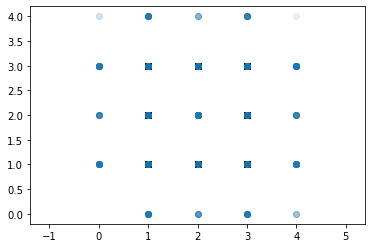

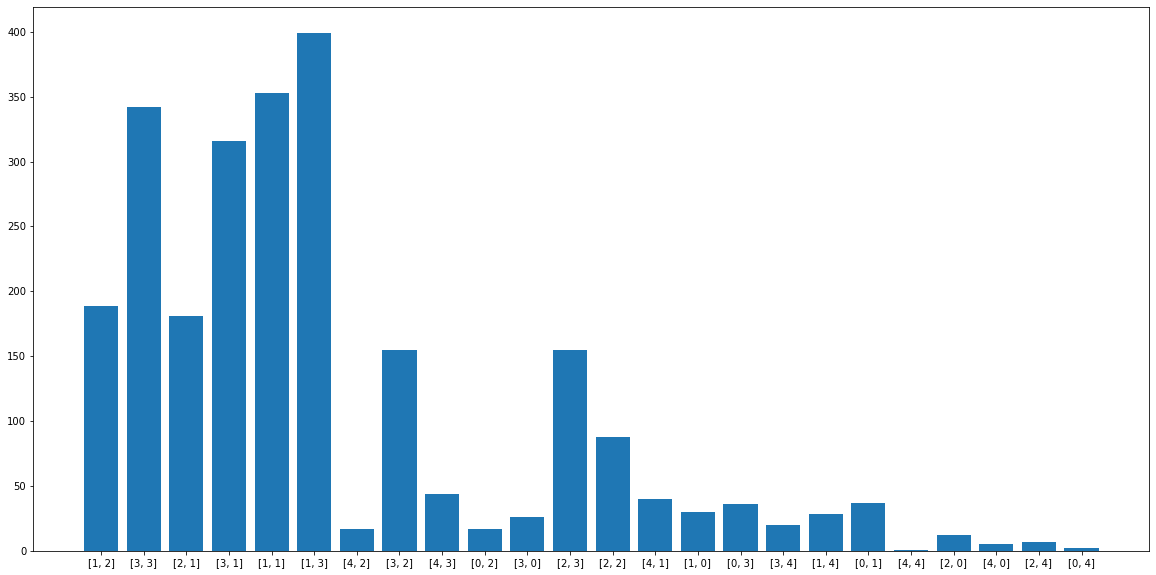

Processing Epoch 116
training start
Iteration 0, d real/fake loss 0.6007281541824341/0.6921553611755371 and g loss is 0.8959185481071472, NDiv loss 0.06445939838886261
Iteration 1, d real/fake loss 0.6011798977851868/0.6461806297302246 and g loss is 0.878689169883728, NDiv loss 0.0611066073179245
Iteration 2, d real/fake loss 0.6013393998146057/0.6522208452224731 and g loss is 0.8695482015609741, NDiv loss 0.08200784772634506
Iteration 3, d real/fake loss 0.6014425158500671/0.6800689697265625 and g loss is 0.8472450971603394, NDiv loss 0.05994585156440735
Iteration 4, d real/fake loss 0.6020480394363403/0.677924394607544 and g loss is 0.8698364496231079, NDiv loss 0.06340103596448898


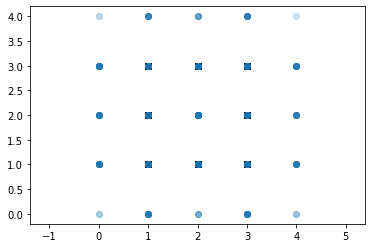

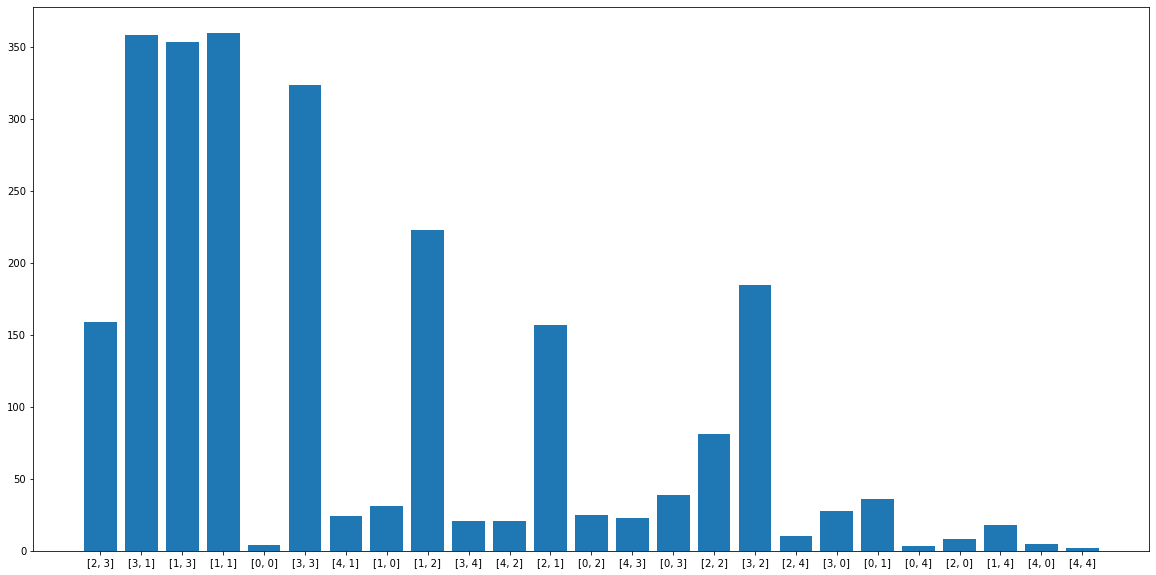

Processing Epoch 117
training start
Iteration 0, d real/fake loss 0.5937522649765015/0.6572597026824951 and g loss is 0.8864865899085999, NDiv loss 0.06646497547626495
Iteration 1, d real/fake loss 0.5946856141090393/0.6127227544784546 and g loss is 0.9714301824569702, NDiv loss 0.06614911556243896
Iteration 2, d real/fake loss 0.5953419208526611/0.6289169192314148 and g loss is 0.8565140962600708, NDiv loss 0.07058034837245941
Iteration 3, d real/fake loss 0.5960061550140381/0.6666558384895325 and g loss is 0.8306130170822144, NDiv loss 0.06283523887395859
Iteration 4, d real/fake loss 0.597011923789978/0.6744449734687805 and g loss is 0.8897584676742554, NDiv loss 0.0644819512963295


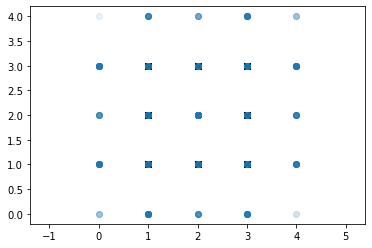

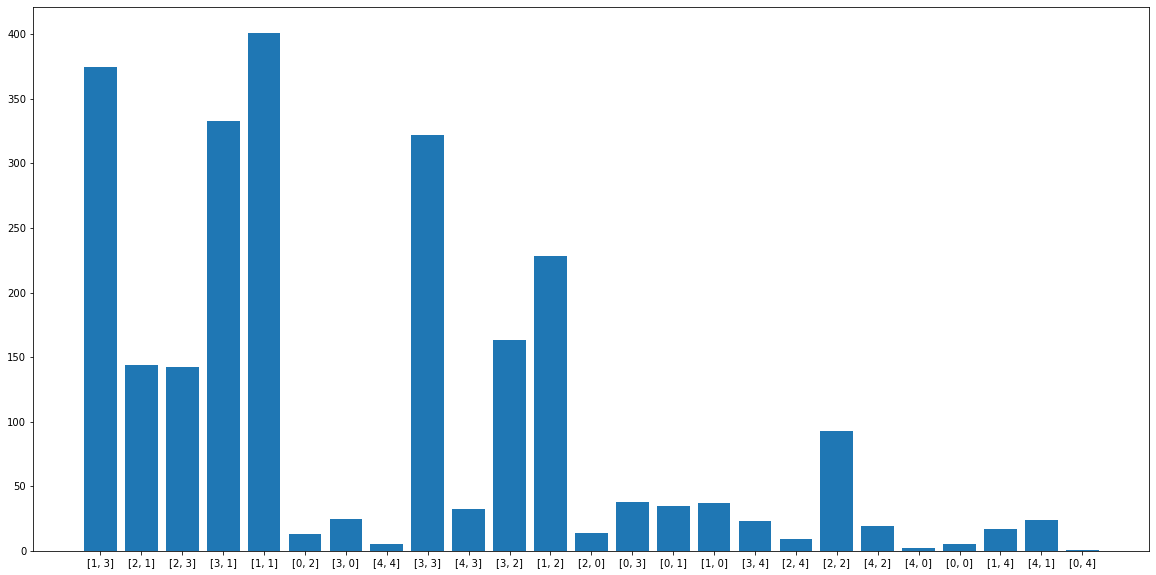

Processing Epoch 118
training start
Iteration 0, d real/fake loss 0.6264024972915649/0.6110547184944153 and g loss is 0.8741990923881531, NDiv loss 0.0646631047129631
Iteration 1, d real/fake loss 0.6272361278533936/0.6373065114021301 and g loss is 0.929486870765686, NDiv loss 0.06266354769468307
Iteration 2, d real/fake loss 0.6274627447128296/0.6349402666091919 and g loss is 0.8609000444412231, NDiv loss 0.06178576126694679
Iteration 3, d real/fake loss 0.6269251704216003/0.6506596803665161 and g loss is 0.8396269083023071, NDiv loss 0.06761235743761063
Iteration 4, d real/fake loss 0.6260725855827332/0.655857503414154 and g loss is 0.8875265121459961, NDiv loss 0.07298870384693146


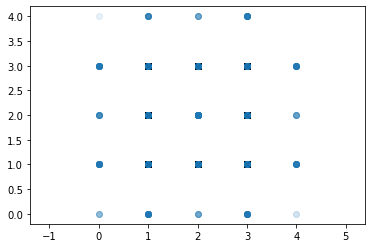

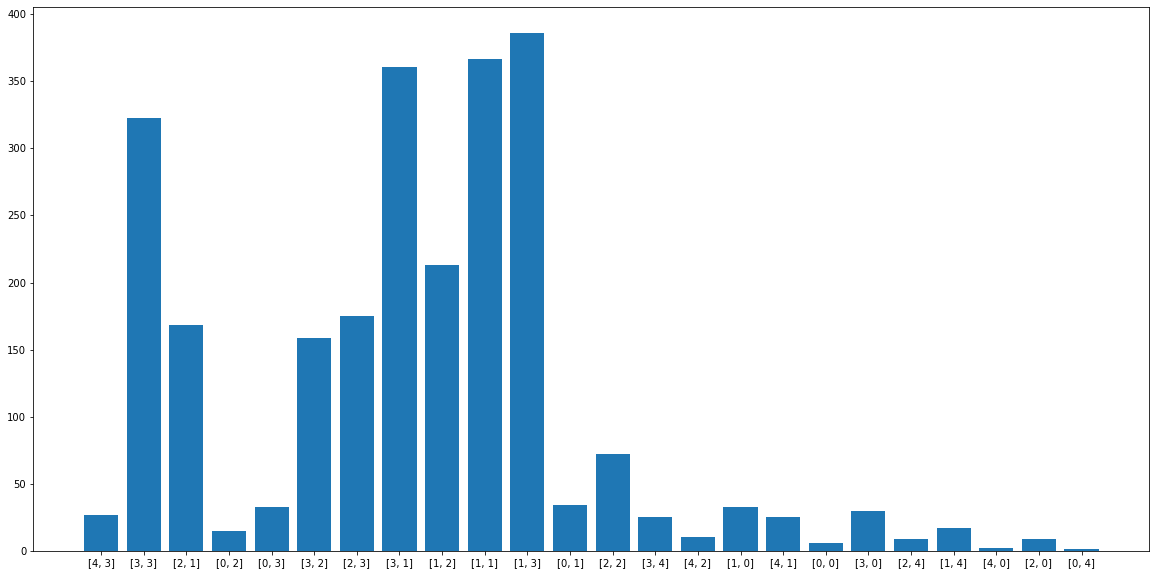

Processing Epoch 119
training start
Iteration 0, d real/fake loss 0.6179994344711304/0.6657065749168396 and g loss is 0.9654136300086975, NDiv loss 0.0649104043841362
Iteration 1, d real/fake loss 0.6181963682174683/0.6346633434295654 and g loss is 0.8210680484771729, NDiv loss 0.06342451274394989
Iteration 2, d real/fake loss 0.6184501051902771/0.6762284636497498 and g loss is 0.879299521446228, NDiv loss 0.06877163797616959
Iteration 3, d real/fake loss 0.6185764074325562/0.6485240459442139 and g loss is 0.9323139190673828, NDiv loss 0.07414578646421432
Iteration 4, d real/fake loss 0.6182143688201904/0.6217496991157532 and g loss is 0.8291935324668884, NDiv loss 0.0634811669588089


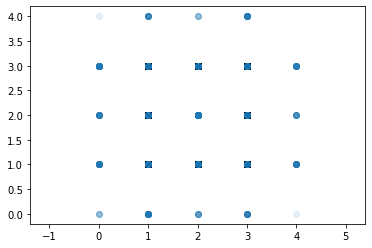

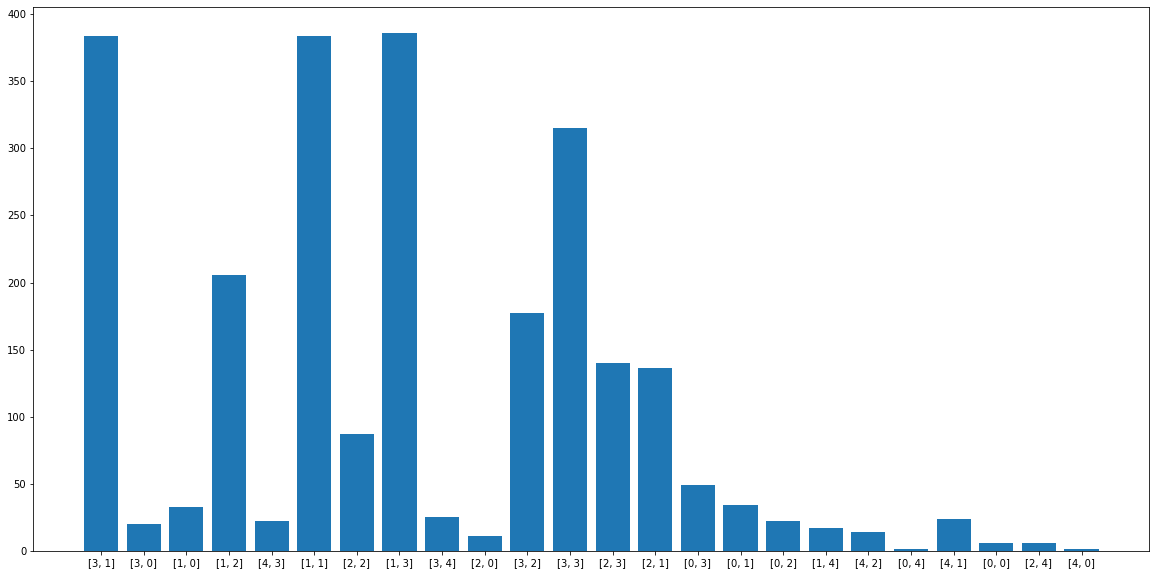

Processing Epoch 120
training start
Iteration 0, d real/fake loss 0.6155738234519958/0.6402978897094727 and g loss is 0.857333779335022, NDiv loss 0.07684551924467087
Iteration 1, d real/fake loss 0.615204393863678/0.6511648893356323 and g loss is 0.8143007755279541, NDiv loss 0.07175684720277786
Iteration 2, d real/fake loss 0.615019679069519/0.6576034426689148 and g loss is 0.8749098181724548, NDiv loss 0.06326840072870255
Iteration 3, d real/fake loss 0.6151630878448486/0.6624852418899536 and g loss is 0.8476845026016235, NDiv loss 0.06436634063720703
Iteration 4, d real/fake loss 0.6154597401618958/0.6878811717033386 and g loss is 0.8680747747421265, NDiv loss 0.06315228343009949


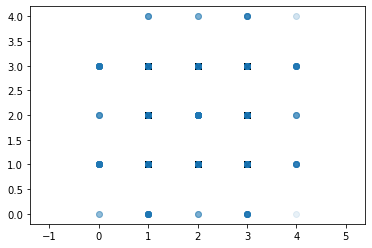

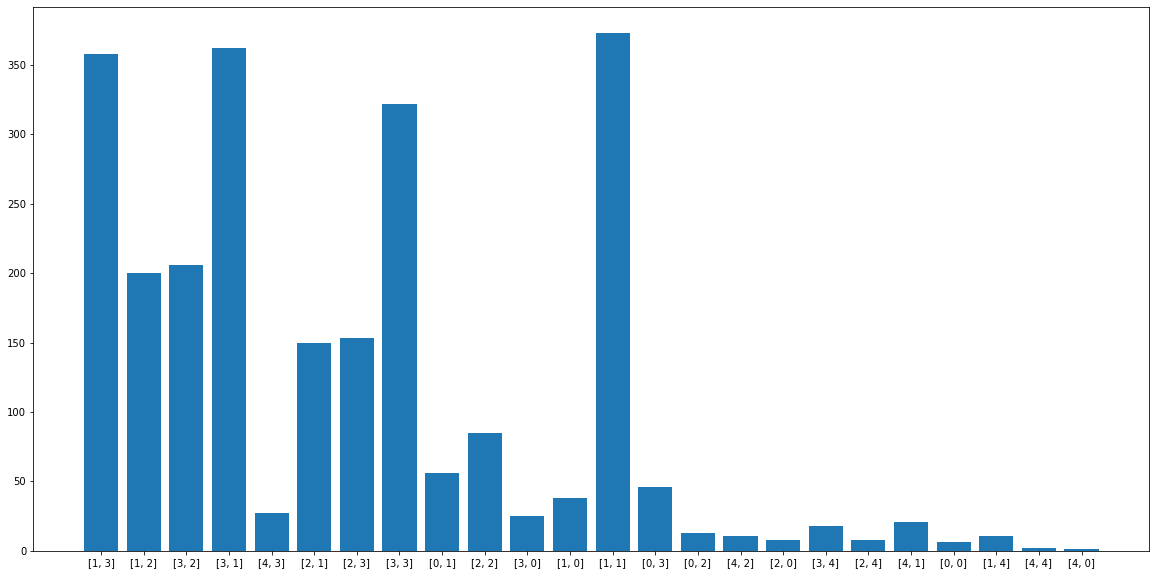

Processing Epoch 121
training start
Iteration 0, d real/fake loss 0.6392797231674194/0.6777343153953552 and g loss is 0.8374032378196716, NDiv loss 0.06674536317586899
Iteration 1, d real/fake loss 0.6394931077957153/0.6364665031433105 and g loss is 0.8937618732452393, NDiv loss 0.07296746224164963
Iteration 2, d real/fake loss 0.6389828324317932/0.638031005859375 and g loss is 0.8279261589050293, NDiv loss 0.07576172053813934
Iteration 3, d real/fake loss 0.6381539702415466/0.6111329793930054 and g loss is 0.889923632144928, NDiv loss 0.07400362193584442
Iteration 4, d real/fake loss 0.6370965242385864/0.6393702626228333 and g loss is 0.9188554286956787, NDiv loss 0.0646333172917366


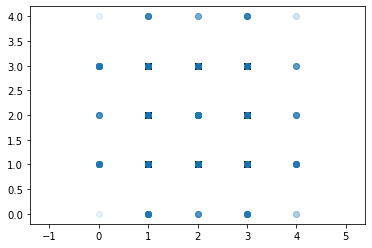

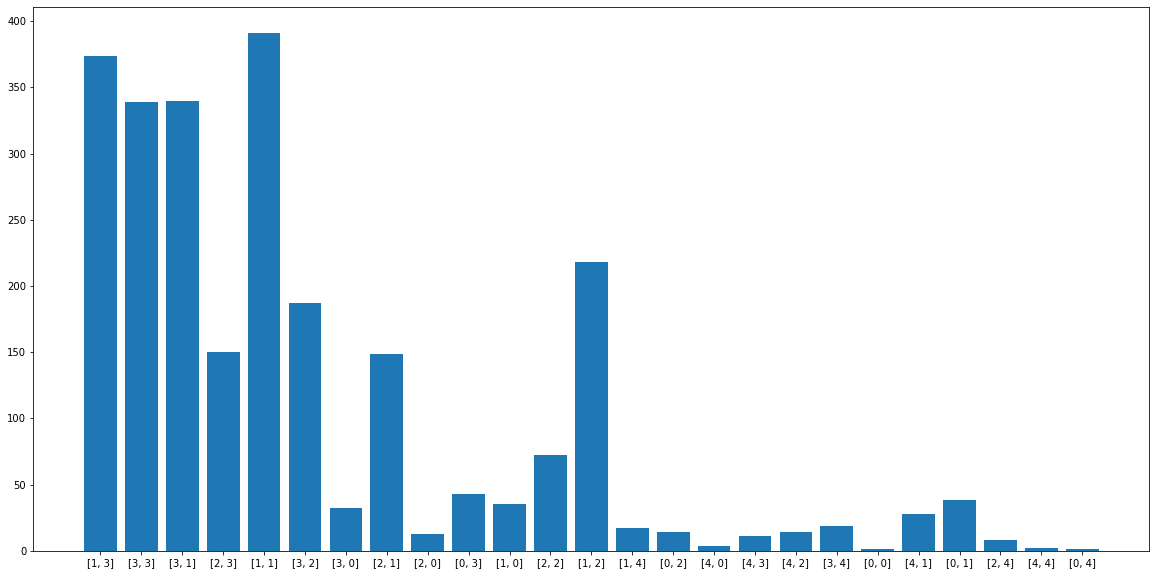

Processing Epoch 122
training start
Iteration 0, d real/fake loss 0.6381459832191467/0.6622678637504578 and g loss is 0.8680555820465088, NDiv loss 0.0644216388463974
Iteration 1, d real/fake loss 0.6366857290267944/0.671148955821991 and g loss is 0.8258978128433228, NDiv loss 0.07124374061822891
Iteration 2, d real/fake loss 0.6352912187576294/0.6805846691131592 and g loss is 0.8449788093566895, NDiv loss 0.0714508444070816
Iteration 3, d real/fake loss 0.6338237524032593/0.6483138799667358 and g loss is 0.8830157518386841, NDiv loss 0.07351966202259064
Iteration 4, d real/fake loss 0.6322728991508484/0.6979470252990723 and g loss is 0.8346686363220215, NDiv loss 0.06051585078239441


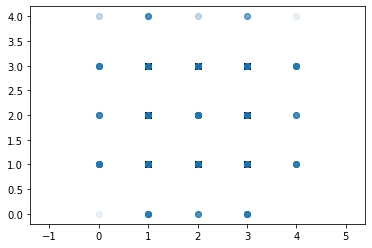

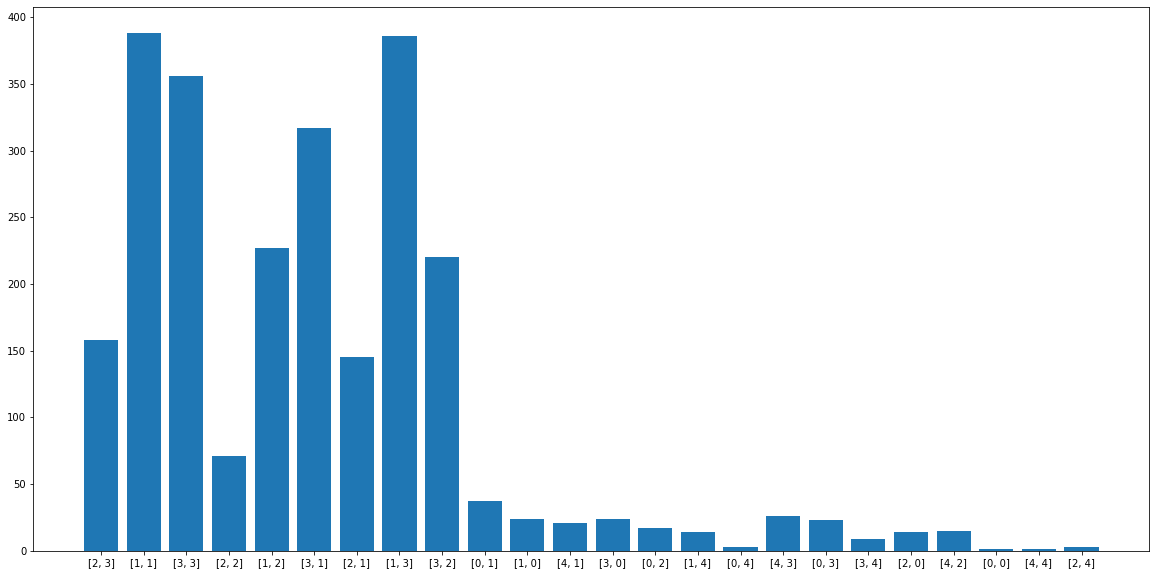

Processing Epoch 123
training start
Iteration 0, d real/fake loss 0.619685709476471/0.6485270857810974 and g loss is 0.8139826655387878, NDiv loss 0.0634901151061058
Iteration 1, d real/fake loss 0.6186892986297607/0.635185718536377 and g loss is 0.7609655261039734, NDiv loss 0.07155609130859375
Iteration 2, d real/fake loss 0.6178231835365295/0.6632963418960571 and g loss is 0.860207736492157, NDiv loss 0.06975218653678894
Iteration 3, d real/fake loss 0.617702066898346/0.6511192917823792 and g loss is 0.8815211653709412, NDiv loss 0.0697232335805893
Iteration 4, d real/fake loss 0.6179413199424744/0.6809486150741577 and g loss is 0.8351927995681763, NDiv loss 0.06244712322950363


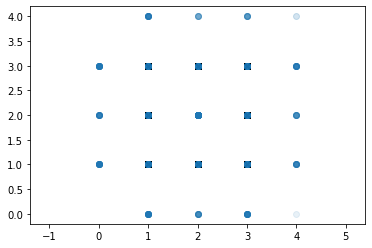

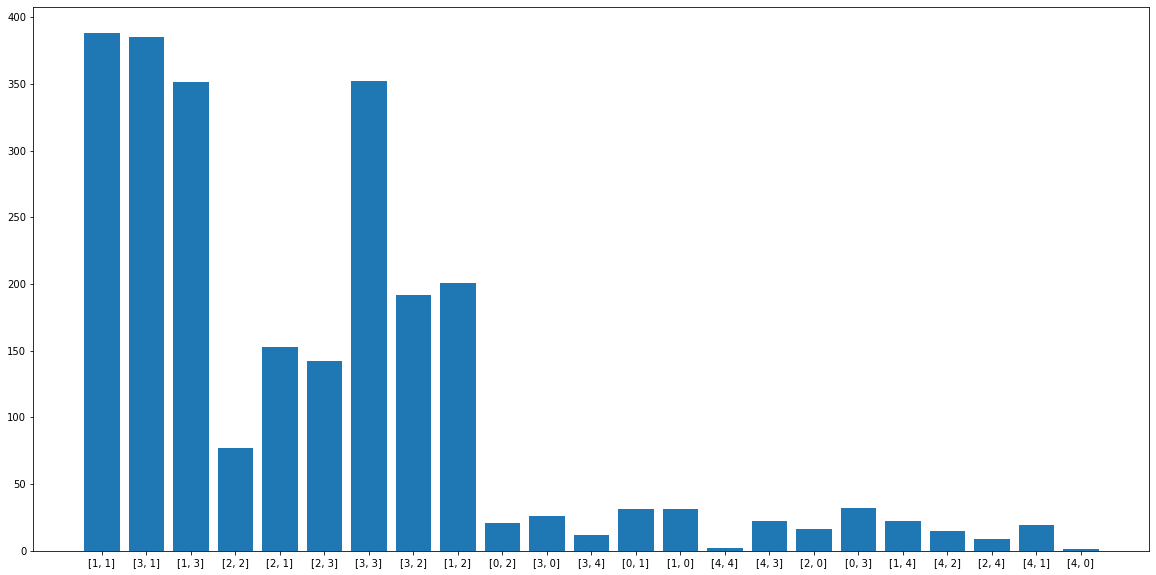

Processing Epoch 124
training start
Iteration 0, d real/fake loss 0.6035562753677368/0.6353710889816284 and g loss is 0.7948461174964905, NDiv loss 0.0723021924495697
Iteration 1, d real/fake loss 0.6043784022331238/0.6807682514190674 and g loss is 0.862934947013855, NDiv loss 0.06931649148464203
Iteration 2, d real/fake loss 0.6055079102516174/0.6572318077087402 and g loss is 0.8197575807571411, NDiv loss 0.06315764784812927
Iteration 3, d real/fake loss 0.606569766998291/0.6525604724884033 and g loss is 0.8362005949020386, NDiv loss 0.07410590350627899
Iteration 4, d real/fake loss 0.6077938079833984/0.6659022569656372 and g loss is 0.8921264410018921, NDiv loss 0.06606852263212204


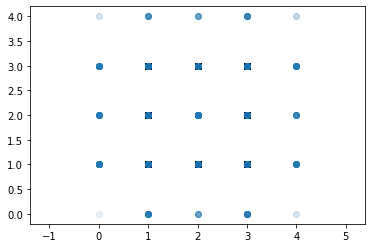

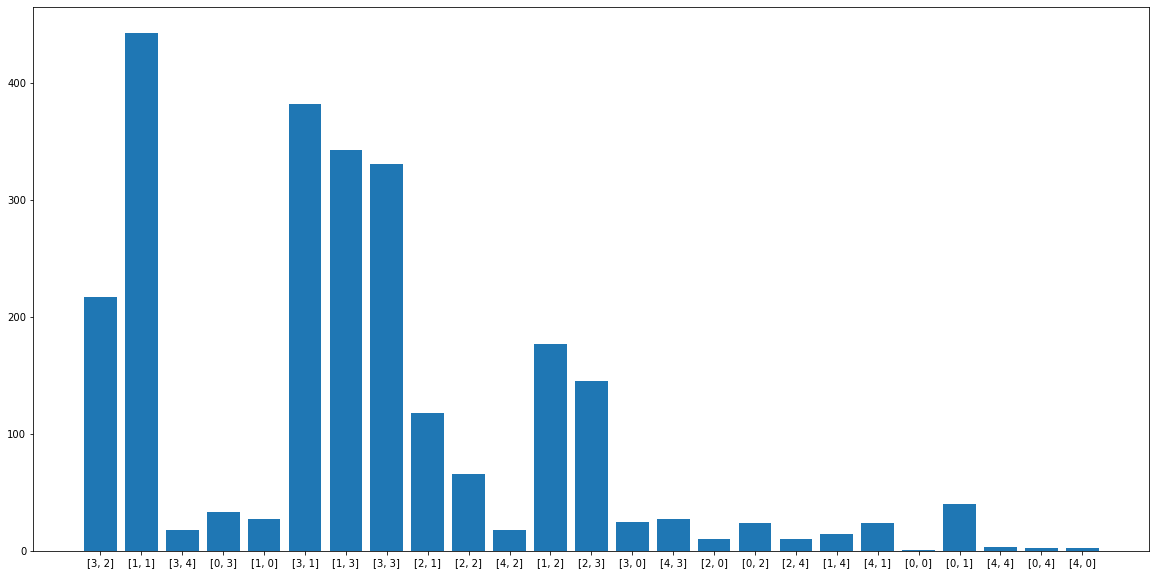

Processing Epoch 125
training start
Iteration 0, d real/fake loss 0.6510103940963745/0.6583206057548523 and g loss is 0.893134593963623, NDiv loss 0.07205098867416382
Iteration 1, d real/fake loss 0.6516115665435791/0.6342636346817017 and g loss is 0.82074373960495, NDiv loss 0.0707554891705513
Iteration 2, d real/fake loss 0.6511576771736145/0.6657578945159912 and g loss is 0.8701901435852051, NDiv loss 0.0678454115986824
Iteration 3, d real/fake loss 0.6500173807144165/0.6883122324943542 and g loss is 0.8360117673873901, NDiv loss 0.06637685000896454
Iteration 4, d real/fake loss 0.6487708687782288/0.6379774212837219 and g loss is 0.8699557781219482, NDiv loss 0.0775601863861084


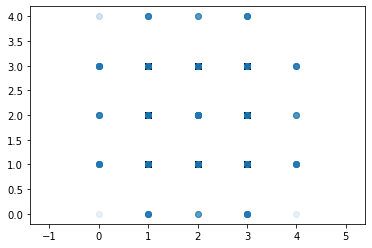

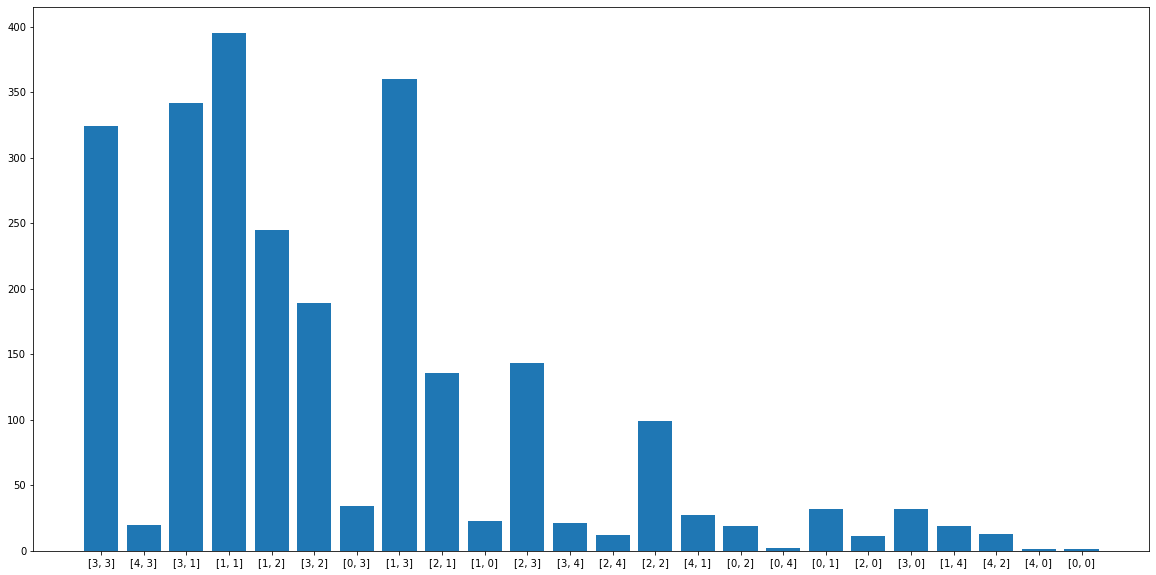

Processing Epoch 126
training start
Iteration 0, d real/fake loss 0.6425747275352478/0.6266448497772217 and g loss is 0.8767786026000977, NDiv loss 0.062236905097961426
Iteration 1, d real/fake loss 0.6413731575012207/0.6300647258758545 and g loss is 0.8220130205154419, NDiv loss 0.06667228788137436
Iteration 2, d real/fake loss 0.64002925157547/0.7178208231925964 and g loss is 0.7638183832168579, NDiv loss 0.07668022066354752
Iteration 3, d real/fake loss 0.6392327547073364/0.6586593389511108 and g loss is 0.823055624961853, NDiv loss 0.07695264369249344
Iteration 4, d real/fake loss 0.63844895362854/0.6338943243026733 and g loss is 0.8382306694984436, NDiv loss 0.07169593125581741


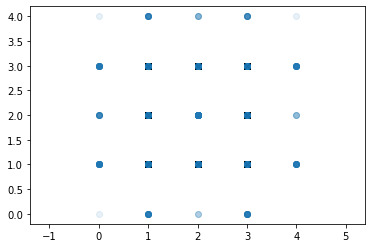

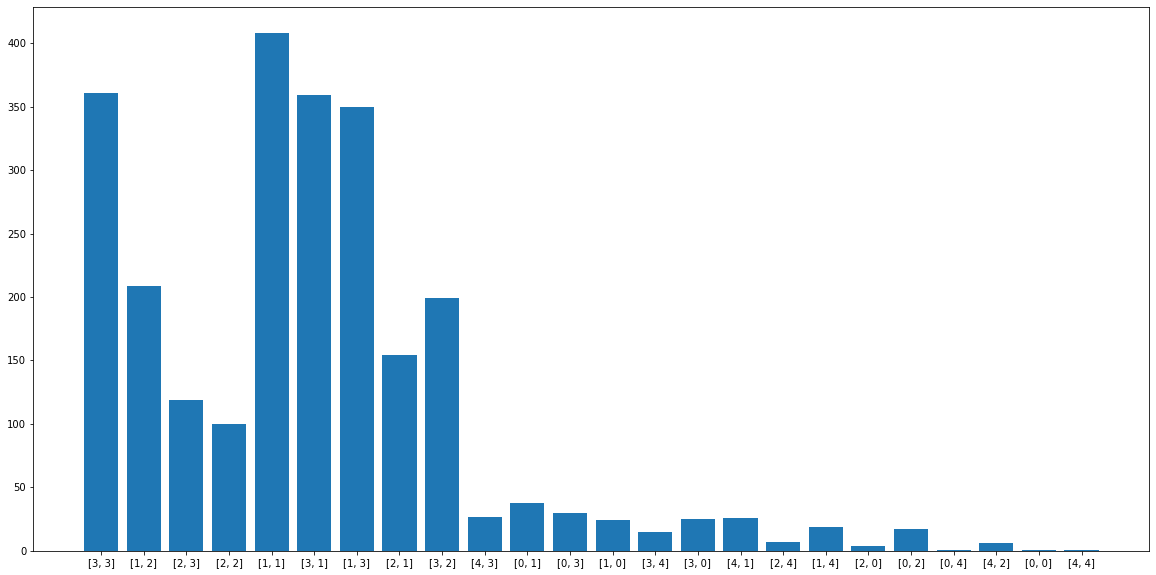

Processing Epoch 127
training start
Iteration 0, d real/fake loss 0.6225981712341309/0.6981396675109863 and g loss is 0.8375779986381531, NDiv loss 0.06646259874105453
Iteration 1, d real/fake loss 0.6224551200866699/0.6158134937286377 and g loss is 0.8833353519439697, NDiv loss 0.07207489758729935
Iteration 2, d real/fake loss 0.6221730709075928/0.6710234880447388 and g loss is 0.8664585947990417, NDiv loss 0.0745001807808876
Iteration 3, d real/fake loss 0.6223769783973694/0.6518818140029907 and g loss is 0.786603569984436, NDiv loss 0.06539487838745117
Iteration 4, d real/fake loss 0.62272709608078/0.6658485531806946 and g loss is 0.8422226309776306, NDiv loss 0.07195240259170532


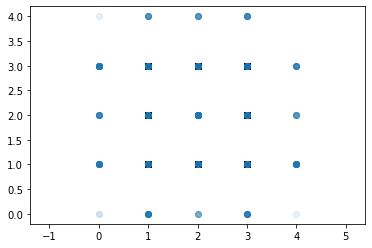

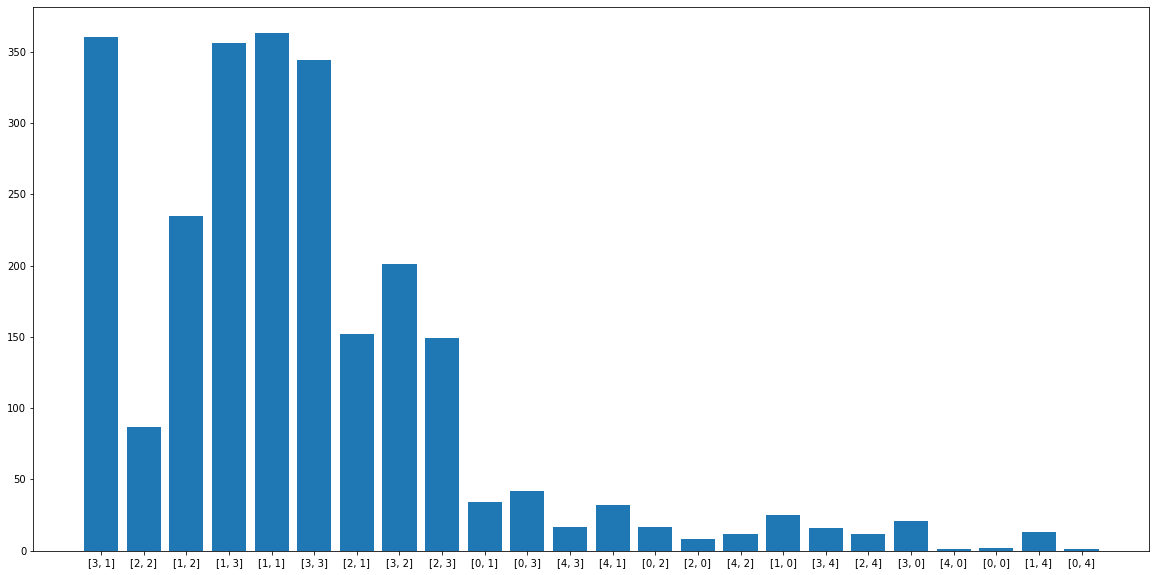

Processing Epoch 128
training start
Iteration 0, d real/fake loss 0.619154691696167/0.6766248941421509 and g loss is 0.8407261371612549, NDiv loss 0.07002682238817215
Iteration 1, d real/fake loss 0.6200781464576721/0.6643824577331543 and g loss is 0.7404102683067322, NDiv loss 0.07413796335458755
Iteration 2, d real/fake loss 0.6208235621452332/0.6853626370429993 and g loss is 0.844935953617096, NDiv loss 0.06758497655391693
Iteration 3, d real/fake loss 0.6218772530555725/0.6727664470672607 and g loss is 0.8209183216094971, NDiv loss 0.06448893994092941
Iteration 4, d real/fake loss 0.6227790117263794/0.651839017868042 and g loss is 0.7634651064872742, NDiv loss 0.06105633080005646


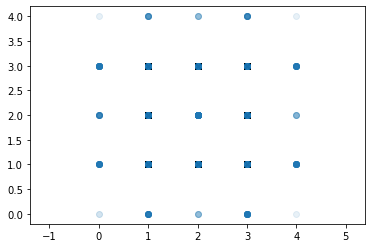

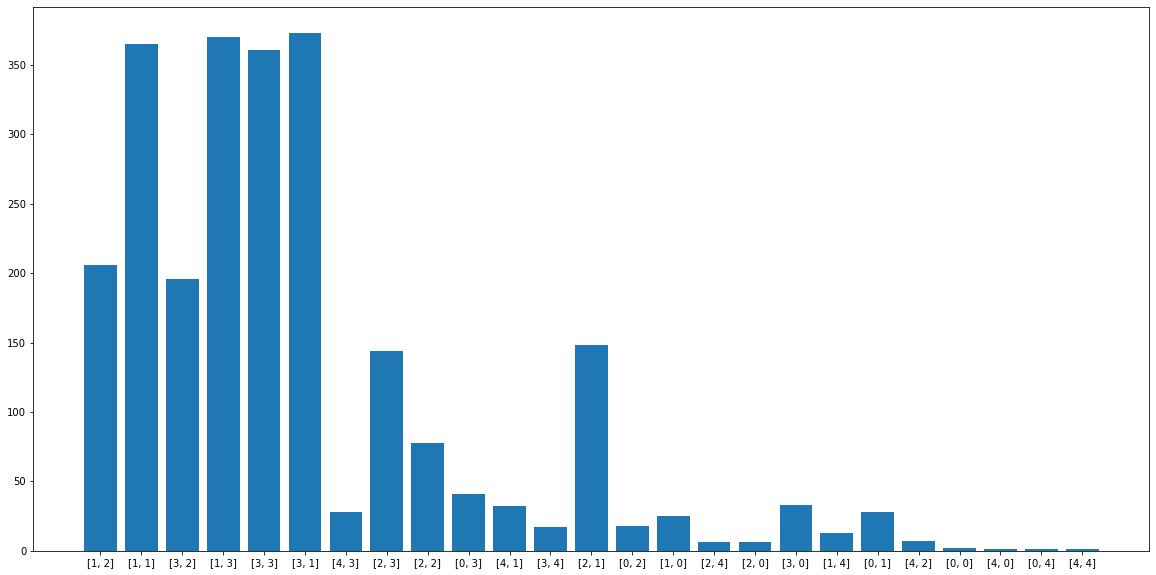

Processing Epoch 129
training start
Iteration 0, d real/fake loss 0.6488559246063232/0.6946162581443787 and g loss is 0.814817488193512, NDiv loss 0.07613452523946762
Iteration 1, d real/fake loss 0.6487212777137756/0.6670697331428528 and g loss is 0.8694207072257996, NDiv loss 0.07620064169168472
Iteration 2, d real/fake loss 0.6486489772796631/0.6649956703186035 and g loss is 0.8597220182418823, NDiv loss 0.06758029758930206
Iteration 3, d real/fake loss 0.6485331058502197/0.6698527336120605 and g loss is 0.8509185910224915, NDiv loss 0.07363516837358475
Iteration 4, d real/fake loss 0.6481379270553589/0.6785624027252197 and g loss is 0.8027918934822083, NDiv loss 0.08389502763748169


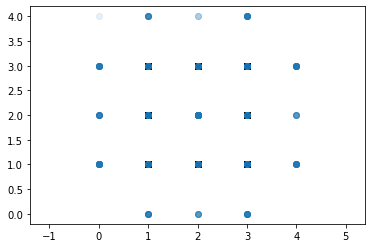

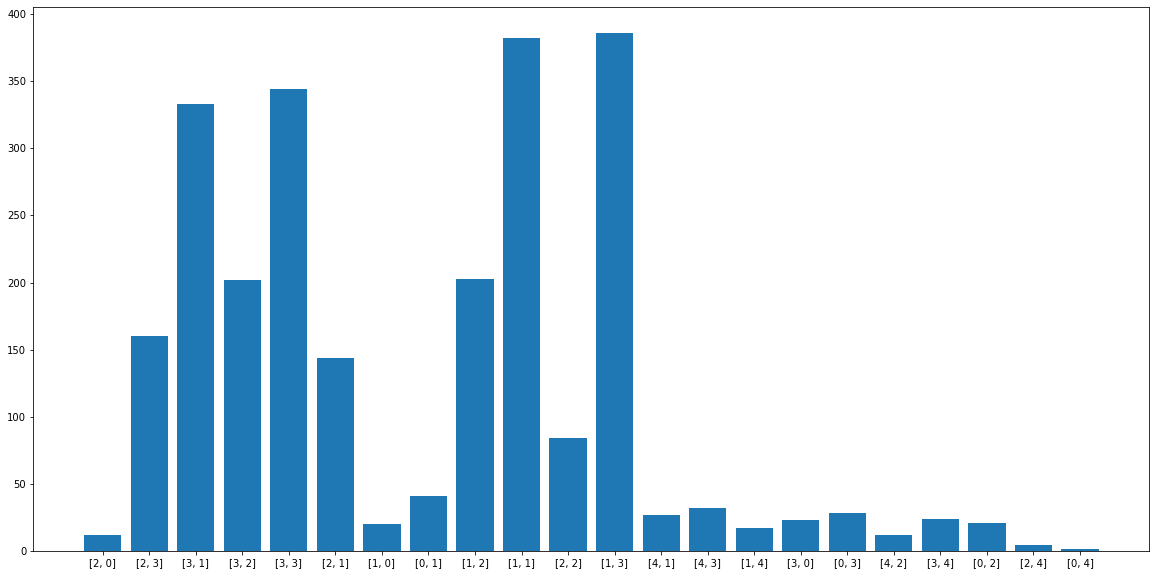

Processing Epoch 130
training start
Iteration 0, d real/fake loss 0.628233790397644/0.6982058882713318 and g loss is 0.8075595498085022, NDiv loss 0.07655210047960281
Iteration 1, d real/fake loss 0.6280637979507446/0.6362699270248413 and g loss is 0.8110536336898804, NDiv loss 0.07667848467826843
Iteration 2, d real/fake loss 0.6274245977401733/0.6892638802528381 and g loss is 0.8185815811157227, NDiv loss 0.07783086597919464
Iteration 3, d real/fake loss 0.6269925832748413/0.7034699320793152 and g loss is 0.8833956718444824, NDiv loss 0.06058624014258385
Iteration 4, d real/fake loss 0.626987099647522/0.6231276988983154 and g loss is 0.7588754892349243, NDiv loss 0.06498059630393982


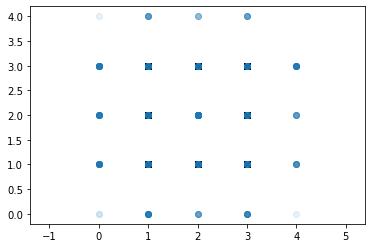

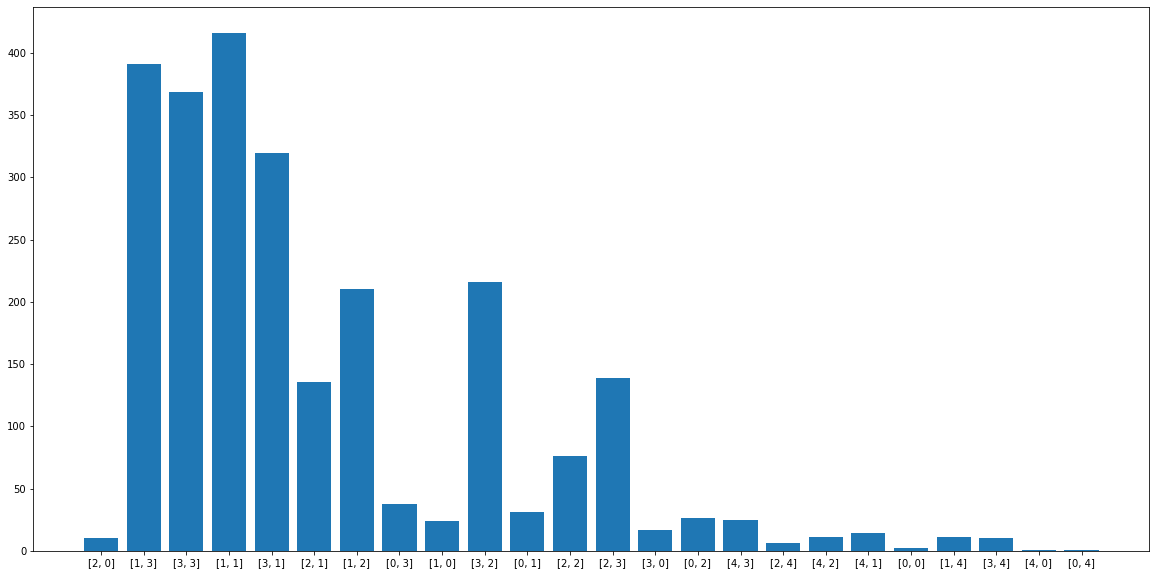

Processing Epoch 131
training start
Iteration 0, d real/fake loss 0.6286273002624512/0.6543561220169067 and g loss is 0.7373788356781006, NDiv loss 0.07035574316978455
Iteration 1, d real/fake loss 0.6286710500717163/0.6628830432891846 and g loss is 0.7640625834465027, NDiv loss 0.0781046524643898
Iteration 2, d real/fake loss 0.6288728713989258/0.6455655097961426 and g loss is 0.8036231398582458, NDiv loss 0.07419827580451965
Iteration 3, d real/fake loss 0.6289641857147217/0.6599392294883728 and g loss is 0.744821310043335, NDiv loss 0.07458943128585815
Iteration 4, d real/fake loss 0.6288923025131226/0.6697017550468445 and g loss is 0.8353433012962341, NDiv loss 0.06545655429363251


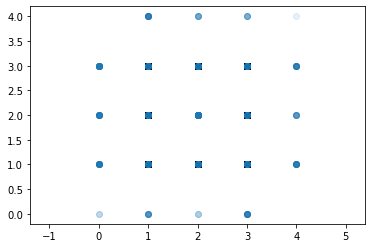

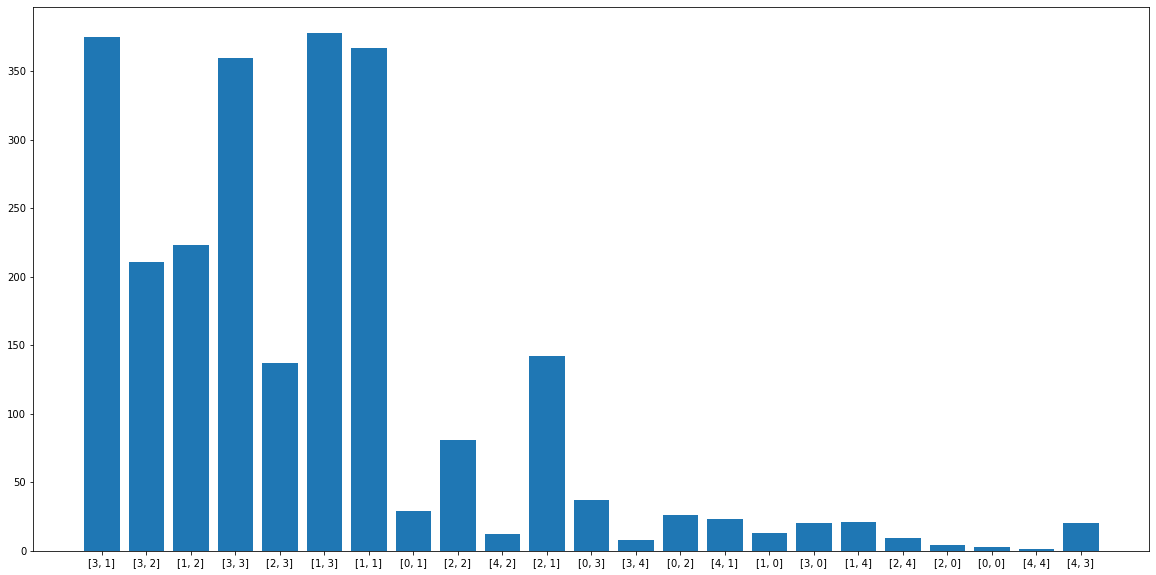

Processing Epoch 132
training start
Iteration 0, d real/fake loss 0.6329019069671631/0.6438859105110168 and g loss is 0.7819005250930786, NDiv loss 0.06499908864498138
Iteration 1, d real/fake loss 0.6331589221954346/0.6763529777526855 and g loss is 0.8992065191268921, NDiv loss 0.07231508940458298
Iteration 2, d real/fake loss 0.6335163116455078/0.6318129301071167 and g loss is 0.8248905539512634, NDiv loss 0.06740963459014893
Iteration 3, d real/fake loss 0.6334725618362427/0.6850479245185852 and g loss is 0.8355057239532471, NDiv loss 0.07760294526815414
Iteration 4, d real/fake loss 0.6338574886322021/0.6505212187767029 and g loss is 0.8849235773086548, NDiv loss 0.06270233541727066


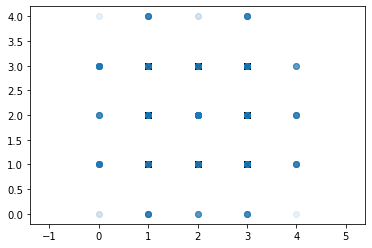

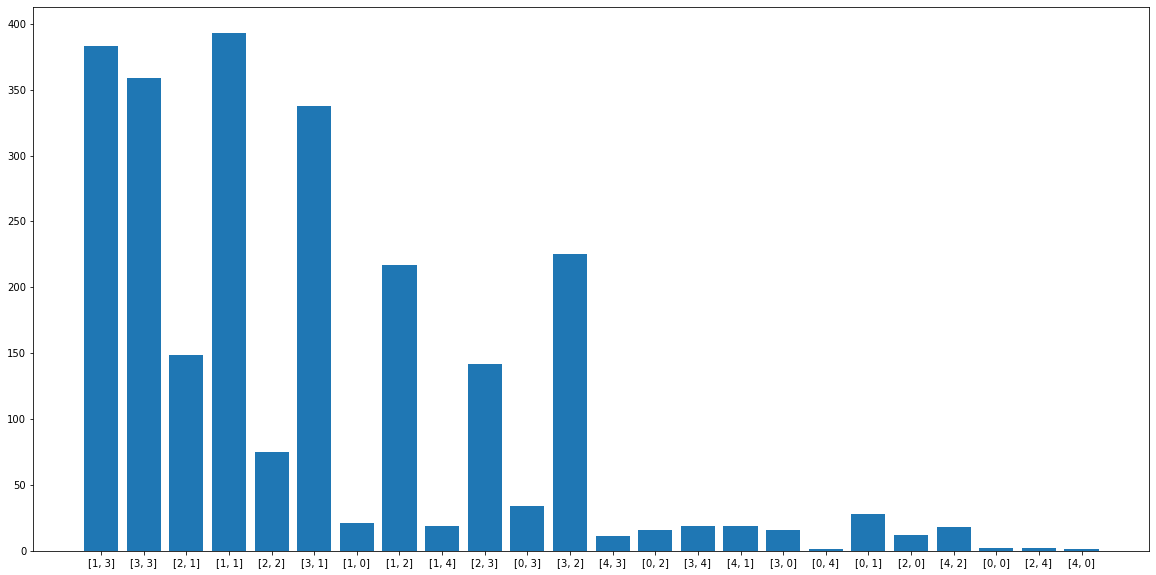

Processing Epoch 133
training start
Iteration 0, d real/fake loss 0.6253514289855957/0.662385880947113 and g loss is 0.8125171065330505, NDiv loss 0.07070598751306534
Iteration 1, d real/fake loss 0.6259604692459106/0.6742490530014038 and g loss is 0.9099331498146057, NDiv loss 0.06785424053668976
Iteration 2, d real/fake loss 0.6266542673110962/0.635938286781311 and g loss is 0.8473808169364929, NDiv loss 0.07464107871055603
Iteration 3, d real/fake loss 0.6270941495895386/0.6484618782997131 and g loss is 0.8430285453796387, NDiv loss 0.08748842775821686
Iteration 4, d real/fake loss 0.6276517510414124/0.6066802740097046 and g loss is 0.8008791208267212, NDiv loss 0.07167086750268936


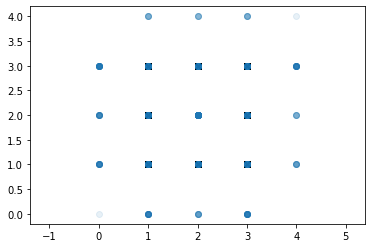

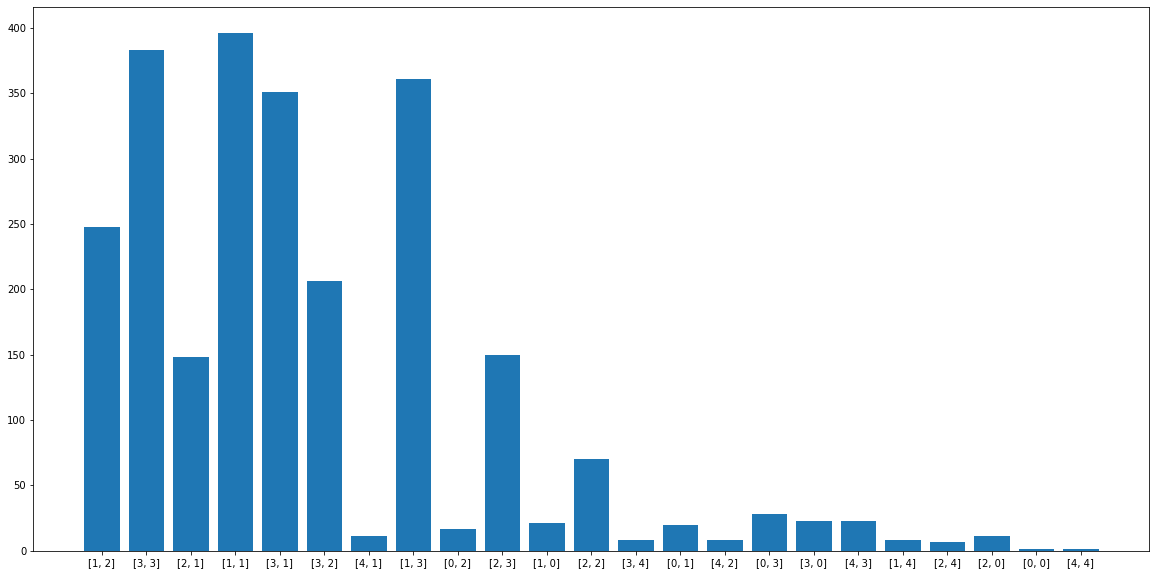

Processing Epoch 134
training start
Iteration 0, d real/fake loss 0.6441879272460938/0.6606912016868591 and g loss is 0.9026397466659546, NDiv loss 0.0707685574889183
Iteration 1, d real/fake loss 0.6444208025932312/0.6219856142997742 and g loss is 0.8360476493835449, NDiv loss 0.06978185474872589
Iteration 2, d real/fake loss 0.6440630555152893/0.6710070371627808 and g loss is 0.7945592403411865, NDiv loss 0.06599859148263931
Iteration 3, d real/fake loss 0.6435081362724304/0.6463392972946167 and g loss is 0.8474152088165283, NDiv loss 0.06809541583061218
Iteration 4, d real/fake loss 0.6427522897720337/0.6333787441253662 and g loss is 0.8069059252738953, NDiv loss 0.06777913868427277


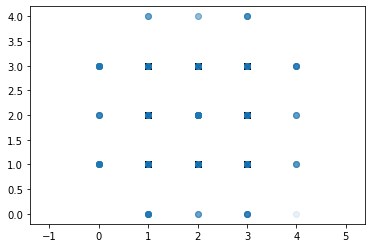

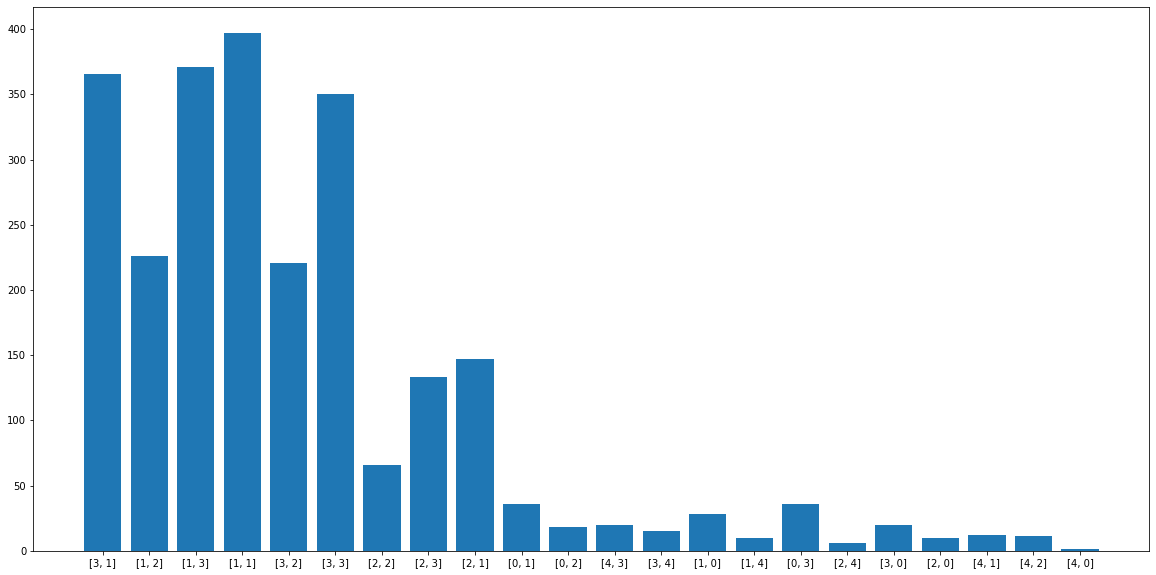

Processing Epoch 135
training start
Iteration 0, d real/fake loss 0.647494375705719/0.6526860594749451 and g loss is 0.8337957859039307, NDiv loss 0.08154360949993134
Iteration 1, d real/fake loss 0.6464316248893738/0.6843096017837524 and g loss is 0.7721283435821533, NDiv loss 0.07204978168010712
Iteration 2, d real/fake loss 0.645499050617218/0.6557540893554688 and g loss is 0.8412729501724243, NDiv loss 0.0706072524189949
Iteration 3, d real/fake loss 0.644318699836731/0.656980037689209 and g loss is 0.8393211364746094, NDiv loss 0.07443967461585999
Iteration 4, d real/fake loss 0.6428916454315186/0.6529695987701416 and g loss is 0.8243246078491211, NDiv loss 0.07609589397907257


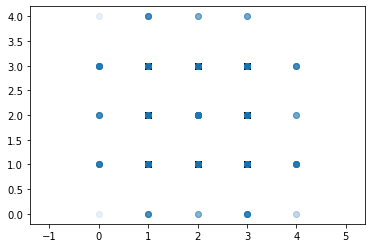

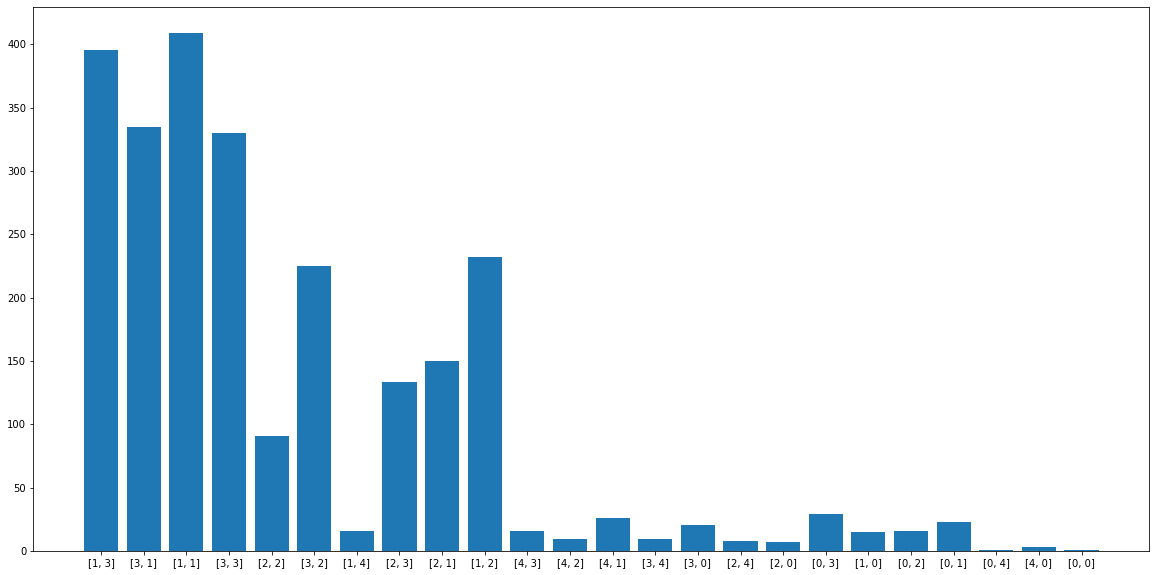

Processing Epoch 136
training start
Iteration 0, d real/fake loss 0.6264742016792297/0.6689103841781616 and g loss is 0.880359411239624, NDiv loss 0.08024029433727264
Iteration 1, d real/fake loss 0.6261118054389954/0.6468170881271362 and g loss is 0.8219250440597534, NDiv loss 0.0706157237291336
Iteration 2, d real/fake loss 0.6263840198516846/0.6912981867790222 and g loss is 0.8567113876342773, NDiv loss 0.072721928358078
Iteration 3, d real/fake loss 0.627026379108429/0.6738072633743286 and g loss is 0.8361614346504211, NDiv loss 0.07459204643964767
Iteration 4, d real/fake loss 0.6276317238807678/0.6608912348747253 and g loss is 0.814095139503479, NDiv loss 0.06694890558719635


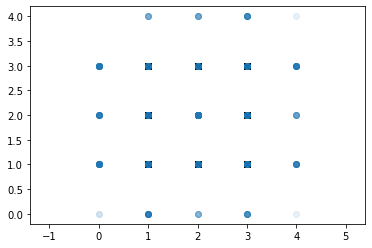

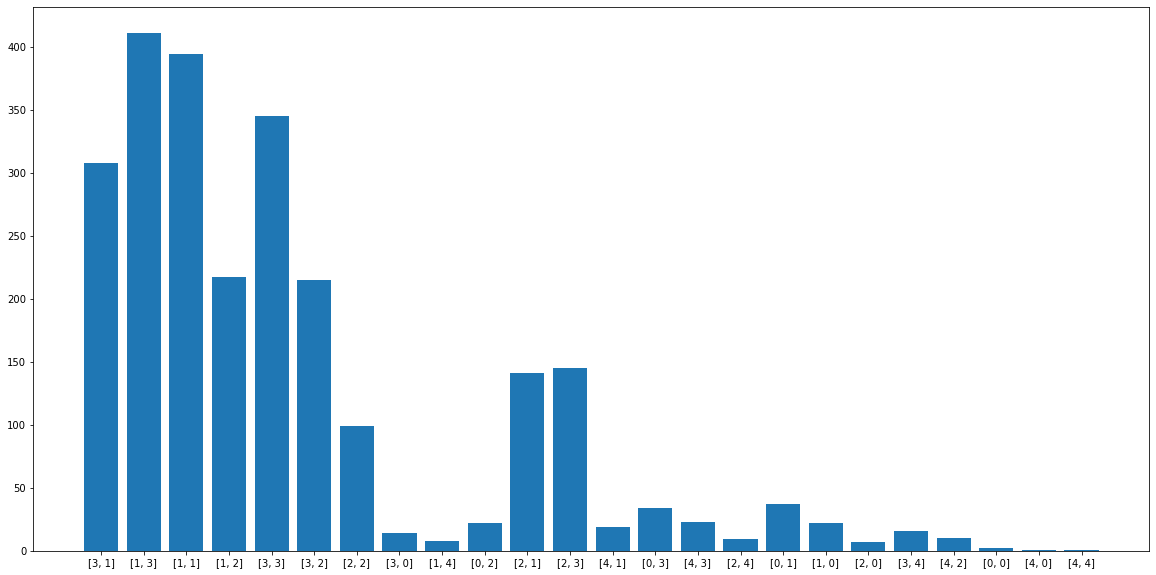

Processing Epoch 137
training start
Iteration 0, d real/fake loss 0.6102669835090637/0.6152750253677368 and g loss is 0.8205116391181946, NDiv loss 0.0731702446937561
Iteration 1, d real/fake loss 0.6111575365066528/0.6760861873626709 and g loss is 0.9202028512954712, NDiv loss 0.08038391917943954
Iteration 2, d real/fake loss 0.6126027703285217/0.6759424805641174 and g loss is 0.8191959857940674, NDiv loss 0.07689794898033142
Iteration 3, d real/fake loss 0.613951563835144/0.669699490070343 and g loss is 0.8425676822662354, NDiv loss 0.07722798734903336
Iteration 4, d real/fake loss 0.6149367094039917/0.6302441358566284 and g loss is 0.8296176195144653, NDiv loss 0.08440949022769928


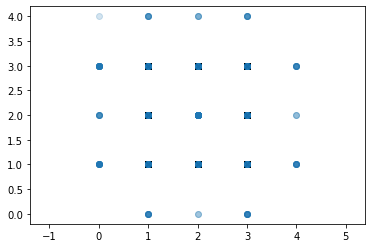

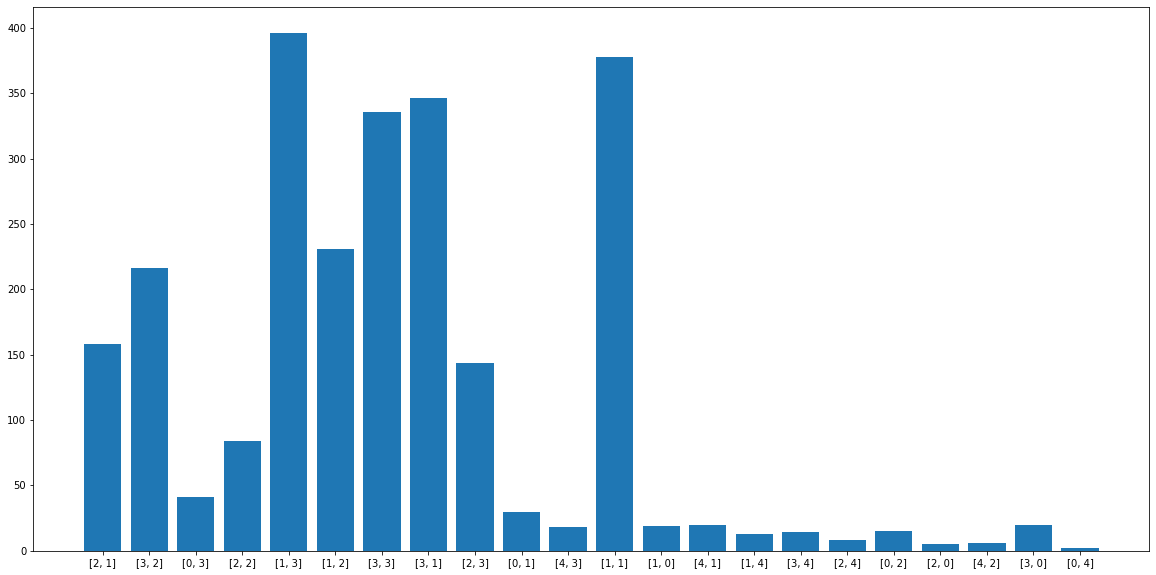

Processing Epoch 138
training start
Iteration 0, d real/fake loss 0.633612871170044/0.6774990558624268 and g loss is 0.8353686928749084, NDiv loss 0.06787651777267456
Iteration 1, d real/fake loss 0.634983241558075/0.6067018508911133 and g loss is 0.8172438144683838, NDiv loss 0.07376150041818619
Iteration 2, d real/fake loss 0.6357308626174927/0.6587170362472534 and g loss is 0.827694296836853, NDiv loss 0.07381483912467957
Iteration 3, d real/fake loss 0.6361744403839111/0.6560626029968262 and g loss is 0.8619827032089233, NDiv loss 0.06855930387973785
Iteration 4, d real/fake loss 0.6361708045005798/0.6334490776062012 and g loss is 0.956818699836731, NDiv loss 0.08121687173843384


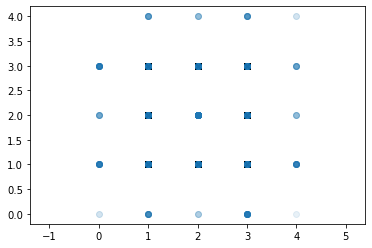

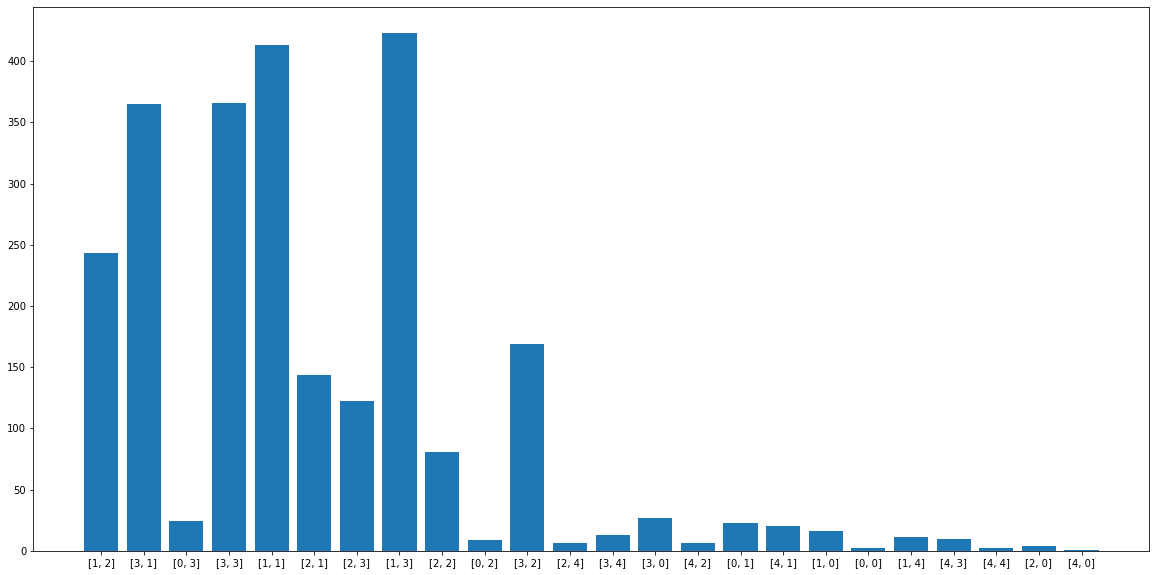

Processing Epoch 139
training start
Iteration 0, d real/fake loss 0.6524677276611328/0.6336034536361694 and g loss is 0.8428606986999512, NDiv loss 0.07434336841106415
Iteration 1, d real/fake loss 0.6515134572982788/0.6901510953903198 and g loss is 0.8414654731750488, NDiv loss 0.06568670272827148
Iteration 2, d real/fake loss 0.6504373550415039/0.6617587804794312 and g loss is 0.8995222449302673, NDiv loss 0.0784001424908638
Iteration 3, d real/fake loss 0.6494395732879639/0.6306076049804688 and g loss is 0.7753309011459351, NDiv loss 0.08998070657253265
Iteration 4, d real/fake loss 0.6483346223831177/0.6574581265449524 and g loss is 0.7840569615364075, NDiv loss 0.07261311262845993


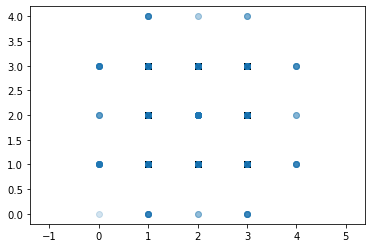

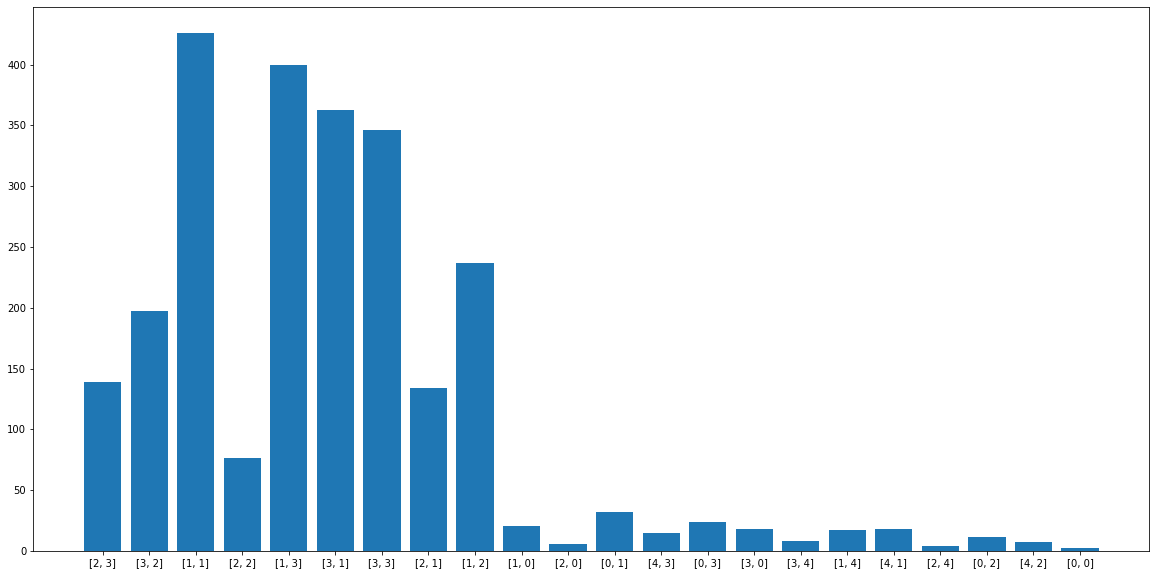

Processing Epoch 140
training start
Iteration 0, d real/fake loss 0.6472161412239075/0.653240442276001 and g loss is 0.7865623235702515, NDiv loss 0.07840210199356079
Iteration 1, d real/fake loss 0.6462641954421997/0.6797430515289307 and g loss is 0.8447858691215515, NDiv loss 0.07221077382564545
Iteration 2, d real/fake loss 0.6455193758010864/0.6176872253417969 and g loss is 0.8213726282119751, NDiv loss 0.08138135075569153
Iteration 3, d real/fake loss 0.6446055769920349/0.654662013053894 and g loss is 0.7857519388198853, NDiv loss 0.07246340811252594
Iteration 4, d real/fake loss 0.6439326405525208/0.6960738897323608 and g loss is 0.8149582743644714, NDiv loss 0.06833456456661224


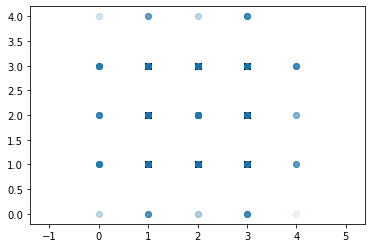

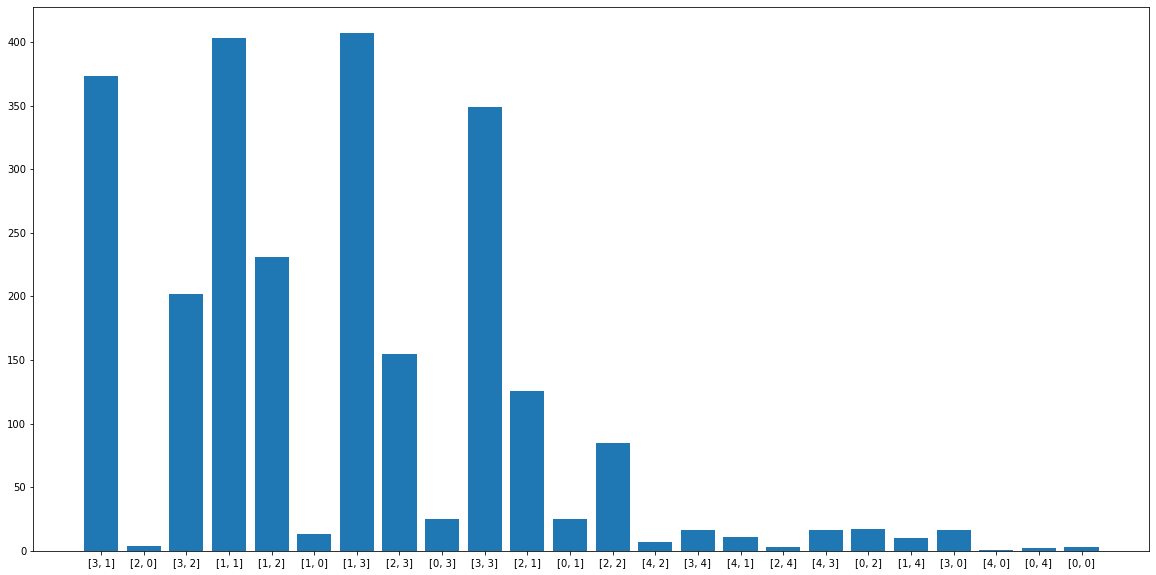

Processing Epoch 141
training start
Iteration 0, d real/fake loss 0.6524726152420044/0.6689290404319763 and g loss is 0.8347274661064148, NDiv loss 0.08729319274425507
Iteration 1, d real/fake loss 0.6518663167953491/0.6697739362716675 and g loss is 0.8315410614013672, NDiv loss 0.08278761804103851
Iteration 2, d real/fake loss 0.6510563492774963/0.6579751968383789 and g loss is 0.7863374948501587, NDiv loss 0.06854189932346344
Iteration 3, d real/fake loss 0.6502318978309631/0.6384731531143188 and g loss is 0.7743284702301025, NDiv loss 0.0685969814658165
Iteration 4, d real/fake loss 0.6494009494781494/0.6993263959884644 and g loss is 0.8376903533935547, NDiv loss 0.0666581243276596


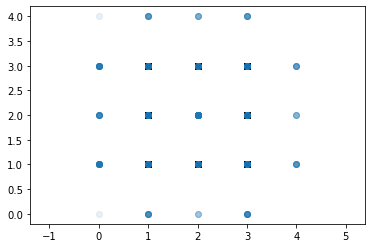

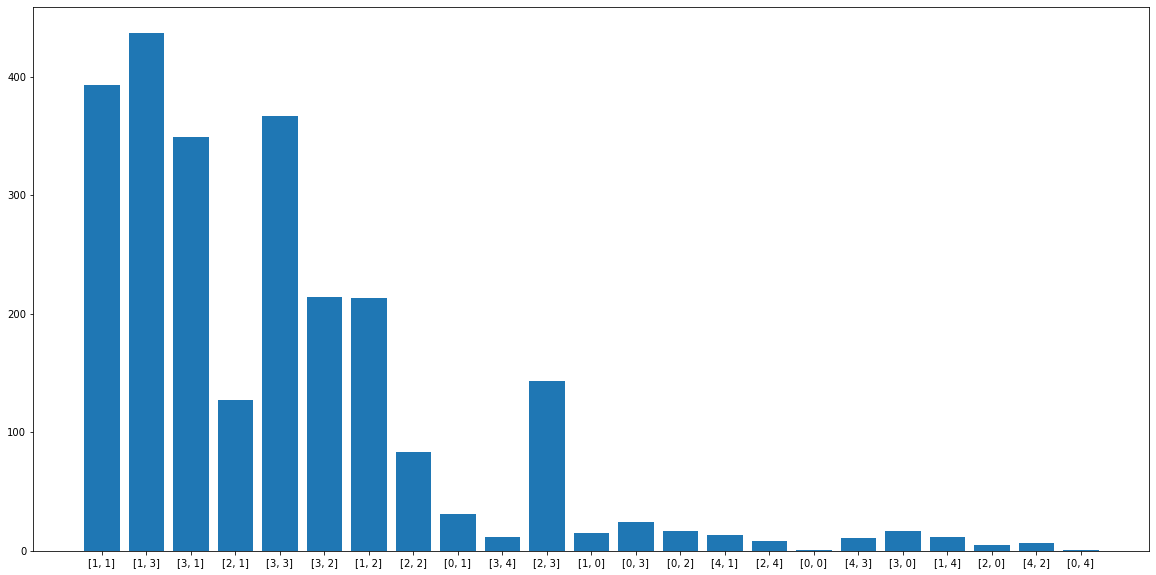

Processing Epoch 142
training start
Iteration 0, d real/fake loss 0.6427756547927856/0.6492496728897095 and g loss is 0.8397679328918457, NDiv loss 0.0693865418434143
Iteration 1, d real/fake loss 0.6427323818206787/0.6839205026626587 and g loss is 0.7720822095870972, NDiv loss 0.0942469984292984
Iteration 2, d real/fake loss 0.6428405046463013/0.6984875798225403 and g loss is 0.7970024943351746, NDiv loss 0.07553956657648087
Iteration 3, d real/fake loss 0.6431663036346436/0.6597692370414734 and g loss is 0.8450589179992676, NDiv loss 0.0859472006559372
Iteration 4, d real/fake loss 0.6433367133140564/0.6653833389282227 and g loss is 0.8636344075202942, NDiv loss 0.07640539109706879


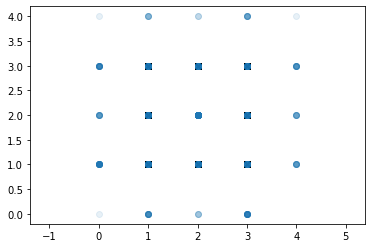

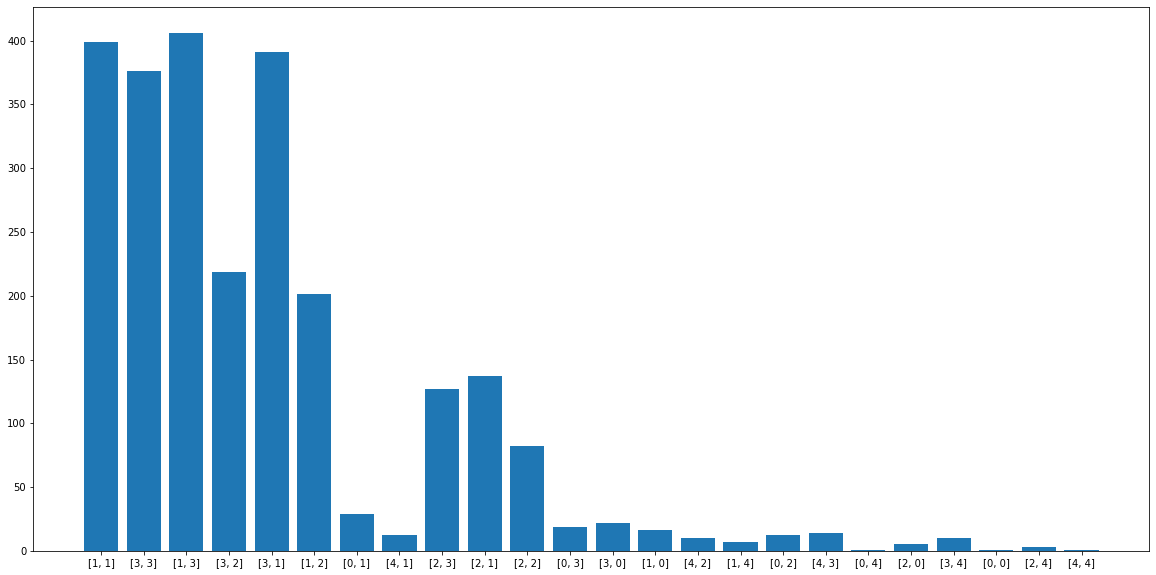

Processing Epoch 143
training start
Iteration 0, d real/fake loss 0.6537554860115051/0.6421658992767334 and g loss is 0.824919581413269, NDiv loss 0.08102298527956009
Iteration 1, d real/fake loss 0.653477668762207/0.6591116189956665 and g loss is 0.792163074016571, NDiv loss 0.07377010583877563
Iteration 2, d real/fake loss 0.6528853178024292/0.6657969355583191 and g loss is 0.7856718301773071, NDiv loss 0.06247875094413757
Iteration 3, d real/fake loss 0.6520766019821167/0.6715354323387146 and g loss is 0.8168903589248657, NDiv loss 0.07817773520946503
Iteration 4, d real/fake loss 0.6512384414672852/0.6604958772659302 and g loss is 0.8449413776397705, NDiv loss 0.07776770740747452


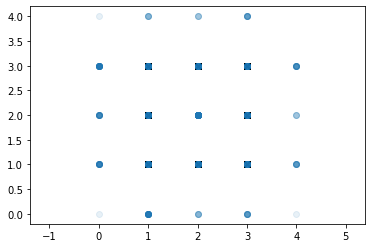

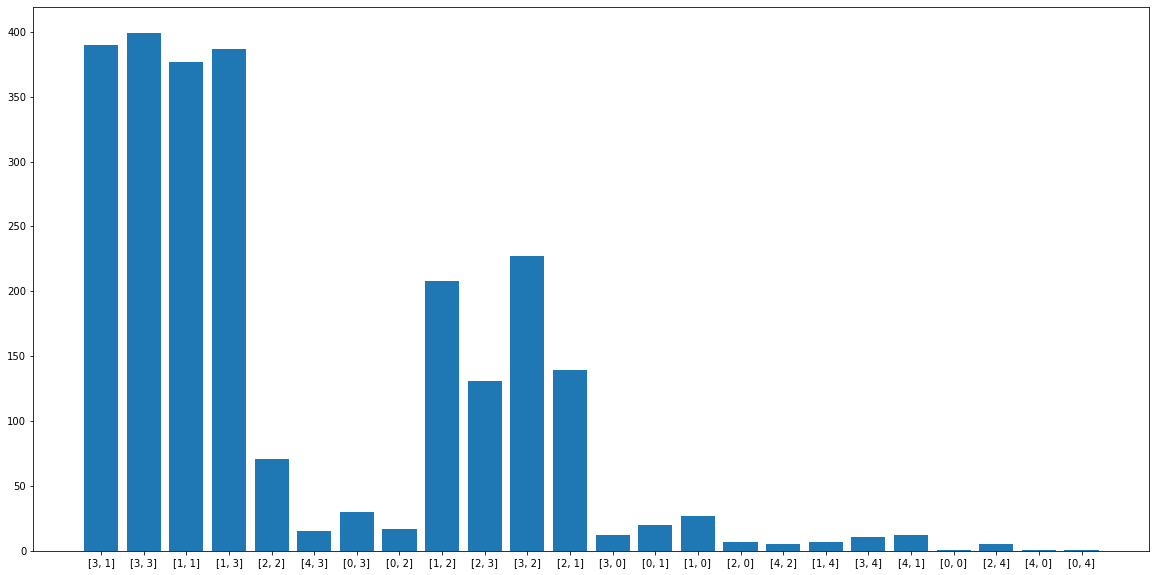

Processing Epoch 144
training start
Iteration 0, d real/fake loss 0.6243770122528076/0.6767082810401917 and g loss is 0.8027852773666382, NDiv loss 0.0707274004817009
Iteration 1, d real/fake loss 0.6247841119766235/0.6884469985961914 and g loss is 0.7989770174026489, NDiv loss 0.07809747755527496
Iteration 2, d real/fake loss 0.6255452036857605/0.6493041515350342 and g loss is 0.7538434267044067, NDiv loss 0.0880712941288948
Iteration 3, d real/fake loss 0.6263384819030762/0.6363315582275391 and g loss is 0.8398891687393188, NDiv loss 0.07538396120071411
Iteration 4, d real/fake loss 0.6270496249198914/0.659074604511261 and g loss is 0.7576614618301392, NDiv loss 0.07815933227539062


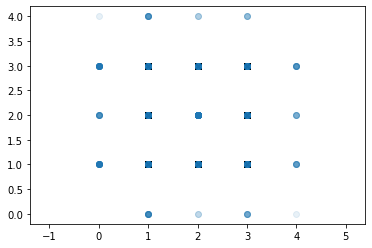

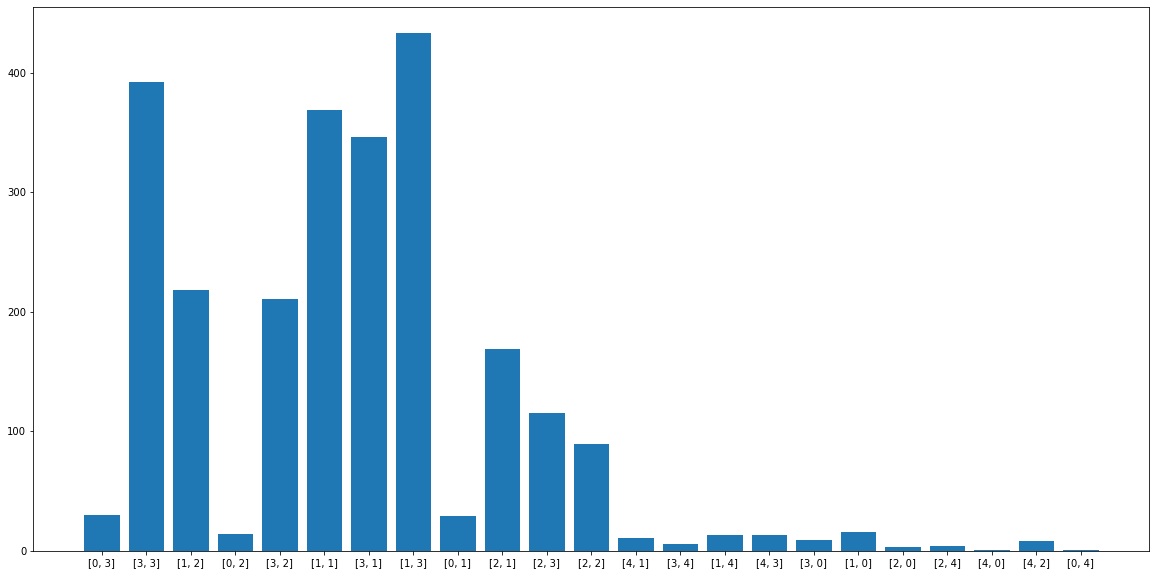

Processing Epoch 145
training start
Iteration 0, d real/fake loss 0.6542812585830688/0.6874310374259949 and g loss is 0.7726366519927979, NDiv loss 0.08125302940607071
Iteration 1, d real/fake loss 0.6546140313148499/0.689690113067627 and g loss is 0.8489885330200195, NDiv loss 0.0651455894112587
Iteration 2, d real/fake loss 0.6549602746963501/0.6663660407066345 and g loss is 0.8402169942855835, NDiv loss 0.08719371259212494
Iteration 3, d real/fake loss 0.6553136110305786/0.6631982326507568 and g loss is 0.7786920666694641, NDiv loss 0.07133873552083969
Iteration 4, d real/fake loss 0.655346155166626/0.6623114347457886 and g loss is 0.8058648109436035, NDiv loss 0.08110267668962479


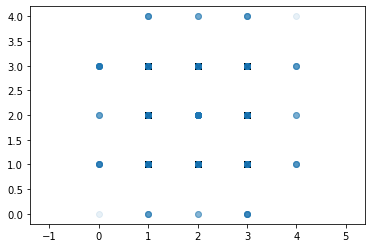

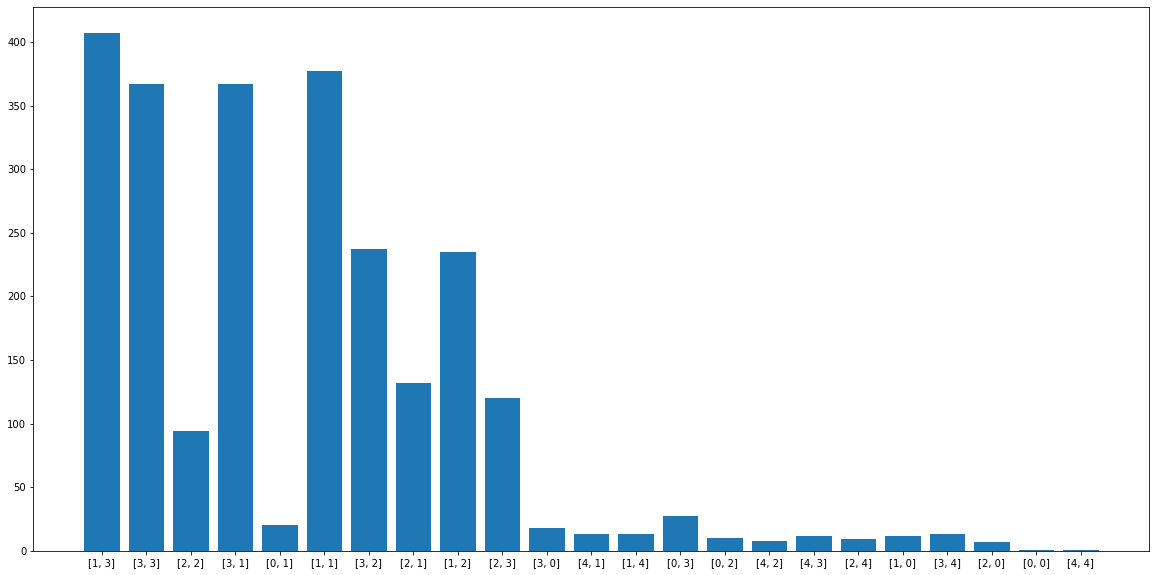

Processing Epoch 146
training start
Iteration 0, d real/fake loss 0.6518757343292236/0.6485259532928467 and g loss is 0.7963453531265259, NDiv loss 0.07897556573152542
Iteration 1, d real/fake loss 0.651748538017273/0.6512356996536255 and g loss is 0.8013189435005188, NDiv loss 0.08214286714792252
Iteration 2, d real/fake loss 0.6512293219566345/0.6899712085723877 and g loss is 0.7906303405761719, NDiv loss 0.08026303350925446
Iteration 3, d real/fake loss 0.6508076190948486/0.6954097747802734 and g loss is 0.8708090782165527, NDiv loss 0.0789092555642128
Iteration 4, d real/fake loss 0.6505540609359741/0.6469937562942505 and g loss is 0.8694498538970947, NDiv loss 0.07559153437614441


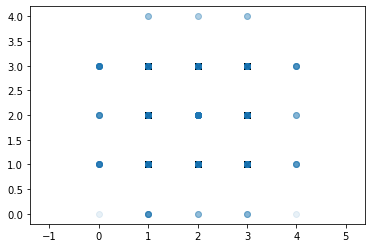

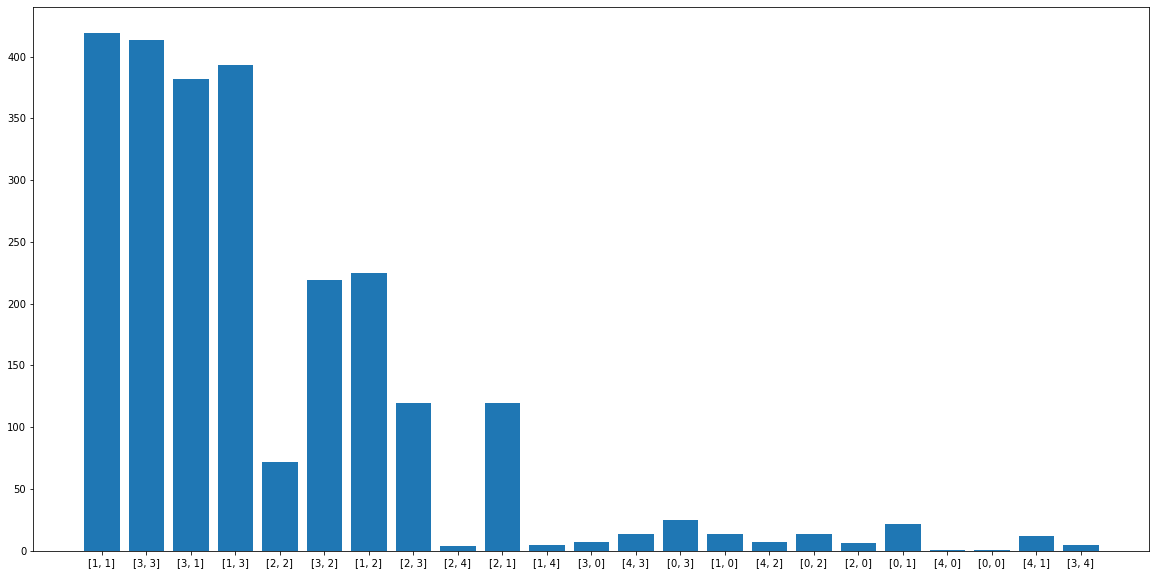

Processing Epoch 147
training start
Iteration 0, d real/fake loss 0.6333476305007935/0.6344094276428223 and g loss is 0.7549415826797485, NDiv loss 0.08539269864559174
Iteration 1, d real/fake loss 0.6334701776504517/0.6260393261909485 and g loss is 0.8520951867103577, NDiv loss 0.07602009922266006
Iteration 2, d real/fake loss 0.6335699558258057/0.6998265385627747 and g loss is 0.7984800338745117, NDiv loss 0.07043953984975815
Iteration 3, d real/fake loss 0.6341981887817383/0.6368441581726074 and g loss is 0.9034328460693359, NDiv loss 0.0754934698343277
Iteration 4, d real/fake loss 0.6347317695617676/0.6610269546508789 and g loss is 0.771116316318512, NDiv loss 0.08305199444293976


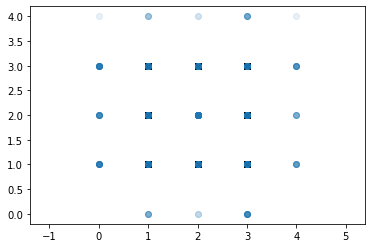

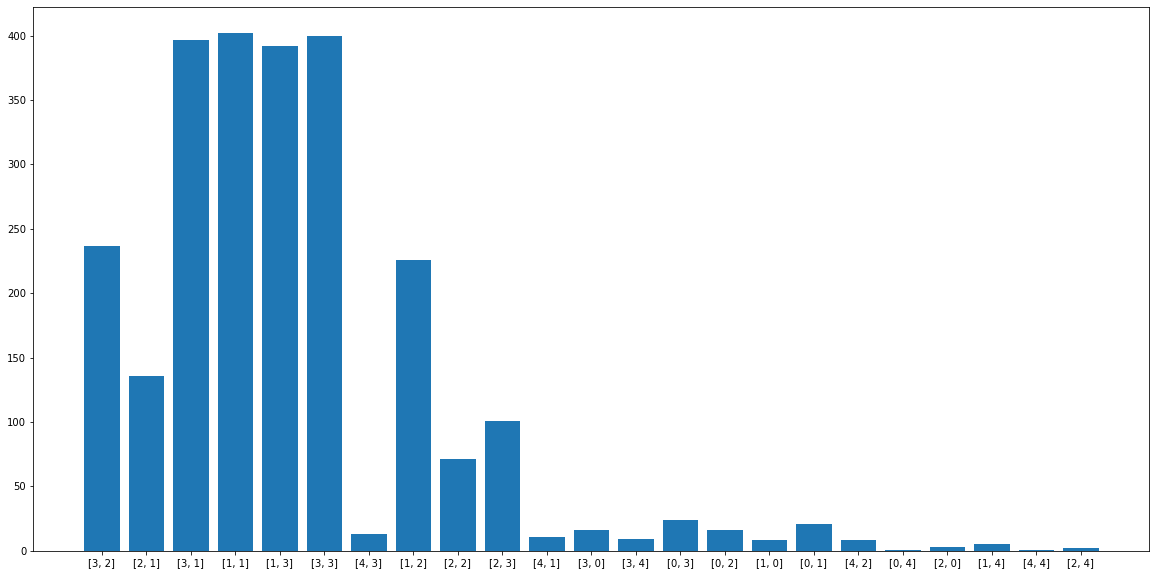

Processing Epoch 148
training start
Iteration 0, d real/fake loss 0.6498632431030273/0.6631889343261719 and g loss is 0.7756971120834351, NDiv loss 0.07917159050703049
Iteration 1, d real/fake loss 0.649935245513916/0.642227828502655 and g loss is 0.7471716403961182, NDiv loss 0.08128301054239273
Iteration 2, d real/fake loss 0.6494191884994507/0.6438214778900146 and g loss is 0.8249604105949402, NDiv loss 0.0689786747097969
Iteration 3, d real/fake loss 0.6488035917282104/0.6449355483055115 and g loss is 0.8404760956764221, NDiv loss 0.07654541730880737
Iteration 4, d real/fake loss 0.6481189727783203/0.662556529045105 and g loss is 0.7830030918121338, NDiv loss 0.07924699038267136


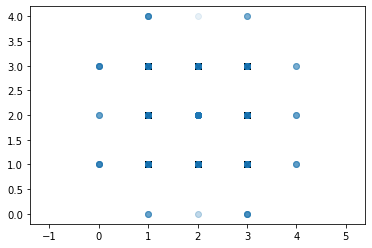

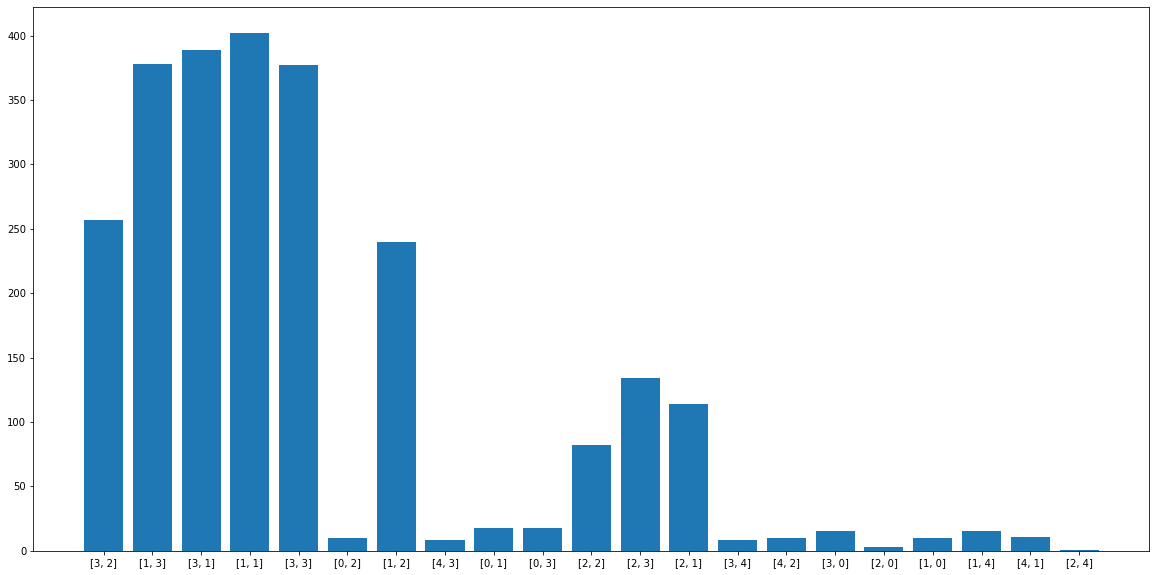

Processing Epoch 149
training start
Iteration 0, d real/fake loss 0.633121132850647/0.6423205137252808 and g loss is 0.7641749382019043, NDiv loss 0.0840950533747673
Iteration 1, d real/fake loss 0.6336238384246826/0.668013334274292 and g loss is 0.7306320071220398, NDiv loss 0.08026483654975891
Iteration 2, d real/fake loss 0.6342309713363647/0.6622141599655151 and g loss is 0.7952809929847717, NDiv loss 0.07220239192247391
Iteration 3, d real/fake loss 0.6347252726554871/0.6668882369995117 and g loss is 0.8008900880813599, NDiv loss 0.08007052540779114
Iteration 4, d real/fake loss 0.6352114677429199/0.6511059999465942 and g loss is 0.7872233390808105, NDiv loss 0.07622017711400986


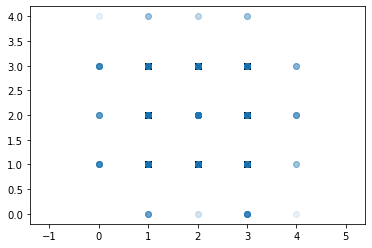

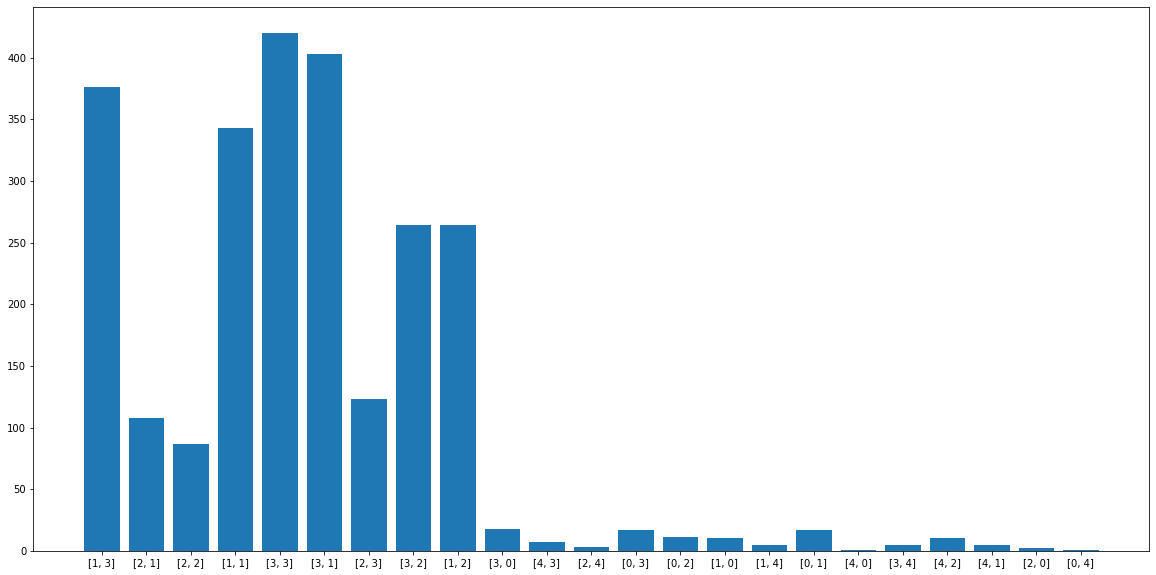

Processing Epoch 150
training start
Iteration 0, d real/fake loss 0.6579413414001465/0.672844648361206 and g loss is 0.7984654307365417, NDiv loss 0.07698646932840347
Iteration 1, d real/fake loss 0.6578630208969116/0.6600492000579834 and g loss is 0.8239350318908691, NDiv loss 0.07527972012758255
Iteration 2, d real/fake loss 0.6574293375015259/0.6408133506774902 and g loss is 0.7470316886901855, NDiv loss 0.07622357457876205
Iteration 3, d real/fake loss 0.6564958691596985/0.6807560920715332 and g loss is 0.8684984445571899, NDiv loss 0.08439565449953079
Iteration 4, d real/fake loss 0.6552786827087402/0.6714221835136414 and g loss is 0.7874178290367126, NDiv loss 0.08172344416379929


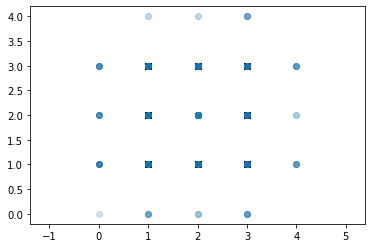

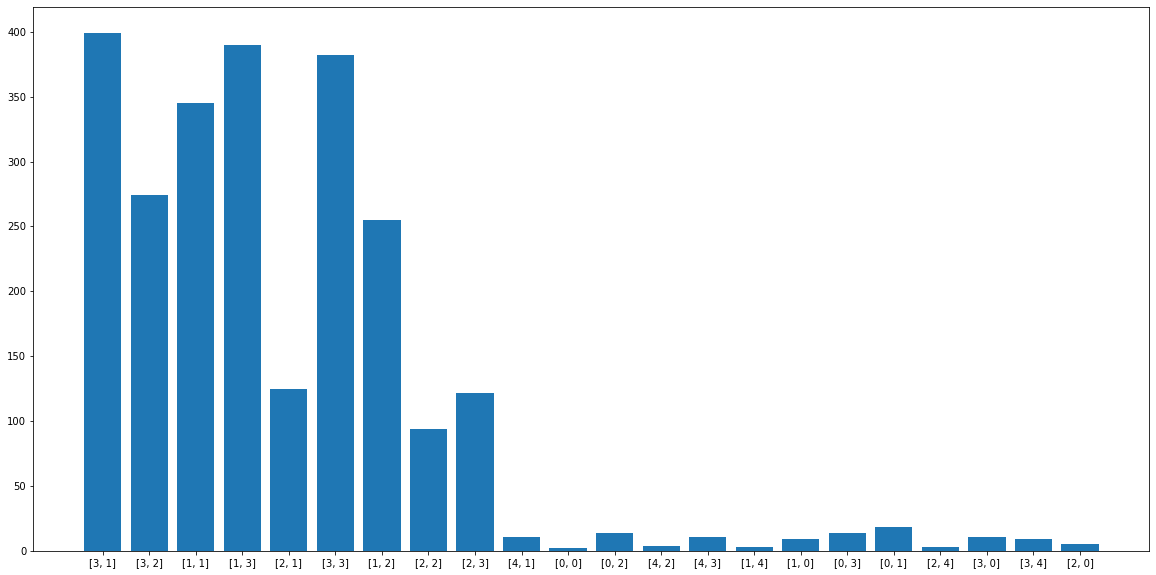

Processing Epoch 151
training start
Iteration 0, d real/fake loss 0.6407203078269958/0.690082848072052 and g loss is 0.8480550050735474, NDiv loss 0.07381092011928558
Iteration 1, d real/fake loss 0.6407215595245361/0.6675652265548706 and g loss is 0.8078573942184448, NDiv loss 0.07574649155139923
Iteration 2, d real/fake loss 0.640815019607544/0.6974214315414429 and g loss is 0.797302782535553, NDiv loss 0.07973804324865341
Iteration 3, d real/fake loss 0.6409579515457153/0.6636345982551575 and g loss is 0.7453299760818481, NDiv loss 0.08727814257144928
Iteration 4, d real/fake loss 0.6409979462623596/0.672844648361206 and g loss is 0.7870233058929443, NDiv loss 0.07768881320953369


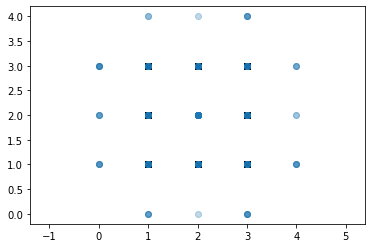

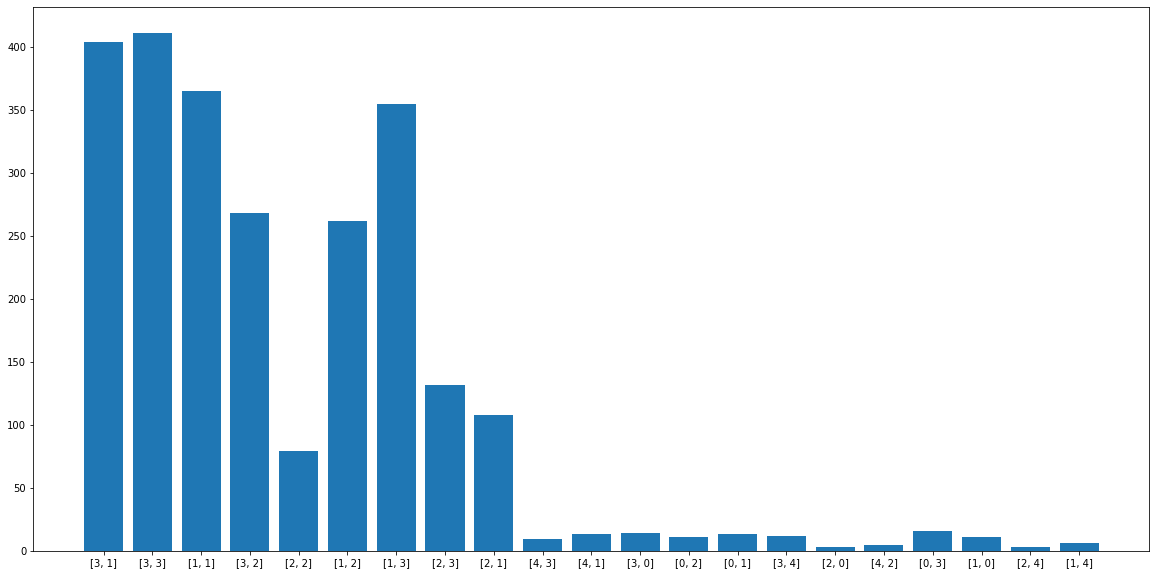

Processing Epoch 152
training start
Iteration 0, d real/fake loss 0.6478019952774048/0.6244049072265625 and g loss is 0.7858095169067383, NDiv loss 0.08212931454181671
Iteration 1, d real/fake loss 0.6472800970077515/0.6668527722358704 and g loss is 0.7882230281829834, NDiv loss 0.07710414379835129
Iteration 2, d real/fake loss 0.6466734409332275/0.676708459854126 and g loss is 0.8389665484428406, NDiv loss 0.08323639631271362
Iteration 3, d real/fake loss 0.6461203694343567/0.6556051969528198 and g loss is 0.8130293488502502, NDiv loss 0.07897398620843887
Iteration 4, d real/fake loss 0.645210862159729/0.6377699971199036 and g loss is 0.8049127459526062, NDiv loss 0.07216689735651016


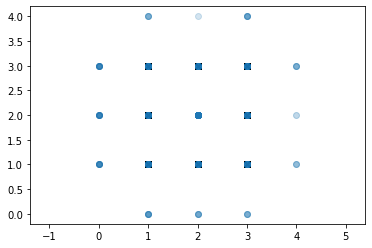

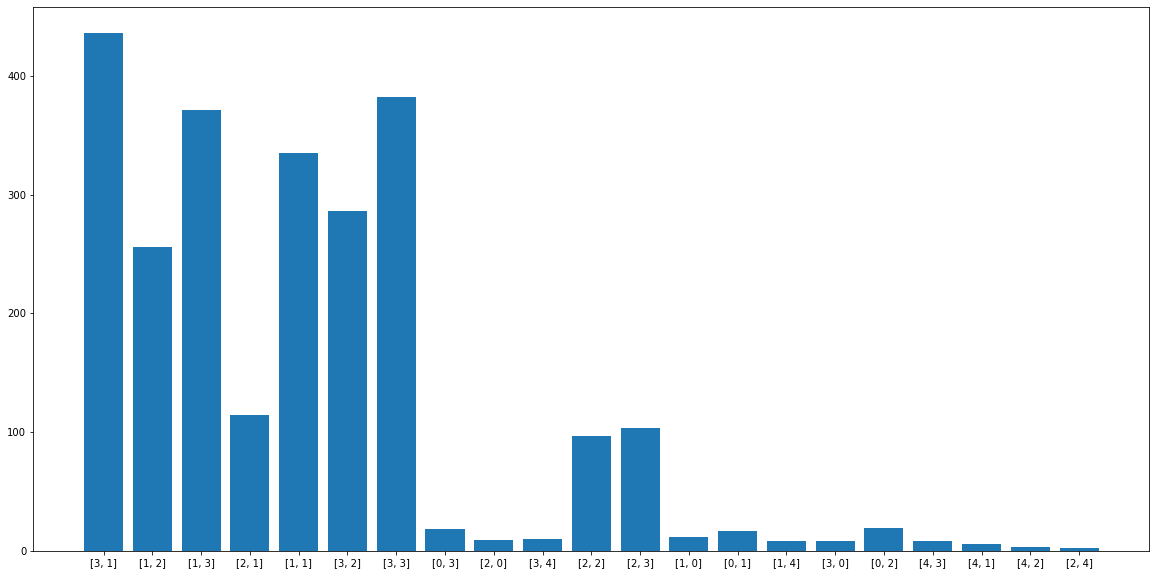

Processing Epoch 153
training start
Iteration 0, d real/fake loss 0.6581686735153198/0.6582801342010498 and g loss is 0.8264603018760681, NDiv loss 0.08057411760091782
Iteration 1, d real/fake loss 0.6579036116600037/0.6690784692764282 and g loss is 0.7886484265327454, NDiv loss 0.07583771646022797
Iteration 2, d real/fake loss 0.6573034524917603/0.6599996089935303 and g loss is 0.8325821161270142, NDiv loss 0.06469257920980453
Iteration 3, d real/fake loss 0.6564432382583618/0.6950734257698059 and g loss is 0.8228296041488647, NDiv loss 0.06753794103860855
Iteration 4, d real/fake loss 0.6555823087692261/0.6624453067779541 and g loss is 0.7409476637840271, NDiv loss 0.08015567809343338


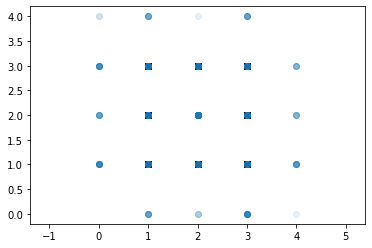

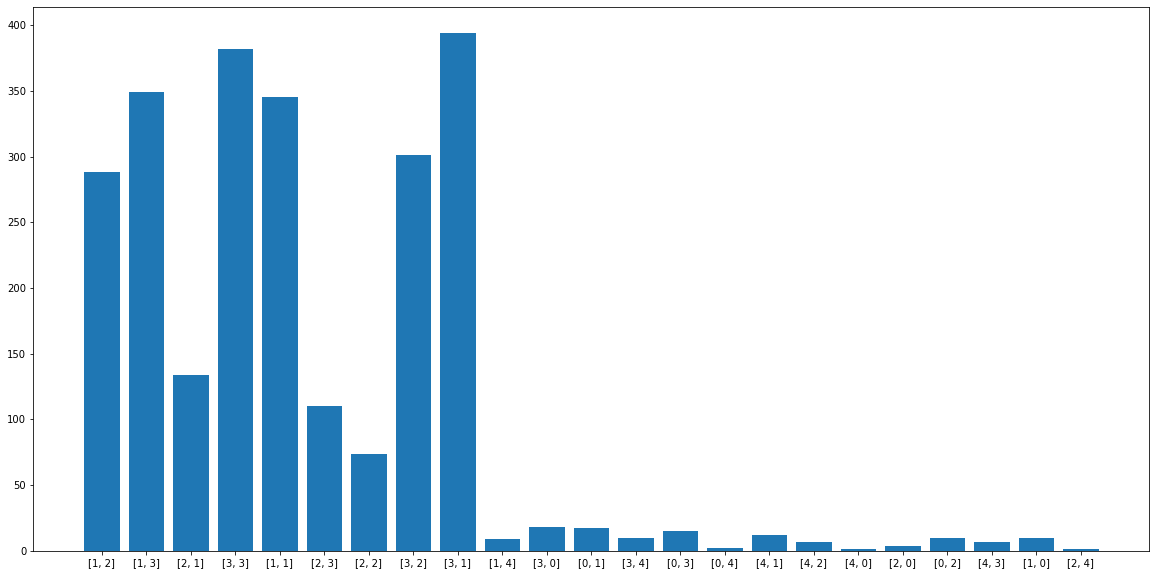

Processing Epoch 154
training start
Iteration 0, d real/fake loss 0.640619695186615/0.649067759513855 and g loss is 0.7831512689590454, NDiv loss 0.0763583704829216
Iteration 1, d real/fake loss 0.6399223804473877/0.628320574760437 and g loss is 0.7776304483413696, NDiv loss 0.07495468854904175
Iteration 2, d real/fake loss 0.6393415331840515/0.6658183336257935 and g loss is 0.8130298256874084, NDiv loss 0.0822024866938591
Iteration 3, d real/fake loss 0.6390756964683533/0.6468459367752075 and g loss is 0.7953259944915771, NDiv loss 0.0789722129702568
Iteration 4, d real/fake loss 0.6389163732528687/0.6653786301612854 and g loss is 0.8301169872283936, NDiv loss 0.07846829295158386


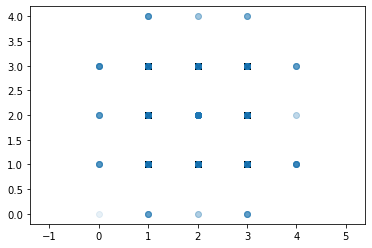

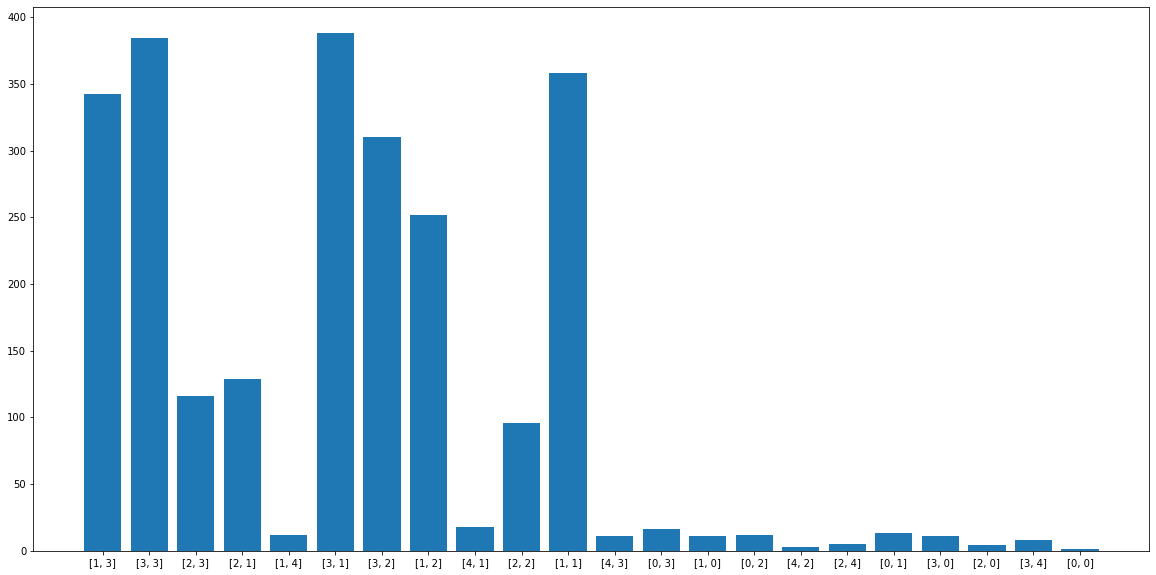

Processing Epoch 155
training start
Iteration 0, d real/fake loss 0.6339725255966187/0.6751412749290466 and g loss is 0.8134934902191162, NDiv loss 0.07630068808794022
Iteration 1, d real/fake loss 0.6349952220916748/0.652772068977356 and g loss is 0.7369347810745239, NDiv loss 0.08363394439220428
Iteration 2, d real/fake loss 0.6359313726425171/0.6511765122413635 and g loss is 0.8183110356330872, NDiv loss 0.07760312408208847
Iteration 3, d real/fake loss 0.636666476726532/0.6626347899436951 and g loss is 0.7686843872070312, NDiv loss 0.07153593748807907
Iteration 4, d real/fake loss 0.6373016238212585/0.6671860218048096 and g loss is 0.7585036754608154, NDiv loss 0.07933875173330307


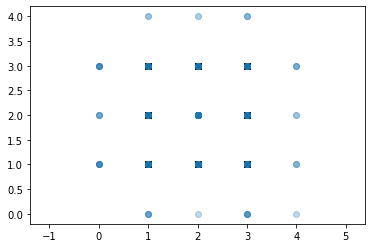

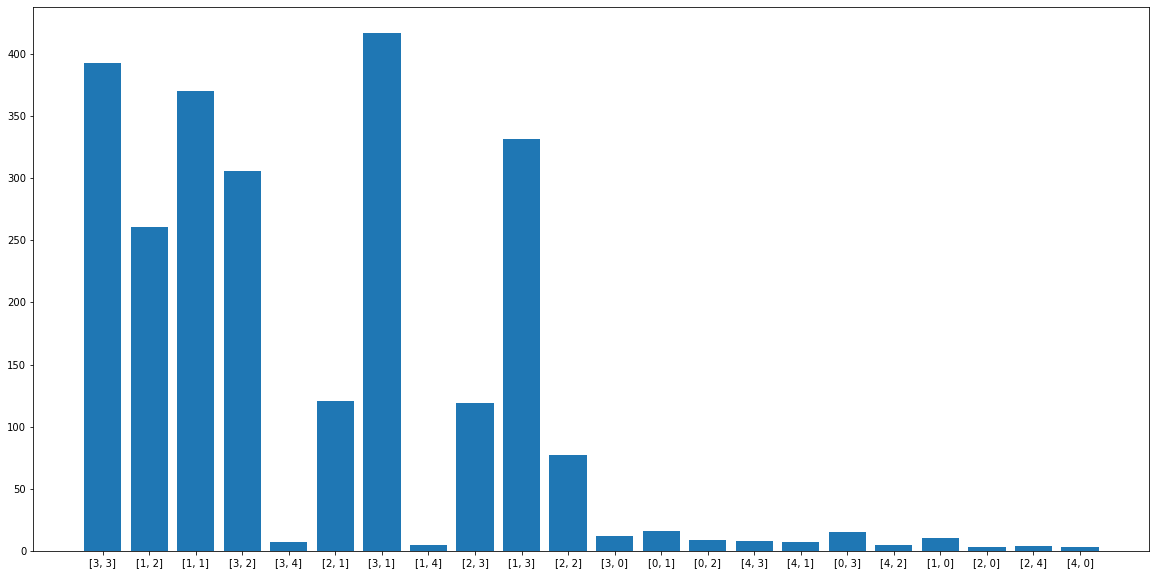

Processing Epoch 156
training start
Iteration 0, d real/fake loss 0.6562321782112122/0.645205020904541 and g loss is 0.7713379859924316, NDiv loss 0.07792644947767258
Iteration 1, d real/fake loss 0.6565807461738586/0.6289932727813721 and g loss is 0.8210641145706177, NDiv loss 0.0695716068148613
Iteration 2, d real/fake loss 0.656295120716095/0.6725967526435852 and g loss is 0.7755396962165833, NDiv loss 0.09111806750297546
Iteration 3, d real/fake loss 0.6557764410972595/0.6609649062156677 and g loss is 0.7855262160301208, NDiv loss 0.07786425948143005
Iteration 4, d real/fake loss 0.6549035310745239/0.6669610738754272 and g loss is 0.7995520830154419, NDiv loss 0.07970666885375977


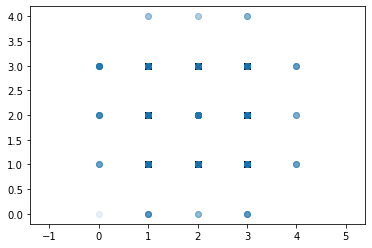

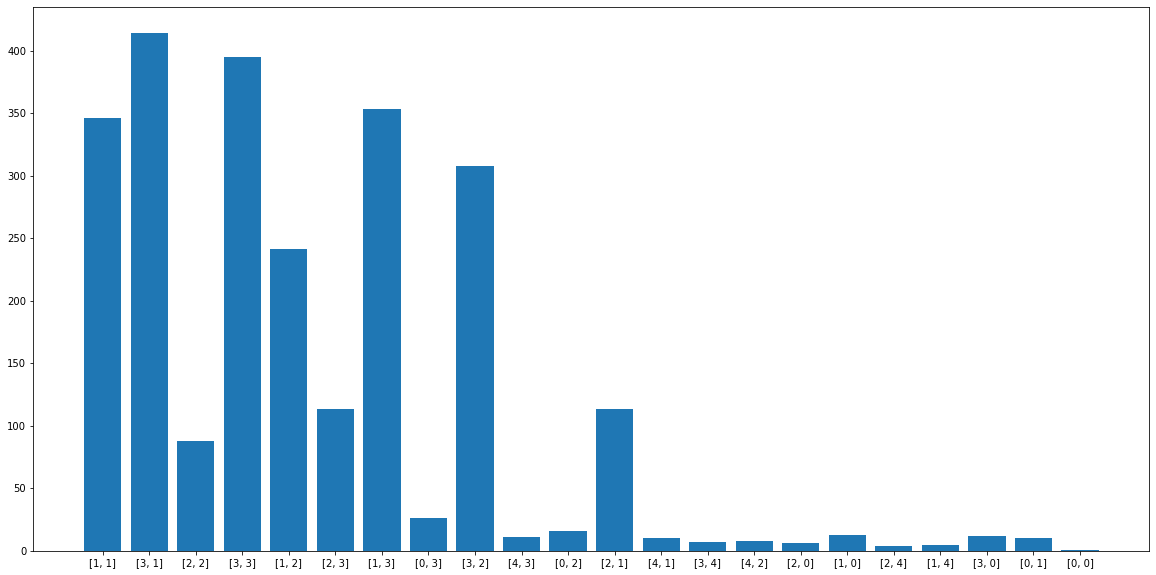

Processing Epoch 157
training start
Iteration 0, d real/fake loss 0.6504494547843933/0.6782066822052002 and g loss is 0.8358947038650513, NDiv loss 0.08393651992082596
Iteration 1, d real/fake loss 0.6494318246841431/0.6640208959579468 and g loss is 0.8587977290153503, NDiv loss 0.0760914534330368
Iteration 2, d real/fake loss 0.6483826637268066/0.6543086767196655 and g loss is 0.800040602684021, NDiv loss 0.07374948263168335
Iteration 3, d real/fake loss 0.6473578214645386/0.667756199836731 and g loss is 0.742652177810669, NDiv loss 0.07876399159431458
Iteration 4, d real/fake loss 0.6465022563934326/0.6517955660820007 and g loss is 0.9105944037437439, NDiv loss 0.0804167091846466


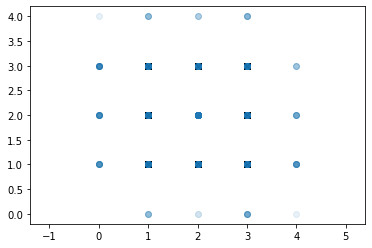

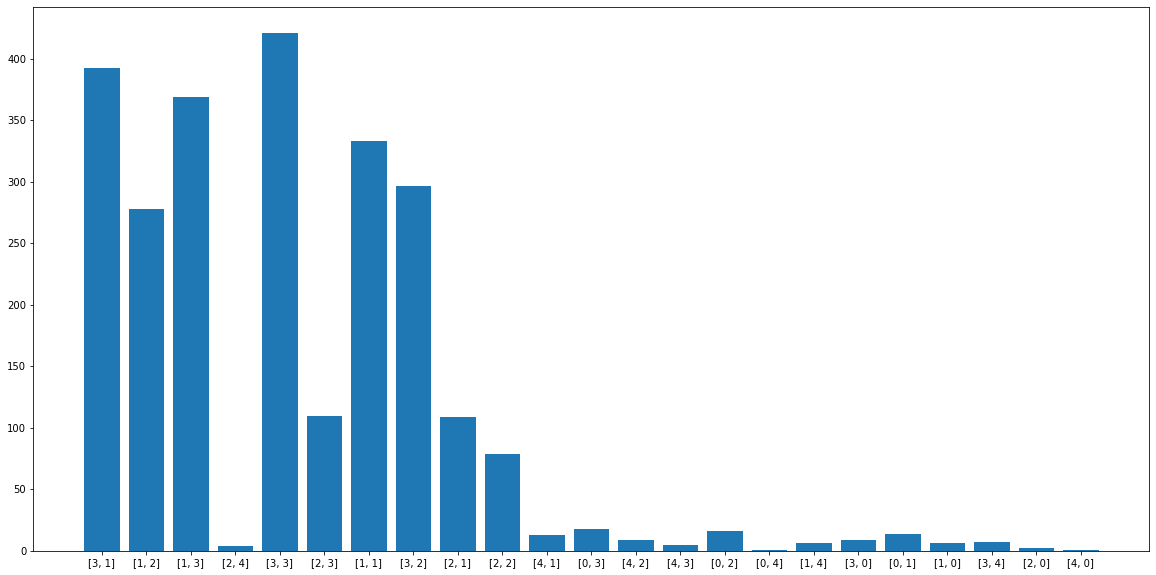

Processing Epoch 158
training start
Iteration 0, d real/fake loss 0.6512666940689087/0.6907812356948853 and g loss is 0.8355309367179871, NDiv loss 0.08788510411977768
Iteration 1, d real/fake loss 0.650924026966095/0.6521077156066895 and g loss is 0.8231093287467957, NDiv loss 0.07858555763959885
Iteration 2, d real/fake loss 0.650616466999054/0.7094094157218933 and g loss is 0.8392453193664551, NDiv loss 0.08962288498878479
Iteration 3, d real/fake loss 0.6505433917045593/0.6694586277008057 and g loss is 0.8450914025306702, NDiv loss 0.07842967659235
Iteration 4, d real/fake loss 0.6503888368606567/0.6801748871803284 and g loss is 0.8059070110321045, NDiv loss 0.08085460215806961


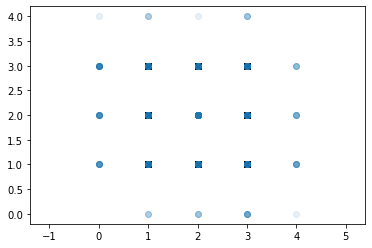

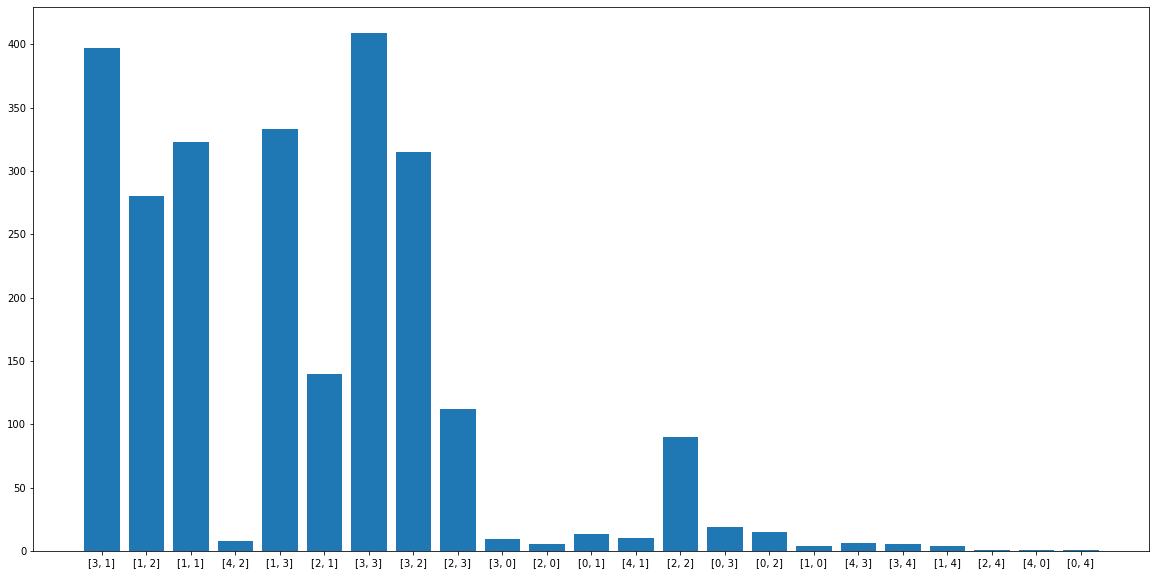

Processing Epoch 159
training start
Iteration 0, d real/fake loss 0.6538591384887695/0.6911240816116333 and g loss is 0.7874888181686401, NDiv loss 0.08091060817241669
Iteration 1, d real/fake loss 0.6540073156356812/0.6248700618743896 and g loss is 0.8189046382904053, NDiv loss 0.07812026888132095
Iteration 2, d real/fake loss 0.6536248326301575/0.708882749080658 and g loss is 0.7514004707336426, NDiv loss 0.08121545612812042
Iteration 3, d real/fake loss 0.6533958911895752/0.6322648525238037 and g loss is 0.7649937868118286, NDiv loss 0.07634759694337845
Iteration 4, d real/fake loss 0.6530159115791321/0.6599680185317993 and g loss is 0.7823272943496704, NDiv loss 0.07435750961303711


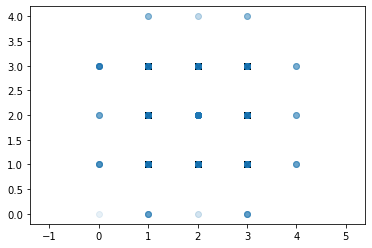

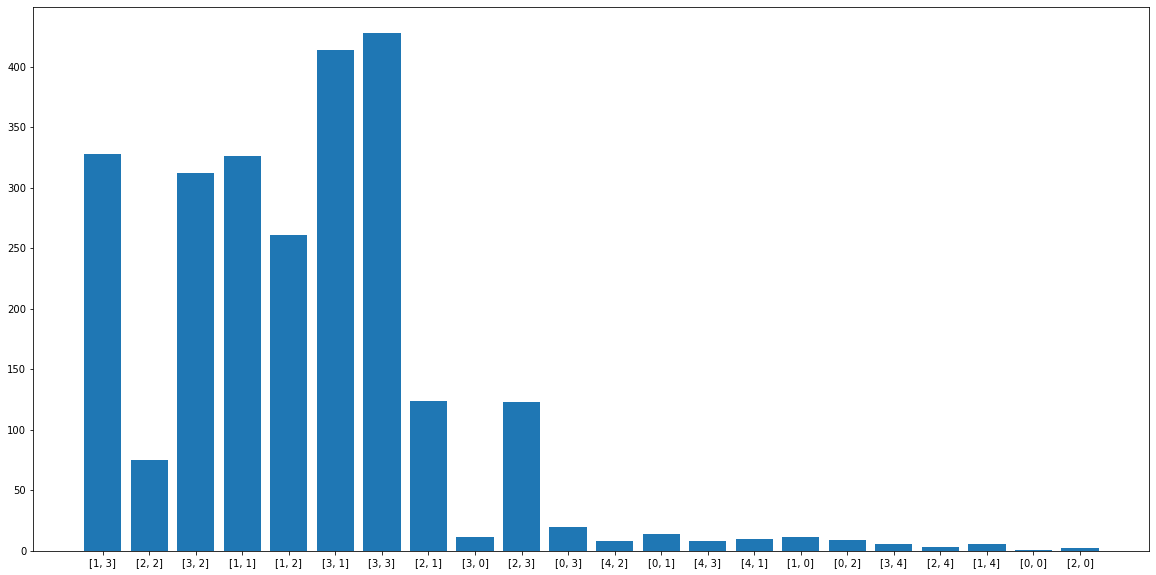

Processing Epoch 160
training start
Iteration 0, d real/fake loss 0.6510986685752869/0.6943683624267578 and g loss is 0.7704274654388428, NDiv loss 0.07698260247707367
Iteration 1, d real/fake loss 0.6507997512817383/0.6853904128074646 and g loss is 0.7719806432723999, NDiv loss 0.08642558008432388
Iteration 2, d real/fake loss 0.6506585478782654/0.6668047308921814 and g loss is 0.7818937301635742, NDiv loss 0.08160316199064255
Iteration 3, d real/fake loss 0.6504051685333252/0.6722182035446167 and g loss is 0.7841475009918213, NDiv loss 0.0872734785079956
Iteration 4, d real/fake loss 0.6501212120056152/0.673193633556366 and g loss is 0.8077132105827332, NDiv loss 0.08374813199043274


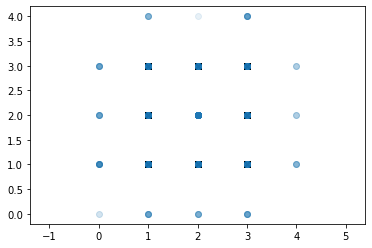

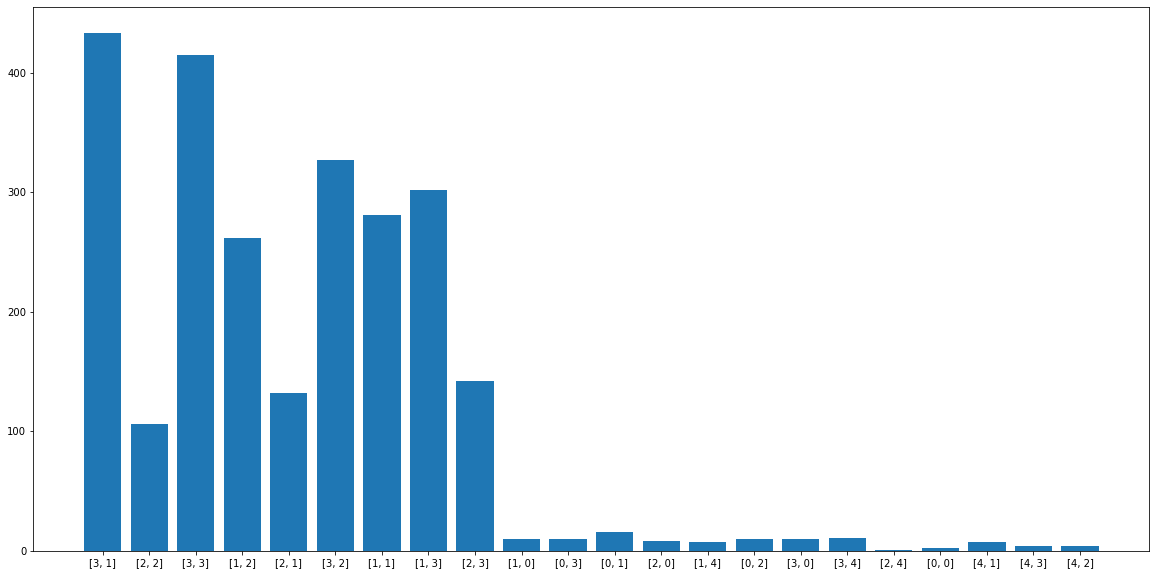

Processing Epoch 161
training start
Iteration 0, d real/fake loss 0.6558464765548706/0.7028412222862244 and g loss is 0.8076927661895752, NDiv loss 0.08674337714910507
Iteration 1, d real/fake loss 0.6558457612991333/0.6624382734298706 and g loss is 0.795700192451477, NDiv loss 0.07402754575014114
Iteration 2, d real/fake loss 0.6554734110832214/0.6699599027633667 and g loss is 0.777789831161499, NDiv loss 0.08221336454153061
Iteration 3, d real/fake loss 0.6551589369773865/0.6530075669288635 and g loss is 0.7930908799171448, NDiv loss 0.07778307795524597
Iteration 4, d real/fake loss 0.6548858880996704/0.6524448394775391 and g loss is 0.8051056861877441, NDiv loss 0.08288325369358063


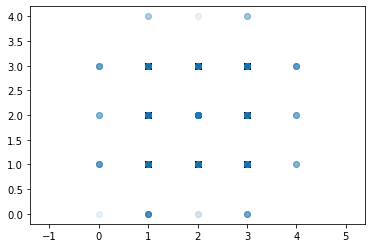

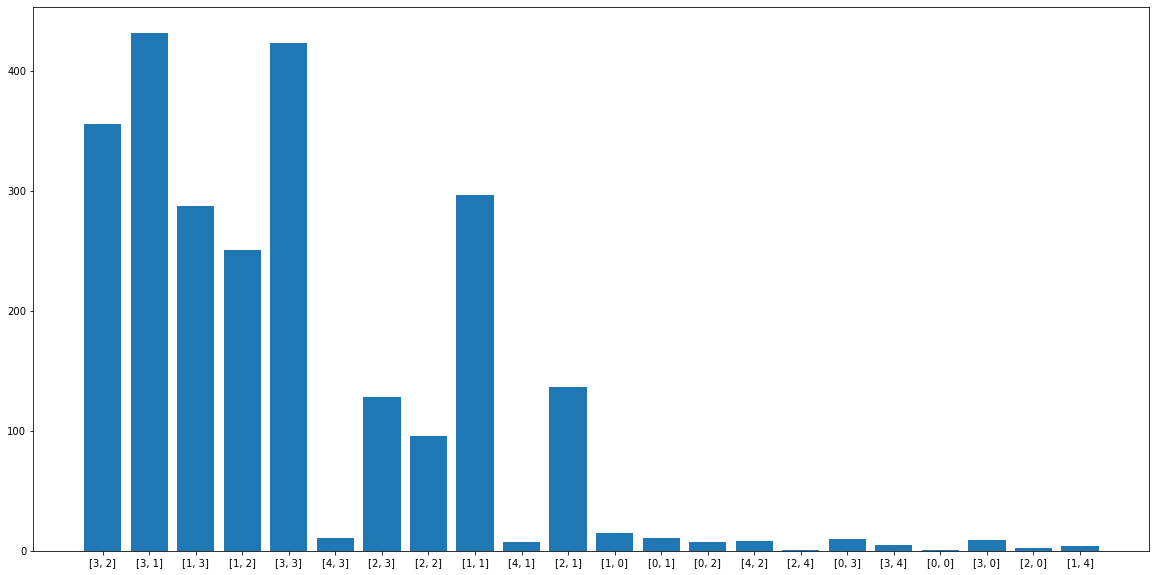

Processing Epoch 162
training start
Iteration 0, d real/fake loss 0.6627463102340698/0.642315685749054 and g loss is 0.7595163583755493, NDiv loss 0.08468735218048096
Iteration 1, d real/fake loss 0.662412166595459/0.6510974168777466 and g loss is 0.7911162376403809, NDiv loss 0.0777958333492279
Iteration 2, d real/fake loss 0.6616160273551941/0.6543871164321899 and g loss is 0.8553513288497925, NDiv loss 0.07673316448926926
Iteration 3, d real/fake loss 0.6607502102851868/0.688610315322876 and g loss is 0.7637156248092651, NDiv loss 0.07787947356700897
Iteration 4, d real/fake loss 0.660067617893219/0.6801828145980835 and g loss is 0.7572349905967712, NDiv loss 0.08213239163160324


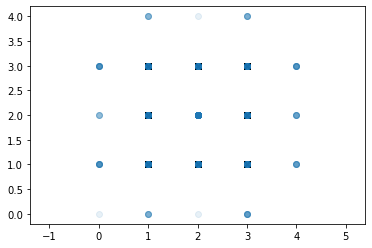

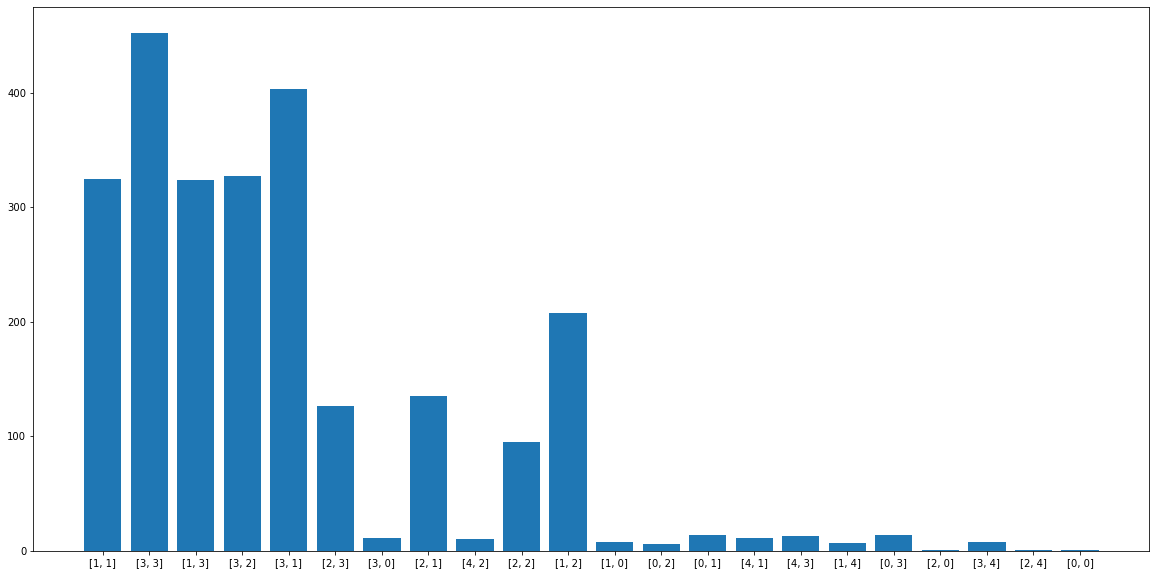

Processing Epoch 163
training start
Iteration 0, d real/fake loss 0.6240819692611694/0.6650350689888 and g loss is 0.8176101446151733, NDiv loss 0.08058609068393707
Iteration 1, d real/fake loss 0.6243479251861572/0.6561920046806335 and g loss is 0.8293670415878296, NDiv loss 0.0710611417889595
Iteration 2, d real/fake loss 0.6251624822616577/0.7036513090133667 and g loss is 0.7909757494926453, NDiv loss 0.07947716116905212
Iteration 3, d real/fake loss 0.6265476942062378/0.6595830917358398 and g loss is 0.906395435333252, NDiv loss 0.08218244463205338
Iteration 4, d real/fake loss 0.6279940605163574/0.6898882389068604 and g loss is 0.795969545841217, NDiv loss 0.08514203131198883


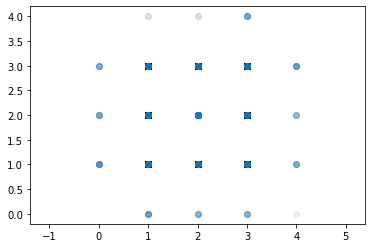

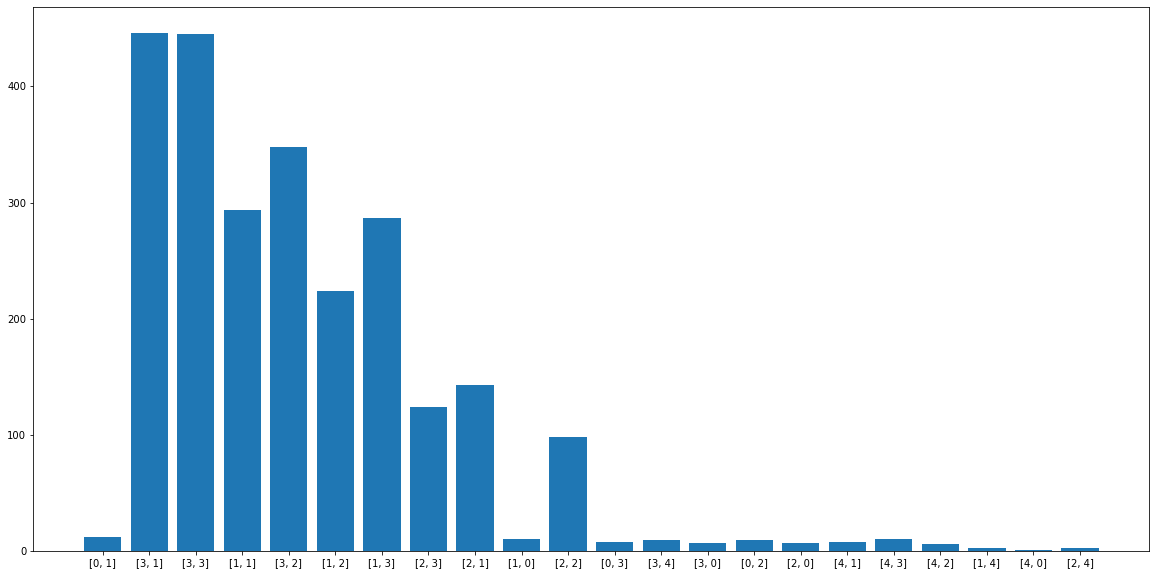

Processing Epoch 164
training start
Iteration 0, d real/fake loss 0.6400716304779053/0.6690923571586609 and g loss is 0.866404116153717, NDiv loss 0.0744498148560524
Iteration 1, d real/fake loss 0.6417893767356873/0.6374809741973877 and g loss is 0.878662109375, NDiv loss 0.07384737581014633
Iteration 2, d real/fake loss 0.6428810358047485/0.6541697978973389 and g loss is 0.8065089583396912, NDiv loss 0.1000518947839737
Iteration 3, d real/fake loss 0.6436924338340759/0.6413899660110474 and g loss is 0.7936141490936279, NDiv loss 0.072263702750206
Iteration 4, d real/fake loss 0.6442592144012451/0.6514831185340881 and g loss is 0.7876687049865723, NDiv loss 0.08161970973014832


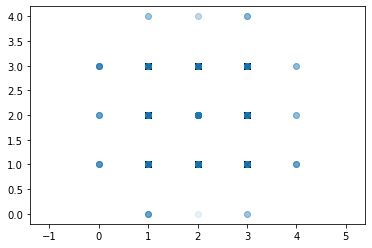

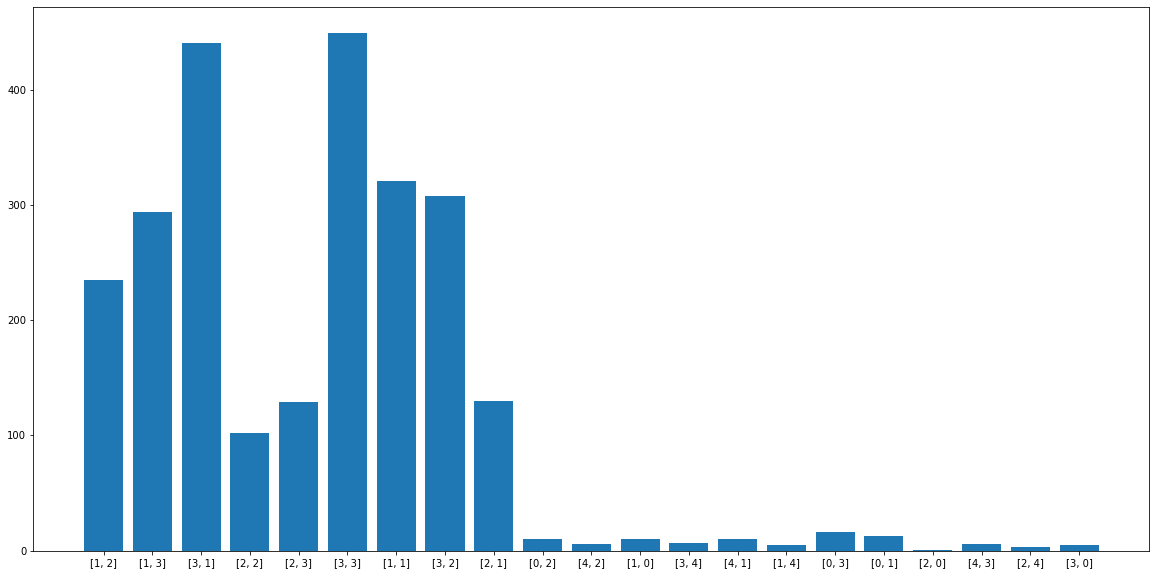

Processing Epoch 165
training start
Iteration 0, d real/fake loss 0.6530512571334839/0.6758017539978027 and g loss is 0.7853427529335022, NDiv loss 0.08400993049144745
Iteration 1, d real/fake loss 0.6530342102050781/0.6406568884849548 and g loss is 0.8137536644935608, NDiv loss 0.07817641645669937
Iteration 2, d real/fake loss 0.6526956558227539/0.6382544040679932 and g loss is 0.8502830862998962, NDiv loss 0.08064720034599304
Iteration 3, d real/fake loss 0.652199923992157/0.6697916388511658 and g loss is 0.7961950302124023, NDiv loss 0.07431242614984512
Iteration 4, d real/fake loss 0.6516693830490112/0.6847212910652161 and g loss is 0.8419585824012756, NDiv loss 0.07735338062047958


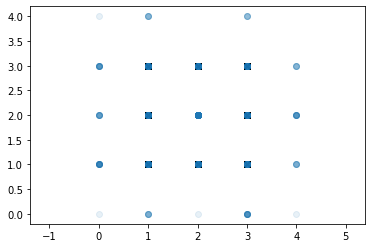

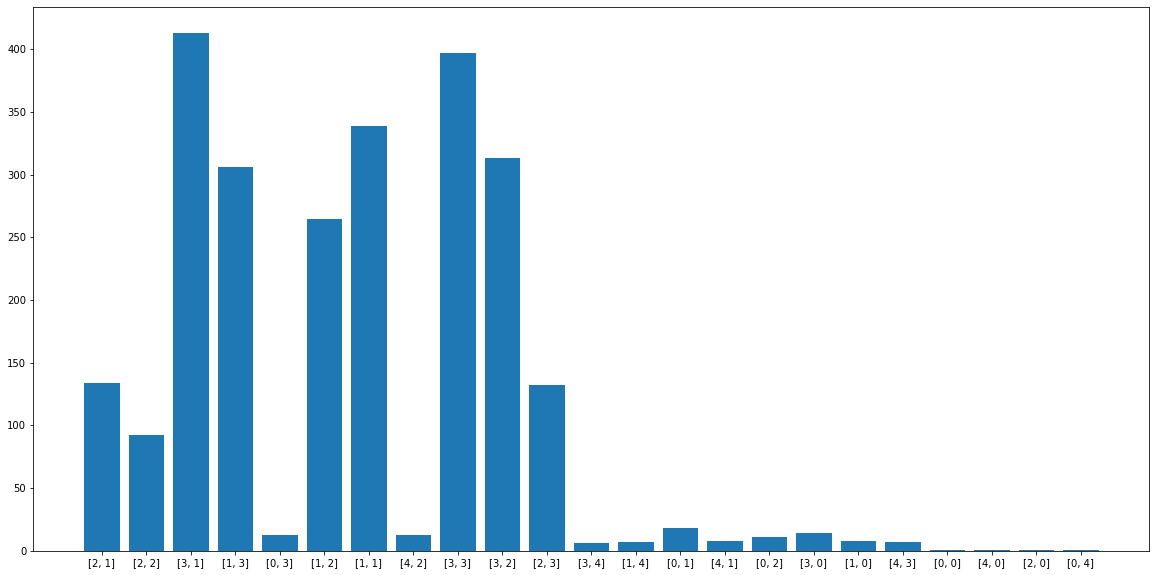

Processing Epoch 166
training start
Iteration 0, d real/fake loss 0.6648411154747009/0.6685681939125061 and g loss is 0.795160710811615, NDiv loss 0.07666271924972534
Iteration 1, d real/fake loss 0.6638297438621521/0.6527507901191711 and g loss is 0.8024495840072632, NDiv loss 0.07597951591014862
Iteration 2, d real/fake loss 0.6626294255256653/0.671725332736969 and g loss is 0.7782454490661621, NDiv loss 0.08390574157238007
Iteration 3, d real/fake loss 0.6615342497825623/0.6826761960983276 and g loss is 0.7733569741249084, NDiv loss 0.08360130339860916
Iteration 4, d real/fake loss 0.6603238582611084/0.6656427383422852 and g loss is 0.7758035659790039, NDiv loss 0.07865077257156372


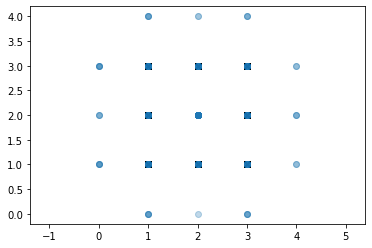

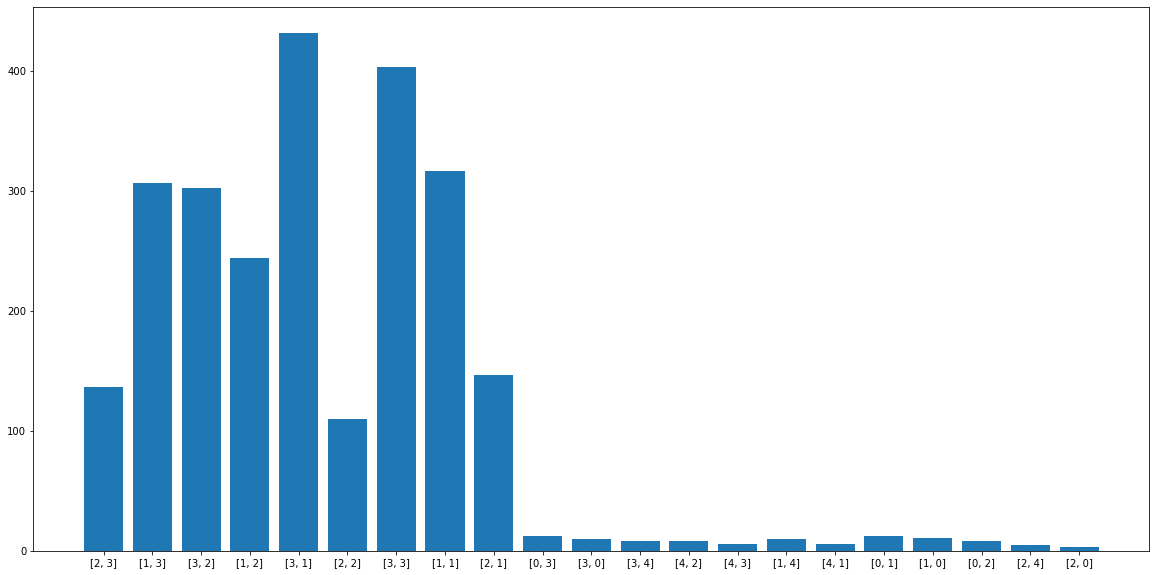

Processing Epoch 167
training start
Iteration 0, d real/fake loss 0.6451765298843384/0.6612727642059326 and g loss is 0.7828426957130432, NDiv loss 0.0727052167057991
Iteration 1, d real/fake loss 0.6442664861679077/0.6586552858352661 and g loss is 0.8040696382522583, NDiv loss 0.0810188353061676
Iteration 2, d real/fake loss 0.6434112787246704/0.6718295812606812 and g loss is 0.8576410412788391, NDiv loss 0.07619065791368484
Iteration 3, d real/fake loss 0.6428810954093933/0.6863980293273926 and g loss is 0.7882343530654907, NDiv loss 0.0772155299782753
Iteration 4, d real/fake loss 0.6424607038497925/0.6689732670783997 and g loss is 0.7739109992980957, NDiv loss 0.07582320272922516


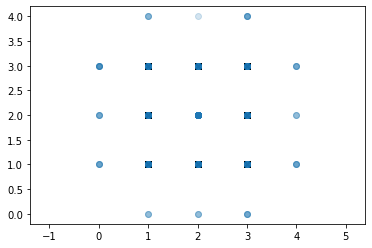

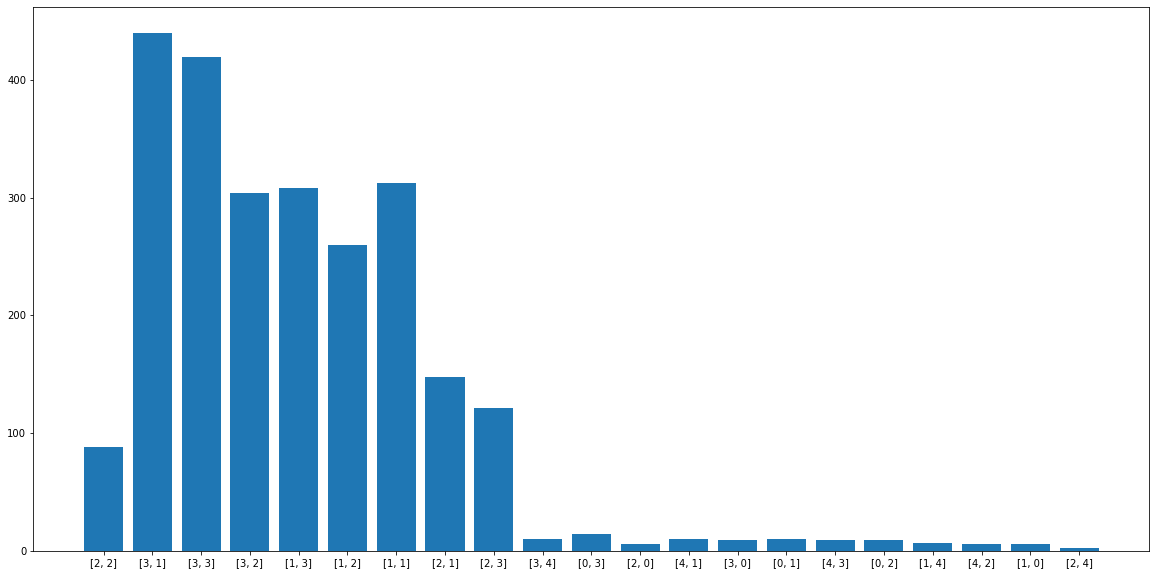

Processing Epoch 168
training start
Iteration 0, d real/fake loss 0.654497504234314/0.6849483847618103 and g loss is 0.737569272518158, NDiv loss 0.08076593279838562
Iteration 1, d real/fake loss 0.6541517376899719/0.6888891458511353 and g loss is 0.7538101077079773, NDiv loss 0.0749562531709671
Iteration 2, d real/fake loss 0.6536403894424438/0.6788216829299927 and g loss is 0.7729672193527222, NDiv loss 0.07346965372562408
Iteration 3, d real/fake loss 0.6527436375617981/0.651570200920105 and g loss is 0.7733138799667358, NDiv loss 0.08083439618349075
Iteration 4, d real/fake loss 0.6516531705856323/0.6634057760238647 and g loss is 0.8129513263702393, NDiv loss 0.0802253931760788


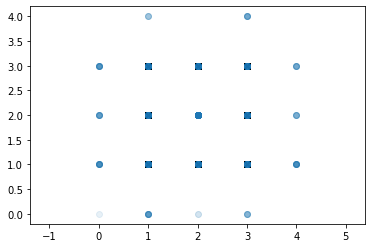

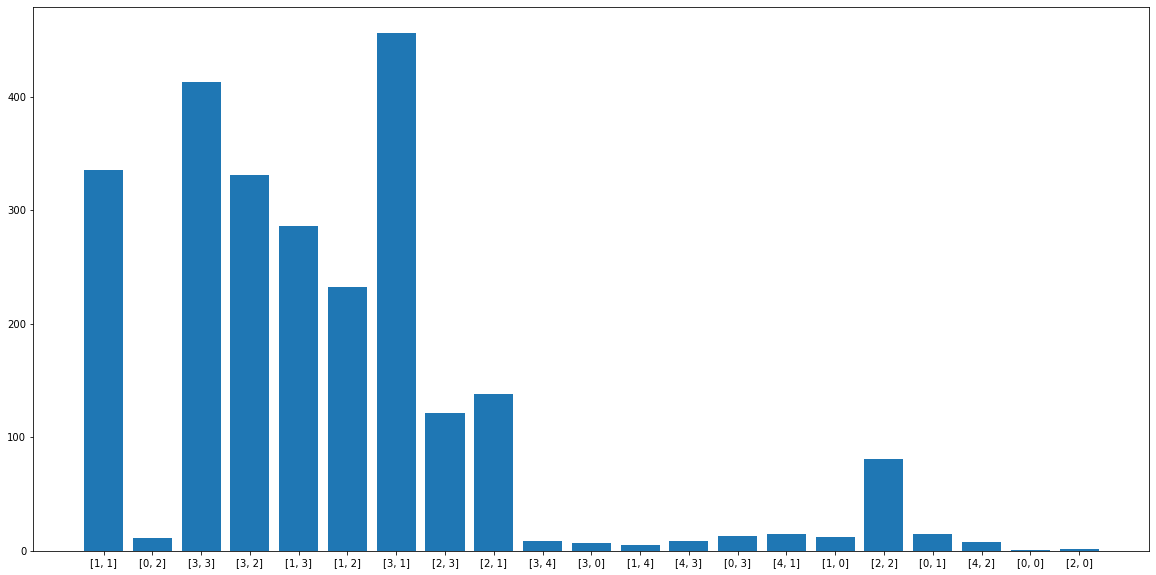

Processing Epoch 169
training start
Iteration 0, d real/fake loss 0.6425373554229736/0.6852302551269531 and g loss is 0.7241218686103821, NDiv loss 0.08328314125537872
Iteration 1, d real/fake loss 0.642267644405365/0.6580909490585327 and g loss is 0.7751615047454834, NDiv loss 0.08038701117038727
Iteration 2, d real/fake loss 0.6421558856964111/0.6942070722579956 and g loss is 0.7573499083518982, NDiv loss 0.0710931345820427
Iteration 3, d real/fake loss 0.6422733068466187/0.7120906114578247 and g loss is 0.8390655517578125, NDiv loss 0.08756104856729507
Iteration 4, d real/fake loss 0.6428806185722351/0.651447057723999 and g loss is 0.769750714302063, NDiv loss 0.07977417856454849


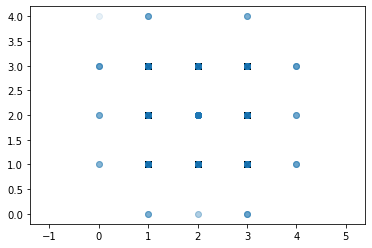

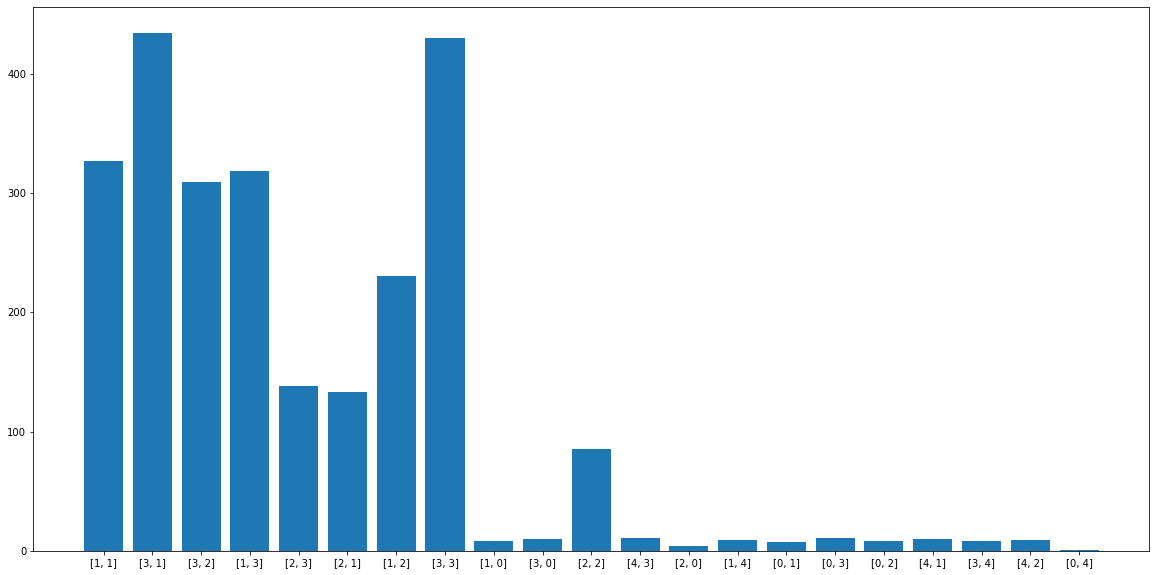

Processing Epoch 170
training start
Iteration 0, d real/fake loss 0.6515772938728333/0.662260890007019 and g loss is 0.7710306644439697, NDiv loss 0.07370523363351822
Iteration 1, d real/fake loss 0.6513303518295288/0.638851523399353 and g loss is 0.7923518419265747, NDiv loss 0.08647802472114563
Iteration 2, d real/fake loss 0.6507226228713989/0.6942609548568726 and g loss is 0.7880385518074036, NDiv loss 0.08015939593315125
Iteration 3, d real/fake loss 0.6502319574356079/0.6836000084877014 and g loss is 0.8436477780342102, NDiv loss 0.07111391425132751
Iteration 4, d real/fake loss 0.6497593522071838/0.6561166048049927 and g loss is 0.7811067700386047, NDiv loss 0.07792557775974274


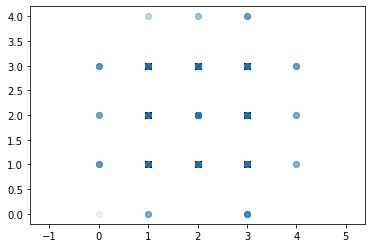

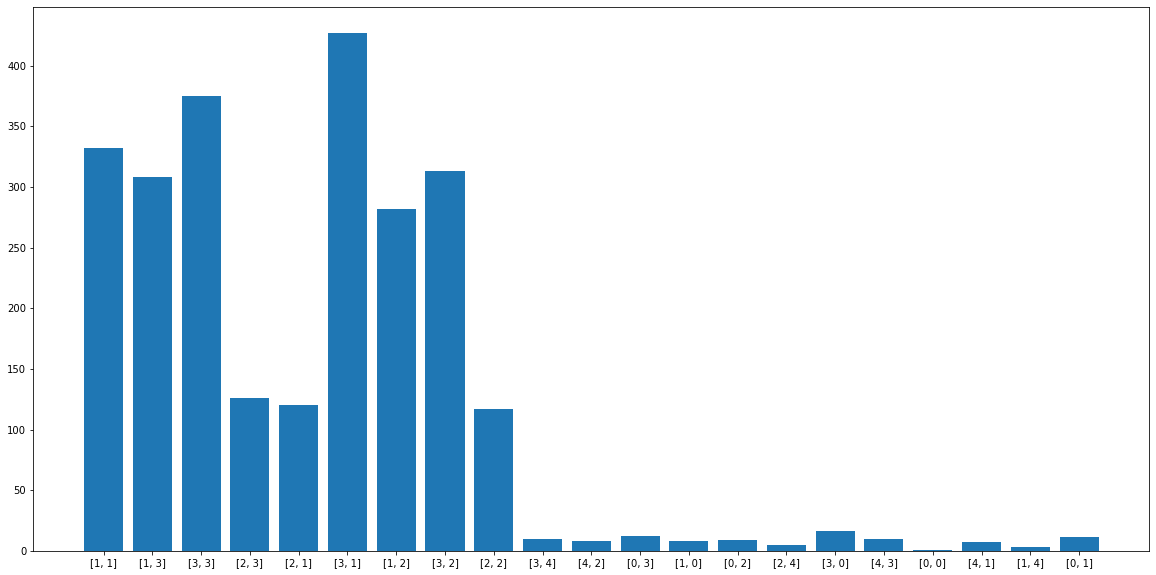

Processing Epoch 171
training start
Iteration 0, d real/fake loss 0.6835600137710571/0.6716166734695435 and g loss is 0.7562200427055359, NDiv loss 0.08008367568254471
Iteration 1, d real/fake loss 0.6826462745666504/0.6475497484207153 and g loss is 0.7547592520713806, NDiv loss 0.07348214089870453
Iteration 2, d real/fake loss 0.6809283494949341/0.6705763936042786 and g loss is 0.7885276079177856, NDiv loss 0.0782499685883522
Iteration 3, d real/fake loss 0.6787381172180176/0.6604430079460144 and g loss is 0.7780926823616028, NDiv loss 0.07096583396196365
Iteration 4, d real/fake loss 0.6759702563285828/0.6998056769371033 and g loss is 0.7771364450454712, NDiv loss 0.07601820677518845


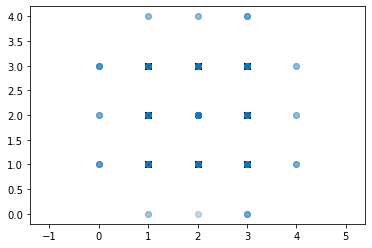

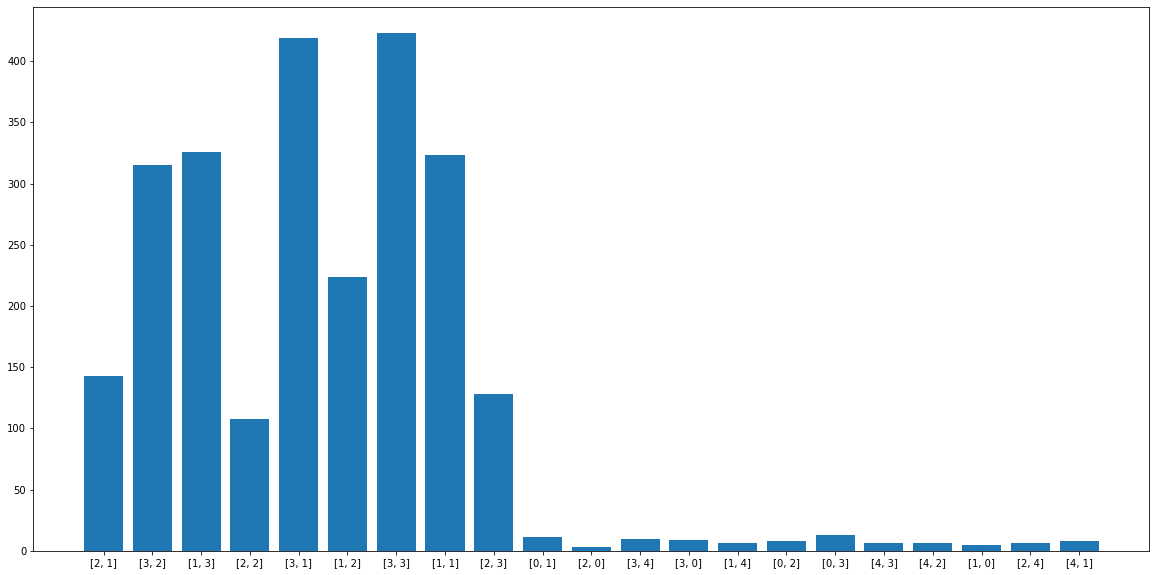

Processing Epoch 172
training start
Iteration 0, d real/fake loss 0.6511011719703674/0.6801475882530212 and g loss is 0.7666488289833069, NDiv loss 0.08964880555868149
Iteration 1, d real/fake loss 0.6492804288864136/0.6421858072280884 and g loss is 0.783061146736145, NDiv loss 0.07518962770700455
Iteration 2, d real/fake loss 0.6475750803947449/0.6662463545799255 and g loss is 0.8304575681686401, NDiv loss 0.07658731937408447
Iteration 3, d real/fake loss 0.6462639570236206/0.6548777222633362 and g loss is 0.7693565487861633, NDiv loss 0.07253974676132202
Iteration 4, d real/fake loss 0.645374059677124/0.6920584440231323 and g loss is 0.7264819145202637, NDiv loss 0.07940643280744553


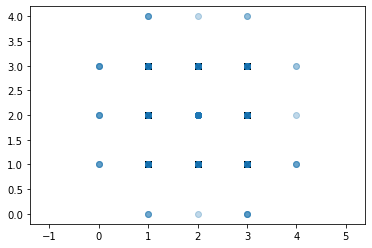

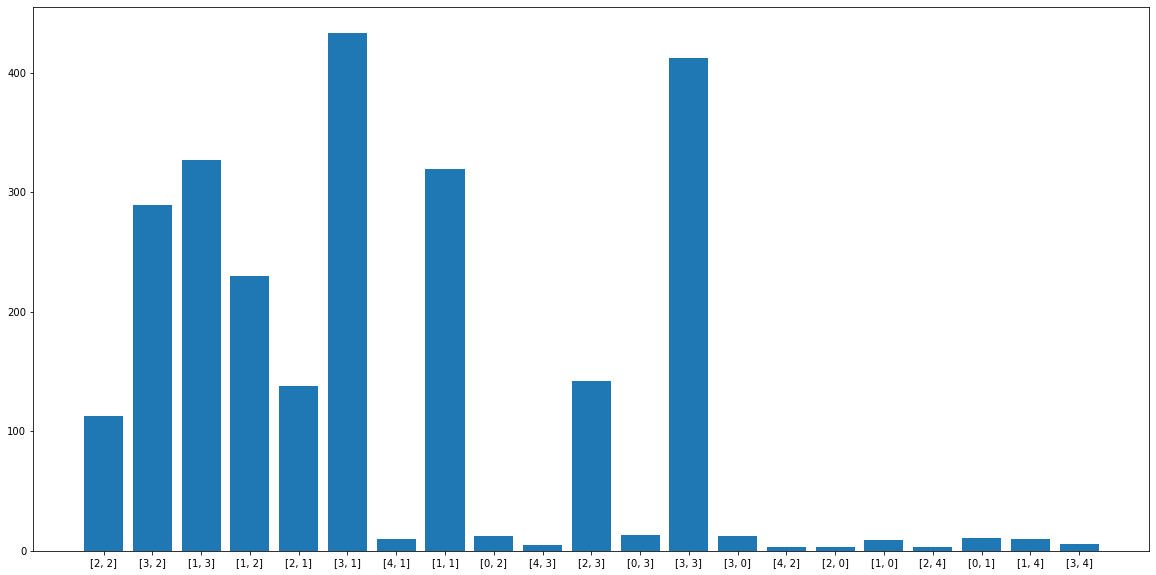

Processing Epoch 173
training start
Iteration 0, d real/fake loss 0.6434769630432129/0.6688442826271057 and g loss is 0.7977972030639648, NDiv loss 0.07555758953094482
Iteration 1, d real/fake loss 0.6432269811630249/0.6983349323272705 and g loss is 0.794335126876831, NDiv loss 0.0720890685915947
Iteration 2, d real/fake loss 0.6435644626617432/0.6602863073348999 and g loss is 0.7644840478897095, NDiv loss 0.08113142848014832
Iteration 3, d real/fake loss 0.6438801884651184/0.679845929145813 and g loss is 0.7694035768508911, NDiv loss 0.08222727477550507
Iteration 4, d real/fake loss 0.6443493366241455/0.6383715867996216 and g loss is 0.7107641696929932, NDiv loss 0.07257135212421417


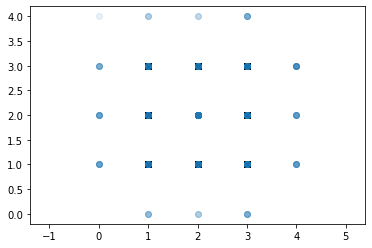

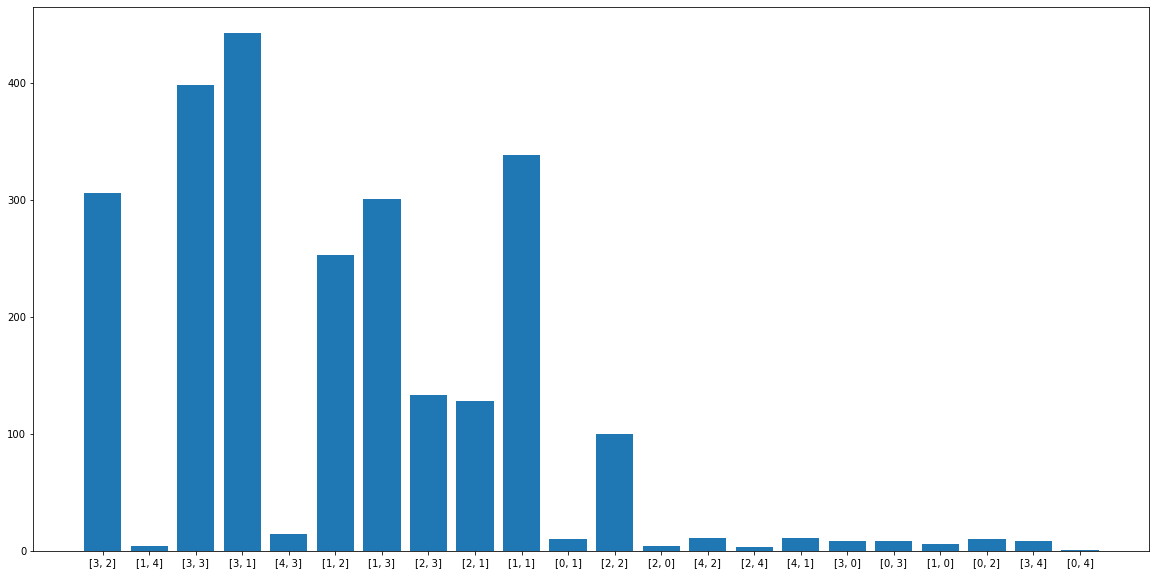

Processing Epoch 174
training start
Iteration 0, d real/fake loss 0.6390880346298218/0.6721282005310059 and g loss is 0.7662650346755981, NDiv loss 0.07698734849691391
Iteration 1, d real/fake loss 0.6401901245117188/0.669466495513916 and g loss is 0.8280305862426758, NDiv loss 0.07793886214494705
Iteration 2, d real/fake loss 0.6410590410232544/0.6664130687713623 and g loss is 0.795315682888031, NDiv loss 0.07359235733747482
Iteration 3, d real/fake loss 0.6418248414993286/0.6614811420440674 and g loss is 0.7790819406509399, NDiv loss 0.0636281967163086
Iteration 4, d real/fake loss 0.6422415971755981/0.6785268783569336 and g loss is 0.8119385242462158, NDiv loss 0.07880711555480957


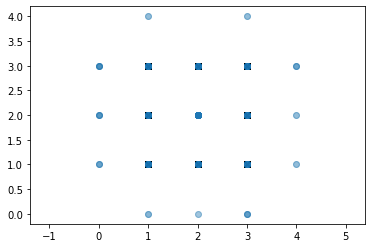

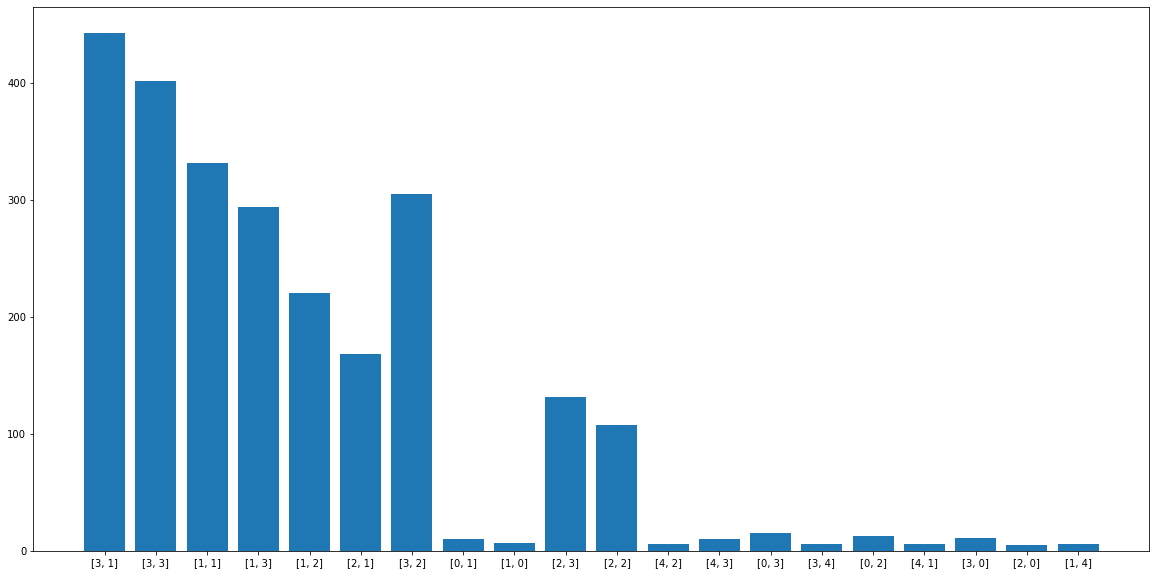

Processing Epoch 175
training start
Iteration 0, d real/fake loss 0.6381587982177734/0.6617593765258789 and g loss is 0.8081051111221313, NDiv loss 0.07386132329702377
Iteration 1, d real/fake loss 0.6391066312789917/0.6685194373130798 and g loss is 0.8152848482131958, NDiv loss 0.07751249521970749
Iteration 2, d real/fake loss 0.640140950679779/0.6409924626350403 and g loss is 0.8012020587921143, NDiv loss 0.0856078639626503
Iteration 3, d real/fake loss 0.6409386992454529/0.6235963106155396 and g loss is 0.7969332933425903, NDiv loss 0.07752425968647003
Iteration 4, d real/fake loss 0.6412258148193359/0.6670583486557007 and g loss is 0.8236421346664429, NDiv loss 0.07371611893177032


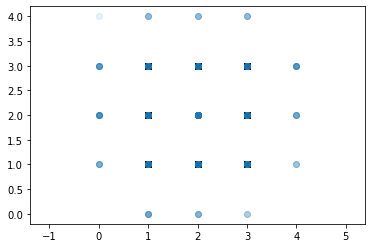

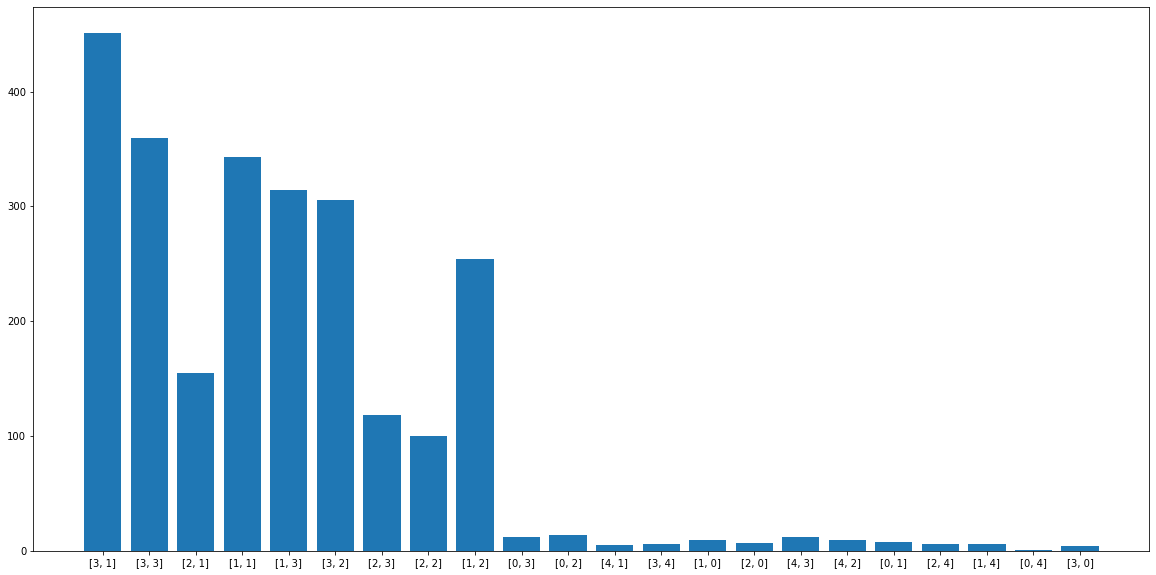

Processing Epoch 176
training start
Iteration 0, d real/fake loss 0.6529045701026917/0.6789417266845703 and g loss is 0.783787727355957, NDiv loss 0.07052944600582123
Iteration 1, d real/fake loss 0.6536949276924133/0.646511435508728 and g loss is 0.7804718017578125, NDiv loss 0.08148133009672165
Iteration 2, d real/fake loss 0.6541991829872131/0.6996573805809021 and g loss is 0.7913684844970703, NDiv loss 0.08062021434307098
Iteration 3, d real/fake loss 0.6546842455863953/0.6777399182319641 and g loss is 0.852245569229126, NDiv loss 0.07969783246517181
Iteration 4, d real/fake loss 0.6552909016609192/0.6782466769218445 and g loss is 0.848212480545044, NDiv loss 0.07388301193714142


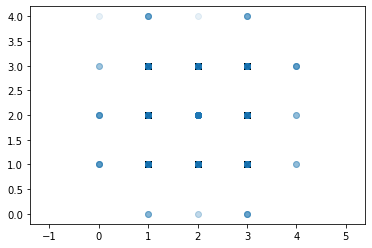

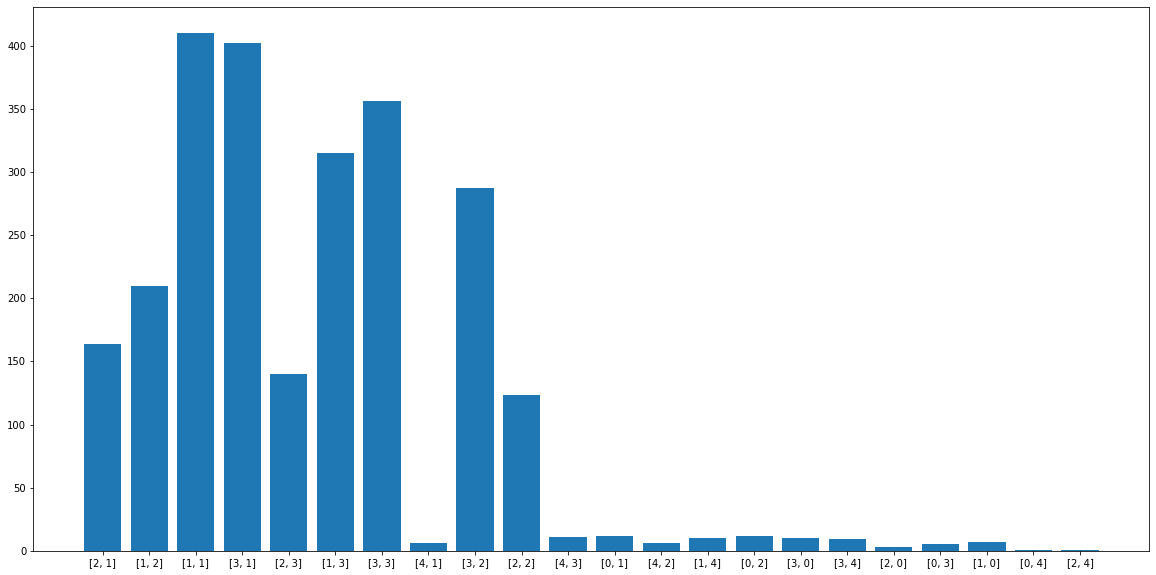

Processing Epoch 177
training start
Iteration 0, d real/fake loss 0.671803891658783/0.6624860167503357 and g loss is 0.7750955820083618, NDiv loss 0.07532341778278351
Iteration 1, d real/fake loss 0.6709412932395935/0.6556444764137268 and g loss is 0.7990368604660034, NDiv loss 0.07014089822769165
Iteration 2, d real/fake loss 0.6694102883338928/0.702850341796875 and g loss is 0.776896595954895, NDiv loss 0.08027452975511551
Iteration 3, d real/fake loss 0.6677226424217224/0.7016645073890686 and g loss is 0.7940701246261597, NDiv loss 0.09594512730836868
Iteration 4, d real/fake loss 0.6663135290145874/0.6515998244285583 and g loss is 0.7869417071342468, NDiv loss 0.07697102427482605


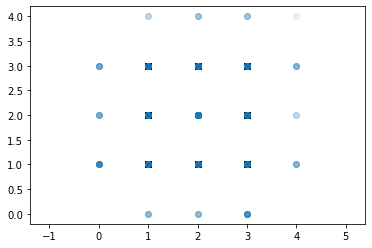

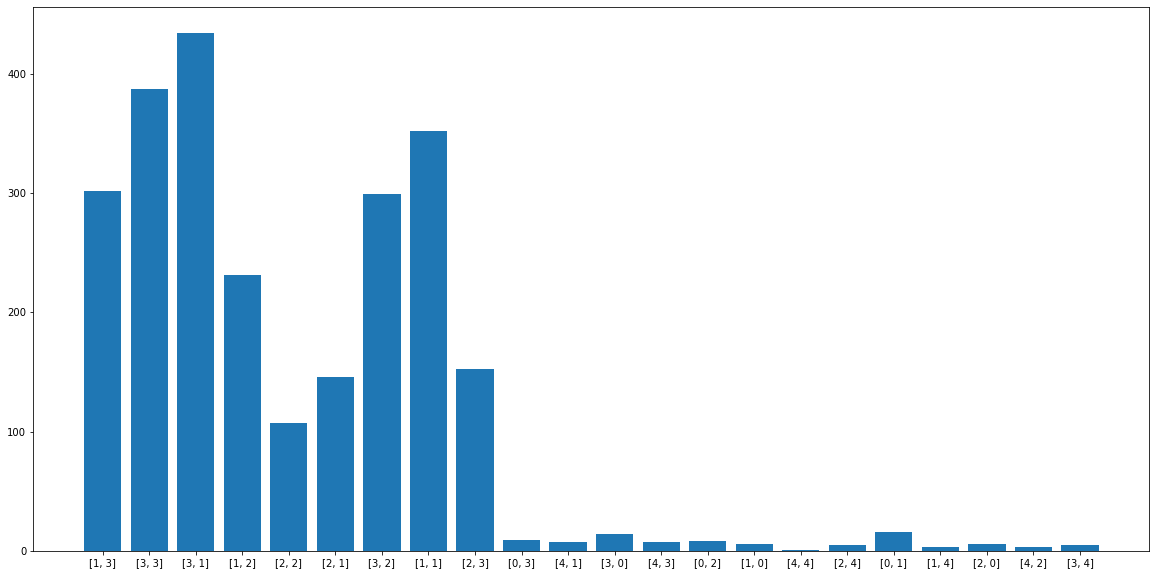

Processing Epoch 178
training start
Iteration 0, d real/fake loss 0.641237735748291/0.7055304050445557 and g loss is 0.7938004732131958, NDiv loss 0.0725826695561409
Iteration 1, d real/fake loss 0.6409889459609985/0.6592637300491333 and g loss is 0.8004308342933655, NDiv loss 0.07532091438770294
Iteration 2, d real/fake loss 0.6410794258117676/0.6834418773651123 and g loss is 0.8160971403121948, NDiv loss 0.0824257880449295
Iteration 3, d real/fake loss 0.6416061520576477/0.637956976890564 and g loss is 0.7965803146362305, NDiv loss 0.07047835737466812
Iteration 4, d real/fake loss 0.6420004963874817/0.6915909051895142 and g loss is 0.7850791215896606, NDiv loss 0.08472300320863724


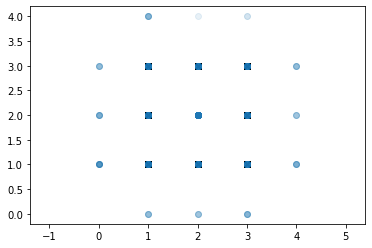

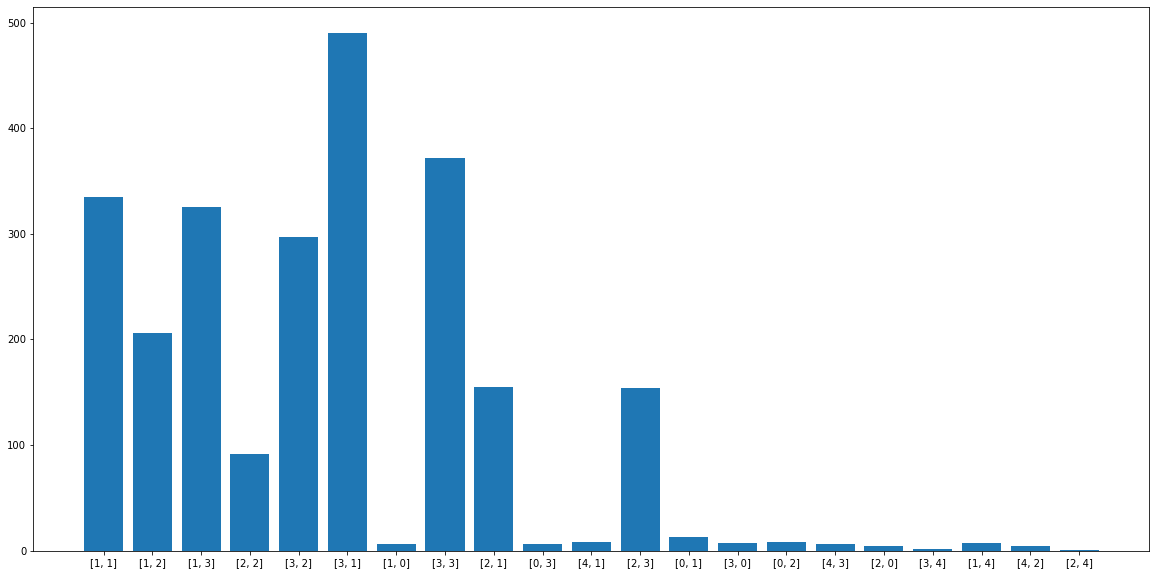

Processing Epoch 179
training start
Iteration 0, d real/fake loss 0.6660470962524414/0.6609131693840027 and g loss is 0.8105354309082031, NDiv loss 0.07909834384918213
Iteration 1, d real/fake loss 0.6658828258514404/0.6978145837783813 and g loss is 0.7981592416763306, NDiv loss 0.07224179804325104
Iteration 2, d real/fake loss 0.6655387878417969/0.6464965343475342 and g loss is 0.7643436789512634, NDiv loss 0.07185602188110352
Iteration 3, d real/fake loss 0.6645690202713013/0.6655025482177734 and g loss is 0.7883225679397583, NDiv loss 0.07149676978588104
Iteration 4, d real/fake loss 0.6631837487220764/0.6290479898452759 and g loss is 0.76661217212677, NDiv loss 0.07453741878271103


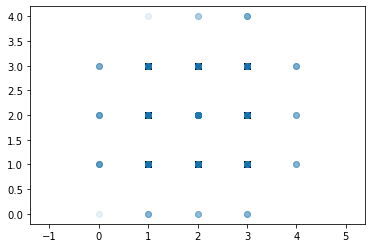

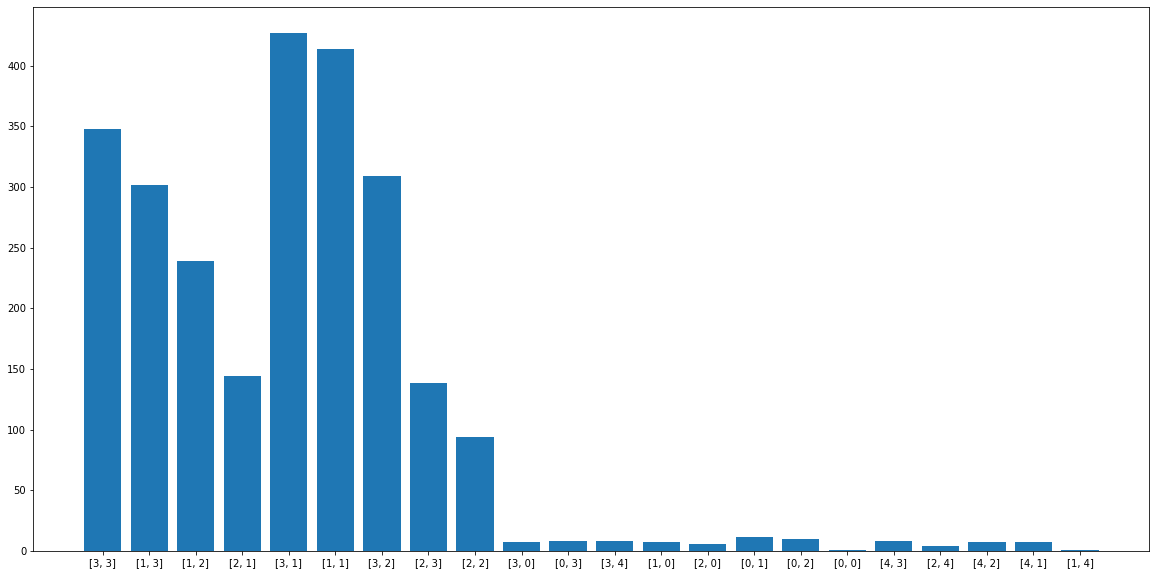

Processing Epoch 180
training start
Iteration 0, d real/fake loss 0.6339566707611084/0.6308956742286682 and g loss is 0.795322835445404, NDiv loss 0.07779423892498016
Iteration 1, d real/fake loss 0.6329691410064697/0.6593360900878906 and g loss is 0.7683110237121582, NDiv loss 0.07455418258905411
Iteration 2, d real/fake loss 0.6324634552001953/0.7021524906158447 and g loss is 0.7675991654396057, NDiv loss 0.07812969386577606
Iteration 3, d real/fake loss 0.6324634552001953/0.6502088308334351 and g loss is 0.8027553558349609, NDiv loss 0.07207788527011871
Iteration 4, d real/fake loss 0.632547914981842/0.6468891501426697 and g loss is 0.7583463788032532, NDiv loss 0.08148400485515594


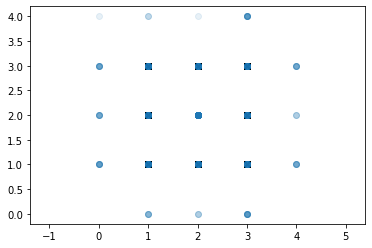

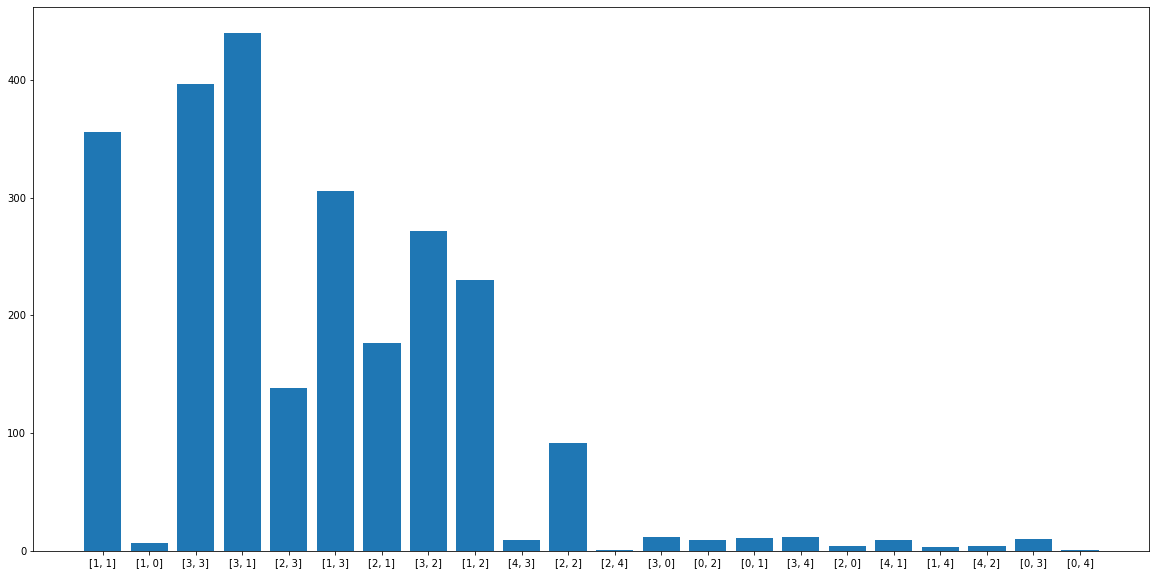

Processing Epoch 181
training start
Iteration 0, d real/fake loss 0.6531394720077515/0.663457989692688 and g loss is 0.7367671132087708, NDiv loss 0.08311555534601212
Iteration 1, d real/fake loss 0.6536387205123901/0.6652154922485352 and g loss is 0.7835099101066589, NDiv loss 0.0837603211402893
Iteration 2, d real/fake loss 0.6541025042533875/0.6957429051399231 and g loss is 0.7561640739440918, NDiv loss 0.07902314513921738
Iteration 3, d real/fake loss 0.6544820070266724/0.6422123908996582 and g loss is 0.7725495100021362, NDiv loss 0.07286965101957321
Iteration 4, d real/fake loss 0.6542072892189026/0.670509934425354 and g loss is 0.8411591053009033, NDiv loss 0.0723288282752037


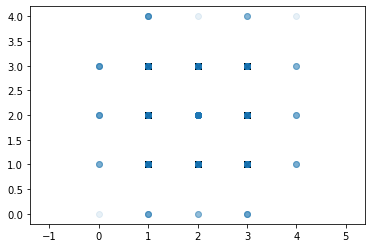

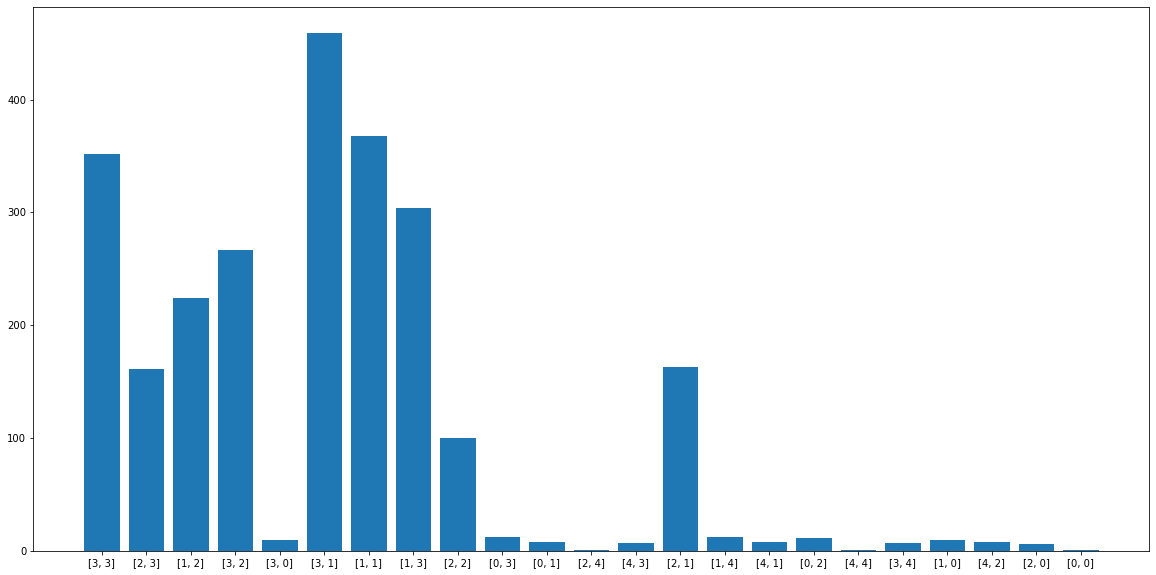

Processing Epoch 182
training start
Iteration 0, d real/fake loss 0.6577365398406982/0.666499137878418 and g loss is 0.7300115823745728, NDiv loss 0.07647989690303802
Iteration 1, d real/fake loss 0.6571457982063293/0.6970745325088501 and g loss is 0.7531610727310181, NDiv loss 0.0734424963593483
Iteration 2, d real/fake loss 0.6569423675537109/0.668289840221405 and g loss is 0.8156436681747437, NDiv loss 0.08249378949403763
Iteration 3, d real/fake loss 0.6566653251647949/0.6741137504577637 and g loss is 0.7849451303482056, NDiv loss 0.07384426891803741
Iteration 4, d real/fake loss 0.6560639142990112/0.6940991282463074 and g loss is 0.759129524230957, NDiv loss 0.07925423234701157


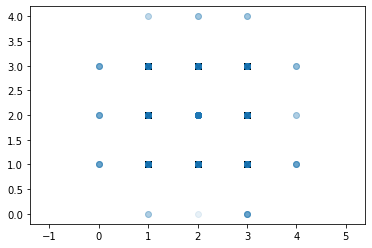

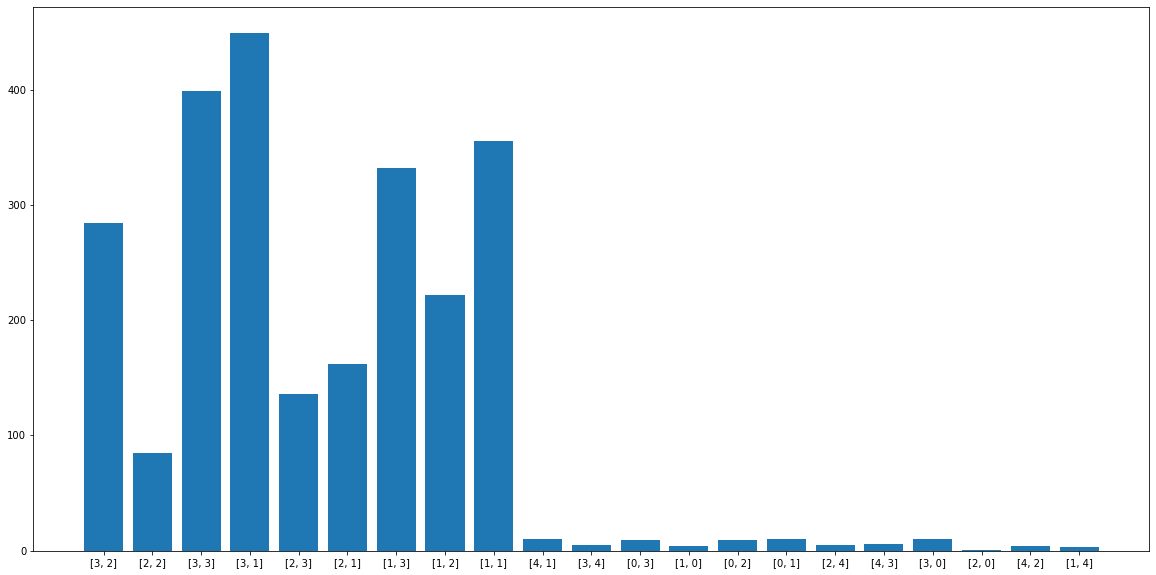

Processing Epoch 183
training start
Iteration 0, d real/fake loss 0.6634795665740967/0.6764419078826904 and g loss is 0.7423166036605835, NDiv loss 0.0846238061785698
Iteration 1, d real/fake loss 0.6628497838973999/0.6650250554084778 and g loss is 0.7995832562446594, NDiv loss 0.08236616849899292
Iteration 2, d real/fake loss 0.6619549989700317/0.6996104717254639 and g loss is 0.7730786204338074, NDiv loss 0.08190484344959259
Iteration 3, d real/fake loss 0.661045253276825/0.662111759185791 and g loss is 0.7860647439956665, NDiv loss 0.07895466685295105
Iteration 4, d real/fake loss 0.6600086092948914/0.6632002592086792 and g loss is 0.7703951597213745, NDiv loss 0.07861413806676865


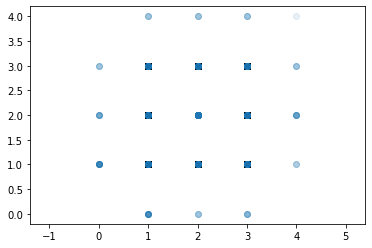

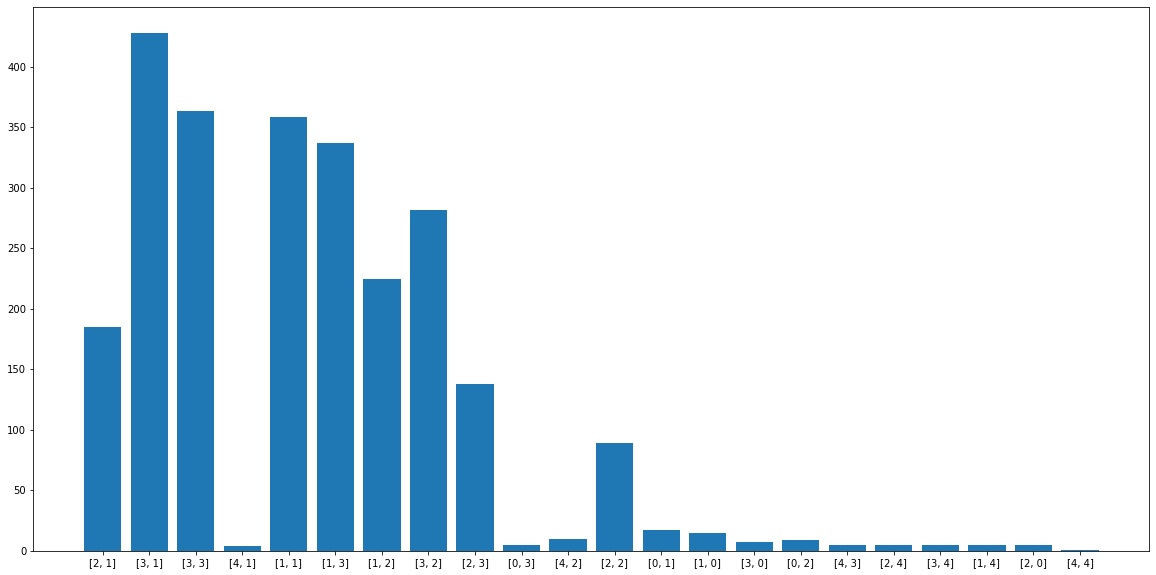

Processing Epoch 184
training start
Iteration 0, d real/fake loss 0.6440728902816772/0.6646081209182739 and g loss is 0.7544126510620117, NDiv loss 0.07753216475248337
Iteration 1, d real/fake loss 0.6439313292503357/0.6816854476928711 and g loss is 0.8472789525985718, NDiv loss 0.07324900478124619
Iteration 2, d real/fake loss 0.6441798210144043/0.6852258443832397 and g loss is 0.7626681327819824, NDiv loss 0.07470360398292542
Iteration 3, d real/fake loss 0.6445387601852417/0.6417713165283203 and g loss is 0.7863777279853821, NDiv loss 0.08303741365671158
Iteration 4, d real/fake loss 0.6450964212417603/0.6347416043281555 and g loss is 0.7502191662788391, NDiv loss 0.07566225528717041


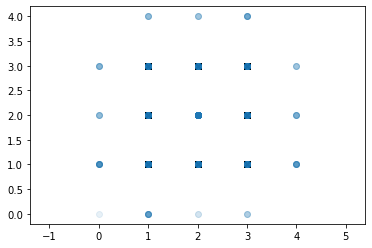

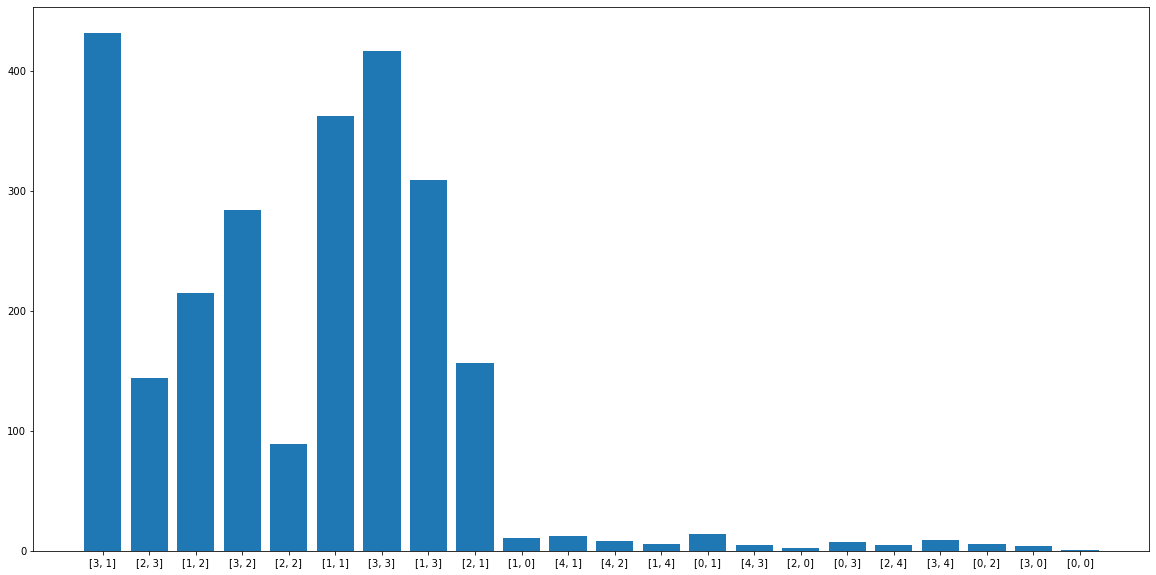

Processing Epoch 185
training start
Iteration 0, d real/fake loss 0.646233856678009/0.6559023857116699 and g loss is 0.751476526260376, NDiv loss 0.07651790231466293
Iteration 1, d real/fake loss 0.6466146111488342/0.6758919954299927 and g loss is 0.7805270552635193, NDiv loss 0.07733545452356339
Iteration 2, d real/fake loss 0.647119402885437/0.6764087677001953 and g loss is 0.7968522310256958, NDiv loss 0.07289505749940872
Iteration 3, d real/fake loss 0.6478452086448669/0.6624854803085327 and g loss is 0.7628389596939087, NDiv loss 0.07760867476463318
Iteration 4, d real/fake loss 0.6485384106636047/0.6727313995361328 and g loss is 0.7950965166091919, NDiv loss 0.08573472499847412


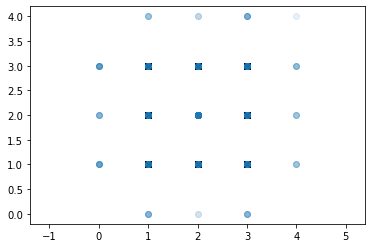

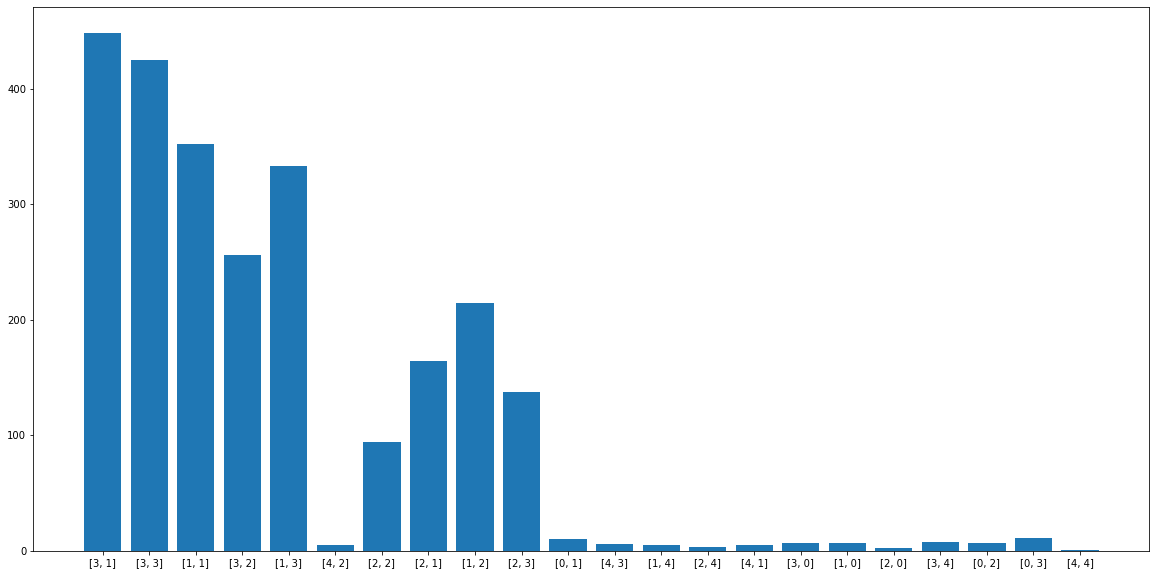

Processing Epoch 186
training start
Iteration 0, d real/fake loss 0.6578840017318726/0.6537312269210815 and g loss is 0.8444328308105469, NDiv loss 0.07828329503536224
Iteration 1, d real/fake loss 0.6585527658462524/0.6691992282867432 and g loss is 0.8119408488273621, NDiv loss 0.08776777237653732
Iteration 2, d real/fake loss 0.6585224866867065/0.6471577882766724 and g loss is 0.7578016519546509, NDiv loss 0.07495761662721634
Iteration 3, d real/fake loss 0.6582292914390564/0.6628115773200989 and g loss is 0.7732853889465332, NDiv loss 0.07252799719572067
Iteration 4, d real/fake loss 0.6575940251350403/0.6522830724716187 and g loss is 0.7619563341140747, NDiv loss 0.07578681409358978


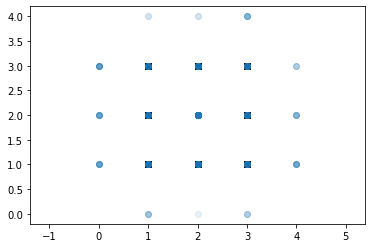

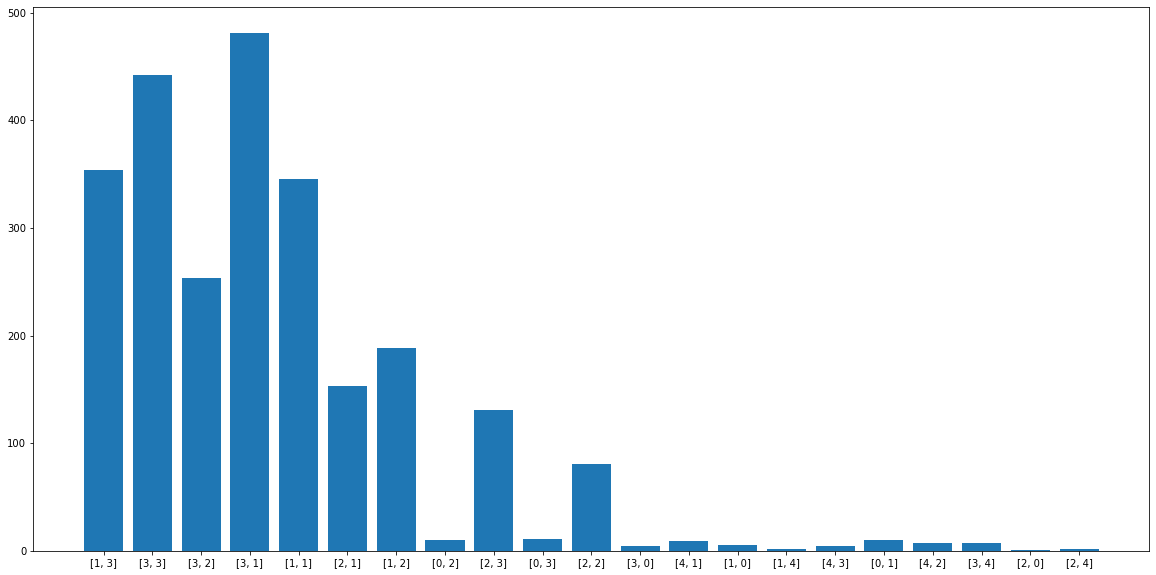

Processing Epoch 187
training start
Iteration 0, d real/fake loss 0.6792205572128296/0.6688893437385559 and g loss is 0.8004873991012573, NDiv loss 0.07689987868070602
Iteration 1, d real/fake loss 0.6780097484588623/0.6348461508750916 and g loss is 0.7617449760437012, NDiv loss 0.07992881536483765
Iteration 2, d real/fake loss 0.6763966679573059/0.6590521335601807 and g loss is 0.78164142370224, NDiv loss 0.07531365007162094
Iteration 3, d real/fake loss 0.6746163368225098/0.6821932792663574 and g loss is 0.7915595769882202, NDiv loss 0.07895515859127045
Iteration 4, d real/fake loss 0.6728768944740295/0.6357352137565613 and g loss is 0.7505085468292236, NDiv loss 0.0847763791680336


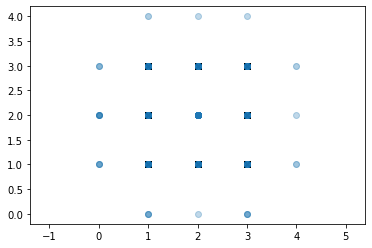

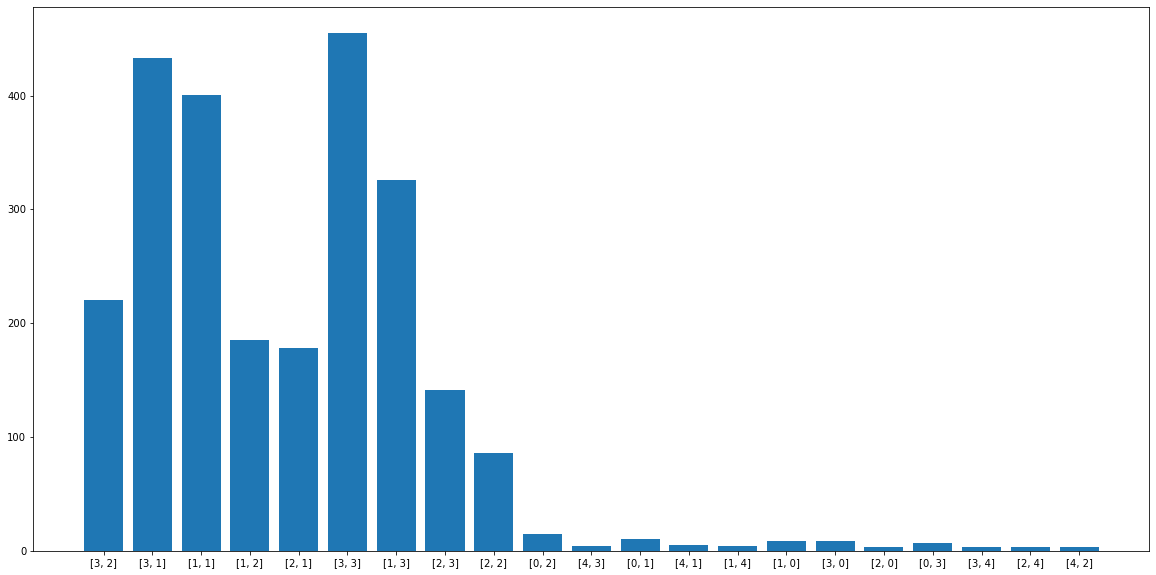

Processing Epoch 188
training start
Iteration 0, d real/fake loss 0.6280924081802368/0.6386334896087646 and g loss is 0.7352895736694336, NDiv loss 0.0834696888923645
Iteration 1, d real/fake loss 0.628309965133667/0.6385291218757629 and g loss is 0.7855095863342285, NDiv loss 0.08271856606006622
Iteration 2, d real/fake loss 0.6288256645202637/0.6764806509017944 and g loss is 0.7886354923248291, NDiv loss 0.07902204245328903
Iteration 3, d real/fake loss 0.6297887563705444/0.6798706650733948 and g loss is 0.7902296781539917, NDiv loss 0.0972299575805664
Iteration 4, d real/fake loss 0.6310697793960571/0.6522970199584961 and g loss is 0.7831951975822449, NDiv loss 0.08360355347394943


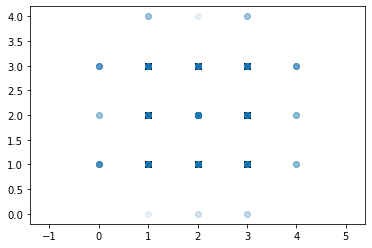

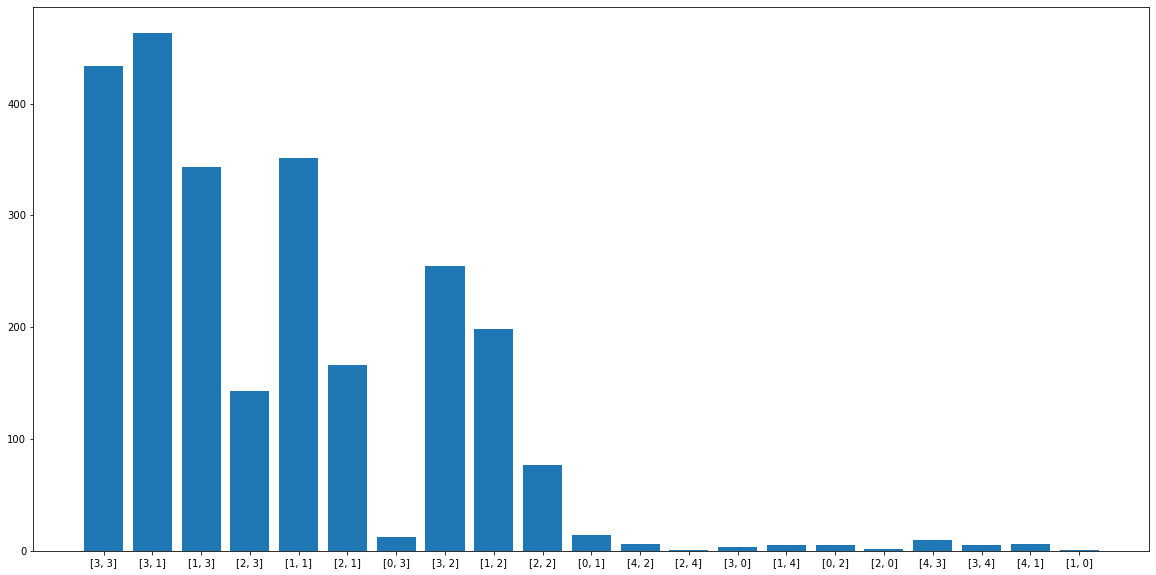

Processing Epoch 189
training start
Iteration 0, d real/fake loss 0.6541557312011719/0.6485511064529419 and g loss is 0.7625501155853271, NDiv loss 0.07983570545911789
Iteration 1, d real/fake loss 0.6553070545196533/0.6521744728088379 and g loss is 0.777780294418335, NDiv loss 0.07875426113605499
Iteration 2, d real/fake loss 0.6560951471328735/0.6554903984069824 and g loss is 0.7874795794487, NDiv loss 0.08048193156719208
Iteration 3, d real/fake loss 0.6565762758255005/0.6634514331817627 and g loss is 0.816842257976532, NDiv loss 0.08302268385887146
Iteration 4, d real/fake loss 0.6568161249160767/0.6605103611946106 and g loss is 0.8123912811279297, NDiv loss 0.0825410932302475


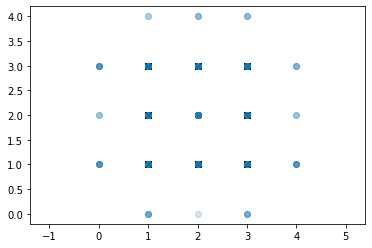

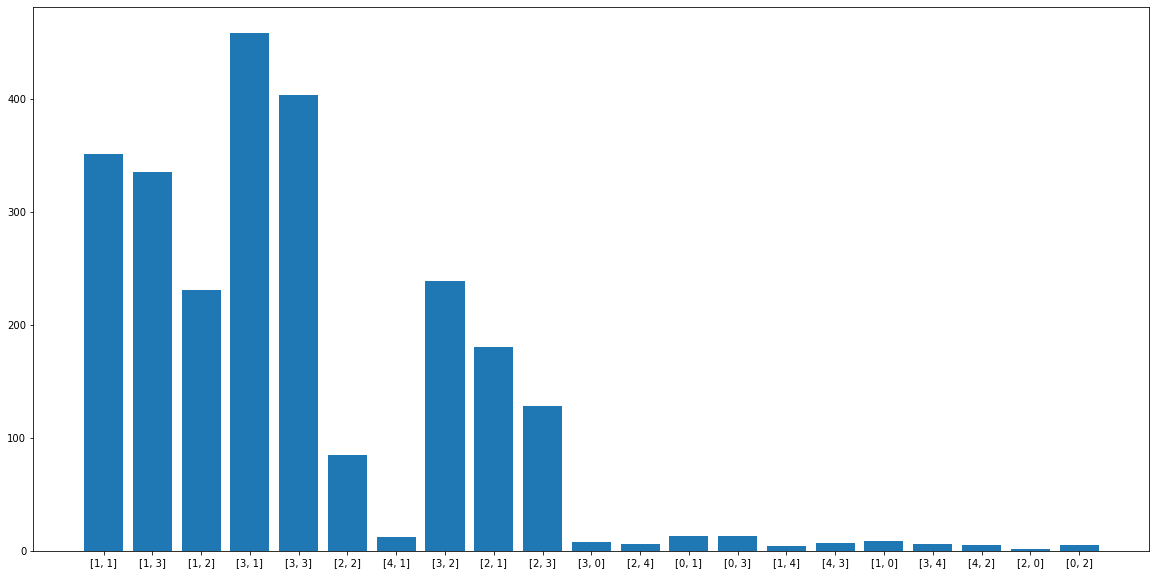

Processing Epoch 190
training start
Iteration 0, d real/fake loss 0.6829612851142883/0.6553160548210144 and g loss is 0.787286639213562, NDiv loss 0.08772579580545425
Iteration 1, d real/fake loss 0.6814145445823669/0.6598358154296875 and g loss is 0.7871006727218628, NDiv loss 0.07807626575231552
Iteration 2, d real/fake loss 0.6791778802871704/0.6538729667663574 and g loss is 0.7937175035476685, NDiv loss 0.09533648192882538
Iteration 3, d real/fake loss 0.676632285118103/0.6962235569953918 and g loss is 0.7810394763946533, NDiv loss 0.07216064631938934
Iteration 4, d real/fake loss 0.6742571592330933/0.6600393652915955 and g loss is 0.7367140054702759, NDiv loss 0.07728523015975952


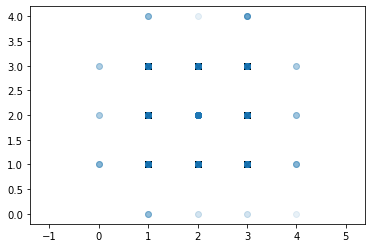

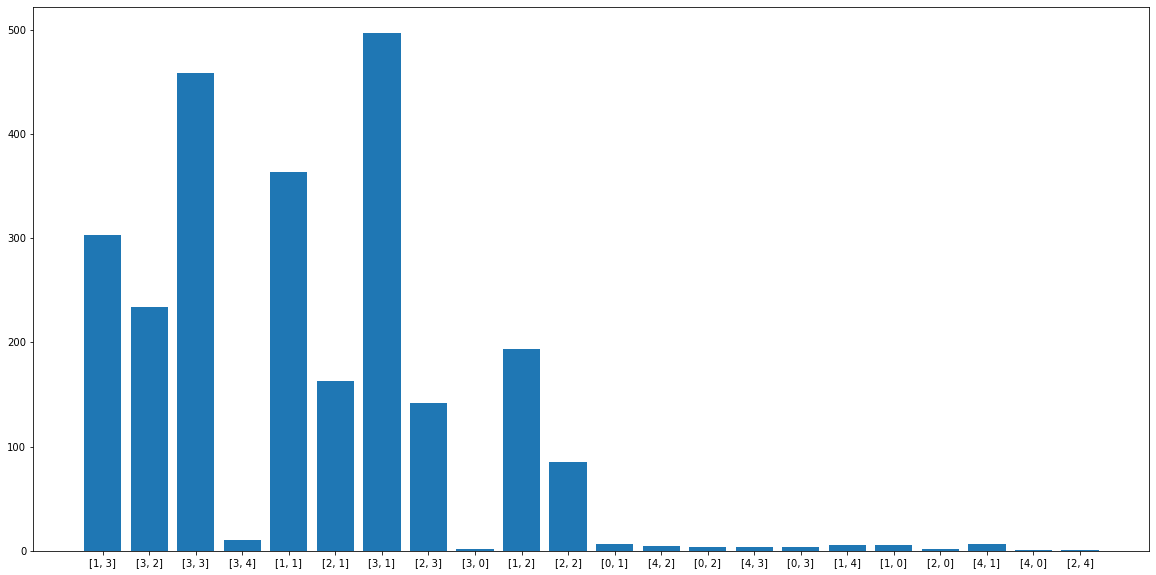

Processing Epoch 191
training start
Iteration 0, d real/fake loss 0.6605182886123657/0.6920082569122314 and g loss is 0.7875139713287354, NDiv loss 0.07462433725595474
Iteration 1, d real/fake loss 0.6588741540908813/0.6523275971412659 and g loss is 0.7452899217605591, NDiv loss 0.07801052182912827
Iteration 2, d real/fake loss 0.6575384140014648/0.6783370971679688 and g loss is 0.8017071485519409, NDiv loss 0.07856076955795288
Iteration 3, d real/fake loss 0.6565799713134766/0.651160478591919 and g loss is 0.770828127861023, NDiv loss 0.08806377649307251
Iteration 4, d real/fake loss 0.655794084072113/0.6950774192810059 and g loss is 0.7323378324508667, NDiv loss 0.08053145557641983


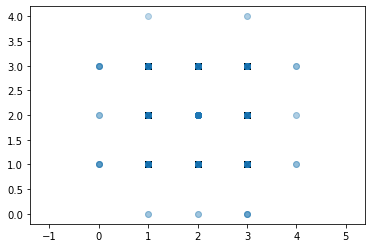

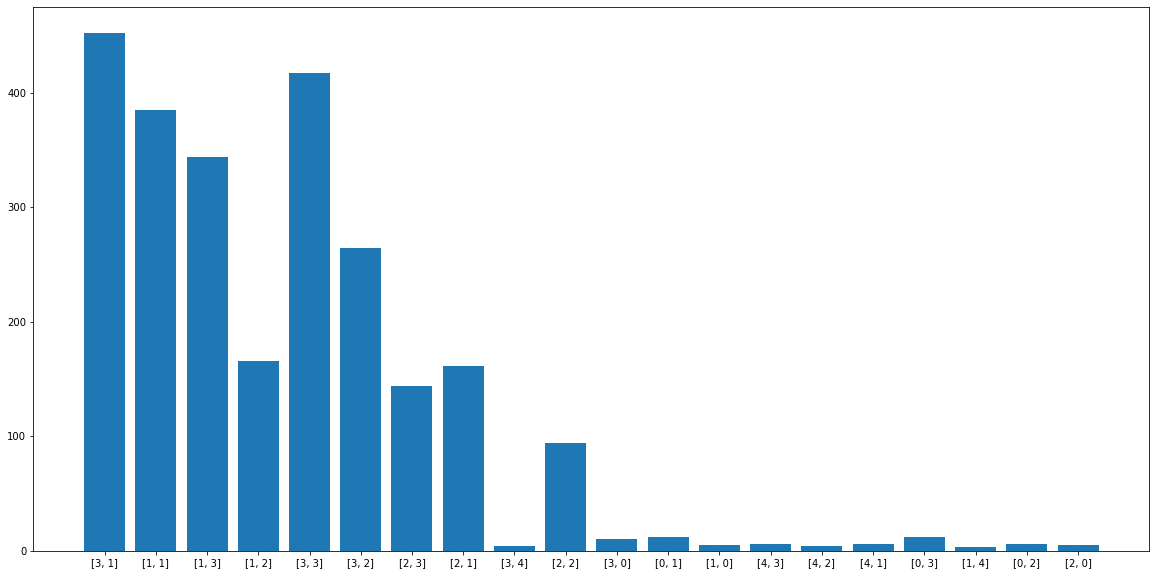

Processing Epoch 192
training start
Iteration 0, d real/fake loss 0.6282560229301453/0.6854709982872009 and g loss is 0.7838345170021057, NDiv loss 0.09323091804981232
Iteration 1, d real/fake loss 0.6292616128921509/0.6607239246368408 and g loss is 0.7950592637062073, NDiv loss 0.0832786113023758
Iteration 2, d real/fake loss 0.6304703950881958/0.6625533699989319 and g loss is 0.7616564035415649, NDiv loss 0.0827891081571579
Iteration 3, d real/fake loss 0.6317880749702454/0.6597670316696167 and g loss is 0.7940168380737305, NDiv loss 0.0788976401090622
Iteration 4, d real/fake loss 0.6333031058311462/0.6280446648597717 and g loss is 0.7874355316162109, NDiv loss 0.08711271733045578


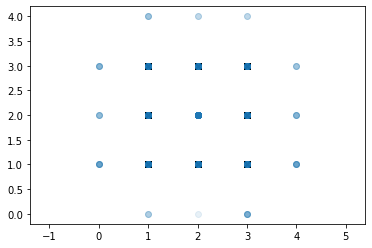

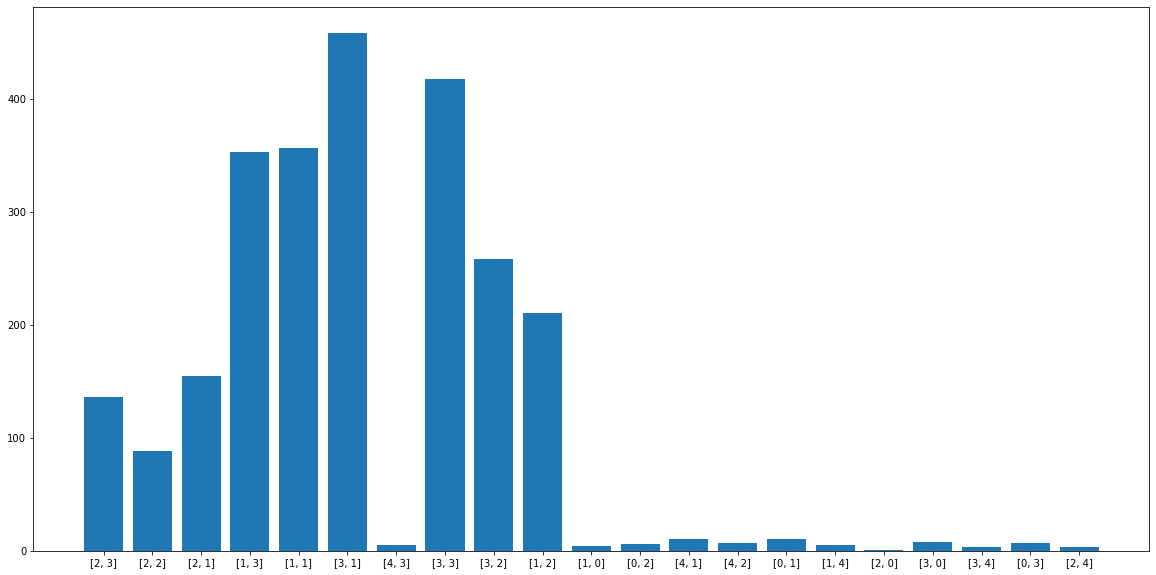

Processing Epoch 193
training start
Iteration 0, d real/fake loss 0.6795146465301514/0.6468608379364014 and g loss is 0.777234673500061, NDiv loss 0.08476586639881134
Iteration 1, d real/fake loss 0.6797066926956177/0.6723638772964478 and g loss is 0.7652568221092224, NDiv loss 0.07665812969207764
Iteration 2, d real/fake loss 0.6789761781692505/0.6150187849998474 and g loss is 0.8207107186317444, NDiv loss 0.08695320039987564
Iteration 3, d real/fake loss 0.6773208379745483/0.71366947889328 and g loss is 0.8074179887771606, NDiv loss 0.0814768522977829
Iteration 4, d real/fake loss 0.6757889986038208/0.6631793975830078 and g loss is 0.7691132426261902, NDiv loss 0.08672012388706207


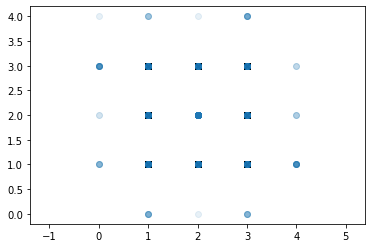

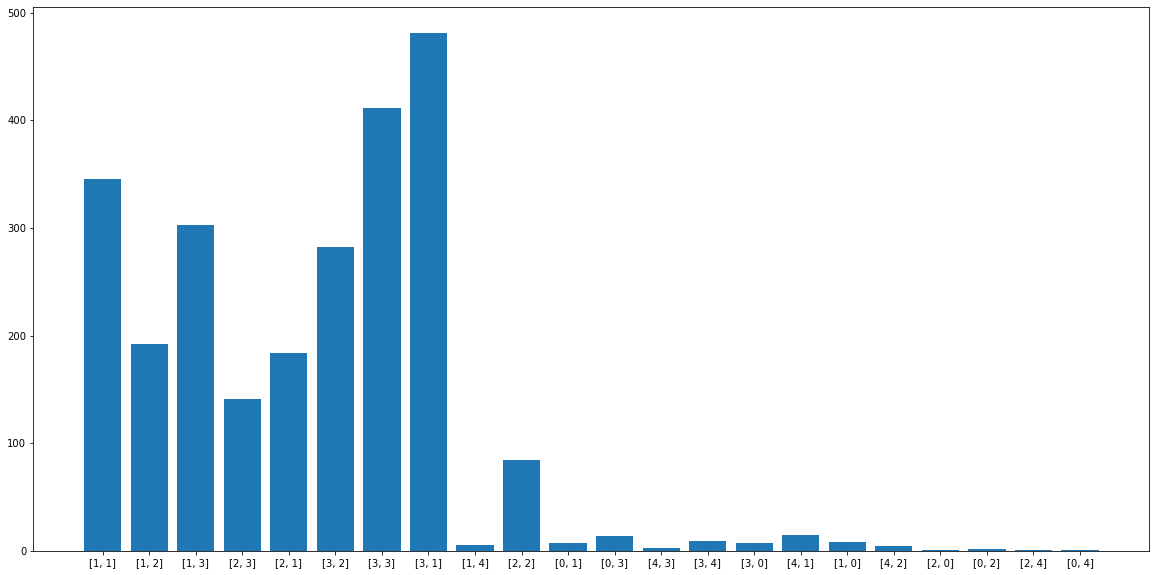

Processing Epoch 194
training start
Iteration 0, d real/fake loss 0.6562792062759399/0.6556130051612854 and g loss is 0.8272410035133362, NDiv loss 0.08884987235069275
Iteration 1, d real/fake loss 0.6556559801101685/0.680483341217041 and g loss is 0.7486424446105957, NDiv loss 0.08430557698011398
Iteration 2, d real/fake loss 0.6553612947463989/0.6899670362472534 and g loss is 0.7991244792938232, NDiv loss 0.07293043285608292
Iteration 3, d real/fake loss 0.6552426815032959/0.6677452325820923 and g loss is 0.7759037017822266, NDiv loss 0.07207395136356354
Iteration 4, d real/fake loss 0.6551187634468079/0.6541438698768616 and g loss is 0.7875497341156006, NDiv loss 0.09014027565717697


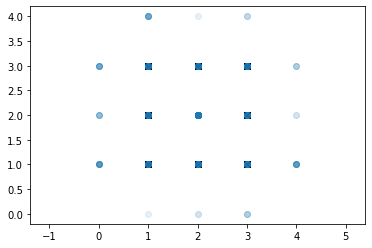

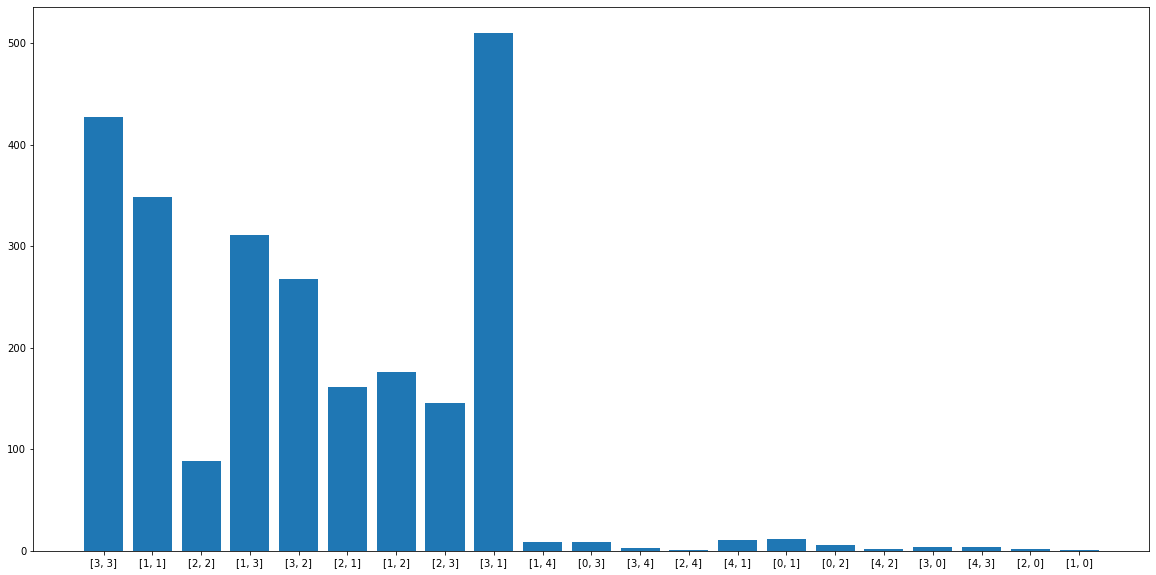

Processing Epoch 195
training start
Iteration 0, d real/fake loss 0.6468627452850342/0.6690270304679871 and g loss is 0.7906678318977356, NDiv loss 0.08152589946985245
Iteration 1, d real/fake loss 0.6468239426612854/0.6551448106765747 and g loss is 0.7525313496589661, NDiv loss 0.09017497301101685
Iteration 2, d real/fake loss 0.6465098857879639/0.683647871017456 and g loss is 0.7660470008850098, NDiv loss 0.07564545422792435
Iteration 3, d real/fake loss 0.646353006362915/0.6640893220901489 and g loss is 0.7484312057495117, NDiv loss 0.08952973037958145
Iteration 4, d real/fake loss 0.6461991667747498/0.6560596823692322 and g loss is 0.7609900236129761, NDiv loss 0.07658577710390091


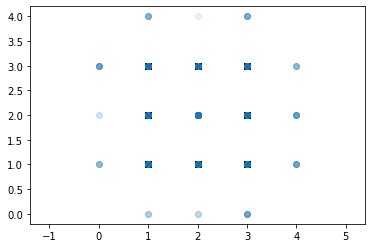

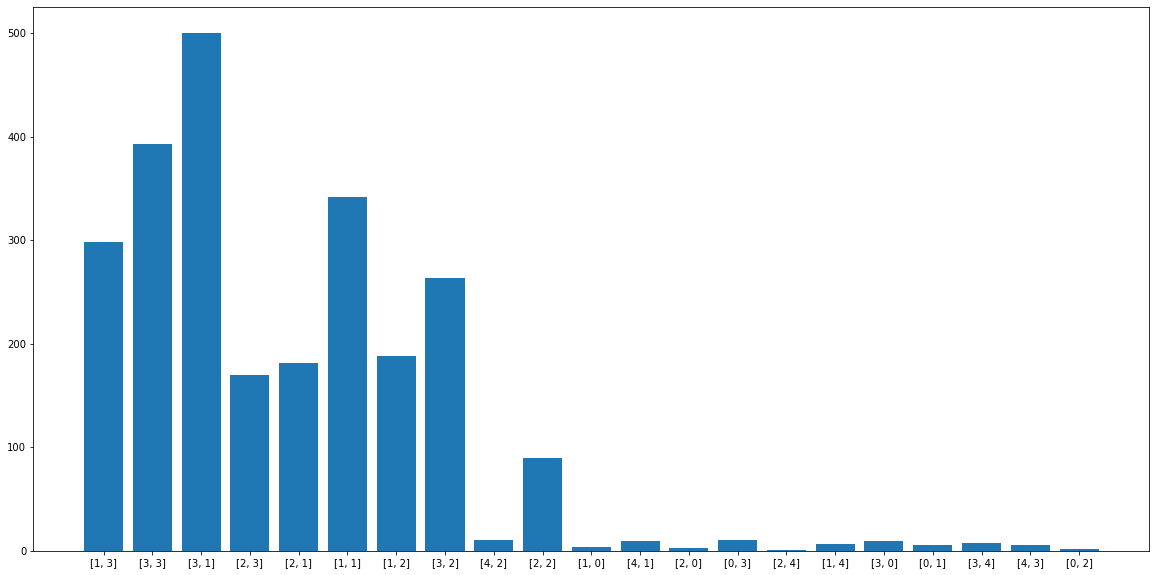

Processing Epoch 196
training start
Iteration 0, d real/fake loss 0.6262273788452148/0.6764976382255554 and g loss is 0.7220523953437805, NDiv loss 0.08092188835144043
Iteration 1, d real/fake loss 0.627492368221283/0.6340673565864563 and g loss is 0.764589786529541, NDiv loss 0.07901430130004883
Iteration 2, d real/fake loss 0.6288466453552246/0.6761678457260132 and g loss is 0.7451028227806091, NDiv loss 0.08899376541376114
Iteration 3, d real/fake loss 0.63051438331604/0.6622706651687622 and g loss is 0.7709922194480896, NDiv loss 0.0839734748005867
Iteration 4, d real/fake loss 0.6323546171188354/0.6579782366752625 and g loss is 0.7781765460968018, NDiv loss 0.08820339292287827


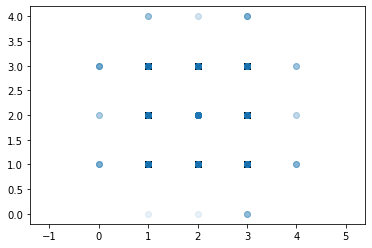

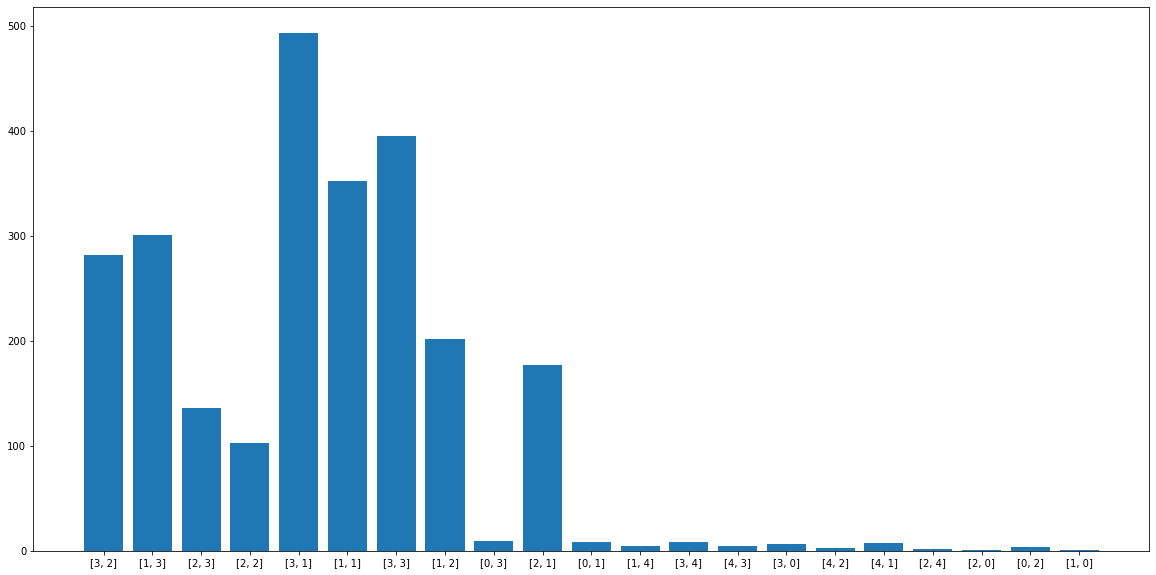

Processing Epoch 197
training start
Iteration 0, d real/fake loss 0.6643728017807007/0.6189202070236206 and g loss is 0.8139382600784302, NDiv loss 0.06903723627328873
Iteration 1, d real/fake loss 0.6655870676040649/0.6533656120300293 and g loss is 0.7961629033088684, NDiv loss 0.07558964192867279
Iteration 2, d real/fake loss 0.6662228107452393/0.6351667642593384 and g loss is 0.7549432516098022, NDiv loss 0.07726258039474487
Iteration 3, d real/fake loss 0.6664183139801025/0.6718481779098511 and g loss is 0.785534143447876, NDiv loss 0.07946053892374039
Iteration 4, d real/fake loss 0.6663541793823242/0.6771935820579529 and g loss is 0.8217102289199829, NDiv loss 0.0870160311460495


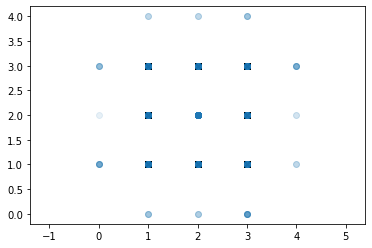

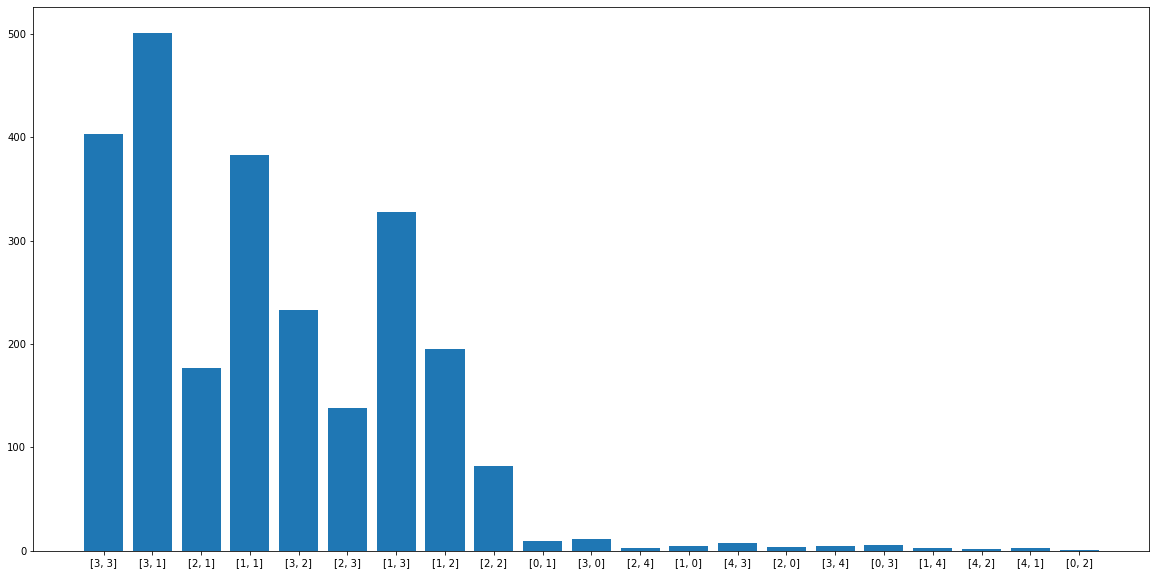

Processing Epoch 198
training start
Iteration 0, d real/fake loss 0.6672393679618835/0.6400642991065979 and g loss is 0.7694318890571594, NDiv loss 0.07161447405815125
Iteration 1, d real/fake loss 0.6666231155395508/0.6662032604217529 and g loss is 0.76308274269104, NDiv loss 0.07643480598926544
Iteration 2, d real/fake loss 0.6657730937004089/0.623839259147644 and g loss is 0.7683806419372559, NDiv loss 0.081662617623806
Iteration 3, d real/fake loss 0.6644790768623352/0.6381644606590271 and g loss is 0.7272512912750244, NDiv loss 0.07830768078565598
Iteration 4, d real/fake loss 0.6631519198417664/0.6531444787979126 and g loss is 0.7914528846740723, NDiv loss 0.0795779600739479


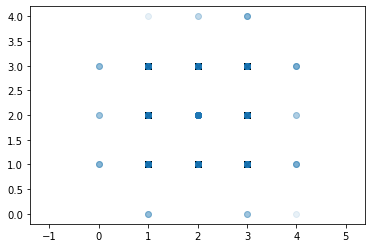

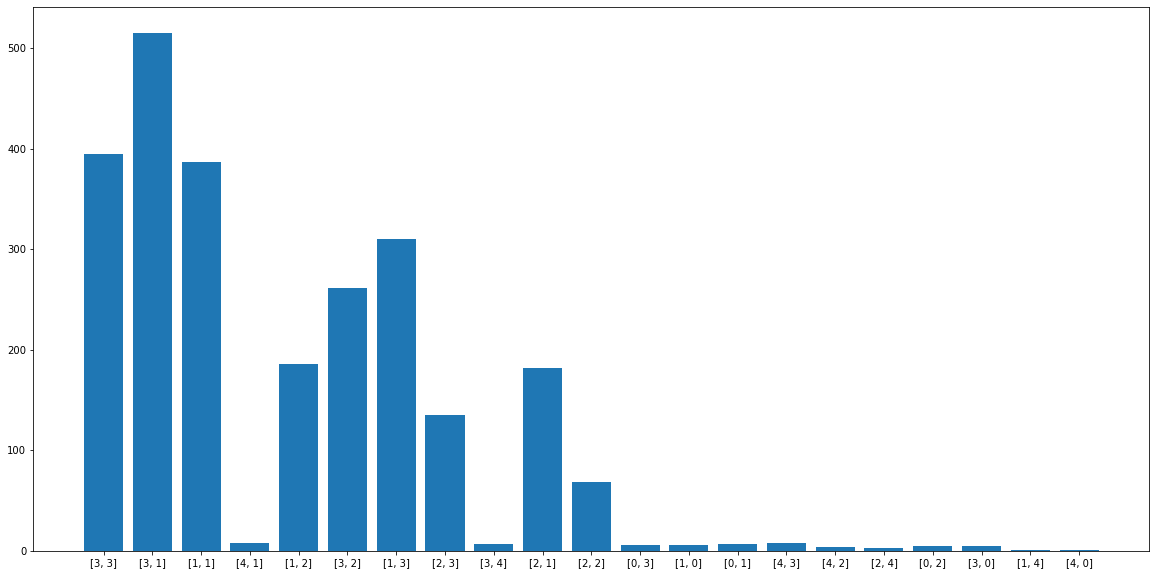

Processing Epoch 199
training start
Iteration 0, d real/fake loss 0.6631526947021484/0.6159858107566833 and g loss is 0.8218527436256409, NDiv loss 0.08043280243873596
Iteration 1, d real/fake loss 0.6615322828292847/0.630424439907074 and g loss is 0.7574520111083984, NDiv loss 0.0768820196390152
Iteration 2, d real/fake loss 0.6596593856811523/0.6619249582290649 and g loss is 0.7403075695037842, NDiv loss 0.07904046773910522
Iteration 3, d real/fake loss 0.6577842235565186/0.6723264455795288 and g loss is 0.8109948635101318, NDiv loss 0.08436046540737152
Iteration 4, d real/fake loss 0.6562053561210632/0.6844360828399658 and g loss is 0.7742196321487427, NDiv loss 0.08355642855167389


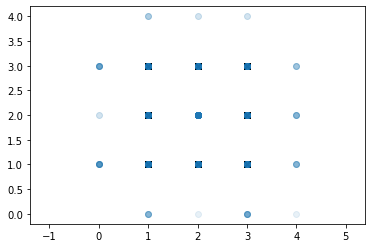

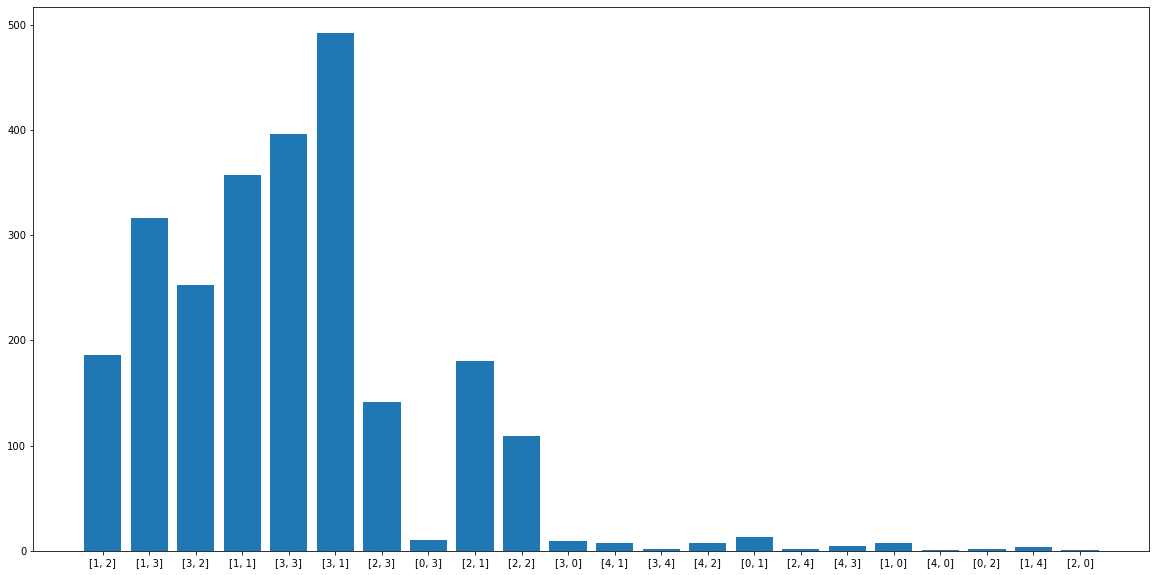

Processing Epoch 200
training start
Iteration 0, d real/fake loss 0.6620603799819946/0.6513753533363342 and g loss is 0.7978719472885132, NDiv loss 0.0752967894077301
Iteration 1, d real/fake loss 0.6613980531692505/0.644146203994751 and g loss is 0.7962424755096436, NDiv loss 0.0875607281923294
Iteration 2, d real/fake loss 0.6605170369148254/0.6861182451248169 and g loss is 0.7602759599685669, NDiv loss 0.08391693234443665
Iteration 3, d real/fake loss 0.6598535776138306/0.6778035163879395 and g loss is 0.7424993515014648, NDiv loss 0.08025959879159927
Iteration 4, d real/fake loss 0.6589288711547852/0.7312158346176147 and g loss is 0.758935809135437, NDiv loss 0.0733698382973671


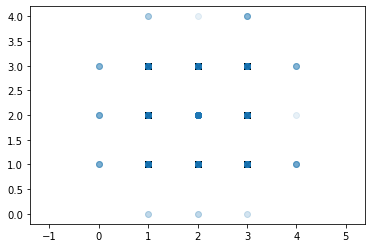

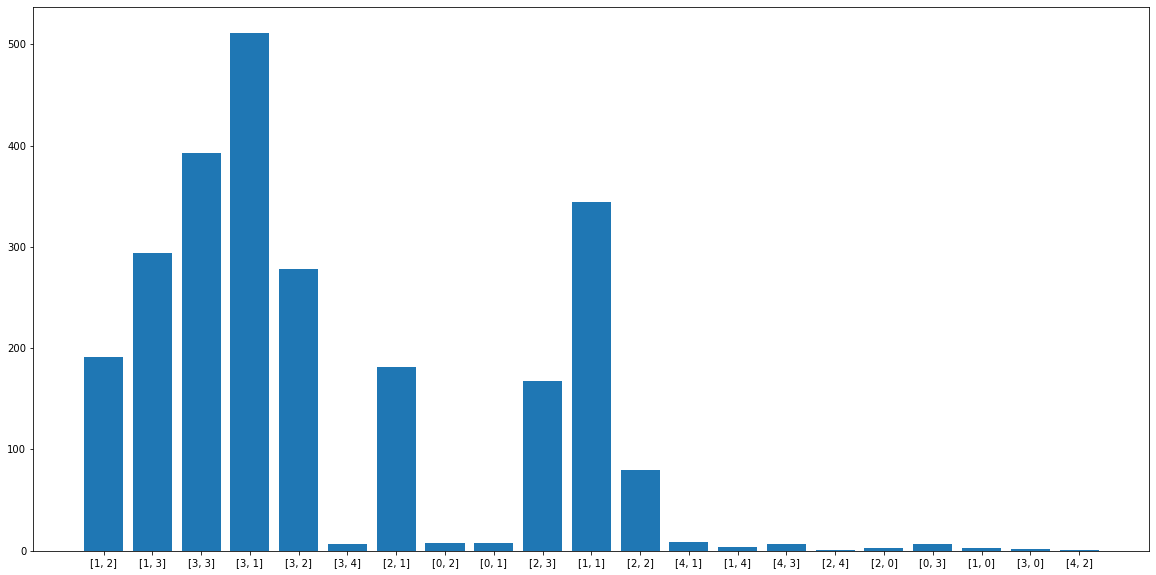

Processing Epoch 201
training start
Iteration 0, d real/fake loss 0.6394999027252197/0.6844837665557861 and g loss is 0.8064979314804077, NDiv loss 0.07715710997581482
Iteration 1, d real/fake loss 0.6407068967819214/0.6754044890403748 and g loss is 0.7838234901428223, NDiv loss 0.0815906971693039
Iteration 2, d real/fake loss 0.6423357725143433/0.6437779664993286 and g loss is 0.7956652641296387, NDiv loss 0.07721931487321854
Iteration 3, d real/fake loss 0.6438702344894409/0.6712892055511475 and g loss is 0.7429311275482178, NDiv loss 0.0785759687423706
Iteration 4, d real/fake loss 0.6454401612281799/0.651343584060669 and g loss is 0.7794935703277588, NDiv loss 0.08497556298971176


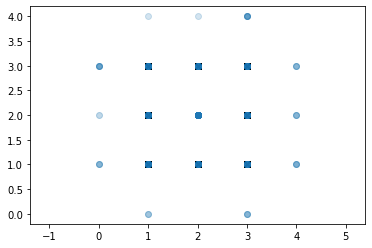

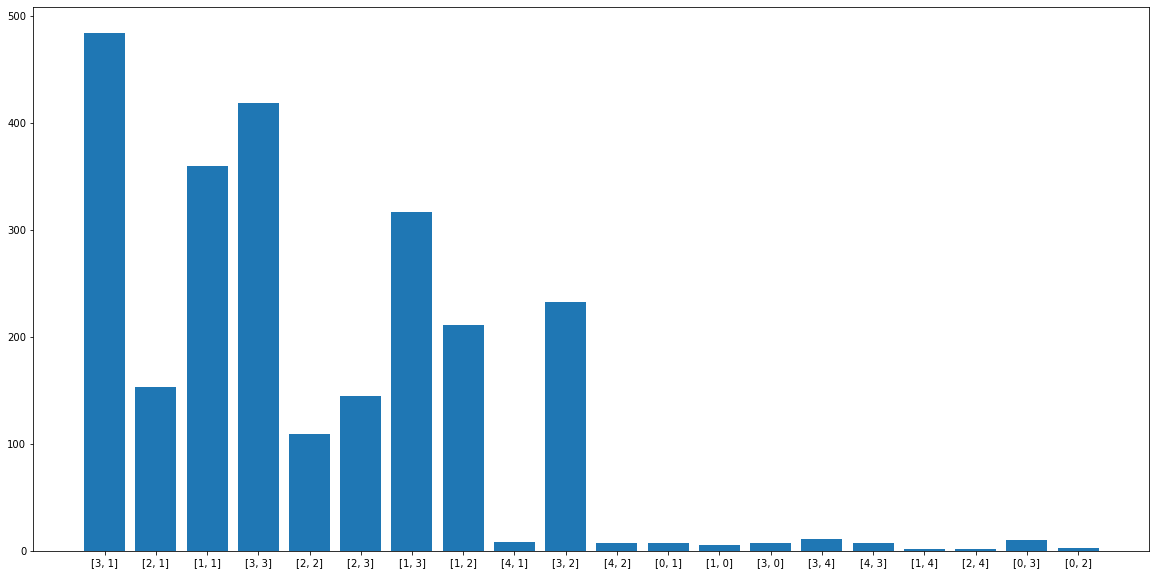

Processing Epoch 202
training start
Iteration 0, d real/fake loss 0.6683598756790161/0.6753384470939636 and g loss is 0.7988333702087402, NDiv loss 0.08560530096292496
Iteration 1, d real/fake loss 0.6687596440315247/0.6883940696716309 and g loss is 0.8356413245201111, NDiv loss 0.08234059065580368
Iteration 2, d real/fake loss 0.6689208149909973/0.6594798564910889 and g loss is 0.8243487477302551, NDiv loss 0.07859493792057037
Iteration 3, d real/fake loss 0.6686643958091736/0.6264485120773315 and g loss is 0.7551632523536682, NDiv loss 0.0929730162024498
Iteration 4, d real/fake loss 0.6674848794937134/0.6548166871070862 and g loss is 0.7946481704711914, NDiv loss 0.07408303022384644


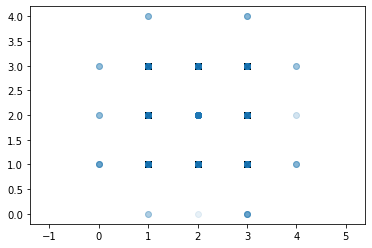

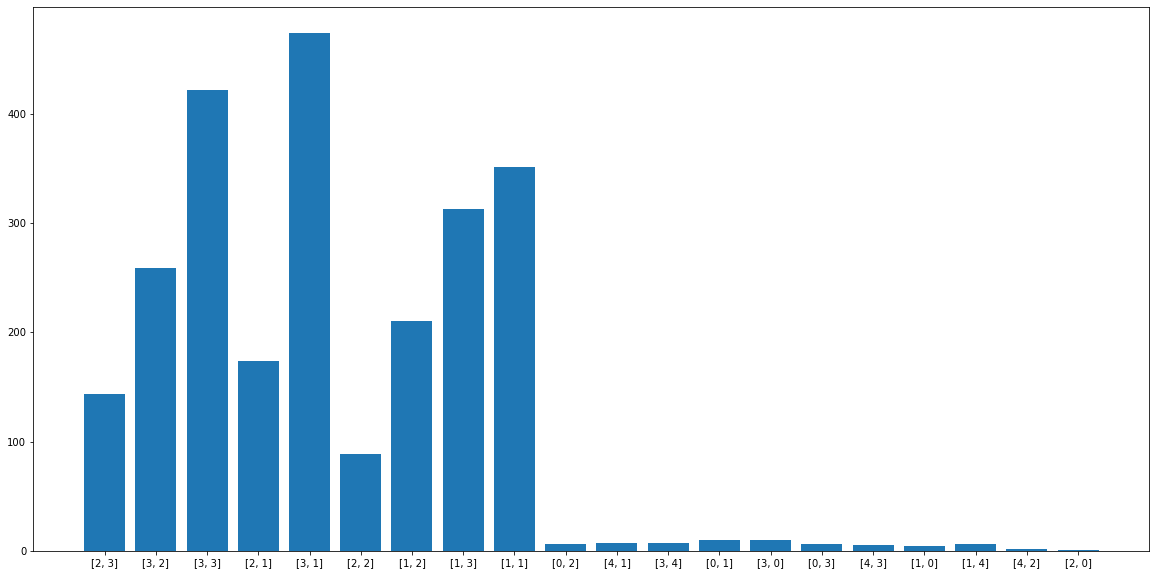

Processing Epoch 203
training start
Iteration 0, d real/fake loss 0.665276825428009/0.6462845206260681 and g loss is 0.7844969630241394, NDiv loss 0.08556903898715973
Iteration 1, d real/fake loss 0.6638798117637634/0.6497833132743835 and g loss is 0.7464531660079956, NDiv loss 0.08203105628490448
Iteration 2, d real/fake loss 0.6623327732086182/0.6492234468460083 and g loss is 0.7857587337493896, NDiv loss 0.07986640930175781
Iteration 3, d real/fake loss 0.6607568264007568/0.6497464179992676 and g loss is 0.7506159543991089, NDiv loss 0.07461099326610565
Iteration 4, d real/fake loss 0.6594472527503967/0.6923823356628418 and g loss is 0.7766653895378113, NDiv loss 0.06853587925434113


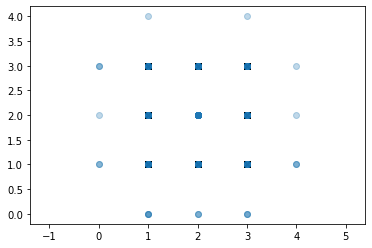

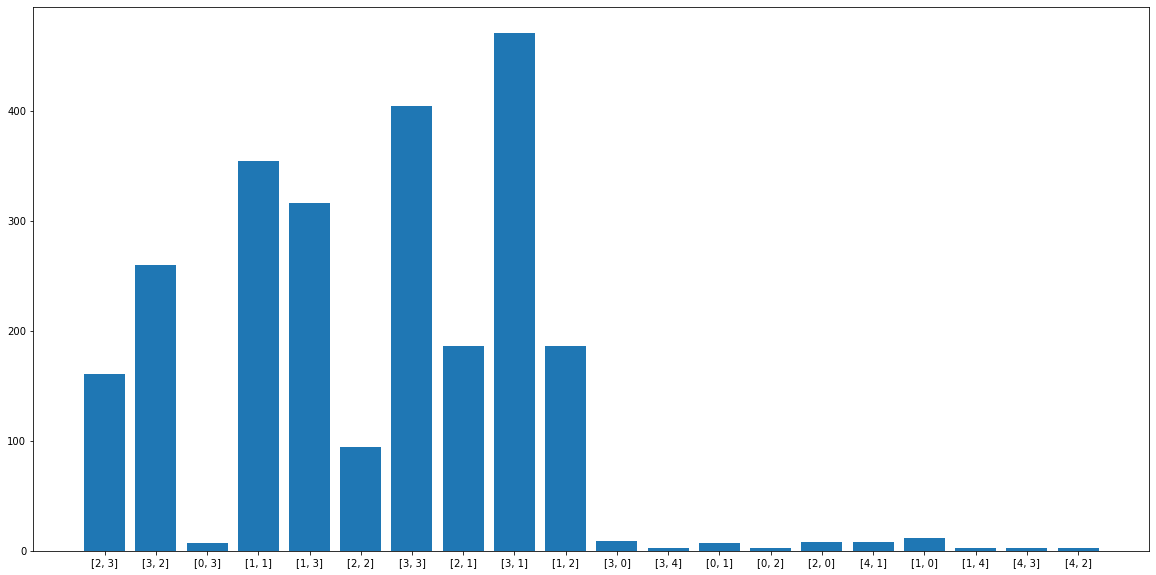

Processing Epoch 204
training start
Iteration 0, d real/fake loss 0.6271885633468628/0.6934449672698975 and g loss is 0.7925748825073242, NDiv loss 0.07889264076948166
Iteration 1, d real/fake loss 0.6281028985977173/0.6741219162940979 and g loss is 0.8403440117835999, NDiv loss 0.0744984820485115
Iteration 2, d real/fake loss 0.6296485662460327/0.659988522529602 and g loss is 0.8108327388763428, NDiv loss 0.08177565038204193
Iteration 3, d real/fake loss 0.6310983300209045/0.6644065380096436 and g loss is 0.7607930302619934, NDiv loss 0.07926685363054276
Iteration 4, d real/fake loss 0.6326656341552734/0.6632357835769653 and g loss is 0.7617082595825195, NDiv loss 0.07577173411846161


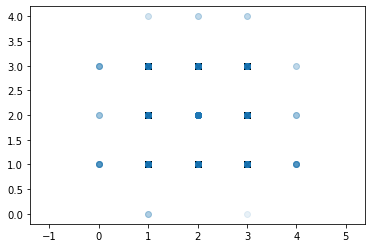

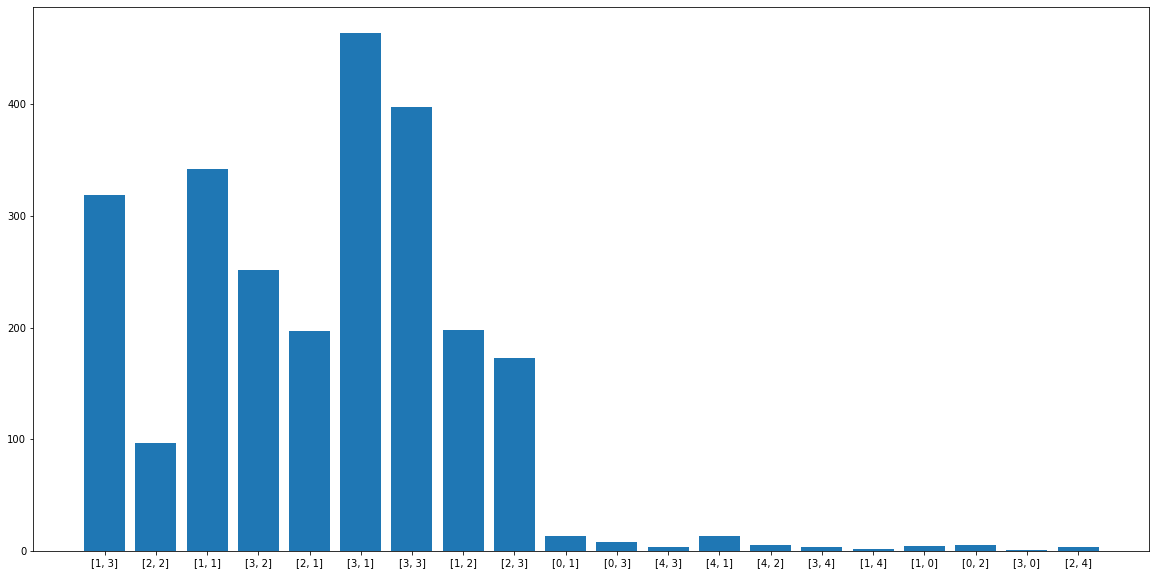

Processing Epoch 205
training start
Iteration 0, d real/fake loss 0.6483676433563232/0.6681831479072571 and g loss is 0.7615883350372314, NDiv loss 0.07676336914300919
Iteration 1, d real/fake loss 0.6492115259170532/0.668056309223175 and g loss is 0.8251420855522156, NDiv loss 0.08699679374694824
Iteration 2, d real/fake loss 0.6493210196495056/0.6595284938812256 and g loss is 0.745818018913269, NDiv loss 0.0769224464893341
Iteration 3, d real/fake loss 0.6492130756378174/0.6623517870903015 and g loss is 0.794586181640625, NDiv loss 0.07241010665893555
Iteration 4, d real/fake loss 0.6483752727508545/0.6662119626998901 and g loss is 0.773248553276062, NDiv loss 0.07555250823497772


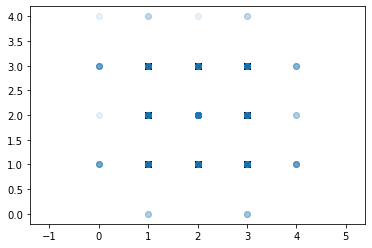

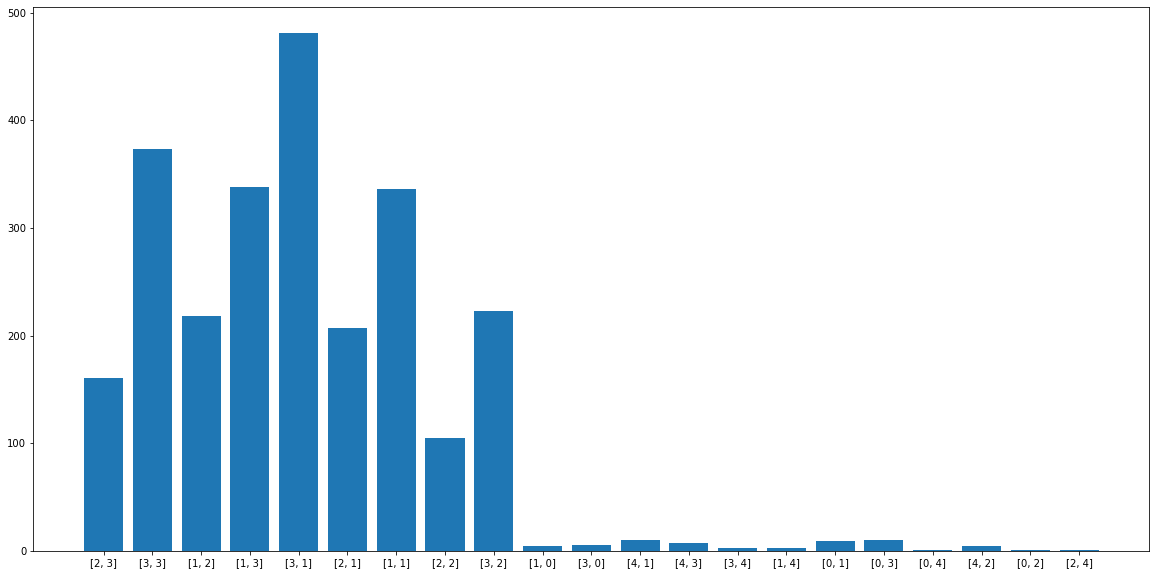

Processing Epoch 206
training start
Iteration 0, d real/fake loss 0.6416034698486328/0.6719619035720825 and g loss is 0.7695654630661011, NDiv loss 0.07877576351165771
Iteration 1, d real/fake loss 0.6417455673217773/0.6523346900939941 and g loss is 0.8066525459289551, NDiv loss 0.07321640849113464
Iteration 2, d real/fake loss 0.6416898965835571/0.6623209714889526 and g loss is 0.8772719502449036, NDiv loss 0.07531048357486725
Iteration 3, d real/fake loss 0.6417149901390076/0.6467248797416687 and g loss is 0.7401008605957031, NDiv loss 0.09100975841283798
Iteration 4, d real/fake loss 0.6418376564979553/0.6481415629386902 and g loss is 0.7989662289619446, NDiv loss 0.07368483394384384


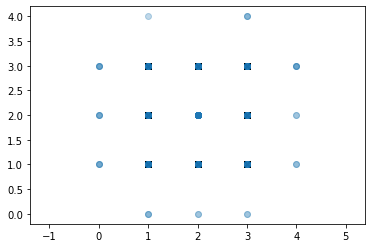

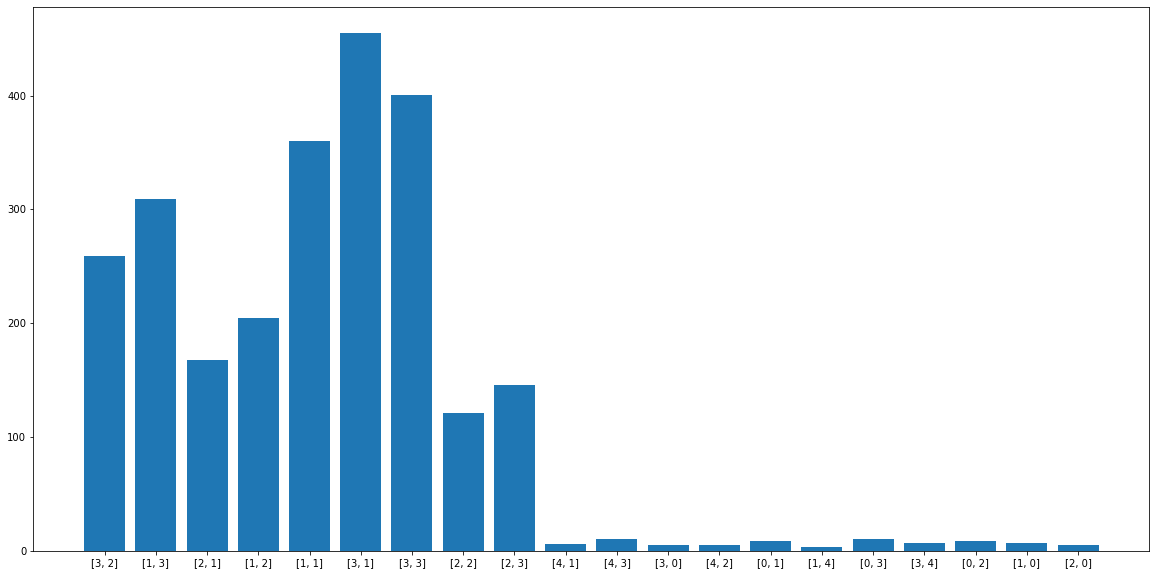

Processing Epoch 207
training start
Iteration 0, d real/fake loss 0.6637868285179138/0.6311653256416321 and g loss is 0.8321463465690613, NDiv loss 0.07191867381334305
Iteration 1, d real/fake loss 0.6632839441299438/0.6757254600524902 and g loss is 0.7814465761184692, NDiv loss 0.08134156465530396
Iteration 2, d real/fake loss 0.6625149250030518/0.656663715839386 and g loss is 0.7702444791793823, NDiv loss 0.08484160900115967
Iteration 3, d real/fake loss 0.6614355444908142/0.6623785495758057 and g loss is 0.7473604083061218, NDiv loss 0.08788546919822693
Iteration 4, d real/fake loss 0.6601438522338867/0.6394832730293274 and g loss is 0.7911032438278198, NDiv loss 0.07733848690986633


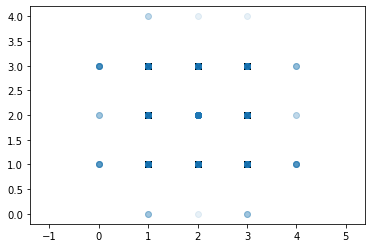

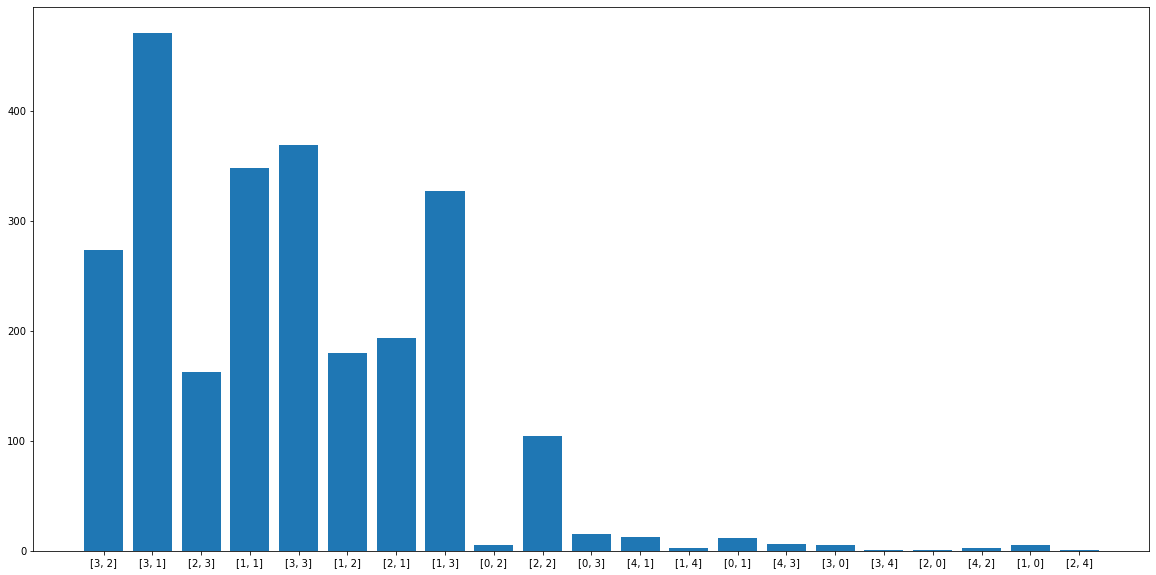

Processing Epoch 208
training start
Iteration 0, d real/fake loss 0.6804671883583069/0.6751075387001038 and g loss is 0.8341833353042603, NDiv loss 0.07149146497249603
Iteration 1, d real/fake loss 0.6786083579063416/0.6419841051101685 and g loss is 0.7833194136619568, NDiv loss 0.0851467102766037
Iteration 2, d real/fake loss 0.6764447689056396/0.6892657279968262 and g loss is 0.804093062877655, NDiv loss 0.07869279384613037
Iteration 3, d real/fake loss 0.67434161901474/0.6842751502990723 and g loss is 0.8201526999473572, NDiv loss 0.07323592156171799
Iteration 4, d real/fake loss 0.6724120378494263/0.694923996925354 and g loss is 0.8288714289665222, NDiv loss 0.0774211660027504


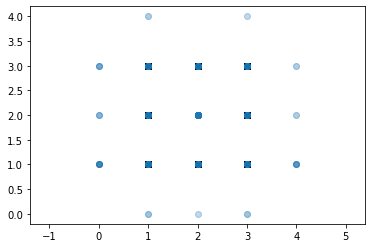

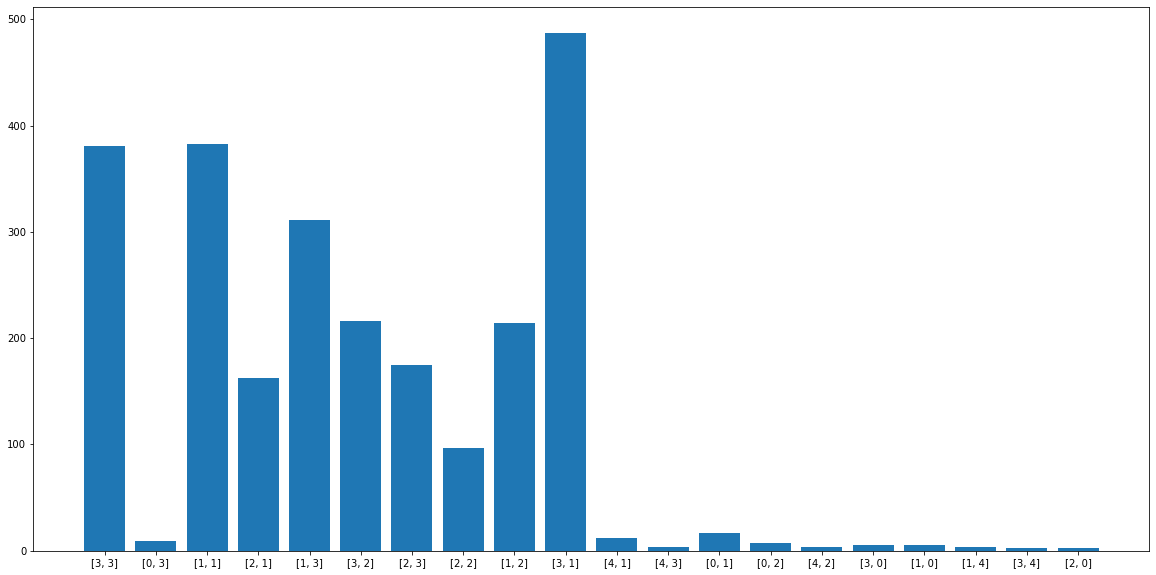

Processing Epoch 209
training start
Iteration 0, d real/fake loss 0.6668587923049927/0.6781195402145386 and g loss is 0.7942416071891785, NDiv loss 0.06836967170238495
Iteration 1, d real/fake loss 0.6652428507804871/0.6497718095779419 and g loss is 0.7535091638565063, NDiv loss 0.07223722338676453
Iteration 2, d real/fake loss 0.6636555194854736/0.678120493888855 and g loss is 0.7726647853851318, NDiv loss 0.08016621321439743
Iteration 3, d real/fake loss 0.6625791788101196/0.660616397857666 and g loss is 0.7717080116271973, NDiv loss 0.07527860254049301
Iteration 4, d real/fake loss 0.6617531180381775/0.6662164926528931 and g loss is 0.7637982368469238, NDiv loss 0.07359118014574051


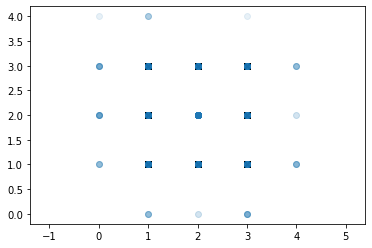

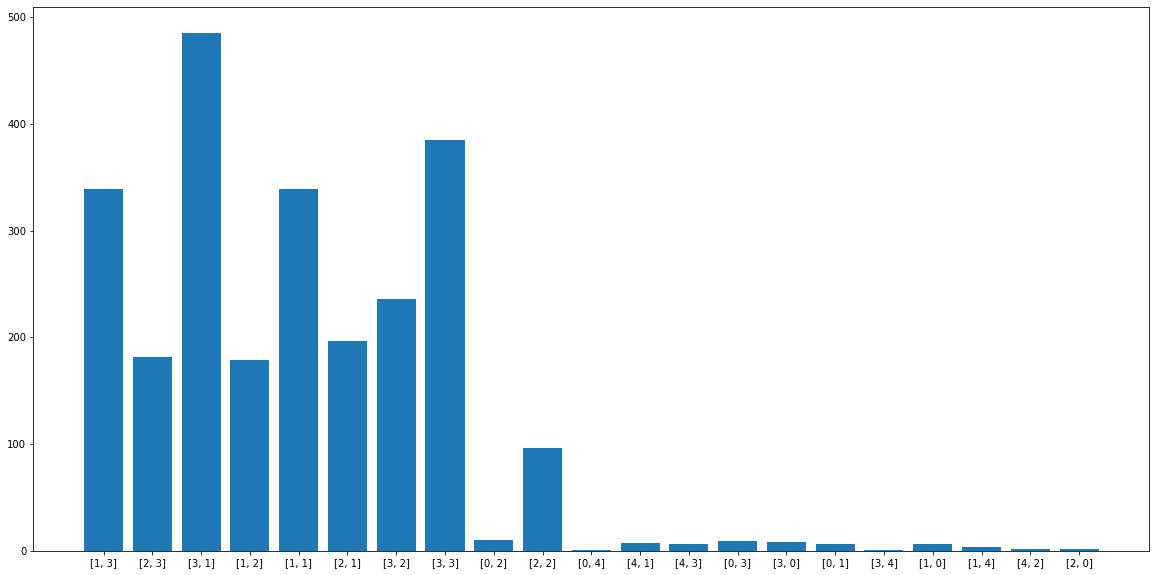

Processing Epoch 210
training start
Iteration 0, d real/fake loss 0.6298023462295532/0.6777490377426147 and g loss is 0.7575810551643372, NDiv loss 0.06815481185913086
Iteration 1, d real/fake loss 0.6309002637863159/0.6688361763954163 and g loss is 0.7782412767410278, NDiv loss 0.08269636332988739
Iteration 2, d real/fake loss 0.632430911064148/0.7126942873001099 and g loss is 0.8123874664306641, NDiv loss 0.07879708707332611
Iteration 3, d real/fake loss 0.6346015334129333/0.6648166179656982 and g loss is 0.7835712432861328, NDiv loss 0.07385202497243881
Iteration 4, d real/fake loss 0.6369545459747314/0.6777019500732422 and g loss is 0.7639646530151367, NDiv loss 0.08446837961673737


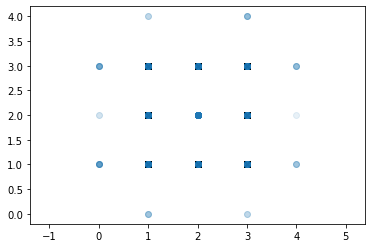

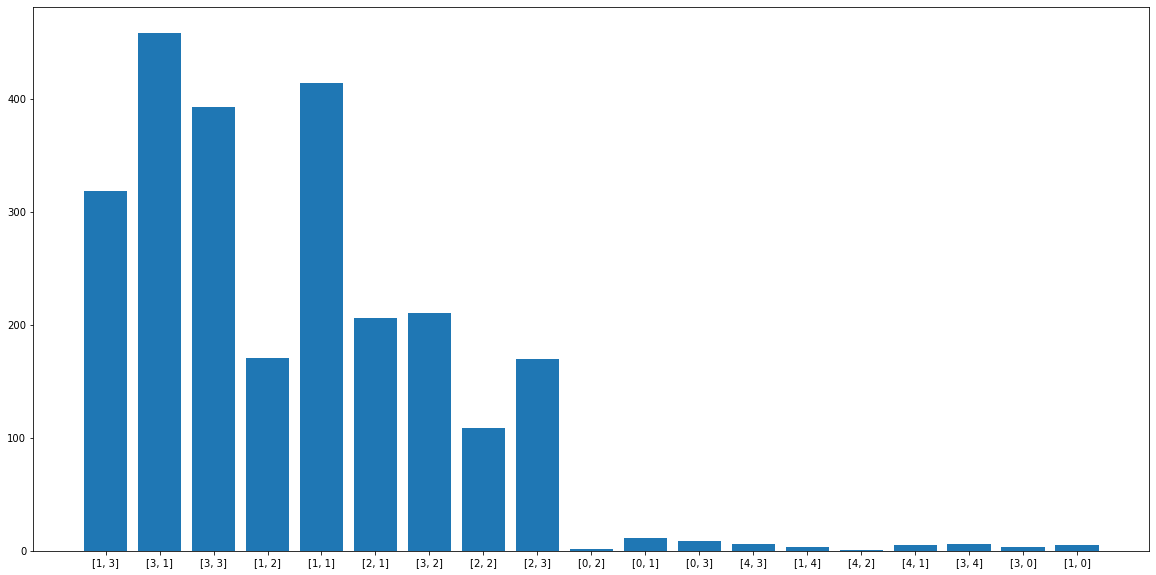

Processing Epoch 211
training start
Iteration 0, d real/fake loss 0.6692046523094177/0.7074984908103943 and g loss is 0.816650390625, NDiv loss 0.08087845891714096
Iteration 1, d real/fake loss 0.6705602407455444/0.6816385984420776 and g loss is 0.8253327012062073, NDiv loss 0.09773419797420502
Iteration 2, d real/fake loss 0.6711114048957825/0.6546527147293091 and g loss is 0.7742564678192139, NDiv loss 0.07071403414011002
Iteration 3, d real/fake loss 0.6709301471710205/0.6751896739006042 and g loss is 0.7915114164352417, NDiv loss 0.0757976770401001
Iteration 4, d real/fake loss 0.6701563596725464/0.6439163684844971 and g loss is 0.7995772361755371, NDiv loss 0.08086498826742172


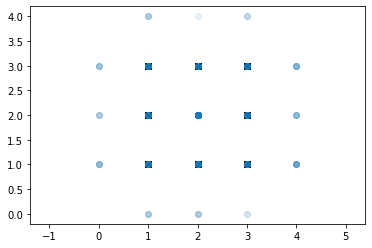

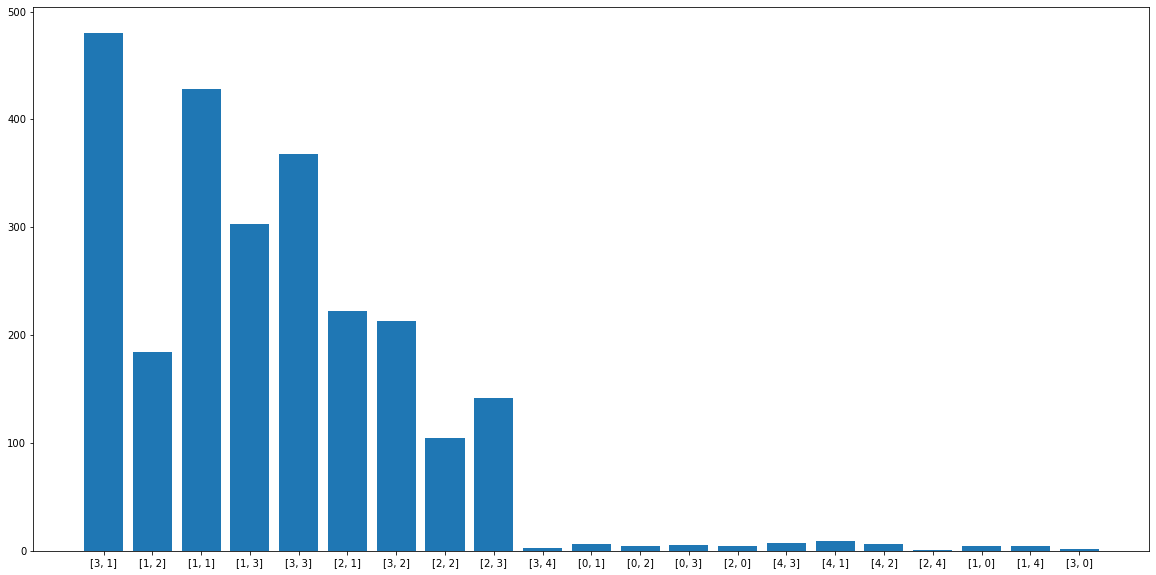

Processing Epoch 212
training start
Iteration 0, d real/fake loss 0.6494871377944946/0.6508588194847107 and g loss is 0.7722344994544983, NDiv loss 0.08182812482118607
Iteration 1, d real/fake loss 0.6492787003517151/0.6848161816596985 and g loss is 0.7291585206985474, NDiv loss 0.07742626965045929
Iteration 2, d real/fake loss 0.6494855284690857/0.6875094771385193 and g loss is 0.8251780271530151, NDiv loss 0.0827278271317482
Iteration 3, d real/fake loss 0.6499241590499878/0.6529195308685303 and g loss is 0.7212830185890198, NDiv loss 0.07597602158784866
Iteration 4, d real/fake loss 0.6501389741897583/0.6732310056686401 and g loss is 0.7907158732414246, NDiv loss 0.08842892199754715


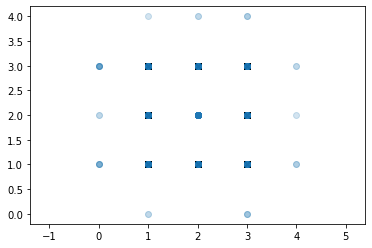

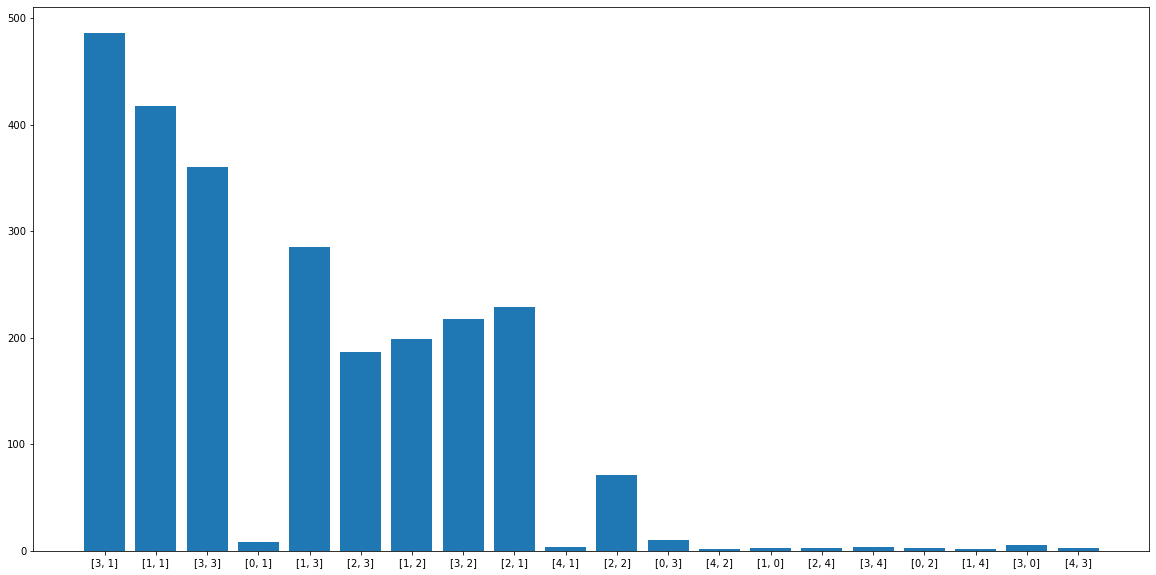

Processing Epoch 213
training start
Iteration 0, d real/fake loss 0.6891348958015442/0.6599102020263672 and g loss is 0.7474714517593384, NDiv loss 0.07839807868003845
Iteration 1, d real/fake loss 0.687893807888031/0.6658308506011963 and g loss is 0.7612417936325073, NDiv loss 0.08467291295528412
Iteration 2, d real/fake loss 0.6859003305435181/0.6644225716590881 and g loss is 0.7836619019508362, NDiv loss 0.08030598610639572
Iteration 3, d real/fake loss 0.6833831667900085/0.6419359445571899 and g loss is 0.7488337755203247, NDiv loss 0.08222798258066177
Iteration 4, d real/fake loss 0.6805391907691956/0.6555094718933105 and g loss is 0.757412850856781, NDiv loss 0.07233066856861115


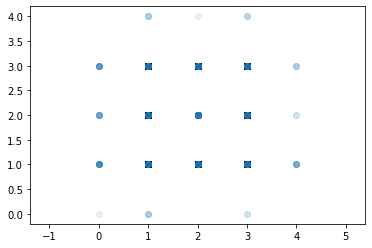

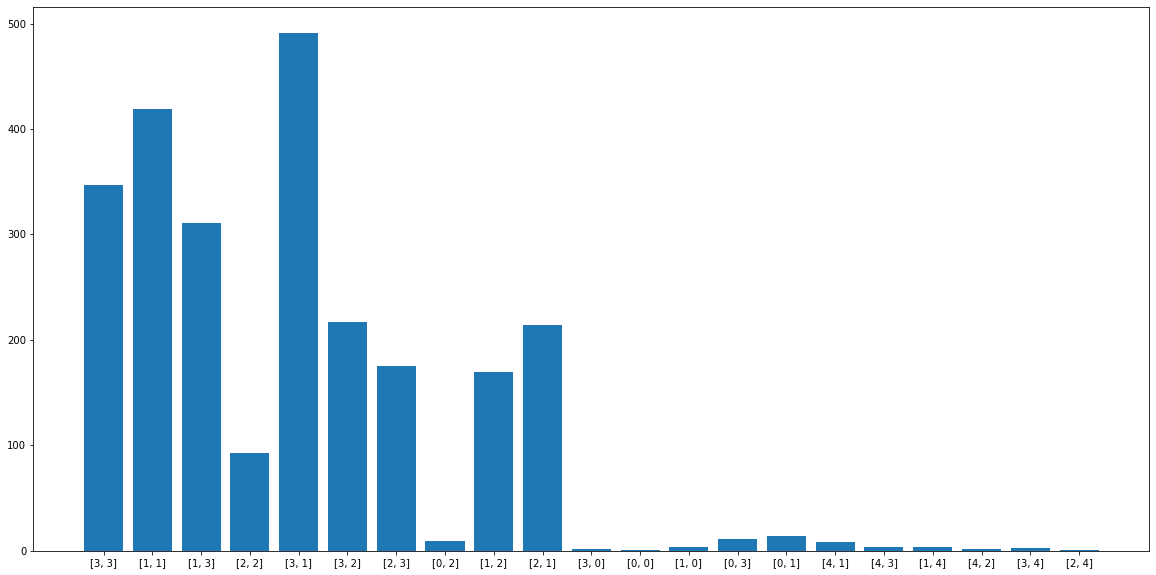

Processing Epoch 214
training start
Iteration 0, d real/fake loss 0.6665175557136536/0.684395432472229 and g loss is 0.749483048915863, NDiv loss 0.07624364644289017
Iteration 1, d real/fake loss 0.6648509502410889/0.6940425634384155 and g loss is 0.743955135345459, NDiv loss 0.092173270881176
Iteration 2, d real/fake loss 0.6634163856506348/0.6709351539611816 and g loss is 0.7918881773948669, NDiv loss 0.08331788331270218
Iteration 3, d real/fake loss 0.6620312333106995/0.6762205362319946 and g loss is 0.7455539703369141, NDiv loss 0.08205355703830719
Iteration 4, d real/fake loss 0.6610936522483826/0.6544533967971802 and g loss is 0.7850325107574463, NDiv loss 0.0858331173658371


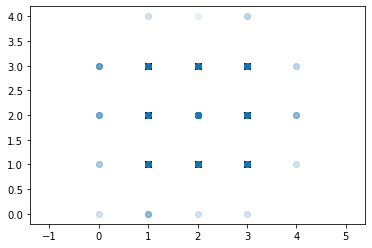

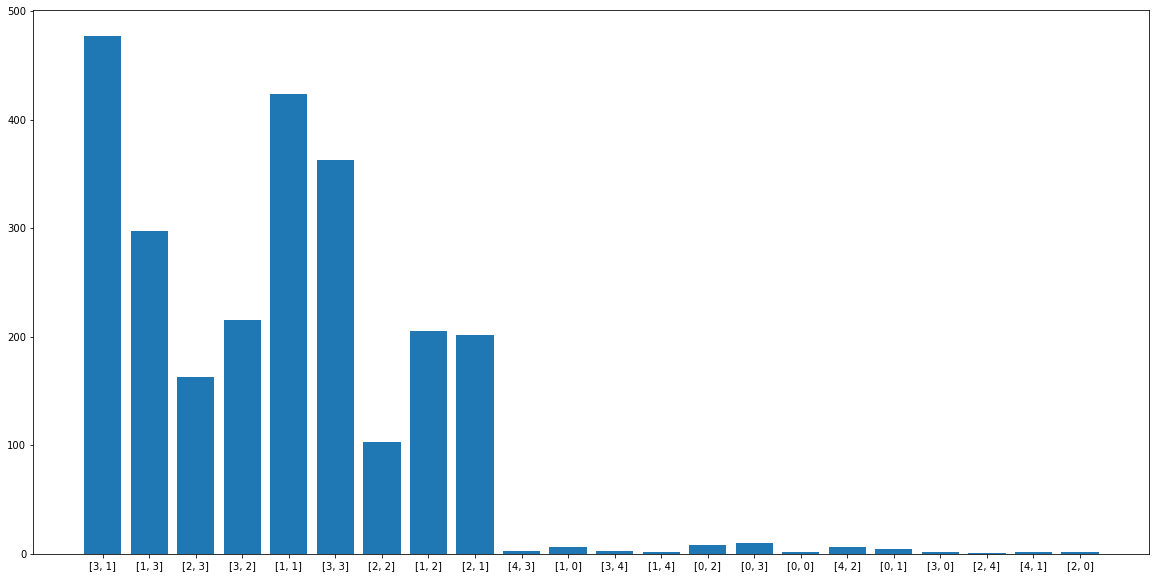

Processing Epoch 215
training start
Iteration 0, d real/fake loss 0.653538703918457/0.6849673390388489 and g loss is 0.7746422290802002, NDiv loss 0.07776064425706863
Iteration 1, d real/fake loss 0.6532434225082397/0.6712167263031006 and g loss is 0.7611716389656067, NDiv loss 0.07770126312971115
Iteration 2, d real/fake loss 0.6530899405479431/0.6605300903320312 and g loss is 0.7440563440322876, NDiv loss 0.08610707521438599
Iteration 3, d real/fake loss 0.6533603668212891/0.686301589012146 and g loss is 0.7516170740127563, NDiv loss 0.07385475188493729
Iteration 4, d real/fake loss 0.6538506746292114/0.6952075958251953 and g loss is 0.7245639562606812, NDiv loss 0.07740616053342819


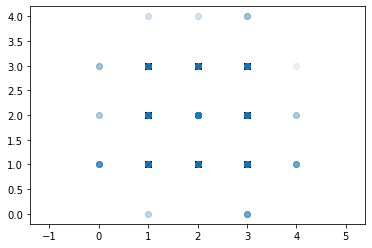

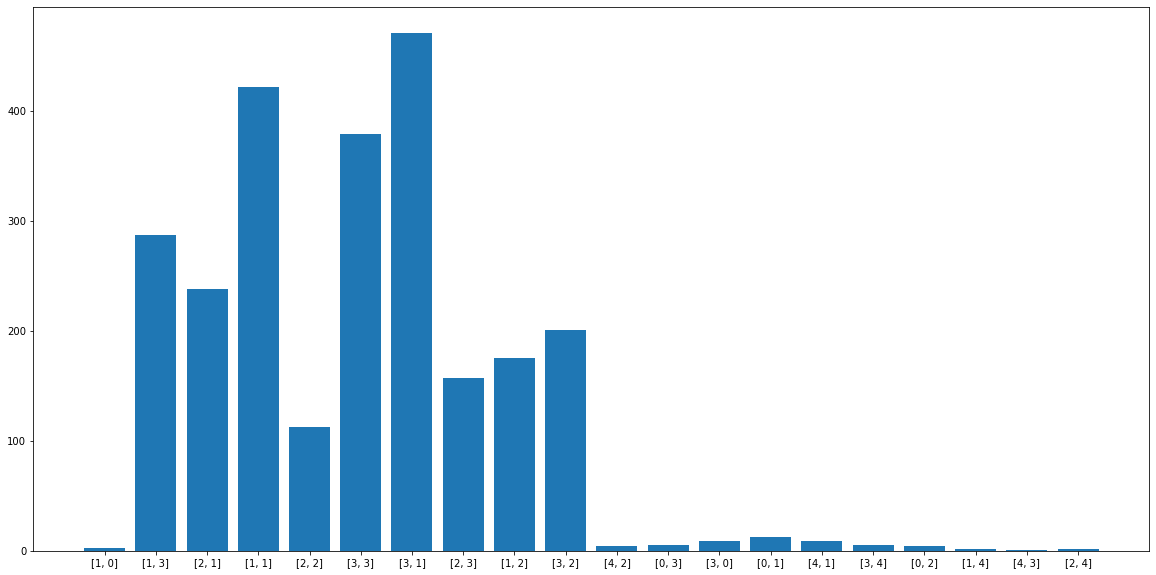

Processing Epoch 216
training start
Iteration 0, d real/fake loss 0.6718207001686096/0.6877040266990662 and g loss is 0.761505126953125, NDiv loss 0.07944528013467789
Iteration 1, d real/fake loss 0.672143816947937/0.6768109202384949 and g loss is 0.7535822987556458, NDiv loss 0.07926231622695923
Iteration 2, d real/fake loss 0.6722951531410217/0.6979395151138306 and g loss is 0.7762049436569214, NDiv loss 0.08430971950292587
Iteration 3, d real/fake loss 0.6724756360054016/0.6710066795349121 and g loss is 0.7271004915237427, NDiv loss 0.07740712910890579
Iteration 4, d real/fake loss 0.6723804473876953/0.6768252849578857 and g loss is 0.7766798138618469, NDiv loss 0.07521654665470123


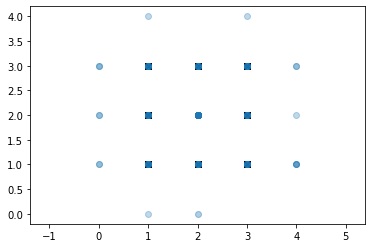

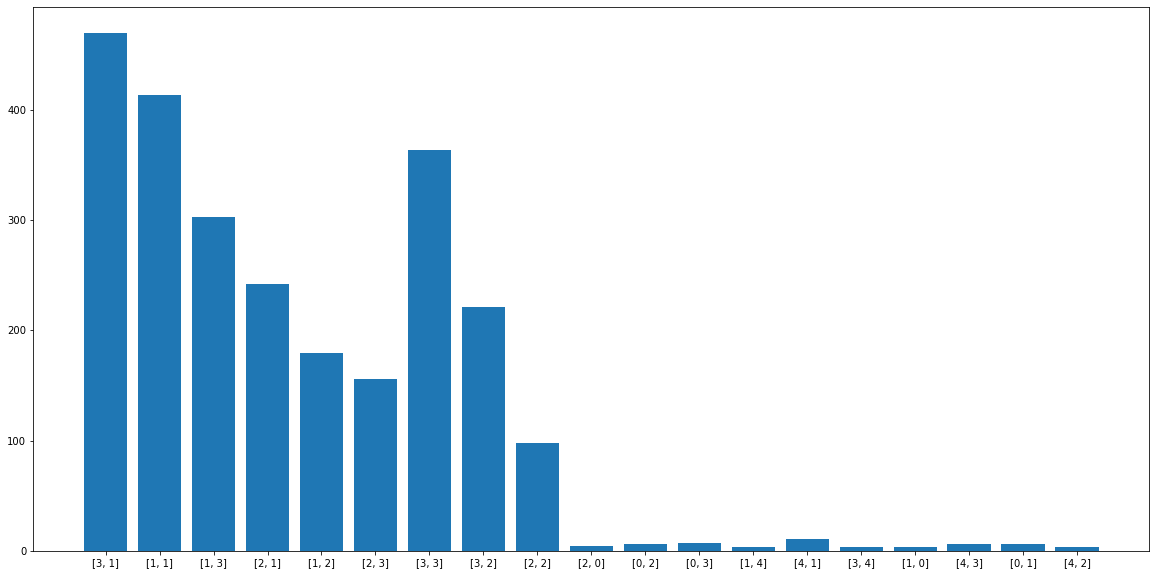

Processing Epoch 217
training start
Iteration 0, d real/fake loss 0.654460072517395/0.6848251819610596 and g loss is 0.7337096929550171, NDiv loss 0.08399394899606705
Iteration 1, d real/fake loss 0.6544186472892761/0.6777375936508179 and g loss is 0.8064888715744019, NDiv loss 0.09077940881252289
Iteration 2, d real/fake loss 0.6545217633247375/0.6464287042617798 and g loss is 0.7854253053665161, NDiv loss 0.09034761786460876
Iteration 3, d real/fake loss 0.654269814491272/0.679438591003418 and g loss is 0.7652722001075745, NDiv loss 0.08222203701734543
Iteration 4, d real/fake loss 0.654041051864624/0.6870560646057129 and g loss is 0.823395311832428, NDiv loss 0.07591715455055237


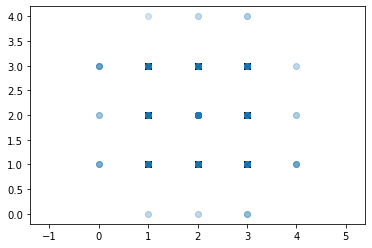

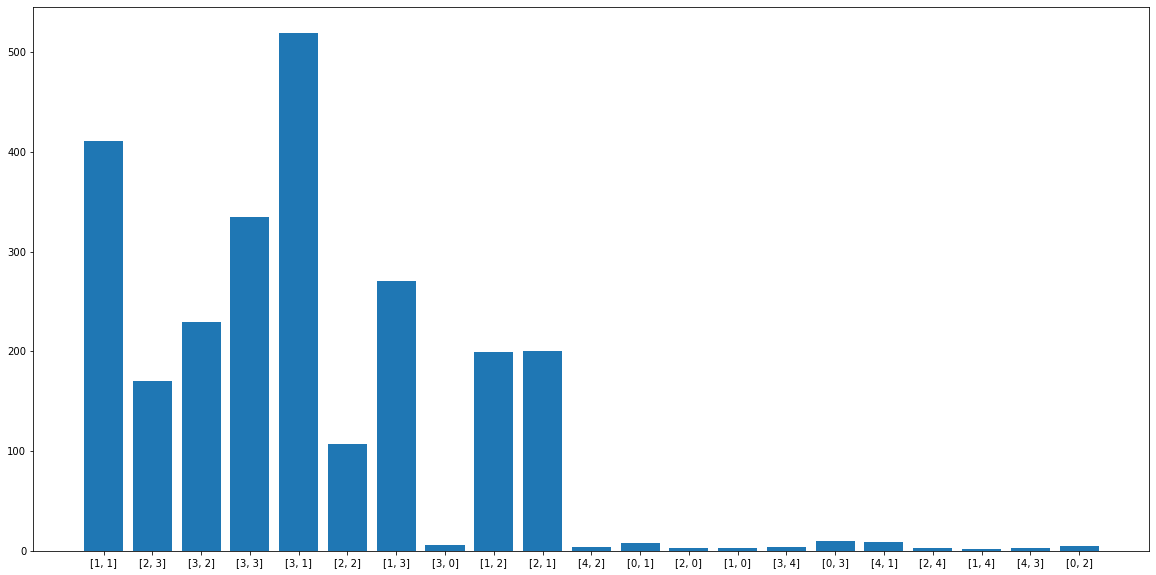

Processing Epoch 218
training start
Iteration 0, d real/fake loss 0.6623419523239136/0.7079288363456726 and g loss is 0.740889310836792, NDiv loss 0.08145903795957565
Iteration 1, d real/fake loss 0.6633408069610596/0.6918985843658447 and g loss is 0.8592642545700073, NDiv loss 0.08224189281463623
Iteration 2, d real/fake loss 0.6640559434890747/0.6689984202384949 and g loss is 0.7453100085258484, NDiv loss 0.08465364575386047
Iteration 3, d real/fake loss 0.6641625165939331/0.6768635511398315 and g loss is 0.7986464500427246, NDiv loss 0.08790919184684753
Iteration 4, d real/fake loss 0.6640470623970032/0.6506773233413696 and g loss is 0.7622596025466919, NDiv loss 0.08479199558496475


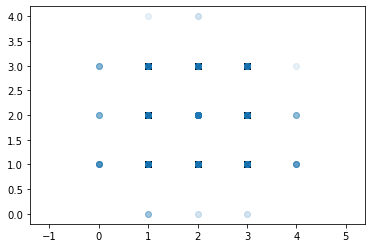

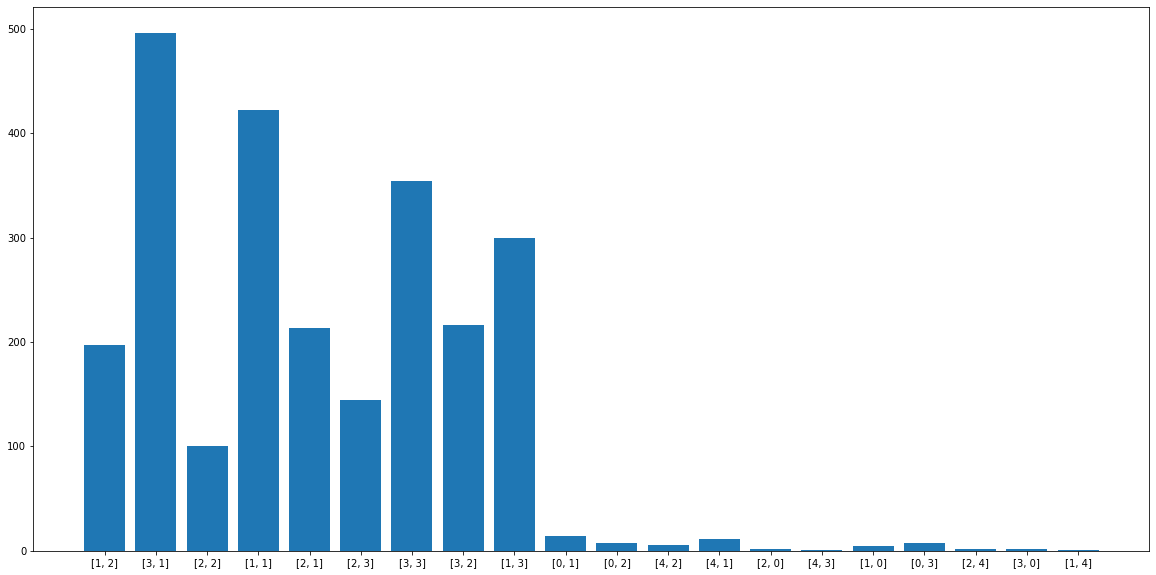

Processing Epoch 219
training start
Iteration 0, d real/fake loss 0.6550060510635376/0.652601420879364 and g loss is 0.7738626003265381, NDiv loss 0.07499932497739792
Iteration 1, d real/fake loss 0.6552665829658508/0.6620231866836548 and g loss is 0.7675294280052185, NDiv loss 0.07770618796348572
Iteration 2, d real/fake loss 0.6551759243011475/0.6850409507751465 and g loss is 0.7956287264823914, NDiv loss 0.07342670857906342
Iteration 3, d real/fake loss 0.6551774144172668/0.671851396560669 and g loss is 0.7874184846878052, NDiv loss 0.08865027129650116
Iteration 4, d real/fake loss 0.6548515558242798/0.6715825200080872 and g loss is 0.778343915939331, NDiv loss 0.07718571275472641


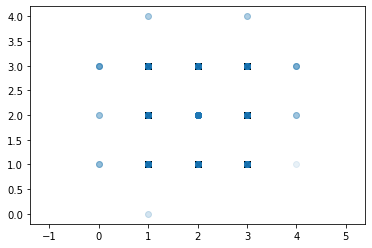

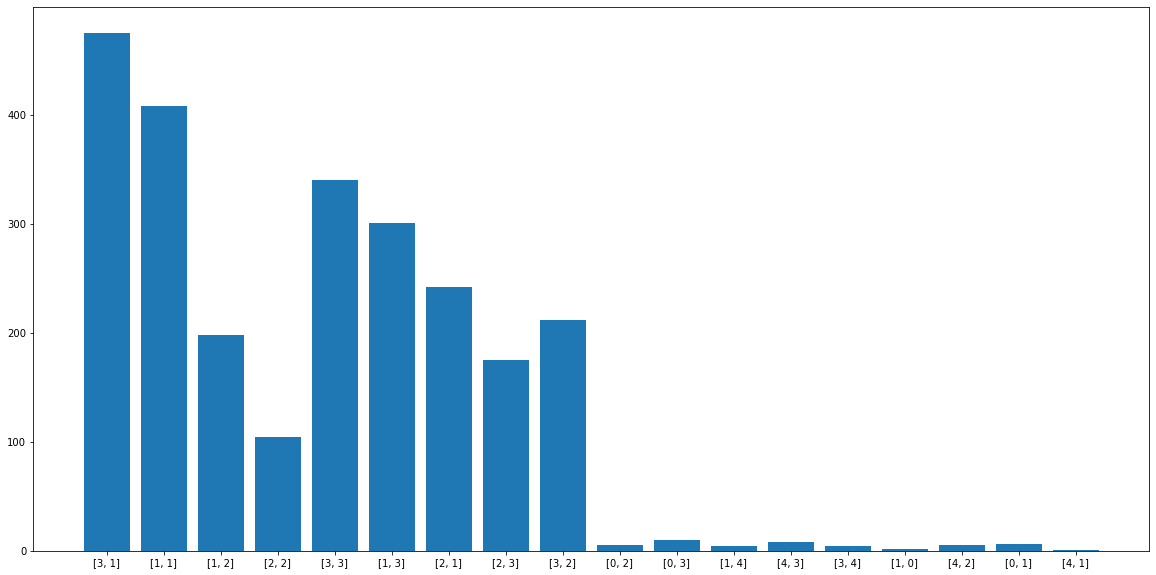

Processing Epoch 220
training start
Iteration 0, d real/fake loss 0.6768302917480469/0.6579306125640869 and g loss is 0.7774665355682373, NDiv loss 0.07664629071950912
Iteration 1, d real/fake loss 0.6762580871582031/0.6779438853263855 and g loss is 0.7885549664497375, NDiv loss 0.07632699608802795
Iteration 2, d real/fake loss 0.6751559972763062/0.6783348917961121 and g loss is 0.8056249618530273, NDiv loss 0.08244556933641434
Iteration 3, d real/fake loss 0.6737385988235474/0.6426876187324524 and g loss is 0.8049048781394958, NDiv loss 0.07238578051328659
Iteration 4, d real/fake loss 0.6722801923751831/0.6970053911209106 and g loss is 0.7714158296585083, NDiv loss 0.08752195537090302


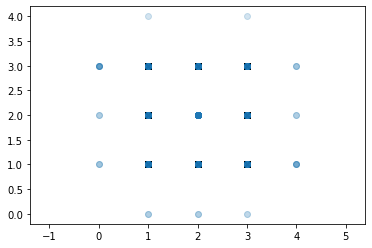

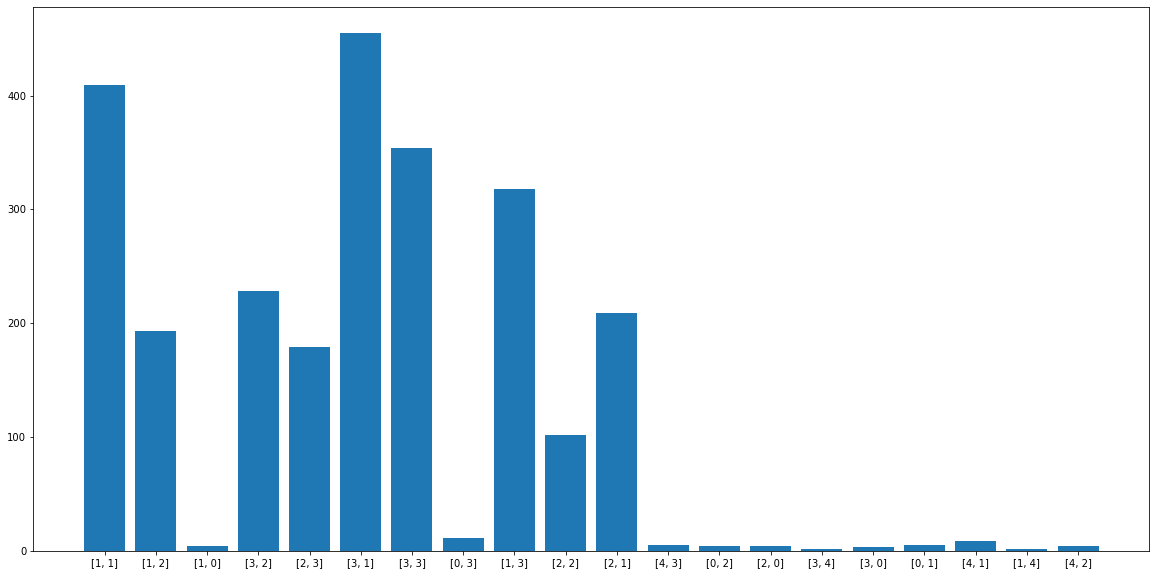

Processing Epoch 221
training start
Iteration 0, d real/fake loss 0.6573470830917358/0.6501660346984863 and g loss is 0.7894231081008911, NDiv loss 0.07379160076379776
Iteration 1, d real/fake loss 0.6561209559440613/0.6754026412963867 and g loss is 0.7710964679718018, NDiv loss 0.07460682839155197
Iteration 2, d real/fake loss 0.6553109288215637/0.6878966093063354 and g loss is 0.7828787565231323, NDiv loss 0.08869887888431549
Iteration 3, d real/fake loss 0.6550406217575073/0.6875983476638794 and g loss is 0.7718902826309204, NDiv loss 0.07246478646993637
Iteration 4, d real/fake loss 0.6550233960151672/0.6822817921638489 and g loss is 0.8055768609046936, NDiv loss 0.07807063311338425


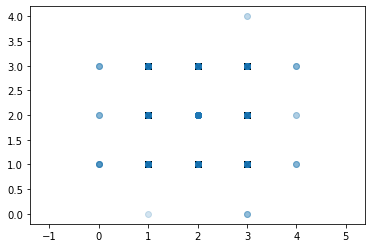

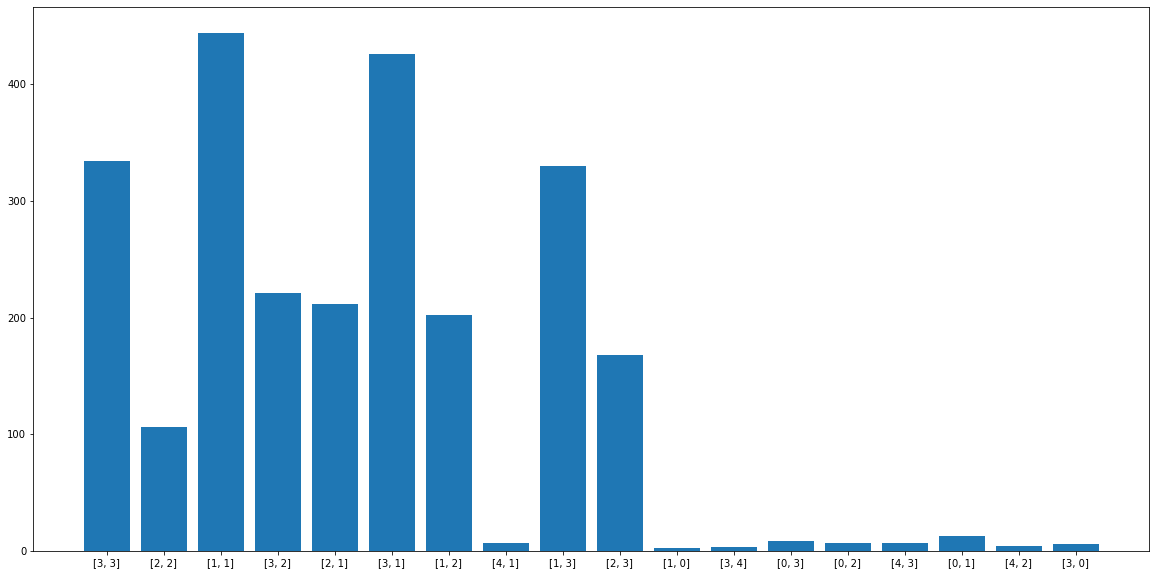

Processing Epoch 222
training start
Iteration 0, d real/fake loss 0.6420108079910278/0.6825318932533264 and g loss is 0.7514340877532959, NDiv loss 0.07392094284296036
Iteration 1, d real/fake loss 0.6431280374526978/0.6777250170707703 and g loss is 0.7596283555030823, NDiv loss 0.07962007820606232
Iteration 2, d real/fake loss 0.6438664793968201/0.6759257316589355 and g loss is 0.7624368667602539, NDiv loss 0.06890064477920532
Iteration 3, d real/fake loss 0.6443063020706177/0.6724546551704407 and g loss is 0.7767181396484375, NDiv loss 0.07774431258440018
Iteration 4, d real/fake loss 0.6446782350540161/0.6793286204338074 and g loss is 0.7865599393844604, NDiv loss 0.08406881988048553


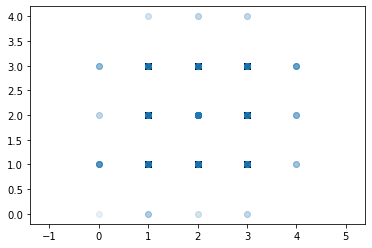

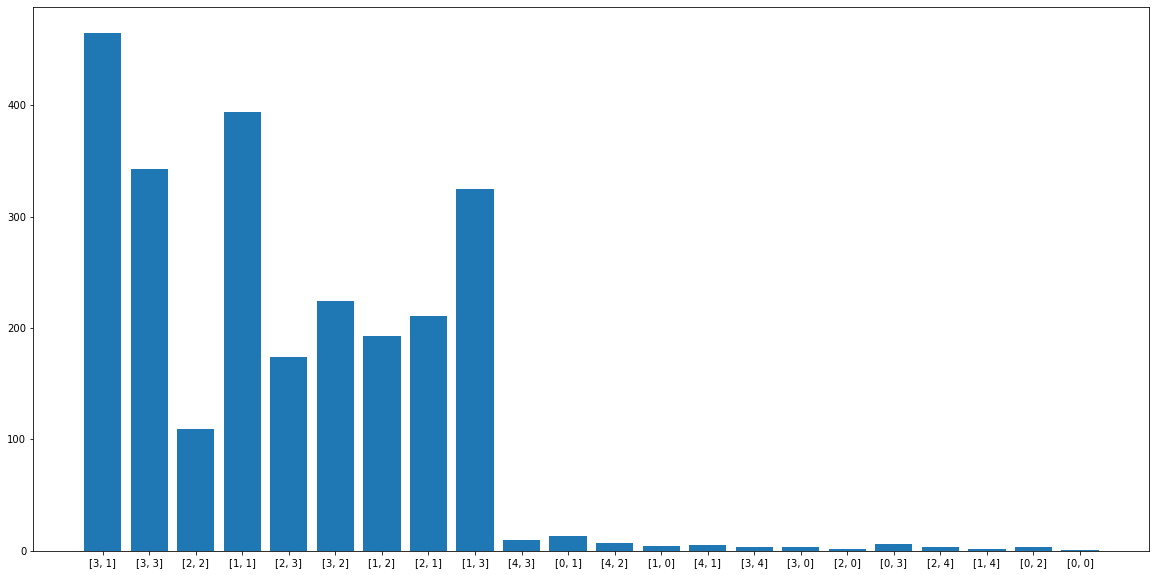

Processing Epoch 223
training start
Iteration 0, d real/fake loss 0.6891522407531738/0.6492108702659607 and g loss is 0.798712968826294, NDiv loss 0.0795443207025528
Iteration 1, d real/fake loss 0.6881243586540222/0.6870307922363281 and g loss is 0.7624839544296265, NDiv loss 0.09466221928596497
Iteration 2, d real/fake loss 0.6863976716995239/0.6791993975639343 and g loss is 0.7778647541999817, NDiv loss 0.09370013326406479
Iteration 3, d real/fake loss 0.6840131878852844/0.64735347032547 and g loss is 0.7483553886413574, NDiv loss 0.07927190512418747
Iteration 4, d real/fake loss 0.6808781623840332/0.6825159788131714 and g loss is 0.779760479927063, NDiv loss 0.07440170645713806


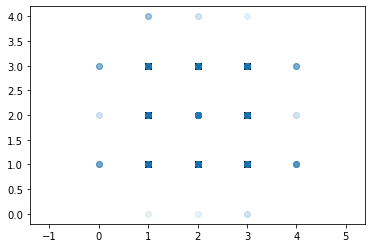

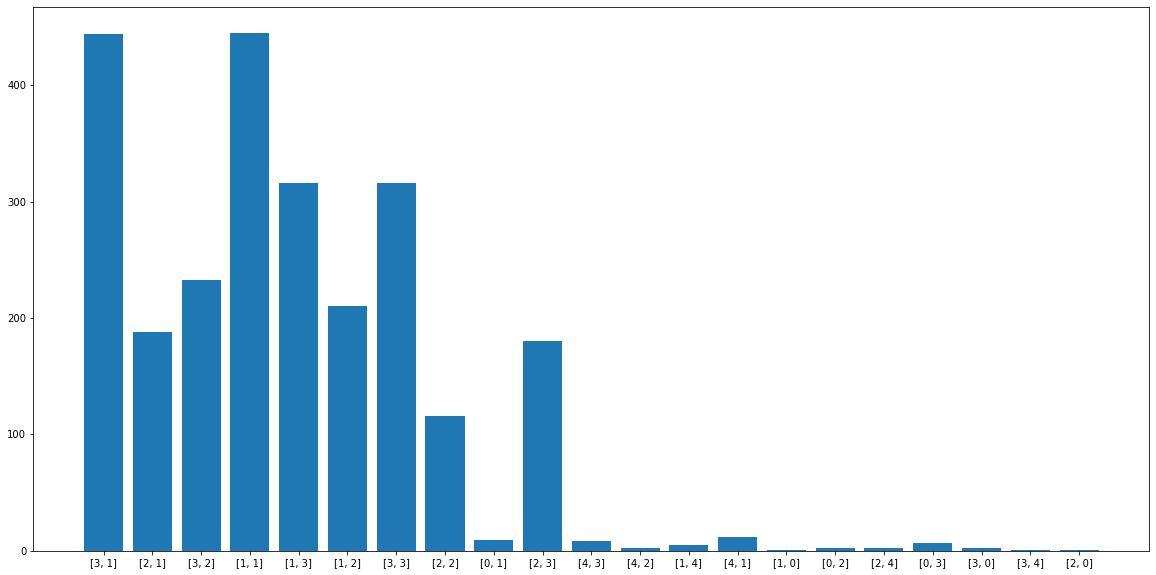

Processing Epoch 224
training start
Iteration 0, d real/fake loss 0.658363401889801/0.7168278098106384 and g loss is 0.7442268133163452, NDiv loss 0.09120680391788483
Iteration 1, d real/fake loss 0.6573399305343628/0.6890934109687805 and g loss is 0.7693034410476685, NDiv loss 0.08084969967603683
Iteration 2, d real/fake loss 0.656719982624054/0.6775090098381042 and g loss is 0.7456479072570801, NDiv loss 0.08312761783599854
Iteration 3, d real/fake loss 0.6561848521232605/0.7048115134239197 and g loss is 0.7400729060173035, NDiv loss 0.07364707440137863
Iteration 4, d real/fake loss 0.6560741662979126/0.6757431030273438 and g loss is 0.7396900653839111, NDiv loss 0.0761694461107254


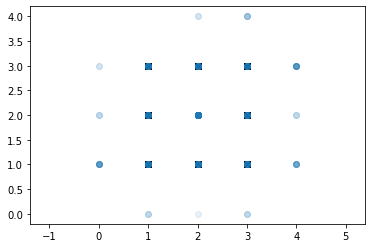

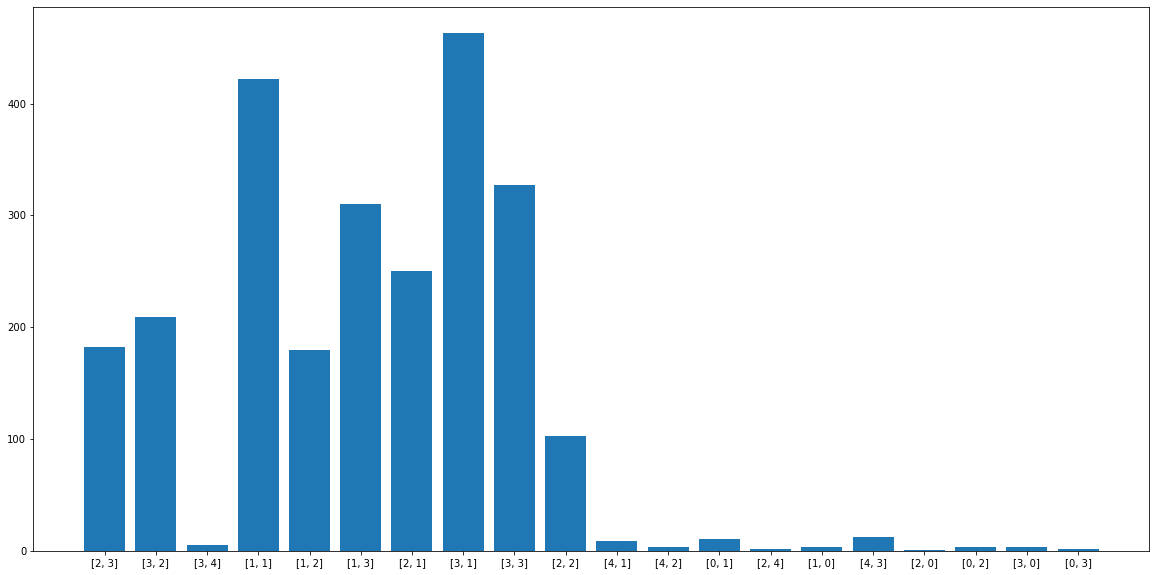

Processing Epoch 225
training start
Iteration 0, d real/fake loss 0.642472505569458/0.6662958264350891 and g loss is 0.7810983657836914, NDiv loss 0.07285531610250473
Iteration 1, d real/fake loss 0.6437790393829346/0.6495362520217896 and g loss is 0.7699760794639587, NDiv loss 0.07762114703655243
Iteration 2, d real/fake loss 0.6448013782501221/0.6657800674438477 and g loss is 0.7886889576911926, NDiv loss 0.07074160873889923
Iteration 3, d real/fake loss 0.6458047032356262/0.6738848686218262 and g loss is 0.7681726217269897, NDiv loss 0.08062471449375153
Iteration 4, d real/fake loss 0.6468215584754944/0.6731382608413696 and g loss is 0.8105027675628662, NDiv loss 0.09509801119565964


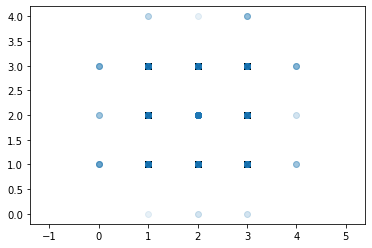

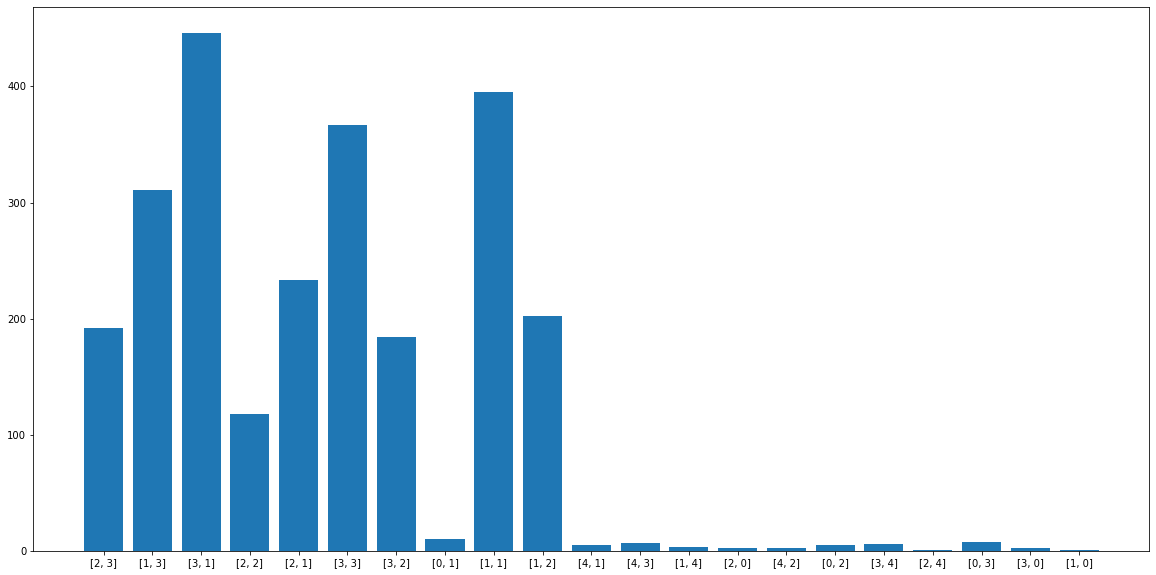

Processing Epoch 226
training start
Iteration 0, d real/fake loss 0.641528308391571/0.6678873896598816 and g loss is 0.7208319902420044, NDiv loss 0.0731566846370697
Iteration 1, d real/fake loss 0.6430202126502991/0.6941092014312744 and g loss is 0.7806148529052734, NDiv loss 0.07147572189569473
Iteration 2, d real/fake loss 0.6442909240722656/0.6502552628517151 and g loss is 0.7862375378608704, NDiv loss 0.07822614163160324
Iteration 3, d real/fake loss 0.6448913812637329/0.6751104593276978 and g loss is 0.8080234527587891, NDiv loss 0.08280877768993378
Iteration 4, d real/fake loss 0.64539635181427/0.672309160232544 and g loss is 0.7715930342674255, NDiv loss 0.0730973407626152


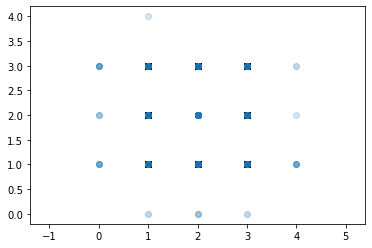

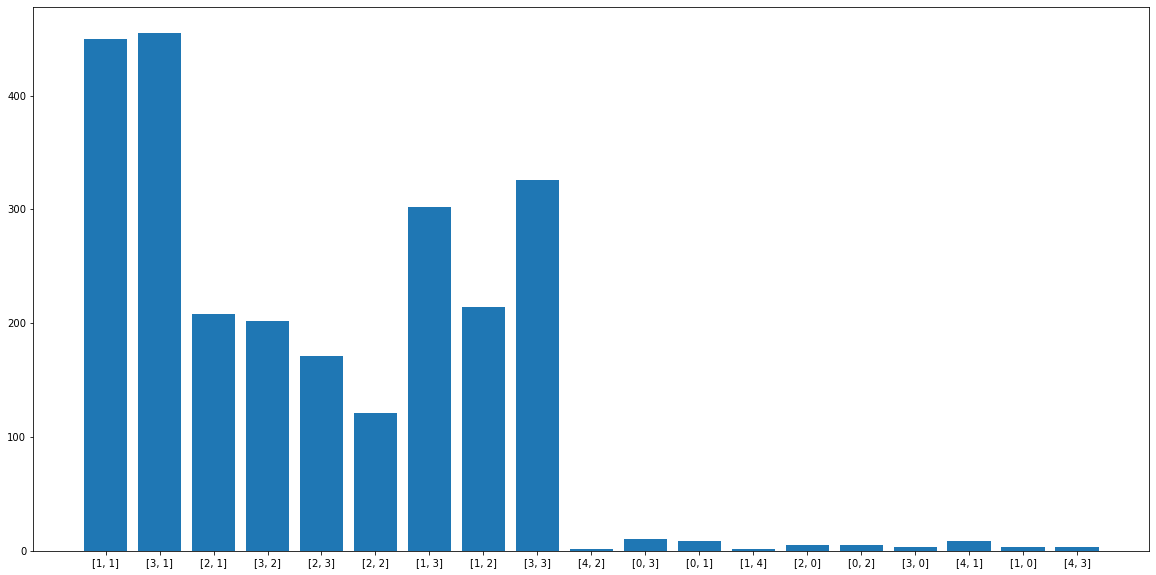

Processing Epoch 227
training start
Iteration 0, d real/fake loss 0.6766921877861023/0.6529212594032288 and g loss is 0.8285373449325562, NDiv loss 0.07776552438735962
Iteration 1, d real/fake loss 0.6763172149658203/0.6536052227020264 and g loss is 0.7571921944618225, NDiv loss 0.08164182305335999
Iteration 2, d real/fake loss 0.6751902103424072/0.6745860576629639 and g loss is 0.8140290975570679, NDiv loss 0.07825825363397598
Iteration 3, d real/fake loss 0.6738154292106628/0.682130753993988 and g loss is 0.8469791412353516, NDiv loss 0.07536178082227707
Iteration 4, d real/fake loss 0.6725953817367554/0.6676943898200989 and g loss is 0.7688700556755066, NDiv loss 0.06947845965623856


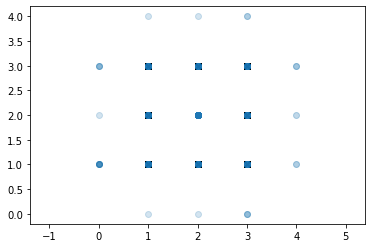

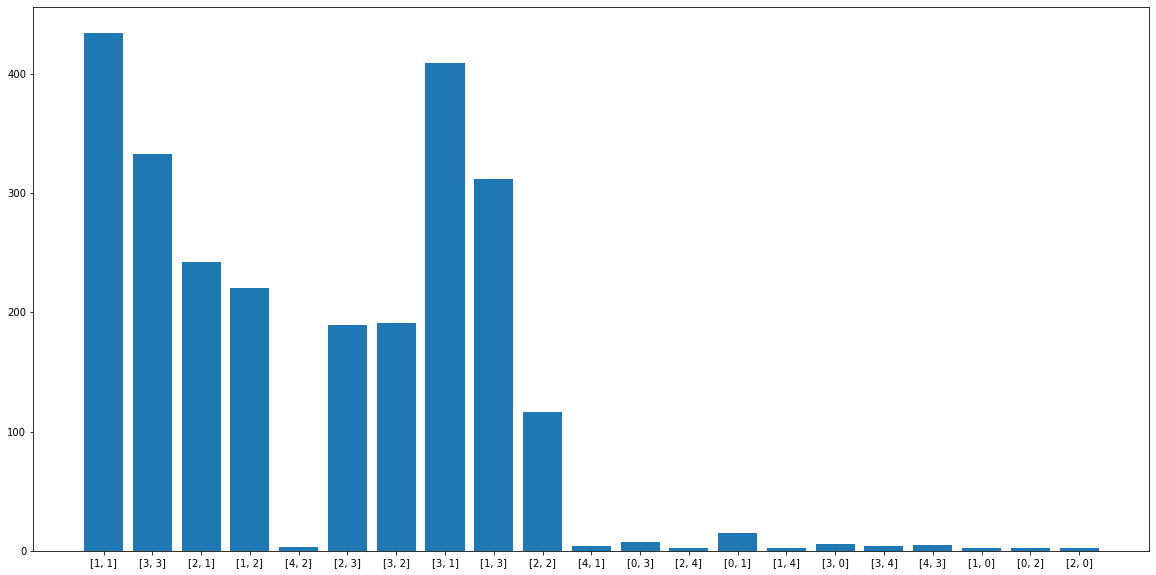

Processing Epoch 228
training start
Iteration 0, d real/fake loss 0.6569718718528748/0.6644370555877686 and g loss is 0.8392878174781799, NDiv loss 0.0698021948337555
Iteration 1, d real/fake loss 0.6560864448547363/0.691197395324707 and g loss is 0.7738364934921265, NDiv loss 0.08517763018608093
Iteration 2, d real/fake loss 0.6557179093360901/0.6917757391929626 and g loss is 0.8208789825439453, NDiv loss 0.09036599099636078
Iteration 3, d real/fake loss 0.6560535430908203/0.6907902956008911 and g loss is 0.8095307350158691, NDiv loss 0.08122215420007706
Iteration 4, d real/fake loss 0.6568450927734375/0.6637282371520996 and g loss is 0.8341540694236755, NDiv loss 0.07748619467020035


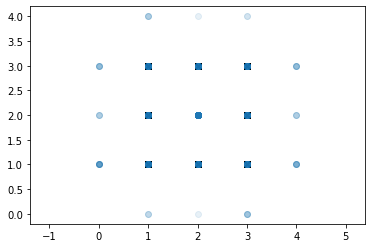

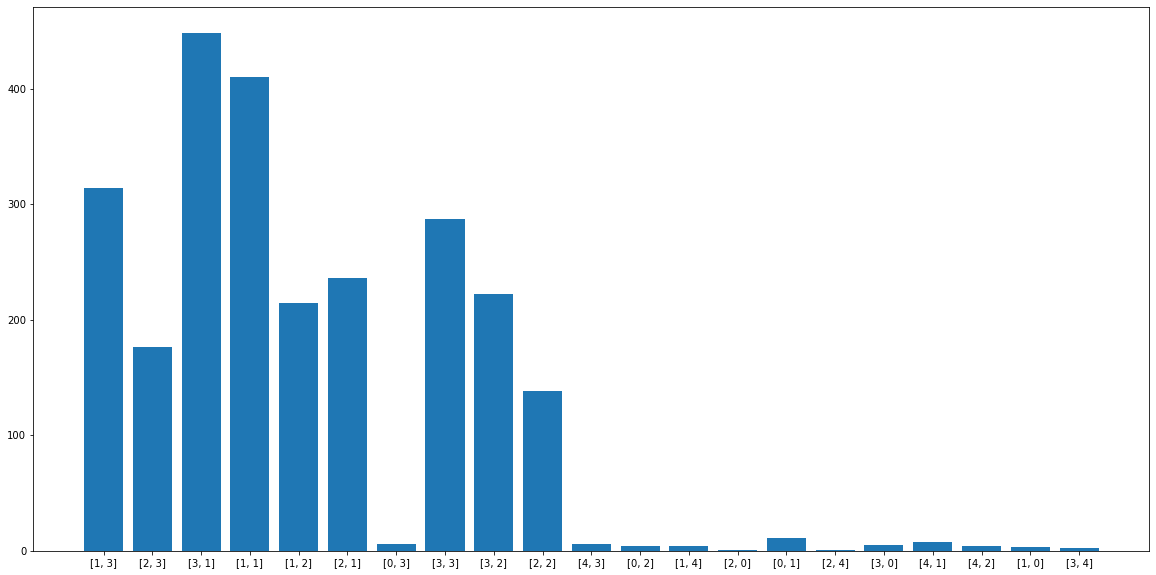

Processing Epoch 229
training start
Iteration 0, d real/fake loss 0.6594786643981934/0.6592093706130981 and g loss is 0.8198144435882568, NDiv loss 0.09154023975133896
Iteration 1, d real/fake loss 0.6592040657997131/0.6806997060775757 and g loss is 0.7795398831367493, NDiv loss 0.07740388065576553
Iteration 2, d real/fake loss 0.6586480736732483/0.6760030388832092 and g loss is 0.7386987209320068, NDiv loss 0.07003114372491837
Iteration 3, d real/fake loss 0.658133327960968/0.6881110668182373 and g loss is 0.7636747360229492, NDiv loss 0.08064675331115723
Iteration 4, d real/fake loss 0.657800018787384/0.6840975880622864 and g loss is 0.7774742245674133, NDiv loss 0.07865595072507858


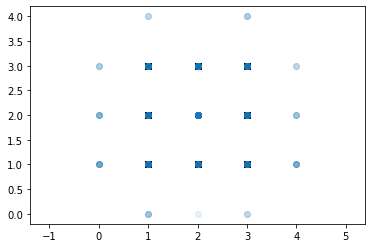

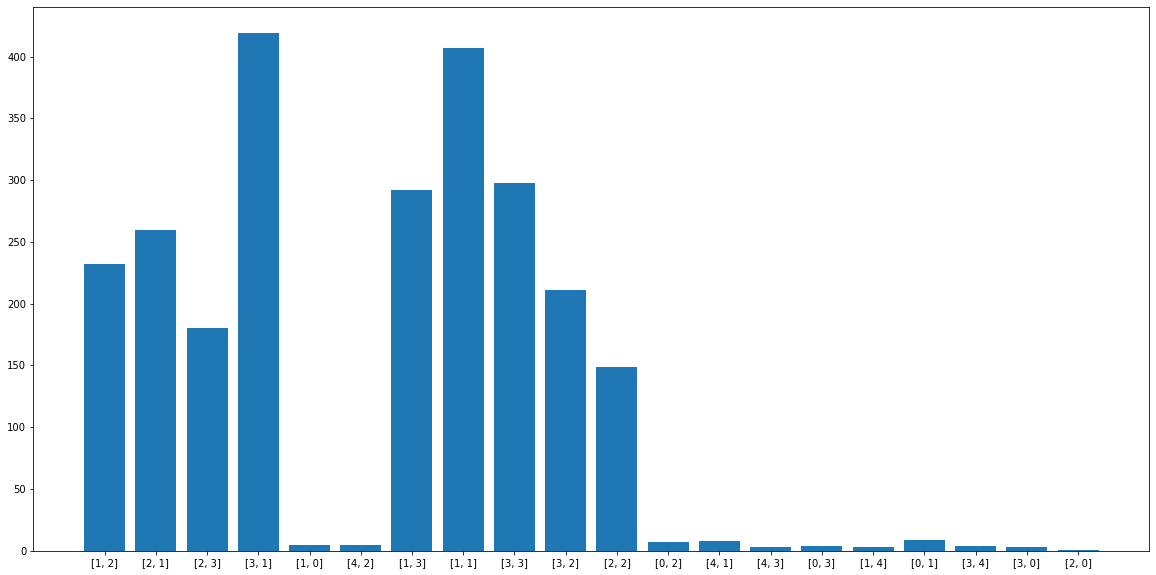

Processing Epoch 230
training start
Iteration 0, d real/fake loss 0.6824673414230347/0.6798421144485474 and g loss is 0.7772493362426758, NDiv loss 0.0851273387670517
Iteration 1, d real/fake loss 0.6815756559371948/0.6508134603500366 and g loss is 0.7755980491638184, NDiv loss 0.07825987786054611
Iteration 2, d real/fake loss 0.6799585819244385/0.6780605316162109 and g loss is 0.7843444347381592, NDiv loss 0.08413369953632355
Iteration 3, d real/fake loss 0.6780595183372498/0.6678699254989624 and g loss is 0.8508790731430054, NDiv loss 0.07677435874938965
Iteration 4, d real/fake loss 0.6757938861846924/0.6730332374572754 and g loss is 0.7708108425140381, NDiv loss 0.0758616253733635


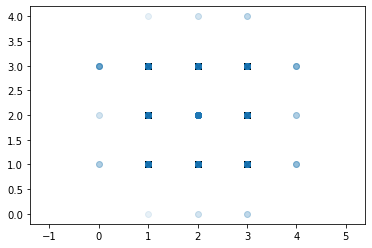

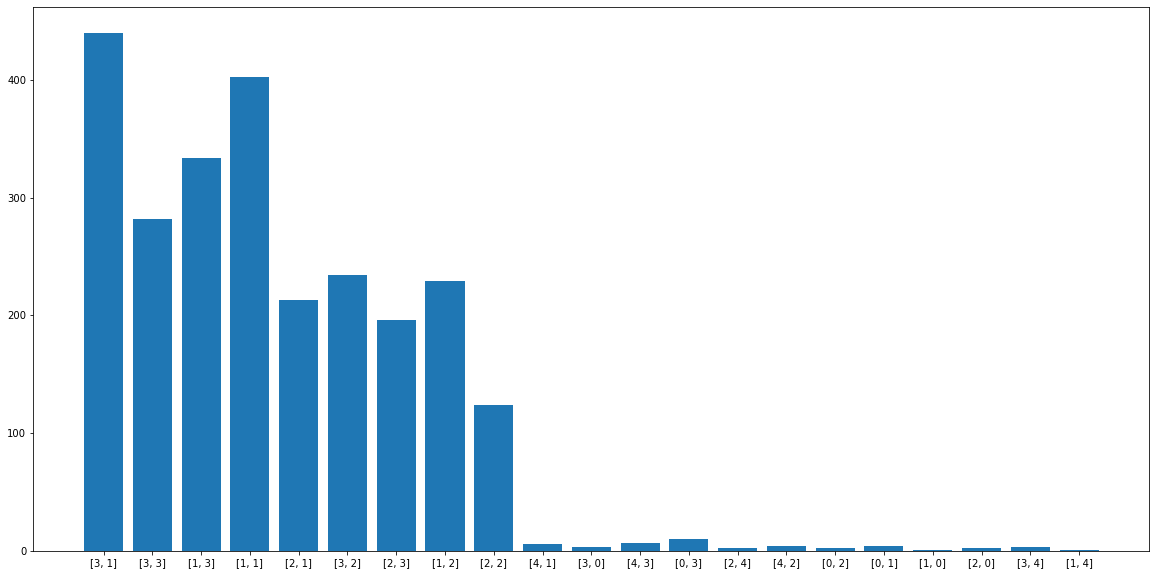

Processing Epoch 231
training start
Iteration 0, d real/fake loss 0.6564207673072815/0.6577318906784058 and g loss is 0.7462670207023621, NDiv loss 0.06534603983163834
Iteration 1, d real/fake loss 0.6550158262252808/0.6802577972412109 and g loss is 0.7438274621963501, NDiv loss 0.08535358309745789
Iteration 2, d real/fake loss 0.6542403101921082/0.6894135475158691 and g loss is 0.7143387794494629, NDiv loss 0.08872507512569427
Iteration 3, d real/fake loss 0.6537055969238281/0.6822816133499146 and g loss is 0.7752557992935181, NDiv loss 0.07768324762582779
Iteration 4, d real/fake loss 0.6533750295639038/0.6979526281356812 and g loss is 0.7479737997055054, NDiv loss 0.07816801965236664


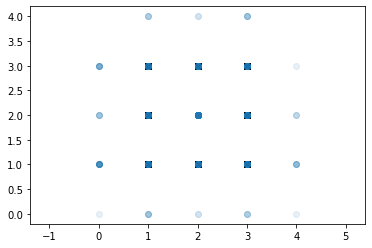

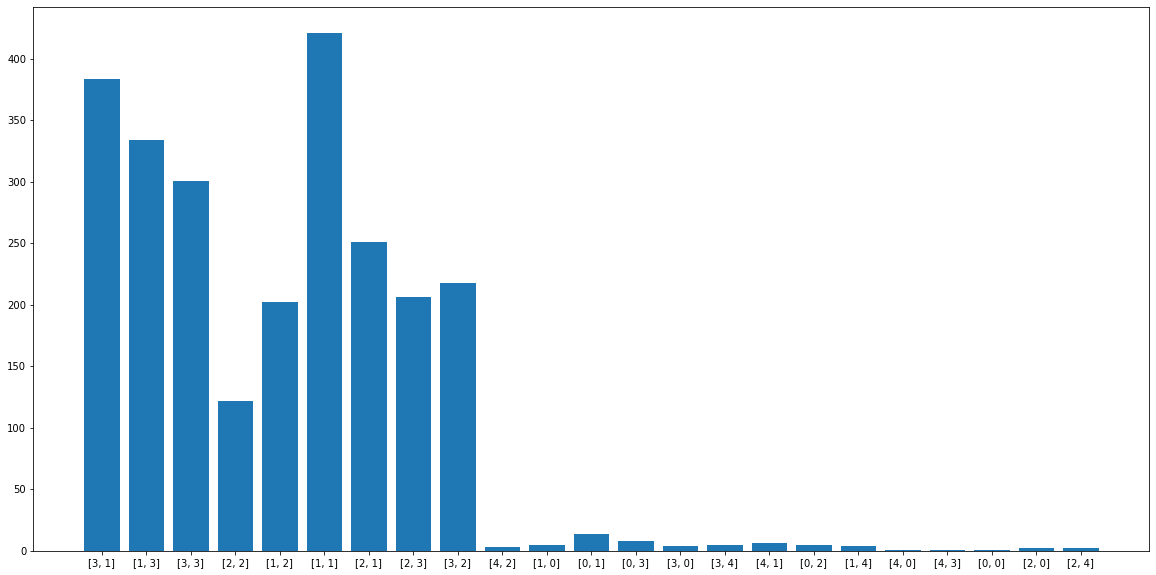

Processing Epoch 232
training start
Iteration 0, d real/fake loss 0.6276723146438599/0.682114839553833 and g loss is 0.7648204565048218, NDiv loss 0.06963878124952316
Iteration 1, d real/fake loss 0.6289176344871521/0.7020350694656372 and g loss is 0.7736024856567383, NDiv loss 0.07712104171514511
Iteration 2, d real/fake loss 0.6309381127357483/0.6586772203445435 and g loss is 0.8620789051055908, NDiv loss 0.07885751873254776
Iteration 3, d real/fake loss 0.6329033374786377/0.6704015731811523 and g loss is 0.7491924166679382, NDiv loss 0.07633915543556213
Iteration 4, d real/fake loss 0.6349052786827087/0.685121476650238 and g loss is 0.775646984577179, NDiv loss 0.08608575165271759


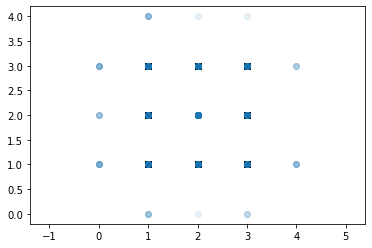

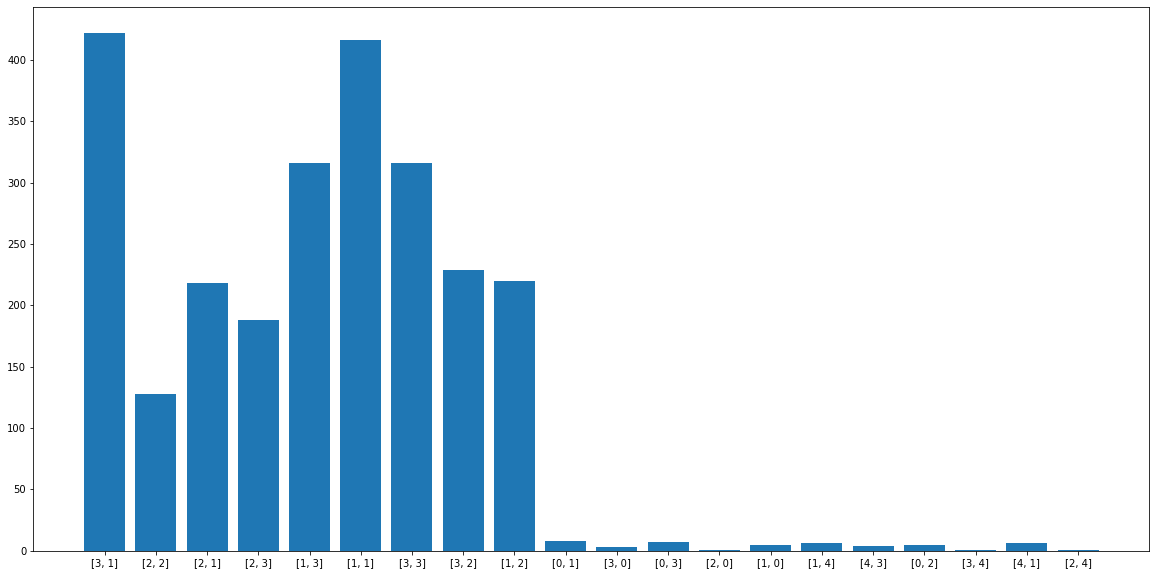

Processing Epoch 233
training start
Iteration 0, d real/fake loss 0.658501386642456/0.6886004209518433 and g loss is 0.8139739632606506, NDiv loss 0.07113094627857208
Iteration 1, d real/fake loss 0.6602602005004883/0.6556590795516968 and g loss is 0.8070594072341919, NDiv loss 0.0726318284869194
Iteration 2, d real/fake loss 0.6612253785133362/0.6644558906555176 and g loss is 0.8058524131774902, NDiv loss 0.07651997357606888
Iteration 3, d real/fake loss 0.6618666052818298/0.6821591854095459 and g loss is 0.783484160900116, NDiv loss 0.075550377368927
Iteration 4, d real/fake loss 0.6622862815856934/0.7014372944831848 and g loss is 0.7873995304107666, NDiv loss 0.07323936372995377


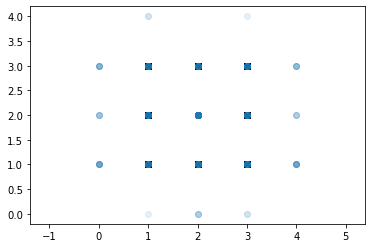

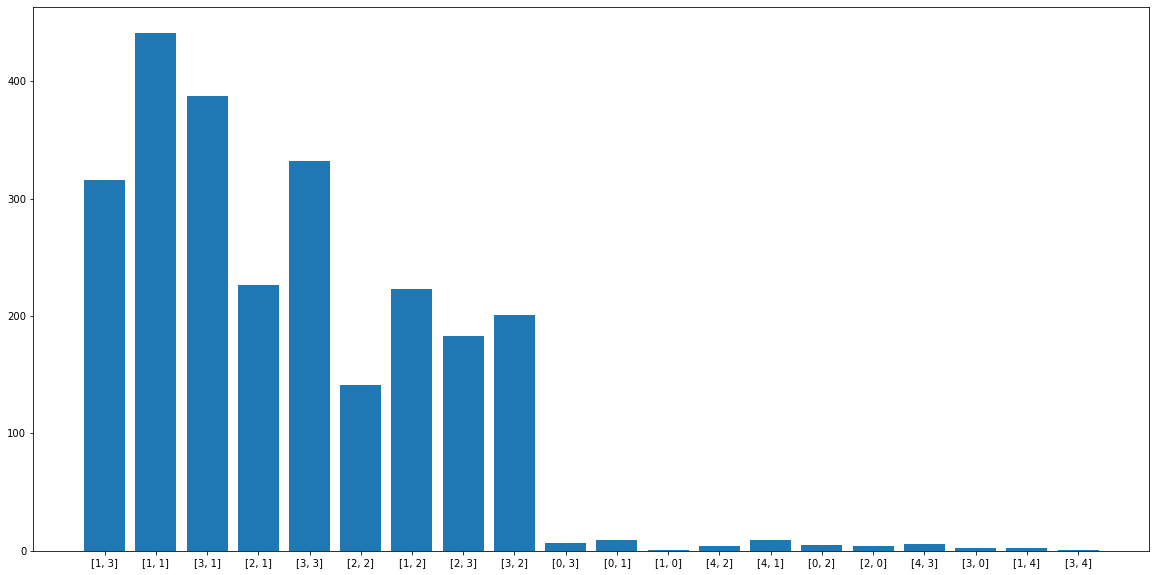

Processing Epoch 234
training start
Iteration 0, d real/fake loss 0.6687383651733398/0.6556205153465271 and g loss is 0.8093379735946655, NDiv loss 0.08089268952608109
Iteration 1, d real/fake loss 0.6676746606826782/0.6506279706954956 and g loss is 0.7805131673812866, NDiv loss 0.08729575574398041
Iteration 2, d real/fake loss 0.6657813191413879/0.6792945265769958 and g loss is 0.7760358452796936, NDiv loss 0.07982403039932251
Iteration 3, d real/fake loss 0.6642292141914368/0.6698440909385681 and g loss is 0.7528212070465088, NDiv loss 0.07666254788637161
Iteration 4, d real/fake loss 0.662858247756958/0.6502900123596191 and g loss is 0.8226236701011658, NDiv loss 0.07029590010643005


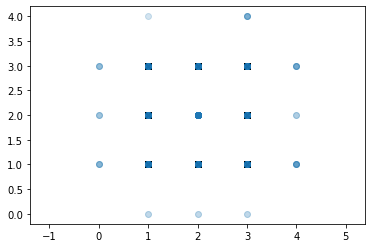

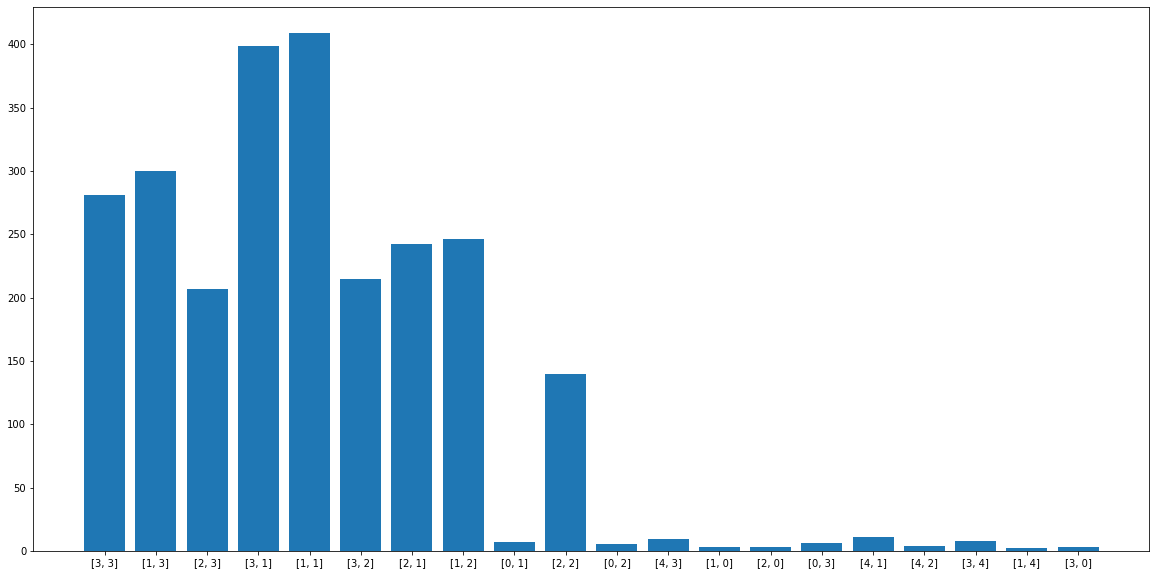

Processing Epoch 235
training start
Iteration 0, d real/fake loss 0.6514850854873657/0.6655421257019043 and g loss is 0.7951944470405579, NDiv loss 0.07161281257867813
Iteration 1, d real/fake loss 0.6507654190063477/0.6547049283981323 and g loss is 0.7616825103759766, NDiv loss 0.08355160802602768
Iteration 2, d real/fake loss 0.6501906514167786/0.6911184787750244 and g loss is 0.8005208969116211, NDiv loss 0.07205191254615784
Iteration 3, d real/fake loss 0.6496418714523315/0.671785831451416 and g loss is 0.7909942865371704, NDiv loss 0.07077533006668091
Iteration 4, d real/fake loss 0.6493602991104126/0.6789714097976685 and g loss is 0.7153282165527344, NDiv loss 0.08222666382789612


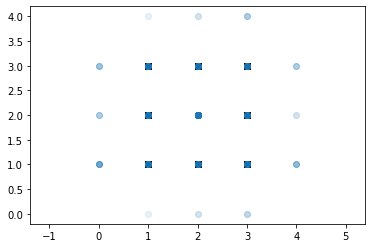

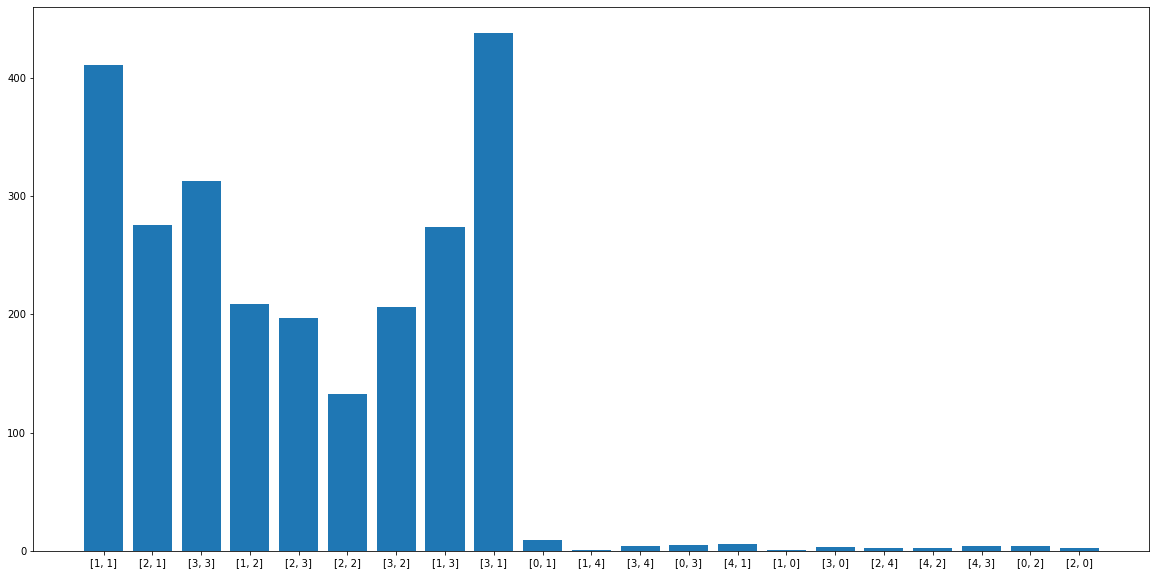

Processing Epoch 236
training start
Iteration 0, d real/fake loss 0.6585568189620972/0.6889281868934631 and g loss is 0.7416988015174866, NDiv loss 0.07294617593288422
Iteration 1, d real/fake loss 0.6586198806762695/0.6808739900588989 and g loss is 0.8294011950492859, NDiv loss 0.07457476109266281
Iteration 2, d real/fake loss 0.6586135625839233/0.6542664766311646 and g loss is 0.7288507223129272, NDiv loss 0.07567053288221359
Iteration 3, d real/fake loss 0.6580610275268555/0.6711883544921875 and g loss is 0.7809702157974243, NDiv loss 0.07692128419876099
Iteration 4, d real/fake loss 0.6574680805206299/0.6536865234375 and g loss is 0.762871265411377, NDiv loss 0.07068511098623276


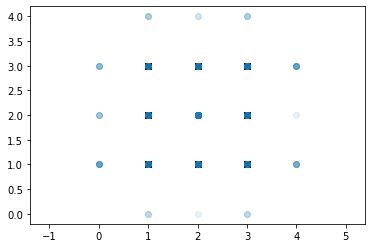

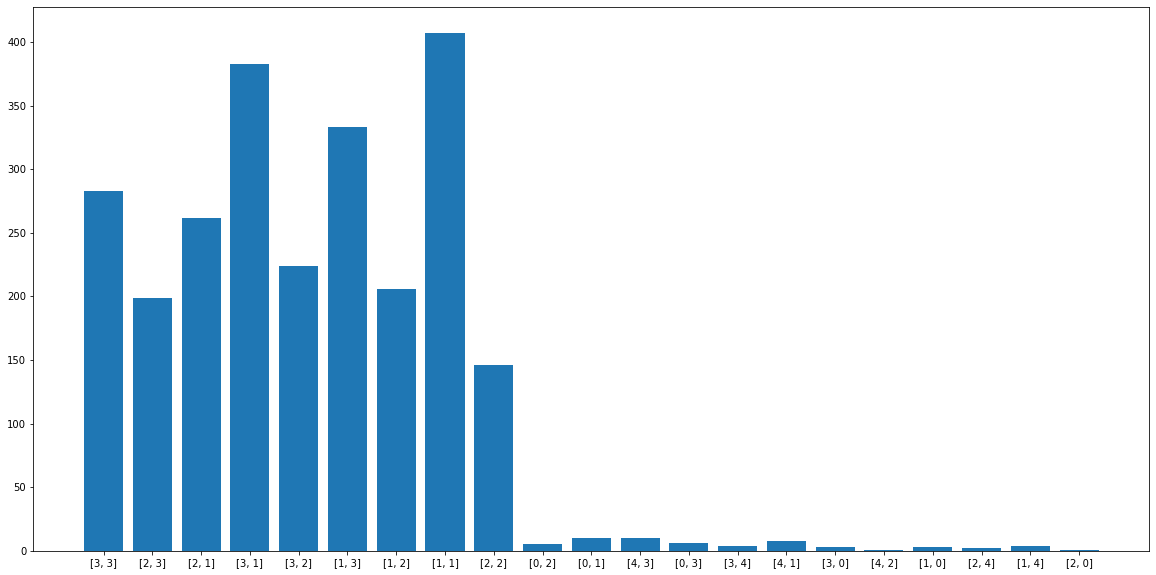

Processing Epoch 237
training start
Iteration 0, d real/fake loss 0.6451650261878967/0.6853371262550354 and g loss is 0.7899507284164429, NDiv loss 0.06636033952236176
Iteration 1, d real/fake loss 0.6450799703598022/0.6739788055419922 and g loss is 0.7645348310470581, NDiv loss 0.07786139100790024
Iteration 2, d real/fake loss 0.6454706788063049/0.683616578578949 and g loss is 0.8661779165267944, NDiv loss 0.07134402543306351
Iteration 3, d real/fake loss 0.6461798548698425/0.6715834140777588 and g loss is 0.7913926839828491, NDiv loss 0.07364969700574875
Iteration 4, d real/fake loss 0.6467177271842957/0.6439832448959351 and g loss is 0.7846348881721497, NDiv loss 0.07239601761102676


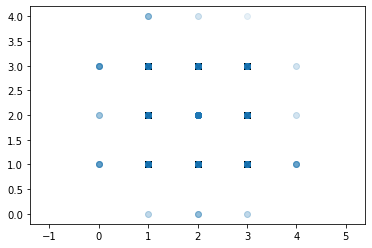

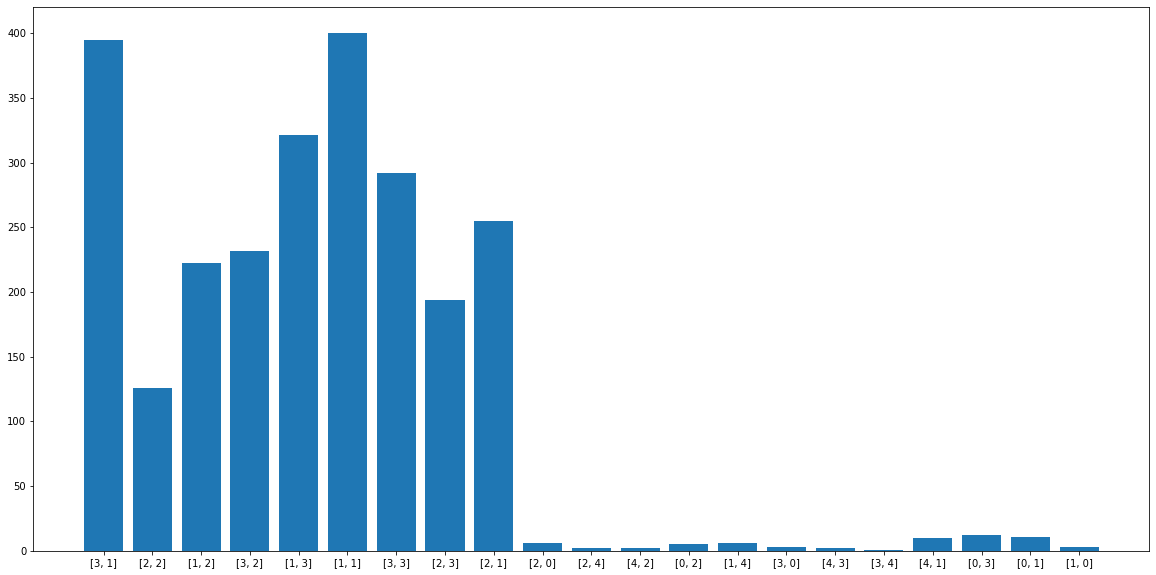

Processing Epoch 238
training start
Iteration 0, d real/fake loss 0.6662755012512207/0.6441783905029297 and g loss is 0.7811578512191772, NDiv loss 0.07680846750736237
Iteration 1, d real/fake loss 0.6657651662826538/0.6683000922203064 and g loss is 0.8247529864311218, NDiv loss 0.07723171263933182
Iteration 2, d real/fake loss 0.6648147702217102/0.6648173332214355 and g loss is 0.7761675119400024, NDiv loss 0.0909707173705101
Iteration 3, d real/fake loss 0.6638099551200867/0.6694738864898682 and g loss is 0.8038570880889893, NDiv loss 0.07082736492156982
Iteration 4, d real/fake loss 0.6628133058547974/0.7006041407585144 and g loss is 0.8418912291526794, NDiv loss 0.07232643663883209


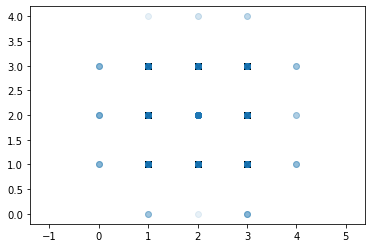

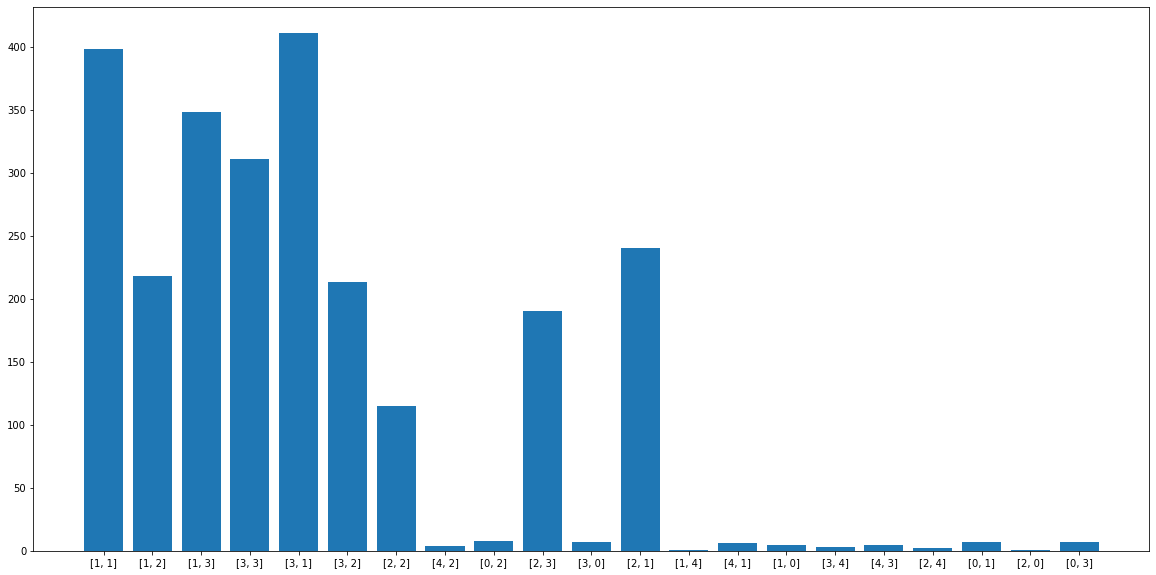

Processing Epoch 239
training start
Iteration 0, d real/fake loss 0.646706223487854/0.6755865812301636 and g loss is 0.7736790776252747, NDiv loss 0.08202941715717316
Iteration 1, d real/fake loss 0.6466543674468994/0.6901705861091614 and g loss is 0.7363720536231995, NDiv loss 0.07129418104887009
Iteration 2, d real/fake loss 0.6471471786499023/0.6726136207580566 and g loss is 0.7985067367553711, NDiv loss 0.07222601026296616
Iteration 3, d real/fake loss 0.6475188732147217/0.6759783029556274 and g loss is 0.7667097449302673, NDiv loss 0.07161762565374374
Iteration 4, d real/fake loss 0.6477622985839844/0.6764968037605286 and g loss is 0.796879231929779, NDiv loss 0.07268406450748444


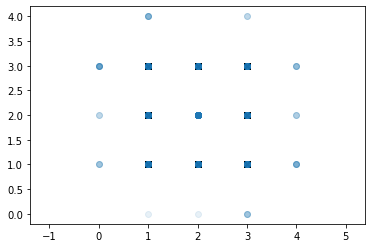

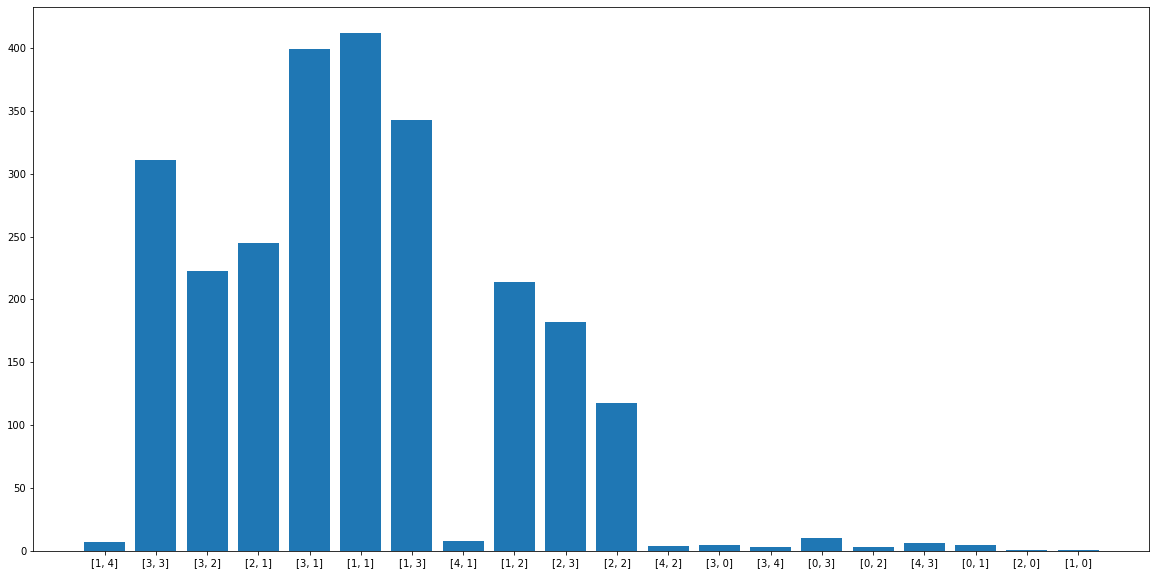

Processing Epoch 240
training start
Iteration 0, d real/fake loss 0.6632377505302429/0.6474196910858154 and g loss is 0.7766079306602478, NDiv loss 0.07027697563171387
Iteration 1, d real/fake loss 0.6630257368087769/0.6890138983726501 and g loss is 0.7552931904792786, NDiv loss 0.07719741016626358
Iteration 2, d real/fake loss 0.6626518368721008/0.6686702966690063 and g loss is 0.7351975440979004, NDiv loss 0.07880277931690216
Iteration 3, d real/fake loss 0.6621706485748291/0.6730458736419678 and g loss is 0.7846094369888306, NDiv loss 0.0867503434419632
Iteration 4, d real/fake loss 0.6617971658706665/0.6573495268821716 and g loss is 0.7766644358634949, NDiv loss 0.0814439207315445


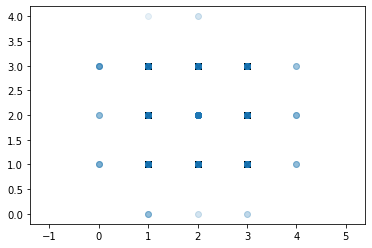

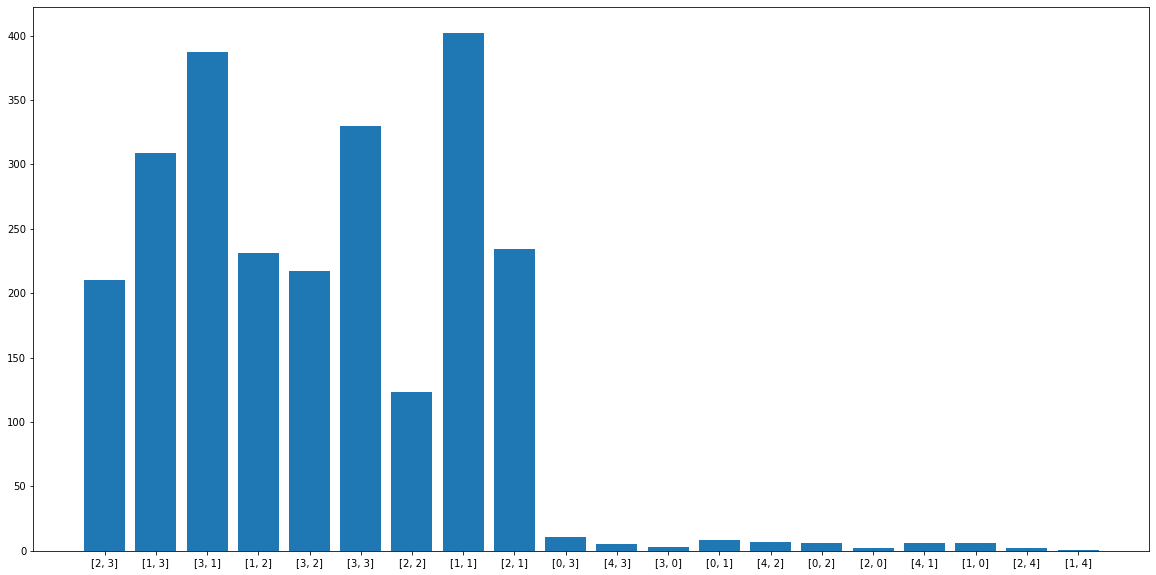

Processing Epoch 241
training start
Iteration 0, d real/fake loss 0.665604829788208/0.6530861854553223 and g loss is 0.8319337368011475, NDiv loss 0.07443638145923615
Iteration 1, d real/fake loss 0.6651791930198669/0.6555285453796387 and g loss is 0.7747541069984436, NDiv loss 0.07500822097063065
Iteration 2, d real/fake loss 0.6646077036857605/0.6569741368293762 and g loss is 0.7874091267585754, NDiv loss 0.07302189618349075
Iteration 3, d real/fake loss 0.6635490655899048/0.661536455154419 and g loss is 0.7744956016540527, NDiv loss 0.07017295062541962
Iteration 4, d real/fake loss 0.6621609926223755/0.6687502264976501 and g loss is 0.7706590890884399, NDiv loss 0.06867004185914993


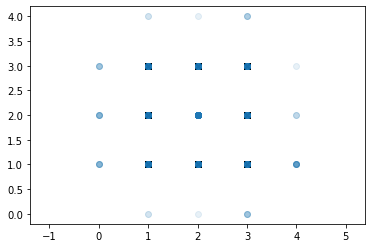

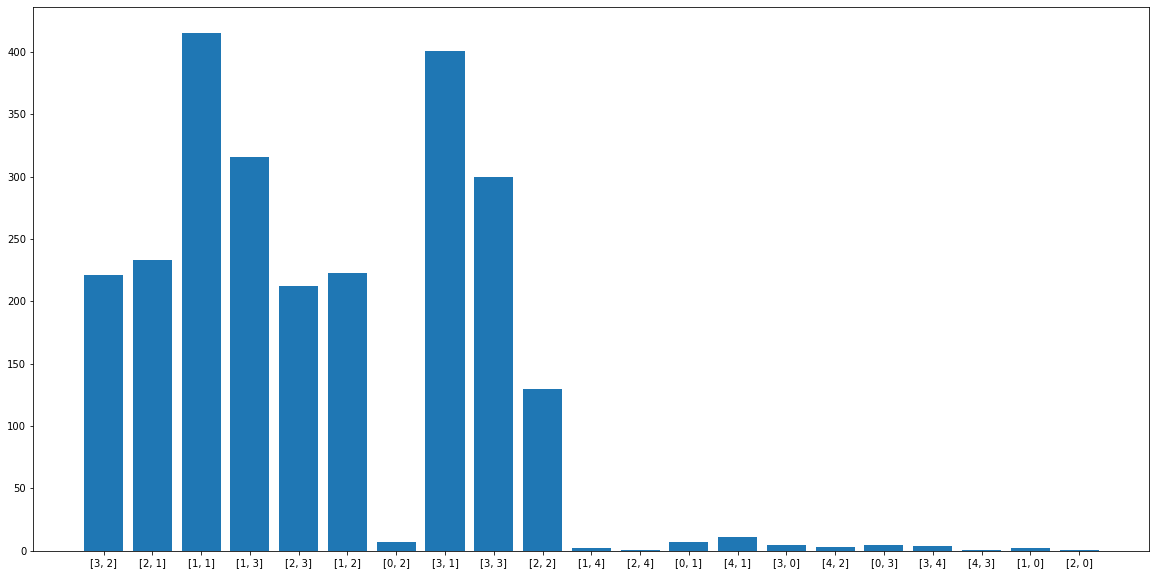

Processing Epoch 242
training start
Iteration 0, d real/fake loss 0.6467490196228027/0.7073260545730591 and g loss is 0.8294131755828857, NDiv loss 0.07133802026510239
Iteration 1, d real/fake loss 0.6465910077095032/0.6721423268318176 and g loss is 0.7850527763366699, NDiv loss 0.07275666296482086
Iteration 2, d real/fake loss 0.6466232538223267/0.6852675676345825 and g loss is 0.7381354570388794, NDiv loss 0.07877551019191742
Iteration 3, d real/fake loss 0.6468923687934875/0.6904854774475098 and g loss is 0.7461243867874146, NDiv loss 0.07142364978790283
Iteration 4, d real/fake loss 0.6472643613815308/0.673439621925354 and g loss is 0.8151799440383911, NDiv loss 0.078376904129982


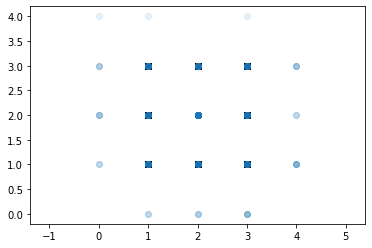

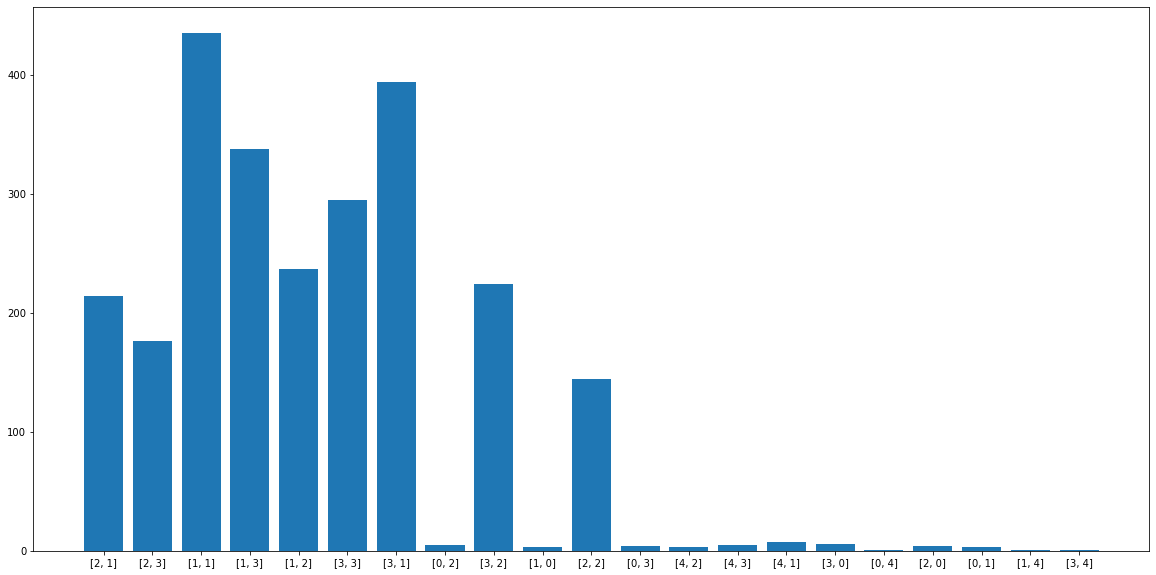

Processing Epoch 243
training start
Iteration 0, d real/fake loss 0.6355173587799072/0.6314183473587036 and g loss is 0.8267802000045776, NDiv loss 0.07464075088500977
Iteration 1, d real/fake loss 0.6361141800880432/0.6708562970161438 and g loss is 0.8242504596710205, NDiv loss 0.07679202407598495
Iteration 2, d real/fake loss 0.6370193362236023/0.6558465957641602 and g loss is 0.7980948686599731, NDiv loss 0.07092755287885666
Iteration 3, d real/fake loss 0.6378501057624817/0.6446408629417419 and g loss is 0.7630656361579895, NDiv loss 0.07869688421487808
Iteration 4, d real/fake loss 0.6384539008140564/0.6443132758140564 and g loss is 0.7619286775588989, NDiv loss 0.07413451373577118


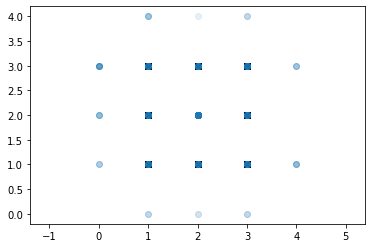

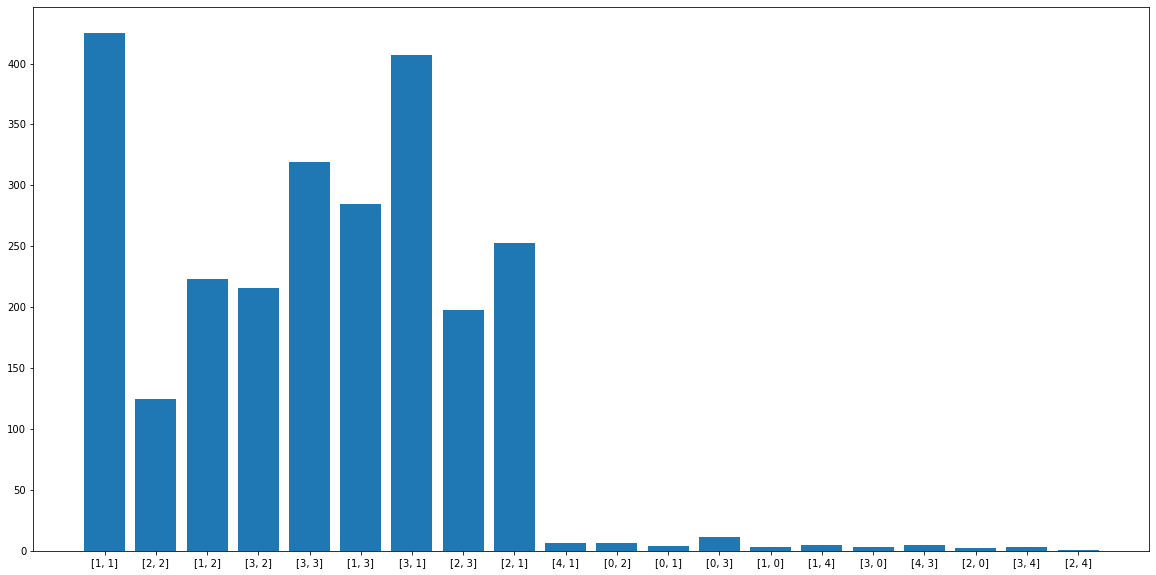

Processing Epoch 244
training start
Iteration 0, d real/fake loss 0.653390109539032/0.6907460689544678 and g loss is 0.8305724263191223, NDiv loss 0.07622622698545456
Iteration 1, d real/fake loss 0.6539095044136047/0.6476354002952576 and g loss is 0.7898291349411011, NDiv loss 0.07152733206748962
Iteration 2, d real/fake loss 0.6541991829872131/0.6691792011260986 and g loss is 0.7889398336410522, NDiv loss 0.07329531013965607
Iteration 3, d real/fake loss 0.6546079516410828/0.6728765964508057 and g loss is 0.814300537109375, NDiv loss 0.07238782197237015
Iteration 4, d real/fake loss 0.655142605304718/0.6655574440956116 and g loss is 0.8020057678222656, NDiv loss 0.07465410232543945


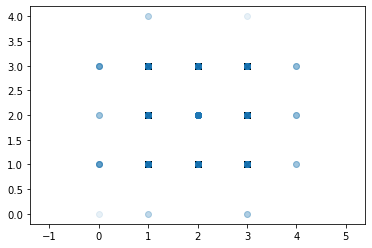

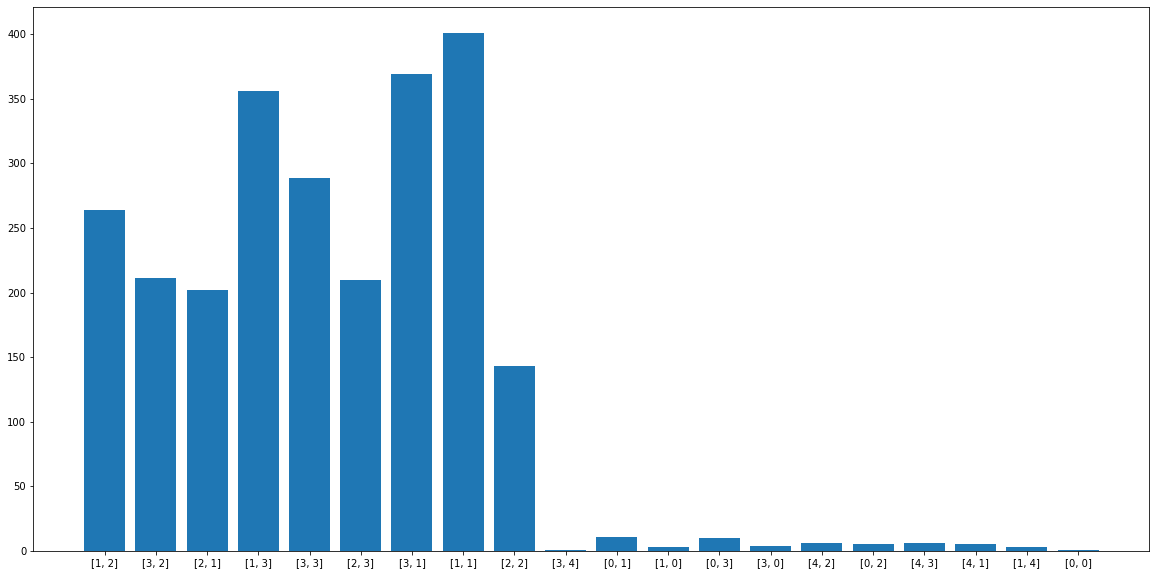

Processing Epoch 245
training start
Iteration 0, d real/fake loss 0.6601102352142334/0.672281801700592 and g loss is 0.8183339238166809, NDiv loss 0.07771441340446472
Iteration 1, d real/fake loss 0.6601750254631042/0.6893435120582581 and g loss is 0.7893267273902893, NDiv loss 0.07567691802978516
Iteration 2, d real/fake loss 0.6602158546447754/0.6445193290710449 and g loss is 0.8225096464157104, NDiv loss 0.07735303044319153
Iteration 3, d real/fake loss 0.659855306148529/0.6631959676742554 and g loss is 0.8240390419960022, NDiv loss 0.07191018760204315
Iteration 4, d real/fake loss 0.6591054797172546/0.6787204742431641 and g loss is 0.8249043822288513, NDiv loss 0.06771411001682281


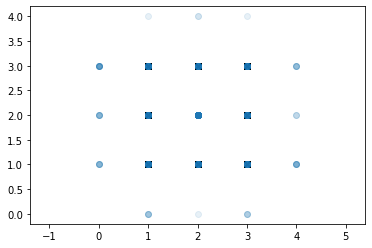

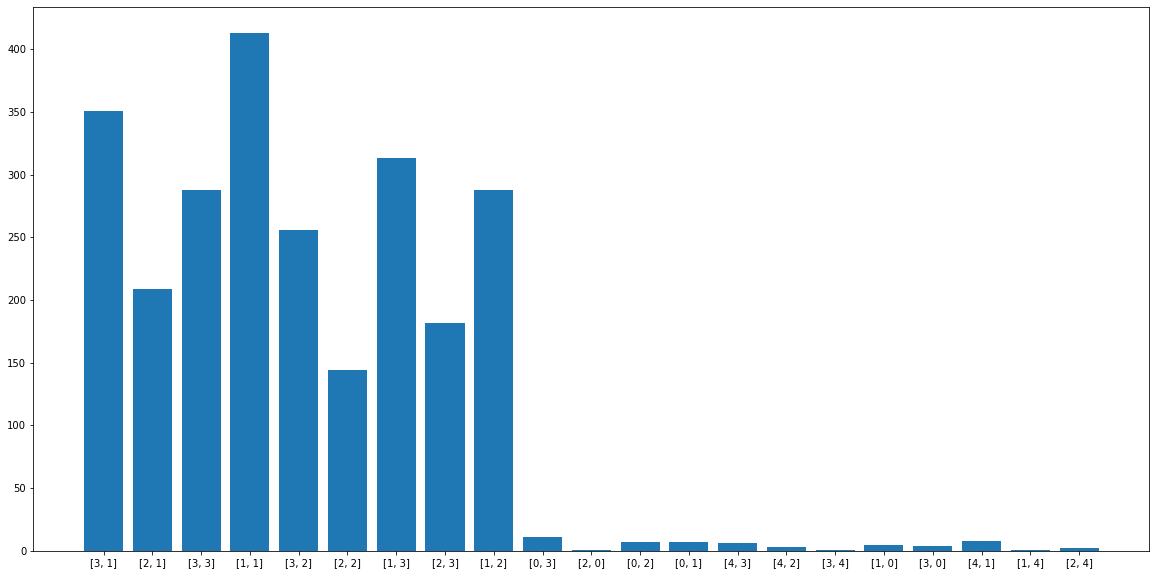

Processing Epoch 246
training start
Iteration 0, d real/fake loss 0.6739745736122131/0.686188817024231 and g loss is 0.7827348113059998, NDiv loss 0.07863058149814606
Iteration 1, d real/fake loss 0.6725047826766968/0.6799291968345642 and g loss is 0.7738436460494995, NDiv loss 0.07338855415582657
Iteration 2, d real/fake loss 0.6707478165626526/0.679724395275116 and g loss is 0.8111308813095093, NDiv loss 0.07498900592327118
Iteration 3, d real/fake loss 0.6688052415847778/0.6964359283447266 and g loss is 0.8587549924850464, NDiv loss 0.06947001069784164
Iteration 4, d real/fake loss 0.6670880913734436/0.6469047665596008 and g loss is 0.8028501272201538, NDiv loss 0.07945777475833893


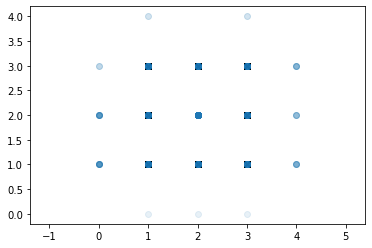

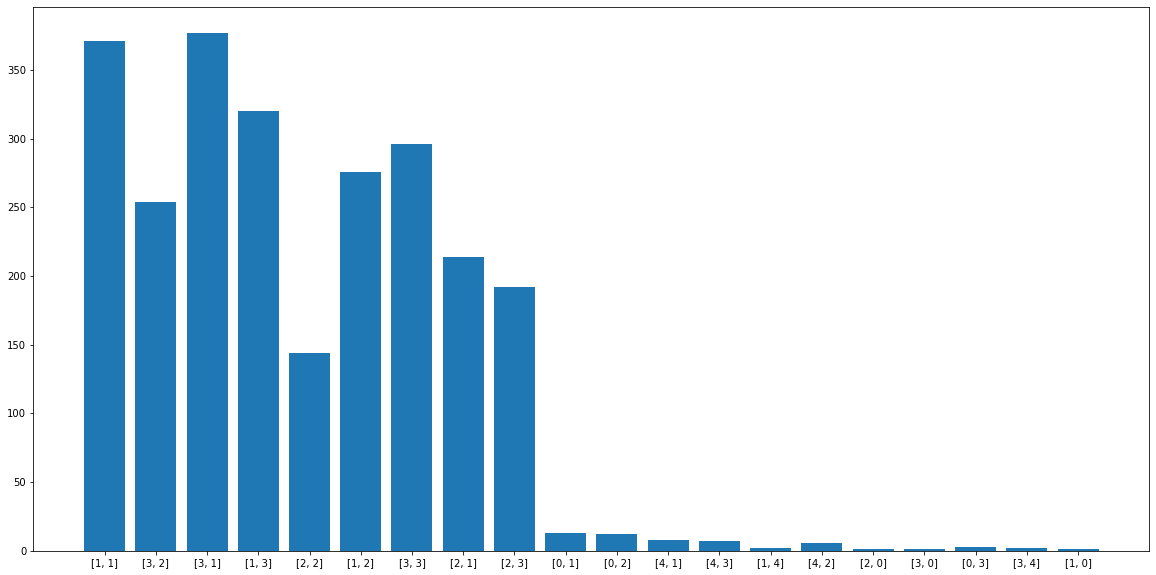

Processing Epoch 247
training start
Iteration 0, d real/fake loss 0.6549623012542725/0.6560842990875244 and g loss is 0.7645970582962036, NDiv loss 0.06964993476867676
Iteration 1, d real/fake loss 0.6542391777038574/0.6851426362991333 and g loss is 0.7194974422454834, NDiv loss 0.0827343687415123
Iteration 2, d real/fake loss 0.6540895700454712/0.6956541538238525 and g loss is 0.8136403560638428, NDiv loss 0.08269694447517395
Iteration 3, d real/fake loss 0.6541441679000854/0.6632635593414307 and g loss is 0.7363541126251221, NDiv loss 0.07269668579101562
Iteration 4, d real/fake loss 0.6537418365478516/0.6597658395767212 and g loss is 0.8043068647384644, NDiv loss 0.07320547848939896


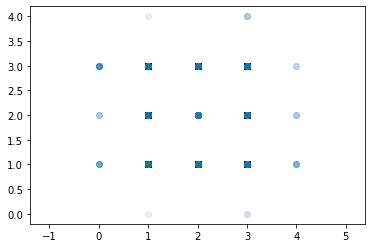

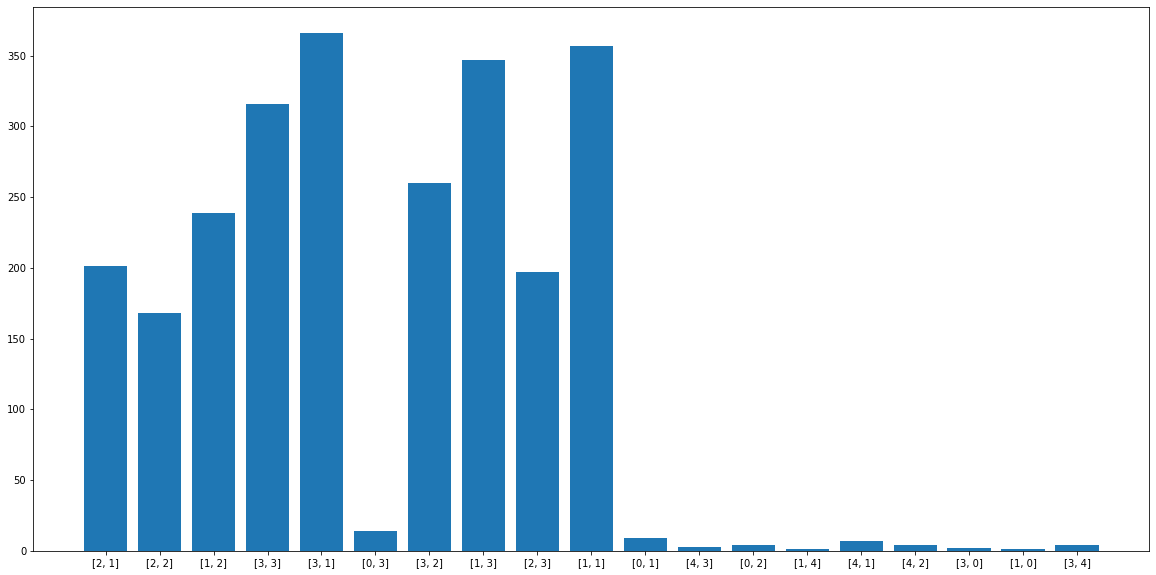

Processing Epoch 248
training start
Iteration 0, d real/fake loss 0.6603468656539917/0.6936571598052979 and g loss is 0.7582761645317078, NDiv loss 0.0742754265666008
Iteration 1, d real/fake loss 0.6594343185424805/0.6780081987380981 and g loss is 0.7368948459625244, NDiv loss 0.07163339108228683
Iteration 2, d real/fake loss 0.65840083360672/0.6618240475654602 and g loss is 0.8283002972602844, NDiv loss 0.08231735974550247
Iteration 3, d real/fake loss 0.6573415398597717/0.6564898490905762 and g loss is 0.7283257246017456, NDiv loss 0.07513513416051865
Iteration 4, d real/fake loss 0.6563558578491211/0.6627299785614014 and g loss is 0.8206707835197449, NDiv loss 0.072364442050457


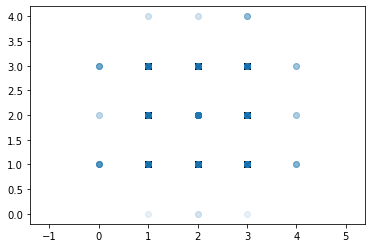

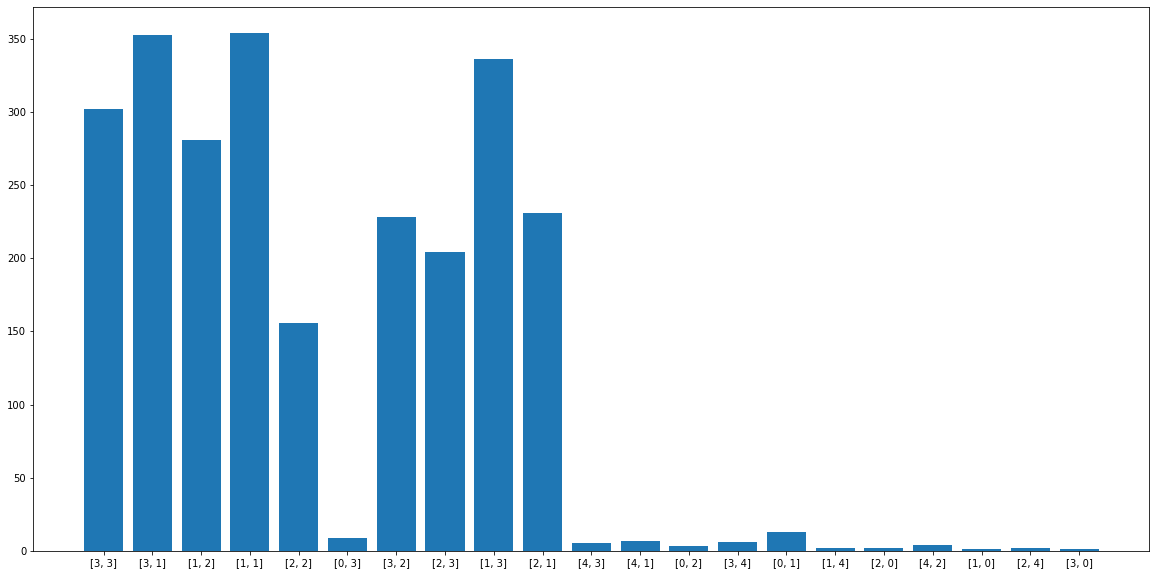

Processing Epoch 249
training start
Iteration 0, d real/fake loss 0.640622615814209/0.691619873046875 and g loss is 0.7668774724006653, NDiv loss 0.06649751961231232
Iteration 1, d real/fake loss 0.6408026218414307/0.6944195032119751 and g loss is 0.8702495098114014, NDiv loss 0.0734618678689003
Iteration 2, d real/fake loss 0.6418148279190063/0.7121139168739319 and g loss is 0.7986176013946533, NDiv loss 0.06925365328788757
Iteration 3, d real/fake loss 0.6434057354927063/0.6476991176605225 and g loss is 0.7932153940200806, NDiv loss 0.06768417358398438
Iteration 4, d real/fake loss 0.6446770429611206/0.6804056167602539 and g loss is 0.7686231136322021, NDiv loss 0.07158215343952179


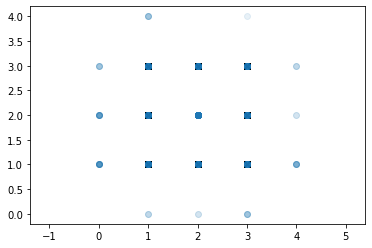

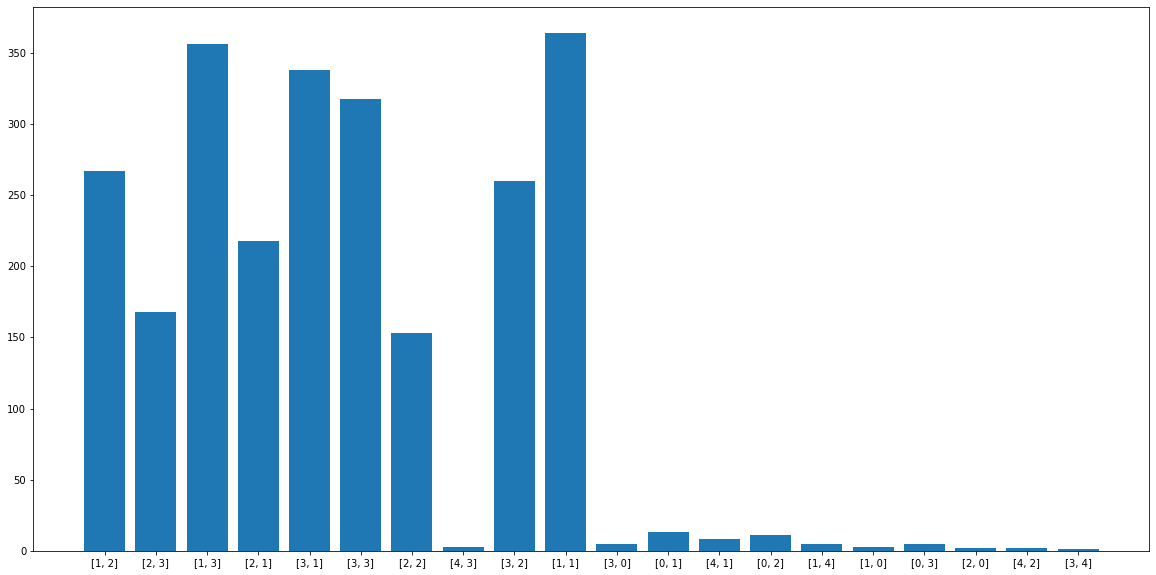

In [7]:
### Start training
for ep in range(250):
    print("Processing Epoch {}".format(ep))
    real_data = gen_real_data_onehot(dl, 128).float().cuda()
    input_data = gen_input_data(128).float().cuda()

    real_data = real_data.view(128, -1)    
    net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float().cuda()
    real_data = gen_real_data_onehot(dl, 1000).float().cuda()

#     d_fake, _ = net.g(input_data, temperature=100)
    d_fake, _ = net.g(input_data)
#     d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 1 == 0:
        plot_outputdata(real_data.data.cpu().numpy(), dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.data.cpu().numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.data.cpu().numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data]

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

Processing Epoch 0
Processing Epoch 1
Processing Epoch 2
Processing Epoch 3
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

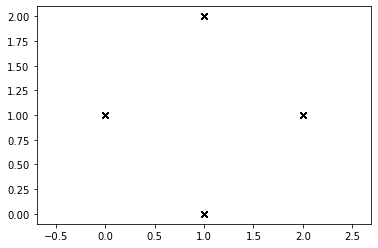

In [18]:
### Start training
for ep in range(500):
    print("Processing Epoch {}".format(ep))
#     real_data = gen_real_data_onehot(dl, 1024).float()
#     input_data = gen_input_data(1024).float()

#     real_data = real_data.view(1024, -1)    
#     net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float()
    real_data = gen_real_data_onehot(dl, 1000).float()

#     d_fake, _ = net.g(input_data, temperature=0.001)
#         d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 10 == 0:
        plot_outputdata(real_data, dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data] 

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

### Conclusion: Put Regularizer without limits would make all logits closer to 0, thus uniform noisy ~ U(0, 1)
### from gumbel reparameterization would do play a BBBBBBbig factor.
### Clearly value range (0, 0.001) would be influced greatly from U(0, 1);